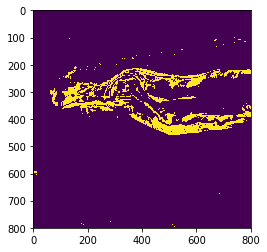

In [87]:
import cv2
import numpy as np
import dippykit as dip
import matplotlib.pyplot as plt
import pandas as pd


#PICKING AN IMAGE
im_original = cv2.imread("images/UW_400.png")
#im_original = cv2.imread("images/underwater-15.png")

#im_original = cv2.imread("images/24Zimmer-Refer-articleLarge.jpg")

#INITIAL EXPLORATION OF THE PICTURE

#Select pixels that are similar in color to skin
im_skin = np.copy(im_original)
for i in range(np.shape(im_original)[0]):
    for j in range(np.shape(im_original)[1]):
        #if im_original[i,j][2] < 60:
        if im_original[i,j][2] < 60 or im_original[i,j][0] > 200: #Zones mostly reddish, not blueish
            im_skin[i,j]=[0,0,0]

cv2.imwrite("temp_images/skin_color.png", im_skin)

#Select zones with high luminosity (probably zones iluminated by refracted light)
im_gray = cv2.cvtColor(im_original, cv2.COLOR_BGR2GRAY)
ret,th1 = cv2.threshold(im_gray,180,255,cv2.THRESH_BINARY)

cv2.imwrite("temp_images/binary.png", th1)

#Saliency detection
# initialize OpenCV's static fine grained saliency detector and compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(im_original)

# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map

threshMap = cv2.threshold(saliencyMap*255, 80, 255,cv2.THRESH_BINARY)[1]

cv2.imwrite("temp_images/saliency.png", saliencyMap*255)


%matplotlib inline
dip.imshow(threshMap)
dip.show()




In [88]:
#Calculate average skin color           
aux_skin_value = [0,0,0]
num_pixels_for_skin = 0

for i in range(np.shape(im_skin)[0]):
    for j in range(np.shape(im_skin)[1]):
        aux_skin_value = aux_skin_value + im_skin[i,j]
        if (im_skin[i,j] > [0, 0, 0]).all():
            num_pixels_for_skin = num_pixels_for_skin + 1
            
avg_skin_color = aux_skin_value/num_pixels_for_skin

print(avg_skin_color)


[134.01728815 146.86209597 137.48590204]


In [89]:
#Make an histogram with the color of the pixels
im_skin_vec = np.reshape(im_skin, (np.shape(im_skin)[0]*np.shape(im_skin)[1],3))
df = pd.DataFrame(im_skin_vec, columns=['R', 'G', 'B']) 

df['Intensity'] = df.apply(lambda row: (row.R + row.G + row.B)/3, axis = 1) 

df_color = df[df['Intensity'] > 0]

df_color

/home/miguel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """


R    G   B  Intensity
84746   195  145  62  48.666667
88752   190  134  72  46.666667
88755   197  152  93  62.000000
88756   186  135  77  47.333333
88757   179  125  60  36.000000
91865   195  124  60  41.000000
91866   200  127  69  46.666667
93573   196  150  84  58.000000
94371   186  123  62  38.333333
95973   187  120  64  38.333333
98338   185  113  63  35.000000
130917  189  128  61  40.666667
131719  197  138  71  50.000000
134824  196  143  75  52.666667
172151  194  167  74  59.666667
172153  170  139  67  40.000000
172952  174  149  72  46.333333
172953  184  163  88  59.666667
172954  163  142  65  38.000000
172955  179  160  81  54.666667
173752  193  167  90  64.666667
174551  177  153  85  53.000000
175350  167  141  73  41.666667
175357  189  155  64  50.666667
175564  185  140  61  43.333333
175565  179  137  64  41.333333
175566  172  136  68  40.000000
175567  187  150  88  56.333333
175889  175  145  74  46.000000
175890  190  163  93  63.333333
...     ...  ...  ..        ...
635674  173  171  67  51.666667
635675  173  169  66  50.666667
635718  186  193  66  63.000000
635719  200  206  77  75.666667
635720  179  186  60  56.333333
635756  186  189  65  61.333333
636341  191  196  66  65.666667
636343  189  192  63  62.666667
636519  191  198  70  67.666667
636521  191  198  70  67.666667
636557  179  184  61  56.000000
637141  193  201  61  66.333333
637290  171  162  62  46.333333
637320  177  186  61  56.000000
637321  193  202  73  70.666667
637941  195  202  60  67.000000
638091  171  162  63  46.666667
638193  170  158  65  45.666667
638752  193  189  62  62.666667
638753  194  189  62  63.000000
638843  184  183  64  58.333333
638994  171  159  66  46.666667
639641  191  191  66  64.000000
639642  185  187  62  59.333333
639643  183  186  62  58.333333
639645  197  201  74  72.000000
639646  187  192  64  62.333333
639647  196  201  70  70.333333
639651  195  194  65  66.000000
639736  175  172  62  51.000000

[51958 rows x 4 columns]

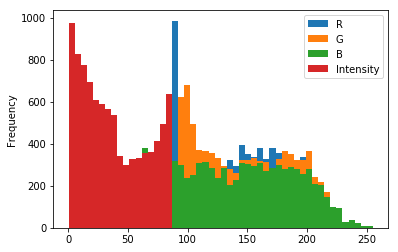

In [92]:
%matplotlib inline
df_color.plot.hist(bins = 50)

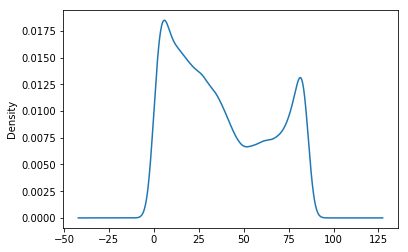

In [90]:
%matplotlib inline
plot = df_color.Intensity.plot(kind='kde')


In [91]:
df_brigth_color = df[(df['Intensity'] > 40) & (df['Intensity'] < 60)]

sum_rgb = df_brigth_color.sum(axis=0)
average_rgb = sum_rgb/len(df_brigth_color)

c = [1,1,1] #For making the color brighter

avg_skin_color = (average_rgb[0]*c[0], average_rgb[1]*c[1], average_rgb[2]*c[2]) 
print(avg_skin_color)

(139.845987862441, 153.1305461901551, 144.27228590694537)


In [92]:
#Interpolation 

im_skin_interp = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if th1[i,j] == 255: 
                remove_pixel[0] = True
            if th1[i,j+1] == 255: 
                remove_pixel[1] = True
            if th1[i+1,j] == 255: 
                remove_pixel[2] = True
            if th1[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = avg_skin_color
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
                    
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
                
                
            """
            im_skin_interp[i,j] = pixel_array[0]
            im_skin_interp[i,j+1] = pixel_array[1]
            im_skin_interp[i+1 ,j] = pixel_array[2]
            im_skin_interp[i+1,j+1] = pixel_array[3]
            """


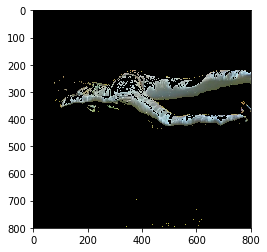

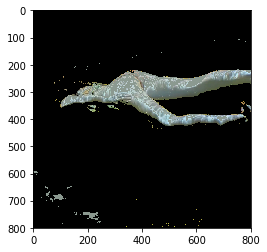

True

In [93]:
#Display only skin-coloured pixels on original image and interpolated skin 

%matplotlib inline
dip.imshow(im_skin)
dip.show()

%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated.png", im_skin_interp)


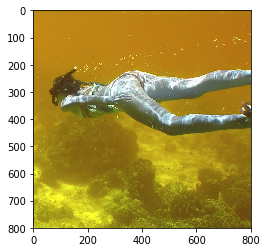

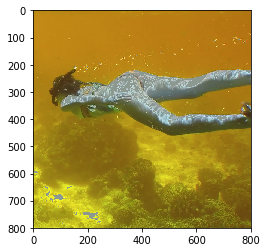

True

In [94]:
#Copying interpolated skin onto the original picture

im_res = np.copy(im_original)

%matplotlib inline
dip.imshow(im_original)
dip.show()

for i in range(np.shape(im_res)[0]):
    for j in range(np.shape(im_res)[1]):
        if (im_skin_interp[i,j] > [0, 0, 0]).all():
            im_res[i,j] = im_skin_interp[i,j]
            
%matplotlib inline
dip.imshow(im_res)
dip.show()

cv2.imwrite("temp_images/result.png", im_res)

In [ ]:
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================


In [5]:
#Interpolation 

im_skin_interp = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        print(pixel_upper_left) #To know the value of the pixel   
        print("Position" + str(i), str(j))#To know the position of the pixel 
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if all 4 pixels correspond to the body (i.e. none of them is black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() and (pixel_upper_rigth > ([0,0,0])).all and (pixel_bottom_left > ([0,0,0])).all() and (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if th1[i,j] == 255: 
                remove_pixel[0] = True
            if th1[i,j+1] == 255: 
                remove_pixel[1] = True
            if th1[i+1,j] == 255: 
                remove_pixel[2] = True
            if th1[i+1,j+1] == 255: 
                remove_pixel[3] = True
           
            print(remove_pixel)
            
            pixel_value = [0,0,0]
            num_true = 0
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == False: 
                    pixel_value = pixel_value + pixel_array[p]
                    num_true = num_true + 1
                    
            avg_pixel_value = pixel_value/num_true
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  [255, 0, 0]#vg_pixel_value
            
            im_skin_interp[i,j] = pixel_array[0]
            im_skin_interp[i,j+1] = pixel_array[1]
            im_skin_interp[i+1 ,j] = pixel_array[2]
            im_skin_interp[i+1,j+1] = pixel_array[3]
            
#cv2.imshow("Skin Interpolated", im_skin_interp)      


[0 0 0]
Position0 0
[0 0 0]
Position0 1
[0 0 0]
Position0 2
[0 0 0]
Position0 3
[0 0 0]
Position0 4
[0 0 0]
Position0 5
[0 0 0]
Position0 6
[0 0 0]
Position0 7
[0 0 0]
Position0 8
[0 0 0]
Position0 9
[0 0 0]
Position0 10
[0 0 0]
Position0 11
[0 0 0]
Position0 12
[0 0 0]
Position0 13
[0 0 0]
Position0 14
[0 0 0]
Position0 15
[0 0 0]
Position0 16
[0 0 0]
Position0 17
[0 0 0]
Position0 18
[0 0 0]
Position0 19
[0 0 0]
Position0 20
[0 0 0]
Position0 21
[0 0 0]
Position0 22
[0 0 0]
Position0 23
[0 0 0]
Position0 24
[0 0 0]
Position0 25
[0 0 0]
Position0 26
[0 0 0]
Position0 27
[0 0 0]
Position0 28
[0 0 0]
Position0 29
[0 0 0]
Position0 30
[0 0 0]
Position0 31
[0 0 0]
Position0 32
[0 0 0]
Position0 33
[0 0 0]
Position0 34
[0 0 0]
Position0 35
[0 0 0]
Position0 36
[0 0 0]
Position0 37
[0 0 0]
Position0 38
[0 0 0]
Position0 39
[0 0 0]
Position0 40
[0 0 0]
Position0 41
[0 0 0]
Position0 42
[0 0 0]
Position0 43
[0 0 0]
Position0 44
[0 0 0]
Position0 45
[0 0 0]
Position0 46
[0 0 0]
Position0 47
[0

Position0 579
[0 0 0]
Position0 580
[0 0 0]
Position0 581
[0 0 0]
Position0 582
[0 0 0]
Position0 583
[0 0 0]
Position0 584
[0 0 0]
Position0 585
[0 0 0]
Position0 586
[0 0 0]
Position0 587
[0 0 0]
Position0 588
[0 0 0]
Position0 589
[0 0 0]
Position0 590
[0 0 0]
Position0 591
[0 0 0]
Position0 592
[0 0 0]
Position0 593
[0 0 0]
Position0 594
[0 0 0]
Position0 595
[0 0 0]
Position0 596
[0 0 0]
Position0 597
[0 0 0]
Position0 598
[0 0 0]
Position0 599
[0 0 0]
Position0 600
[0 0 0]
Position0 601
[0 0 0]
Position0 602
[0 0 0]
Position0 603
[0 0 0]
Position0 604
[0 0 0]
Position0 605
[0 0 0]
Position0 606
[0 0 0]
Position0 607
[0 0 0]
Position0 608
[0 0 0]
Position0 609
[0 0 0]
Position0 610
[0 0 0]
Position0 611
[0 0 0]
Position0 612
[0 0 0]
Position0 613
[0 0 0]
Position0 614
[0 0 0]
Position0 615
[0 0 0]
Position0 616
[0 0 0]
Position0 617
[0 0 0]
Position0 618
[0 0 0]
Position0 619
[0 0 0]
Position0 620
[0 0 0]
Position0 621
[0 0 0]
Position0 622
[0 0 0]
Position0 623
[0 0 0]
Position0 

Position0 1212
[0 0 0]
Position0 1213
[0 0 0]
Position0 1214
[0 0 0]
Position0 1215
[0 0 0]
Position0 1216
[0 0 0]
Position0 1217
[0 0 0]
Position0 1218
[0 0 0]
Position0 1219
[0 0 0]
Position0 1220
[0 0 0]
Position0 1221
[0 0 0]
Position0 1222
[0 0 0]
Position0 1223
[0 0 0]
Position0 1224
[0 0 0]
Position0 1225
[0 0 0]
Position0 1226
[0 0 0]
Position0 1227
[0 0 0]
Position0 1228
[0 0 0]
Position0 1229
[0 0 0]
Position0 1230
[0 0 0]
Position0 1231
[0 0 0]
Position0 1232
[0 0 0]
Position0 1233
[0 0 0]
Position0 1234
[0 0 0]
Position0 1235
[0 0 0]
Position0 1236
[0 0 0]
Position0 1237
[0 0 0]
Position0 1238
[0 0 0]
Position0 1239
[0 0 0]
Position0 1240
[0 0 0]
Position0 1241
[0 0 0]
Position0 1242
[0 0 0]
Position0 1243
[0 0 0]
Position0 1244
[0 0 0]
Position0 1245
[0 0 0]
Position0 1246
[0 0 0]
Position0 1247
[0 0 0]
Position0 1248
[0 0 0]
Position0 1249
[0 0 0]
Position0 1250
[0 0 0]
Position0 1251
[0 0 0]
Position0 1252
[0 0 0]
Position0 1253
[0 0 0]
Position0 1254
[0 0 0]
Position0 1

[0 0 0]
Position1 27
[0 0 0]
Position1 28
[0 0 0]
Position1 29
[0 0 0]
Position1 30
[0 0 0]
Position1 31
[0 0 0]
Position1 32
[0 0 0]
Position1 33
[0 0 0]
Position1 34
[0 0 0]
Position1 35
[0 0 0]
Position1 36
[0 0 0]
Position1 37
[0 0 0]
Position1 38
[0 0 0]
Position1 39
[0 0 0]
Position1 40
[0 0 0]
Position1 41
[0 0 0]
Position1 42
[0 0 0]
Position1 43
[0 0 0]
Position1 44
[0 0 0]
Position1 45
[0 0 0]
Position1 46
[0 0 0]
Position1 47
[0 0 0]
Position1 48
[0 0 0]
Position1 49
[0 0 0]
Position1 50
[0 0 0]
Position1 51
[0 0 0]
Position1 52
[0 0 0]
Position1 53
[0 0 0]
Position1 54
[0 0 0]
Position1 55
[0 0 0]
Position1 56
[0 0 0]
Position1 57
[0 0 0]
Position1 58
[0 0 0]
Position1 59
[0 0 0]
Position1 60
[0 0 0]
Position1 61
[0 0 0]
Position1 62
[0 0 0]
Position1 63
[0 0 0]
Position1 64
[0 0 0]
Position1 65
[0 0 0]
Position1 66
[0 0 0]
Position1 67
[0 0 0]
Position1 68
[0 0 0]
Position1 69
[0 0 0]
Position1 70
[0 0 0]
Position1 71
[0 0 0]
Position1 72
[0 0 0]
Position1 73
[0 0 0]
Posit

Position1 823
[0 0 0]
Position1 824
[0 0 0]
Position1 825
[0 0 0]
Position1 826
[0 0 0]
Position1 827
[0 0 0]
Position1 828
[0 0 0]
Position1 829
[0 0 0]
Position1 830
[0 0 0]
Position1 831
[0 0 0]
Position1 832
[0 0 0]
Position1 833
[0 0 0]
Position1 834
[0 0 0]
Position1 835
[0 0 0]
Position1 836
[0 0 0]
Position1 837
[0 0 0]
Position1 838
[0 0 0]
Position1 839
[0 0 0]
Position1 840
[0 0 0]
Position1 841
[0 0 0]
Position1 842
[0 0 0]
Position1 843
[0 0 0]
Position1 844
[0 0 0]
Position1 845
[0 0 0]
Position1 846
[0 0 0]
Position1 847
[0 0 0]
Position1 848
[0 0 0]
Position1 849
[0 0 0]
Position1 850
[0 0 0]
Position1 851
[0 0 0]
Position1 852
[0 0 0]
Position1 853
[0 0 0]
Position1 854
[0 0 0]
Position1 855
[0 0 0]
Position1 856
[0 0 0]
Position1 857
[0 0 0]
Position1 858
[0 0 0]
Position1 859
[0 0 0]
Position1 860
[0 0 0]
Position1 861
[0 0 0]
Position1 862
[0 0 0]
Position1 863
[0 0 0]
Position1 864
[0 0 0]
Position1 865
[0 0 0]
Position1 866
[0 0 0]
Position1 867
[0 0 0]
Position1 

Position1 1490
[0 0 0]
Position1 1491
[0 0 0]
Position1 1492
[0 0 0]
Position1 1493
[0 0 0]
Position1 1494
[0 0 0]
Position1 1495
[0 0 0]
Position1 1496
[0 0 0]
Position1 1497
[0 0 0]
Position1 1498
[0 0 0]
Position1 1499
[0 0 0]
Position1 1500
[0 0 0]
Position1 1501
[0 0 0]
Position1 1502
[0 0 0]
Position1 1503
[0 0 0]
Position1 1504
[0 0 0]
Position1 1505
[0 0 0]
Position1 1506
[0 0 0]
Position1 1507
[0 0 0]
Position1 1508
[0 0 0]
Position1 1509
[0 0 0]
Position1 1510
[0 0 0]
Position1 1511
[0 0 0]
Position1 1512
[0 0 0]
Position1 1513
[0 0 0]
Position1 1514
[0 0 0]
Position1 1515
[0 0 0]
Position1 1516
[0 0 0]
Position1 1517
[0 0 0]
Position1 1518
[0 0 0]
Position1 1519
[0 0 0]
Position1 1520
[0 0 0]
Position1 1521
[0 0 0]
Position1 1522
[0 0 0]
Position1 1523
[0 0 0]
Position1 1524
[0 0 0]
Position1 1525
[0 0 0]
Position1 1526
[0 0 0]
Position1 1527
[0 0 0]
Position1 1528
[0 0 0]
Position1 1529
[0 0 0]
Position1 1530
[0 0 0]
Position1 1531
[0 0 0]
Position1 1532
[0 0 0]
Position1 1

Position2 224
[0 0 0]
Position2 225
[0 0 0]
Position2 226
[0 0 0]
Position2 227
[0 0 0]
Position2 228
[0 0 0]
Position2 229
[0 0 0]
Position2 230
[0 0 0]
Position2 231
[0 0 0]
Position2 232
[0 0 0]
Position2 233
[0 0 0]
Position2 234
[0 0 0]
Position2 235
[0 0 0]
Position2 236
[0 0 0]
Position2 237
[0 0 0]
Position2 238
[0 0 0]
Position2 239
[0 0 0]
Position2 240
[0 0 0]
Position2 241
[0 0 0]
Position2 242
[0 0 0]
Position2 243
[0 0 0]
Position2 244
[0 0 0]
Position2 245
[0 0 0]
Position2 246
[0 0 0]
Position2 247
[0 0 0]
Position2 248
[0 0 0]
Position2 249
[0 0 0]
Position2 250
[0 0 0]
Position2 251
[0 0 0]
Position2 252
[0 0 0]
Position2 253
[0 0 0]
Position2 254
[0 0 0]
Position2 255
[0 0 0]
Position2 256
[0 0 0]
Position2 257
[0 0 0]
Position2 258
[0 0 0]
Position2 259
[0 0 0]
Position2 260
[0 0 0]
Position2 261
[0 0 0]
Position2 262
[0 0 0]
Position2 263
[0 0 0]
Position2 264
[0 0 0]
Position2 265
[0 0 0]
Position2 266
[0 0 0]
Position2 267
[0 0 0]
Position2 268
[0 0 0]
Position2 

[0 0 0]
Position2 974
[0 0 0]
Position2 975
[0 0 0]
Position2 976
[0 0 0]
Position2 977
[0 0 0]
Position2 978
[0 0 0]
Position2 979
[0 0 0]
Position2 980
[0 0 0]
Position2 981
[0 0 0]
Position2 982
[0 0 0]
Position2 983
[0 0 0]
Position2 984
[0 0 0]
Position2 985
[0 0 0]
Position2 986
[0 0 0]
Position2 987
[0 0 0]
Position2 988
[0 0 0]
Position2 989
[0 0 0]
Position2 990
[0 0 0]
Position2 991
[0 0 0]
Position2 992
[0 0 0]
Position2 993
[0 0 0]
Position2 994
[0 0 0]
Position2 995
[0 0 0]
Position2 996
[0 0 0]
Position2 997
[0 0 0]
Position2 998
[0 0 0]
Position2 999
[0 0 0]
Position2 1000
[0 0 0]
Position2 1001
[0 0 0]
Position2 1002
[0 0 0]
Position2 1003
[0 0 0]
Position2 1004
[0 0 0]
Position2 1005
[0 0 0]
Position2 1006
[0 0 0]
Position2 1007
[0 0 0]
Position2 1008
[0 0 0]
Position2 1009
[0 0 0]
Position2 1010
[0 0 0]
Position2 1011
[0 0 0]
Position2 1012
[0 0 0]
Position2 1013
[0 0 0]
Position2 1014
[0 0 0]
Position2 1015
[0 0 0]
Position2 1016
[0 0 0]
Position2 1017
[0 0 0]
Positi

Position2 1636
[0 0 0]
Position2 1637
[0 0 0]
Position2 1638
[0 0 0]
Position2 1639
[0 0 0]
Position2 1640
[0 0 0]
Position2 1641
[0 0 0]
Position2 1642
[0 0 0]
Position2 1643
[0 0 0]
Position2 1644
[0 0 0]
Position2 1645
[0 0 0]
Position2 1646
[0 0 0]
Position2 1647
[0 0 0]
Position2 1648
[0 0 0]
Position2 1649
[0 0 0]
Position2 1650
[0 0 0]
Position2 1651
[0 0 0]
Position2 1652
[0 0 0]
Position2 1653
[0 0 0]
Position2 1654
[0 0 0]
Position2 1655
[0 0 0]
Position2 1656
[0 0 0]
Position2 1657
[0 0 0]
Position2 1658
[0 0 0]
Position2 1659
[0 0 0]
Position2 1660
[0 0 0]
Position2 1661
[0 0 0]
Position2 1662
[0 0 0]
Position2 1663
[0 0 0]
Position2 1664
[0 0 0]
Position2 1665
[0 0 0]
Position2 1666
[0 0 0]
Position2 1667
[0 0 0]
Position2 1668
[0 0 0]
Position2 1669
[0 0 0]
Position2 1670
[0 0 0]
Position2 1671
[0 0 0]
Position2 1672
[0 0 0]
Position2 1673
[0 0 0]
Position2 1674
[0 0 0]
Position2 1675
[0 0 0]
Position2 1676
[0 0 0]
Position2 1677
[0 0 0]
Position2 1678
[0 0 0]
Position2 1

[0 0 0]
Position3 443
[0 0 0]
Position3 444
[0 0 0]
Position3 445
[0 0 0]
Position3 446
[0 0 0]
Position3 447
[0 0 0]
Position3 448
[0 0 0]
Position3 449
[0 0 0]
Position3 450
[0 0 0]
Position3 451
[0 0 0]
Position3 452
[0 0 0]
Position3 453
[0 0 0]
Position3 454
[0 0 0]
Position3 455
[0 0 0]
Position3 456
[0 0 0]
Position3 457
[0 0 0]
Position3 458
[0 0 0]
Position3 459
[0 0 0]
Position3 460
[0 0 0]
Position3 461
[0 0 0]
Position3 462
[0 0 0]
Position3 463
[0 0 0]
Position3 464
[0 0 0]
Position3 465
[0 0 0]
Position3 466
[0 0 0]
Position3 467
[0 0 0]
Position3 468
[0 0 0]
Position3 469
[0 0 0]
Position3 470
[0 0 0]
Position3 471
[0 0 0]
Position3 472
[0 0 0]
Position3 473
[0 0 0]
Position3 474
[0 0 0]
Position3 475
[0 0 0]
Position3 476
[0 0 0]
Position3 477
[0 0 0]
Position3 478
[0 0 0]
Position3 479
[0 0 0]
Position3 480
[0 0 0]
Position3 481
[0 0 0]
Position3 482
[0 0 0]
Position3 483
[0 0 0]
Position3 484
[0 0 0]
Position3 485
[0 0 0]
Position3 486
[0 0 0]
Position3 487
[0 0 0]
Po

Position3 1205
[0 0 0]
Position3 1206
[0 0 0]
Position3 1207
[0 0 0]
Position3 1208
[0 0 0]
Position3 1209
[0 0 0]
Position3 1210
[0 0 0]
Position3 1211
[0 0 0]
Position3 1212
[0 0 0]
Position3 1213
[0 0 0]
Position3 1214
[0 0 0]
Position3 1215
[0 0 0]
Position3 1216
[0 0 0]
Position3 1217
[0 0 0]
Position3 1218
[0 0 0]
Position3 1219
[0 0 0]
Position3 1220
[0 0 0]
Position3 1221
[0 0 0]
Position3 1222
[0 0 0]
Position3 1223
[0 0 0]
Position3 1224
[0 0 0]
Position3 1225
[0 0 0]
Position3 1226
[0 0 0]
Position3 1227
[0 0 0]
Position3 1228
[0 0 0]
Position3 1229
[0 0 0]
Position3 1230
[0 0 0]
Position3 1231
[0 0 0]
Position3 1232
[0 0 0]
Position3 1233
[0 0 0]
Position3 1234
[0 0 0]
Position3 1235
[0 0 0]
Position3 1236
[0 0 0]
Position3 1237
[0 0 0]
Position3 1238
[0 0 0]
Position3 1239
[0 0 0]
Position3 1240
[0 0 0]
Position3 1241
[0 0 0]
Position3 1242
[0 0 0]
Position3 1243
[0 0 0]
Position3 1244
[0 0 0]
Position3 1245
[0 0 0]
Position3 1246
[0 0 0]
Position3 1247
[0 0 0]
Position3 1

[0 0 0]
Position3 1756
[0 0 0]
Position3 1757
[0 0 0]
Position3 1758
[0 0 0]
Position3 1759
[0 0 0]
Position3 1760
[0 0 0]
Position3 1761
[0 0 0]
Position3 1762
[0 0 0]
Position3 1763
[0 0 0]
Position3 1764
[0 0 0]
Position3 1765
[0 0 0]
Position3 1766
[0 0 0]
Position3 1767
[0 0 0]
Position3 1768
[0 0 0]
Position3 1769
[0 0 0]
Position3 1770
[0 0 0]
Position3 1771
[0 0 0]
Position3 1772
[0 0 0]
Position3 1773
[0 0 0]
Position3 1774
[0 0 0]
Position3 1775
[0 0 0]
Position3 1776
[0 0 0]
Position3 1777
[0 0 0]
Position3 1778
[0 0 0]
Position3 1779
[0 0 0]
Position3 1780
[0 0 0]
Position3 1781
[0 0 0]
Position3 1782
[0 0 0]
Position3 1783
[0 0 0]
Position3 1784
[0 0 0]
Position3 1785
[0 0 0]
Position3 1786
[0 0 0]
Position3 1787
[0 0 0]
Position3 1788
[0 0 0]
Position3 1789
[0 0 0]
Position3 1790
[0 0 0]
Position3 1791
[0 0 0]
Position3 1792
[0 0 0]
Position3 1793
[0 0 0]
Position3 1794
[0 0 0]
Position3 1795
[0 0 0]
Position3 1796
[0 0 0]
Position3 1797
[0 0 0]
Position3 1798
[0 0 0]
Pos

Position4 665
[0 0 0]
Position4 666
[0 0 0]
Position4 667
[0 0 0]
Position4 668
[0 0 0]
Position4 669
[0 0 0]
Position4 670
[0 0 0]
Position4 671
[0 0 0]
Position4 672
[0 0 0]
Position4 673
[0 0 0]
Position4 674
[0 0 0]
Position4 675
[0 0 0]
Position4 676
[0 0 0]
Position4 677
[0 0 0]
Position4 678
[0 0 0]
Position4 679
[0 0 0]
Position4 680
[0 0 0]
Position4 681
[0 0 0]
Position4 682
[0 0 0]
Position4 683
[0 0 0]
Position4 684
[0 0 0]
Position4 685
[0 0 0]
Position4 686
[0 0 0]
Position4 687
[0 0 0]
Position4 688
[0 0 0]
Position4 689
[0 0 0]
Position4 690
[0 0 0]
Position4 691
[0 0 0]
Position4 692
[0 0 0]
Position4 693
[0 0 0]
Position4 694
[0 0 0]
Position4 695
[0 0 0]
Position4 696
[0 0 0]
Position4 697
[0 0 0]
Position4 698
[0 0 0]
Position4 699
[0 0 0]
Position4 700
[0 0 0]
Position4 701
[0 0 0]
Position4 702
[0 0 0]
Position4 703
[0 0 0]
Position4 704
[0 0 0]
Position4 705
[0 0 0]
Position4 706
[0 0 0]
Position4 707
[0 0 0]
Position4 708
[0 0 0]
Position4 709
[0 0 0]
Position4 

Position4 1338
[0 0 0]
Position4 1339
[0 0 0]
Position4 1340
[0 0 0]
Position4 1341
[0 0 0]
Position4 1342
[0 0 0]
Position4 1343
[0 0 0]
Position4 1344
[0 0 0]
Position4 1345
[0 0 0]
Position4 1346
[0 0 0]
Position4 1347
[0 0 0]
Position4 1348
[0 0 0]
Position4 1349
[0 0 0]
Position4 1350
[0 0 0]
Position4 1351
[0 0 0]
Position4 1352
[0 0 0]
Position4 1353
[0 0 0]
Position4 1354
[0 0 0]
Position4 1355
[0 0 0]
Position4 1356
[0 0 0]
Position4 1357
[0 0 0]
Position4 1358
[0 0 0]
Position4 1359
[0 0 0]
Position4 1360
[0 0 0]
Position4 1361
[0 0 0]
Position4 1362
[0 0 0]
Position4 1363
[0 0 0]
Position4 1364
[0 0 0]
Position4 1365
[0 0 0]
Position4 1366
[0 0 0]
Position4 1367
[0 0 0]
Position4 1368
[0 0 0]
Position4 1369
[0 0 0]
Position4 1370
[0 0 0]
Position4 1371
[0 0 0]
Position4 1372
[0 0 0]
Position4 1373
[0 0 0]
Position4 1374
[0 0 0]
Position4 1375
[0 0 0]
Position4 1376
[0 0 0]
Position4 1377
[0 0 0]
Position4 1378
[0 0 0]
Position4 1379
[0 0 0]
Position4 1380
[0 0 0]
Position4 1

Position5 153
[0 0 0]
Position5 154
[0 0 0]
Position5 155
[0 0 0]
Position5 156
[0 0 0]
Position5 157
[0 0 0]
Position5 158
[0 0 0]
Position5 159
[0 0 0]
Position5 160
[0 0 0]
Position5 161
[0 0 0]
Position5 162
[0 0 0]
Position5 163
[0 0 0]
Position5 164
[0 0 0]
Position5 165
[0 0 0]
Position5 166
[0 0 0]
Position5 167
[0 0 0]
Position5 168
[0 0 0]
Position5 169
[0 0 0]
Position5 170
[0 0 0]
Position5 171
[0 0 0]
Position5 172
[0 0 0]
Position5 173
[0 0 0]
Position5 174
[0 0 0]
Position5 175
[0 0 0]
Position5 176
[0 0 0]
Position5 177
[0 0 0]
Position5 178
[0 0 0]
Position5 179
[0 0 0]
Position5 180
[0 0 0]
Position5 181
[0 0 0]
Position5 182
[0 0 0]
Position5 183
[0 0 0]
Position5 184
[0 0 0]
Position5 185
[0 0 0]
Position5 186
[0 0 0]
Position5 187
[0 0 0]
Position5 188
[0 0 0]
Position5 189
[0 0 0]
Position5 190
[0 0 0]
Position5 191
[0 0 0]
Position5 192
[0 0 0]
Position5 193
[0 0 0]
Position5 194
[0 0 0]
Position5 195
[0 0 0]
Position5 196
[0 0 0]
Position5 197
[0 0 0]
Position5 

[0 0 0]
Position5 941
[0 0 0]
Position5 942
[0 0 0]
Position5 943
[0 0 0]
Position5 944
[0 0 0]
Position5 945
[0 0 0]
Position5 946
[0 0 0]
Position5 947
[0 0 0]
Position5 948
[0 0 0]
Position5 949
[0 0 0]
Position5 950
[0 0 0]
Position5 951
[0 0 0]
Position5 952
[0 0 0]
Position5 953
[0 0 0]
Position5 954
[0 0 0]
Position5 955
[0 0 0]
Position5 956
[0 0 0]
Position5 957
[0 0 0]
Position5 958
[0 0 0]
Position5 959
[0 0 0]
Position5 960
[0 0 0]
Position5 961
[0 0 0]
Position5 962
[0 0 0]
Position5 963
[0 0 0]
Position5 964
[0 0 0]
Position5 965
[0 0 0]
Position5 966
[0 0 0]
Position5 967
[0 0 0]
Position5 968
[0 0 0]
Position5 969
[0 0 0]
Position5 970
[0 0 0]
Position5 971
[0 0 0]
Position5 972
[0 0 0]
Position5 973
[0 0 0]
Position5 974
[0 0 0]
Position5 975
[0 0 0]
Position5 976
[0 0 0]
Position5 977
[0 0 0]
Position5 978
[0 0 0]
Position5 979
[0 0 0]
Position5 980
[0 0 0]
Position5 981
[0 0 0]
Position5 982
[0 0 0]
Position5 983
[0 0 0]
Position5 984
[0 0 0]
Position5 985
[0 0 0]
Po

Position5 1735
[0 0 0]
Position5 1736
[0 0 0]
Position5 1737
[0 0 0]
Position5 1738
[0 0 0]
Position5 1739
[0 0 0]
Position5 1740
[0 0 0]
Position5 1741
[0 0 0]
Position5 1742
[0 0 0]
Position5 1743
[0 0 0]
Position5 1744
[0 0 0]
Position5 1745
[0 0 0]
Position5 1746
[0 0 0]
Position5 1747
[0 0 0]
Position5 1748
[0 0 0]
Position5 1749
[0 0 0]
Position5 1750
[0 0 0]
Position5 1751
[0 0 0]
Position5 1752
[0 0 0]
Position5 1753
[0 0 0]
Position5 1754
[0 0 0]
Position5 1755
[0 0 0]
Position5 1756
[0 0 0]
Position5 1757
[0 0 0]
Position5 1758
[0 0 0]
Position5 1759
[0 0 0]
Position5 1760
[0 0 0]
Position5 1761
[0 0 0]
Position5 1762
[0 0 0]
Position5 1763
[0 0 0]
Position5 1764
[0 0 0]
Position5 1765
[0 0 0]
Position5 1766
[0 0 0]
Position5 1767
[0 0 0]
Position5 1768
[0 0 0]
Position5 1769
[0 0 0]
Position5 1770
[0 0 0]
Position5 1771
[0 0 0]
Position5 1772
[0 0 0]
Position5 1773
[0 0 0]
Position5 1774
[0 0 0]
Position5 1775
[0 0 0]
Position5 1776
[0 0 0]
Position5 1777
[0 0 0]
Position5 1

[0 0 0]
Position6 523
[0 0 0]
Position6 524
[0 0 0]
Position6 525
[0 0 0]
Position6 526
[0 0 0]
Position6 527
[0 0 0]
Position6 528
[0 0 0]
Position6 529
[0 0 0]
Position6 530
[0 0 0]
Position6 531
[0 0 0]
Position6 532
[0 0 0]
Position6 533
[0 0 0]
Position6 534
[0 0 0]
Position6 535
[0 0 0]
Position6 536
[0 0 0]
Position6 537
[0 0 0]
Position6 538
[0 0 0]
Position6 539
[0 0 0]
Position6 540
[0 0 0]
Position6 541
[0 0 0]
Position6 542
[0 0 0]
Position6 543
[0 0 0]
Position6 544
[0 0 0]
Position6 545
[0 0 0]
Position6 546
[0 0 0]
Position6 547
[0 0 0]
Position6 548
[0 0 0]
Position6 549
[0 0 0]
Position6 550
[0 0 0]
Position6 551
[0 0 0]
Position6 552
[0 0 0]
Position6 553
[0 0 0]
Position6 554
[0 0 0]
Position6 555
[0 0 0]
Position6 556
[0 0 0]
Position6 557
[0 0 0]
Position6 558
[0 0 0]
Position6 559
[0 0 0]
Position6 560
[0 0 0]
Position6 561
[0 0 0]
Position6 562
[0 0 0]
Position6 563
[0 0 0]
Position6 564
[0 0 0]
Position6 565
[0 0 0]
Position6 566
[0 0 0]
Position6 567
[0 0 0]
Po

[0 0 0]
Position6 1310
[0 0 0]
Position6 1311
[0 0 0]
Position6 1312
[0 0 0]
Position6 1313
[0 0 0]
Position6 1314
[0 0 0]
Position6 1315
[0 0 0]
Position6 1316
[0 0 0]
Position6 1317
[0 0 0]
Position6 1318
[0 0 0]
Position6 1319
[0 0 0]
Position6 1320
[0 0 0]
Position6 1321
[0 0 0]
Position6 1322
[0 0 0]
Position6 1323
[0 0 0]
Position6 1324
[0 0 0]
Position6 1325
[0 0 0]
Position6 1326
[0 0 0]
Position6 1327
[0 0 0]
Position6 1328
[0 0 0]
Position6 1329
[0 0 0]
Position6 1330
[0 0 0]
Position6 1331
[0 0 0]
Position6 1332
[0 0 0]
Position6 1333
[0 0 0]
Position6 1334
[0 0 0]
Position6 1335
[0 0 0]
Position6 1336
[0 0 0]
Position6 1337
[0 0 0]
Position6 1338
[0 0 0]
Position6 1339
[0 0 0]
Position6 1340
[0 0 0]
Position6 1341
[0 0 0]
Position6 1342
[0 0 0]
Position6 1343
[0 0 0]
Position6 1344
[0 0 0]
Position6 1345
[0 0 0]
Position6 1346
[0 0 0]
Position6 1347
[0 0 0]
Position6 1348
[0 0 0]
Position6 1349
[0 0 0]
Position6 1350
[0 0 0]
Position6 1351
[0 0 0]
Position6 1352
[0 0 0]
Pos

Position6 1733
[0 0 0]
Position6 1734
[0 0 0]
Position6 1735
[0 0 0]
Position6 1736
[0 0 0]
Position6 1737
[0 0 0]
Position6 1738
[0 0 0]
Position6 1739
[0 0 0]
Position6 1740
[0 0 0]
Position6 1741
[0 0 0]
Position6 1742
[0 0 0]
Position6 1743
[0 0 0]
Position6 1744
[0 0 0]
Position6 1745
[0 0 0]
Position6 1746
[0 0 0]
Position6 1747
[0 0 0]
Position6 1748
[0 0 0]
Position6 1749
[0 0 0]
Position6 1750
[0 0 0]
Position6 1751
[0 0 0]
Position6 1752
[0 0 0]
Position6 1753
[0 0 0]
Position6 1754
[0 0 0]
Position6 1755
[0 0 0]
Position6 1756
[0 0 0]
Position6 1757
[0 0 0]
Position6 1758
[0 0 0]
Position6 1759
[0 0 0]
Position6 1760
[0 0 0]
Position6 1761
[0 0 0]
Position6 1762
[0 0 0]
Position6 1763
[0 0 0]
Position6 1764
[0 0 0]
Position6 1765
[0 0 0]
Position6 1766
[0 0 0]
Position6 1767
[0 0 0]
Position6 1768
[0 0 0]
Position6 1769
[0 0 0]
Position6 1770
[0 0 0]
Position6 1771
[0 0 0]
Position6 1772
[0 0 0]
Position6 1773
[0 0 0]
Position6 1774
[0 0 0]
Position6 1775
[0 0 0]
Position6 1

Position7 189
[0 0 0]
Position7 190
[0 0 0]
Position7 191
[0 0 0]
Position7 192
[0 0 0]
Position7 193
[0 0 0]
Position7 194
[0 0 0]
Position7 195
[0 0 0]
Position7 196
[0 0 0]
Position7 197
[0 0 0]
Position7 198
[0 0 0]
Position7 199
[0 0 0]
Position7 200
[0 0 0]
Position7 201
[0 0 0]
Position7 202
[0 0 0]
Position7 203
[0 0 0]
Position7 204
[0 0 0]
Position7 205
[0 0 0]
Position7 206
[0 0 0]
Position7 207
[0 0 0]
Position7 208
[0 0 0]
Position7 209
[0 0 0]
Position7 210
[0 0 0]
Position7 211
[0 0 0]
Position7 212
[0 0 0]
Position7 213
[0 0 0]
Position7 214
[0 0 0]
Position7 215
[0 0 0]
Position7 216
[0 0 0]
Position7 217
[0 0 0]
Position7 218
[0 0 0]
Position7 219
[0 0 0]
Position7 220
[0 0 0]
Position7 221
[0 0 0]
Position7 222
[0 0 0]
Position7 223
[0 0 0]
Position7 224
[0 0 0]
Position7 225
[0 0 0]
Position7 226
[0 0 0]
Position7 227
[0 0 0]
Position7 228
[0 0 0]
Position7 229
[0 0 0]
Position7 230
[0 0 0]
Position7 231
[0 0 0]
Position7 232
[0 0 0]
Position7 233
[0 0 0]
Position7 

[0 0 0]
Position7 695
[0 0 0]
Position7 696
[0 0 0]
Position7 697
[0 0 0]
Position7 698
[0 0 0]
Position7 699
[0 0 0]
Position7 700
[0 0 0]
Position7 701
[0 0 0]
Position7 702
[0 0 0]
Position7 703
[0 0 0]
Position7 704
[0 0 0]
Position7 705
[0 0 0]
Position7 706
[0 0 0]
Position7 707
[0 0 0]
Position7 708
[0 0 0]
Position7 709
[0 0 0]
Position7 710
[0 0 0]
Position7 711
[0 0 0]
Position7 712
[0 0 0]
Position7 713
[0 0 0]
Position7 714
[0 0 0]
Position7 715
[0 0 0]
Position7 716
[0 0 0]
Position7 717
[0 0 0]
Position7 718
[0 0 0]
Position7 719
[0 0 0]
Position7 720
[0 0 0]
Position7 721
[0 0 0]
Position7 722
[0 0 0]
Position7 723
[0 0 0]
Position7 724
[0 0 0]
Position7 725
[0 0 0]
Position7 726
[0 0 0]
Position7 727
[0 0 0]
Position7 728
[0 0 0]
Position7 729
[0 0 0]
Position7 730
[0 0 0]
Position7 731
[0 0 0]
Position7 732
[0 0 0]
Position7 733
[0 0 0]
Position7 734
[0 0 0]
Position7 735
[0 0 0]
Position7 736
[0 0 0]
Position7 737
[0 0 0]
Position7 738
[0 0 0]
Position7 739
[0 0 0]
Po

[0 0 0]
Position7 1422
[0 0 0]
Position7 1423
[0 0 0]
Position7 1424
[0 0 0]
Position7 1425
[0 0 0]
Position7 1426
[0 0 0]
Position7 1427
[0 0 0]
Position7 1428
[0 0 0]
Position7 1429
[0 0 0]
Position7 1430
[0 0 0]
Position7 1431
[0 0 0]
Position7 1432
[0 0 0]
Position7 1433
[0 0 0]
Position7 1434
[0 0 0]
Position7 1435
[0 0 0]
Position7 1436
[0 0 0]
Position7 1437
[0 0 0]
Position7 1438
[0 0 0]
Position7 1439
[0 0 0]
Position7 1440
[0 0 0]
Position7 1441
[0 0 0]
Position7 1442
[0 0 0]
Position7 1443
[0 0 0]
Position7 1444
[0 0 0]
Position7 1445
[0 0 0]
Position7 1446
[0 0 0]
Position7 1447
[0 0 0]
Position7 1448
[0 0 0]
Position7 1449
[0 0 0]
Position7 1450
[0 0 0]
Position7 1451
[0 0 0]
Position7 1452
[0 0 0]
Position7 1453
[0 0 0]
Position7 1454
[0 0 0]
Position7 1455
[0 0 0]
Position7 1456
[0 0 0]
Position7 1457
[0 0 0]
Position7 1458
[0 0 0]
Position7 1459
[0 0 0]
Position7 1460
[0 0 0]
Position7 1461
[0 0 0]
Position7 1462
[0 0 0]
Position7 1463
[0 0 0]
Position7 1464
[0 0 0]
Pos

[0 0 0]
Position8 209
[0 0 0]
Position8 210
[0 0 0]
Position8 211
[0 0 0]
Position8 212
[0 0 0]
Position8 213
[0 0 0]
Position8 214
[0 0 0]
Position8 215
[0 0 0]
Position8 216
[0 0 0]
Position8 217
[0 0 0]
Position8 218
[0 0 0]
Position8 219
[0 0 0]
Position8 220
[0 0 0]
Position8 221
[0 0 0]
Position8 222
[0 0 0]
Position8 223
[0 0 0]
Position8 224
[0 0 0]
Position8 225
[0 0 0]
Position8 226
[0 0 0]
Position8 227
[0 0 0]
Position8 228
[0 0 0]
Position8 229
[0 0 0]
Position8 230
[0 0 0]
Position8 231
[0 0 0]
Position8 232
[0 0 0]
Position8 233
[0 0 0]
Position8 234
[0 0 0]
Position8 235
[0 0 0]
Position8 236
[0 0 0]
Position8 237
[0 0 0]
Position8 238
[0 0 0]
Position8 239
[0 0 0]
Position8 240
[0 0 0]
Position8 241
[0 0 0]
Position8 242
[0 0 0]
Position8 243
[0 0 0]
Position8 244
[0 0 0]
Position8 245
[0 0 0]
Position8 246
[0 0 0]
Position8 247
[0 0 0]
Position8 248
[0 0 0]
Position8 249
[0 0 0]
Position8 250
[0 0 0]
Position8 251
[0 0 0]
Position8 252
[0 0 0]
Position8 253
[0 0 0]
Po

[0 0 0]
Position8 1015
[0 0 0]
Position8 1016
[0 0 0]
Position8 1017
[0 0 0]
Position8 1018
[0 0 0]
Position8 1019
[0 0 0]
Position8 1020
[0 0 0]
Position8 1021
[0 0 0]
Position8 1022
[0 0 0]
Position8 1023
[0 0 0]
Position8 1024
[0 0 0]
Position8 1025
[0 0 0]
Position8 1026
[0 0 0]
Position8 1027
[0 0 0]
Position8 1028
[0 0 0]
Position8 1029
[0 0 0]
Position8 1030
[0 0 0]
Position8 1031
[0 0 0]
Position8 1032
[0 0 0]
Position8 1033
[0 0 0]
Position8 1034
[0 0 0]
Position8 1035
[0 0 0]
Position8 1036
[0 0 0]
Position8 1037
[0 0 0]
Position8 1038
[0 0 0]
Position8 1039
[0 0 0]
Position8 1040
[0 0 0]
Position8 1041
[0 0 0]
Position8 1042
[0 0 0]
Position8 1043
[0 0 0]
Position8 1044
[0 0 0]
Position8 1045
[0 0 0]
Position8 1046
[0 0 0]
Position8 1047
[0 0 0]
Position8 1048
[0 0 0]
Position8 1049
[0 0 0]
Position8 1050
[0 0 0]
Position8 1051
[0 0 0]
Position8 1052
[0 0 0]
Position8 1053
[0 0 0]
Position8 1054
[0 0 0]
Position8 1055
[0 0 0]
Position8 1056
[0 0 0]
Position8 1057
[0 0 0]
Pos

[0 0 0]
Position8 1766
[0 0 0]
Position8 1767
[0 0 0]
Position8 1768
[0 0 0]
Position8 1769
[0 0 0]
Position8 1770
[0 0 0]
Position8 1771
[0 0 0]
Position8 1772
[0 0 0]
Position8 1773
[0 0 0]
Position8 1774
[0 0 0]
Position8 1775
[0 0 0]
Position8 1776
[0 0 0]
Position8 1777
[0 0 0]
Position8 1778
[0 0 0]
Position8 1779
[0 0 0]
Position8 1780
[0 0 0]
Position8 1781
[0 0 0]
Position8 1782
[0 0 0]
Position8 1783
[0 0 0]
Position8 1784
[0 0 0]
Position8 1785
[0 0 0]
Position8 1786
[0 0 0]
Position8 1787
[0 0 0]
Position8 1788
[0 0 0]
Position8 1789
[0 0 0]
Position8 1790
[0 0 0]
Position8 1791
[0 0 0]
Position8 1792
[0 0 0]
Position8 1793
[0 0 0]
Position8 1794
[0 0 0]
Position8 1795
[0 0 0]
Position8 1796
[0 0 0]
Position8 1797
[0 0 0]
Position8 1798
[0 0 0]
Position8 1799
[0 0 0]
Position8 1800
[0 0 0]
Position8 1801
[0 0 0]
Position8 1802
[0 0 0]
Position8 1803
[0 0 0]
Position8 1804
[0 0 0]
Position8 1805
[0 0 0]
Position8 1806
[0 0 0]
Position8 1807
[0 0 0]
Position8 1808
[0 0 0]
Pos

Position9 455
[0 0 0]
Position9 456
[0 0 0]
Position9 457
[0 0 0]
Position9 458
[0 0 0]
Position9 459
[0 0 0]
Position9 460
[0 0 0]
Position9 461
[0 0 0]
Position9 462
[0 0 0]
Position9 463
[0 0 0]
Position9 464
[0 0 0]
Position9 465
[0 0 0]
Position9 466
[0 0 0]
Position9 467
[0 0 0]
Position9 468
[0 0 0]
Position9 469
[0 0 0]
Position9 470
[0 0 0]
Position9 471
[0 0 0]
Position9 472
[0 0 0]
Position9 473
[0 0 0]
Position9 474
[0 0 0]
Position9 475
[0 0 0]
Position9 476
[0 0 0]
Position9 477
[0 0 0]
Position9 478
[0 0 0]
Position9 479
[0 0 0]
Position9 480
[0 0 0]
Position9 481
[0 0 0]
Position9 482
[0 0 0]
Position9 483
[0 0 0]
Position9 484
[0 0 0]
Position9 485
[0 0 0]
Position9 486
[0 0 0]
Position9 487
[0 0 0]
Position9 488
[0 0 0]
Position9 489
[0 0 0]
Position9 490
[0 0 0]
Position9 491
[0 0 0]
Position9 492
[0 0 0]
Position9 493
[0 0 0]
Position9 494
[0 0 0]
Position9 495
[0 0 0]
Position9 496
[0 0 0]
Position9 497
[0 0 0]
Position9 498
[0 0 0]
Position9 499
[0 0 0]
Position9 

Position9 1134
[0 0 0]
Position9 1135
[0 0 0]
Position9 1136
[0 0 0]
Position9 1137
[0 0 0]
Position9 1138
[0 0 0]
Position9 1139
[0 0 0]
Position9 1140
[0 0 0]
Position9 1141
[0 0 0]
Position9 1142
[0 0 0]
Position9 1143
[0 0 0]
Position9 1144
[0 0 0]
Position9 1145
[0 0 0]
Position9 1146
[0 0 0]
Position9 1147
[0 0 0]
Position9 1148
[0 0 0]
Position9 1149
[0 0 0]
Position9 1150
[0 0 0]
Position9 1151
[0 0 0]
Position9 1152
[0 0 0]
Position9 1153
[0 0 0]
Position9 1154
[0 0 0]
Position9 1155
[0 0 0]
Position9 1156
[0 0 0]
Position9 1157
[0 0 0]
Position9 1158
[0 0 0]
Position9 1159
[0 0 0]
Position9 1160
[0 0 0]
Position9 1161
[0 0 0]
Position9 1162
[0 0 0]
Position9 1163
[0 0 0]
Position9 1164
[0 0 0]
Position9 1165
[0 0 0]
Position9 1166
[0 0 0]
Position9 1167
[0 0 0]
Position9 1168
[0 0 0]
Position9 1169
[0 0 0]
Position9 1170
[0 0 0]
Position9 1171
[0 0 0]
Position9 1172
[0 0 0]
Position9 1173
[0 0 0]
Position9 1174
[0 0 0]
Position9 1175
[0 0 0]
Position9 1176
[0 0 0]
Position9 1

[0 0 0]
Position9 1818
[0 0 0]
Position9 1819
[0 0 0]
Position9 1820
[0 0 0]
Position9 1821
[0 0 0]
Position9 1822
[0 0 0]
Position9 1823
[0 0 0]
Position9 1824
[0 0 0]
Position9 1825
[0 0 0]
Position9 1826
[0 0 0]
Position9 1827
[0 0 0]
Position9 1828
[0 0 0]
Position9 1829
[0 0 0]
Position9 1830
[0 0 0]
Position9 1831
[0 0 0]
Position9 1832
[0 0 0]
Position9 1833
[0 0 0]
Position9 1834
[0 0 0]
Position9 1835
[0 0 0]
Position9 1836
[0 0 0]
Position9 1837
[0 0 0]
Position9 1838
[0 0 0]
Position9 1839
[0 0 0]
Position9 1840
[0 0 0]
Position9 1841
[0 0 0]
Position9 1842
[0 0 0]
Position9 1843
[0 0 0]
Position9 1844
[0 0 0]
Position9 1845
[0 0 0]
Position9 1846
[0 0 0]
Position9 1847
[0 0 0]
Position9 1848
[0 0 0]
Position9 1849
[0 0 0]
Position9 1850
[0 0 0]
Position9 1851
[0 0 0]
Position9 1852
[0 0 0]
Position9 1853
[0 0 0]
Position9 1854
[0 0 0]
Position9 1855
[0 0 0]
Position9 1856
[0 0 0]
Position9 1857
[0 0 0]
Position9 1858
[0 0 0]
Position9 1859
[0 0 0]
Position9 1860
[0 0 0]
Pos

[0 0 0]
Position10 302
[0 0 0]
Position10 303
[0 0 0]
Position10 304
[0 0 0]
Position10 305
[0 0 0]
Position10 306
[0 0 0]
Position10 307
[0 0 0]
Position10 308
[0 0 0]
Position10 309
[0 0 0]
Position10 310
[0 0 0]
Position10 311
[0 0 0]
Position10 312
[0 0 0]
Position10 313
[0 0 0]
Position10 314
[0 0 0]
Position10 315
[0 0 0]
Position10 316
[0 0 0]
Position10 317
[0 0 0]
Position10 318
[0 0 0]
Position10 319
[0 0 0]
Position10 320
[0 0 0]
Position10 321
[0 0 0]
Position10 322
[0 0 0]
Position10 323
[0 0 0]
Position10 324
[0 0 0]
Position10 325
[0 0 0]
Position10 326
[0 0 0]
Position10 327
[0 0 0]
Position10 328
[0 0 0]
Position10 329
[0 0 0]
Position10 330
[0 0 0]
Position10 331
[0 0 0]
Position10 332
[0 0 0]
Position10 333
[0 0 0]
Position10 334
[0 0 0]
Position10 335
[0 0 0]
Position10 336
[0 0 0]
Position10 337
[0 0 0]
Position10 338
[0 0 0]
Position10 339
[0 0 0]
Position10 340
[0 0 0]
Position10 341
[0 0 0]
Position10 342
[0 0 0]
Position10 343
[0 0 0]
Position10 344
[0 0 0]
Pos

[0 0 0]
Position10 1222
[0 0 0]
Position10 1223
[0 0 0]
Position10 1224
[0 0 0]
Position10 1225
[0 0 0]
Position10 1226
[0 0 0]
Position10 1227
[0 0 0]
Position10 1228
[0 0 0]
Position10 1229
[0 0 0]
Position10 1230
[0 0 0]
Position10 1231
[0 0 0]
Position10 1232
[0 0 0]
Position10 1233
[0 0 0]
Position10 1234
[0 0 0]
Position10 1235
[0 0 0]
Position10 1236
[0 0 0]
Position10 1237
[0 0 0]
Position10 1238
[0 0 0]
Position10 1239
[0 0 0]
Position10 1240
[0 0 0]
Position10 1241
[0 0 0]
Position10 1242
[0 0 0]
Position10 1243
[0 0 0]
Position10 1244
[0 0 0]
Position10 1245
[0 0 0]
Position10 1246
[0 0 0]
Position10 1247
[0 0 0]
Position10 1248
[0 0 0]
Position10 1249
[0 0 0]
Position10 1250
[0 0 0]
Position10 1251
[0 0 0]
Position10 1252
[0 0 0]
Position10 1253
[0 0 0]
Position10 1254
[0 0 0]
Position10 1255
[0 0 0]
Position10 1256
[0 0 0]
Position10 1257
[0 0 0]
Position10 1258
[0 0 0]
Position10 1259
[0 0 0]
Position10 1260
[0 0 0]
Position10 1261
[0 0 0]
Position10 1262
[0 0 0]
Position

[0 0 0]
Position11 20
[0 0 0]
Position11 21
[0 0 0]
Position11 22
[0 0 0]
Position11 23
[0 0 0]
Position11 24
[0 0 0]
Position11 25
[0 0 0]
Position11 26
[0 0 0]
Position11 27
[0 0 0]
Position11 28
[0 0 0]
Position11 29
[0 0 0]
Position11 30
[0 0 0]
Position11 31
[0 0 0]
Position11 32
[0 0 0]
Position11 33
[0 0 0]
Position11 34
[0 0 0]
Position11 35
[0 0 0]
Position11 36
[0 0 0]
Position11 37
[0 0 0]
Position11 38
[0 0 0]
Position11 39
[0 0 0]
Position11 40
[0 0 0]
Position11 41
[0 0 0]
Position11 42
[0 0 0]
Position11 43
[0 0 0]
Position11 44
[0 0 0]
Position11 45
[0 0 0]
Position11 46
[0 0 0]
Position11 47
[0 0 0]
Position11 48
[0 0 0]
Position11 49
[0 0 0]
Position11 50
[0 0 0]
Position11 51
[0 0 0]
Position11 52
[0 0 0]
Position11 53
[0 0 0]
Position11 54
[0 0 0]
Position11 55
[0 0 0]
Position11 56
[0 0 0]
Position11 57
[0 0 0]
Position11 58
[0 0 0]
Position11 59
[0 0 0]
Position11 60
[0 0 0]
Position11 61
[0 0 0]
Position11 62
[0 0 0]
Position11 63
[0 0 0]
Position11 64
[0 0 0]
Po

[0 0 0]
Position11 723
[0 0 0]
Position11 724
[0 0 0]
Position11 725
[0 0 0]
Position11 726
[0 0 0]
Position11 727
[0 0 0]
Position11 728
[0 0 0]
Position11 729
[0 0 0]
Position11 730
[0 0 0]
Position11 731
[0 0 0]
Position11 732
[0 0 0]
Position11 733
[0 0 0]
Position11 734
[0 0 0]
Position11 735
[0 0 0]
Position11 736
[0 0 0]
Position11 737
[0 0 0]
Position11 738
[0 0 0]
Position11 739
[0 0 0]
Position11 740
[0 0 0]
Position11 741
[0 0 0]
Position11 742
[0 0 0]
Position11 743
[0 0 0]
Position11 744
[0 0 0]
Position11 745
[0 0 0]
Position11 746
[0 0 0]
Position11 747
[0 0 0]
Position11 748
[0 0 0]
Position11 749
[0 0 0]
Position11 750
[0 0 0]
Position11 751
[0 0 0]
Position11 752
[0 0 0]
Position11 753
[0 0 0]
Position11 754
[0 0 0]
Position11 755
[0 0 0]
Position11 756
[0 0 0]
Position11 757
[0 0 0]
Position11 758
[0 0 0]
Position11 759
[0 0 0]
Position11 760
[0 0 0]
Position11 761
[0 0 0]
Position11 762
[0 0 0]
Position11 763
[0 0 0]
Position11 764
[0 0 0]
Position11 765
[0 0 0]
Pos

Position11 1436
[0 0 0]
Position11 1437
[0 0 0]
Position11 1438
[0 0 0]
Position11 1439
[0 0 0]
Position11 1440
[0 0 0]
Position11 1441
[0 0 0]
Position11 1442
[0 0 0]
Position11 1443
[0 0 0]
Position11 1444
[0 0 0]
Position11 1445
[0 0 0]
Position11 1446
[0 0 0]
Position11 1447
[0 0 0]
Position11 1448
[0 0 0]
Position11 1449
[0 0 0]
Position11 1450
[0 0 0]
Position11 1451
[0 0 0]
Position11 1452
[0 0 0]
Position11 1453
[0 0 0]
Position11 1454
[0 0 0]
Position11 1455
[0 0 0]
Position11 1456
[0 0 0]
Position11 1457
[0 0 0]
Position11 1458
[0 0 0]
Position11 1459
[0 0 0]
Position11 1460
[0 0 0]
Position11 1461
[0 0 0]
Position11 1462
[0 0 0]
Position11 1463
[0 0 0]
Position11 1464
[0 0 0]
Position11 1465
[0 0 0]
Position11 1466
[0 0 0]
Position11 1467
[0 0 0]
Position11 1468
[0 0 0]
Position11 1469
[0 0 0]
Position11 1470
[0 0 0]
Position11 1471
[0 0 0]
Position11 1472
[0 0 0]
Position11 1473
[0 0 0]
Position11 1474
[0 0 0]
Position11 1475
[0 0 0]
Position11 1476
[0 0 0]
Position11 1477


[0 0 0]
Position12 188
[0 0 0]
Position12 189
[0 0 0]
Position12 190
[0 0 0]
Position12 191
[0 0 0]
Position12 192
[0 0 0]
Position12 193
[0 0 0]
Position12 194
[0 0 0]
Position12 195
[0 0 0]
Position12 196
[0 0 0]
Position12 197
[0 0 0]
Position12 198
[0 0 0]
Position12 199
[0 0 0]
Position12 200
[0 0 0]
Position12 201
[0 0 0]
Position12 202
[0 0 0]
Position12 203
[0 0 0]
Position12 204
[0 0 0]
Position12 205
[0 0 0]
Position12 206
[0 0 0]
Position12 207
[0 0 0]
Position12 208
[0 0 0]
Position12 209
[0 0 0]
Position12 210
[0 0 0]
Position12 211
[0 0 0]
Position12 212
[0 0 0]
Position12 213
[0 0 0]
Position12 214
[0 0 0]
Position12 215
[0 0 0]
Position12 216
[0 0 0]
Position12 217
[0 0 0]
Position12 218
[0 0 0]
Position12 219
[0 0 0]
Position12 220
[0 0 0]
Position12 221
[0 0 0]
Position12 222
[0 0 0]
Position12 223
[0 0 0]
Position12 224
[0 0 0]
Position12 225
[0 0 0]
Position12 226
[0 0 0]
Position12 227
[0 0 0]
Position12 228
[0 0 0]
Position12 229
[0 0 0]
Position12 230
[0 0 0]
Pos

[0 0 0]
Position12 878
[0 0 0]
Position12 879
[0 0 0]
Position12 880
[0 0 0]
Position12 881
[0 0 0]
Position12 882
[0 0 0]
Position12 883
[0 0 0]
Position12 884
[0 0 0]
Position12 885
[0 0 0]
Position12 886
[0 0 0]
Position12 887
[0 0 0]
Position12 888
[0 0 0]
Position12 889
[0 0 0]
Position12 890
[0 0 0]
Position12 891
[0 0 0]
Position12 892
[0 0 0]
Position12 893
[0 0 0]
Position12 894
[0 0 0]
Position12 895
[0 0 0]
Position12 896
[0 0 0]
Position12 897
[0 0 0]
Position12 898
[0 0 0]
Position12 899
[0 0 0]
Position12 900
[0 0 0]
Position12 901
[0 0 0]
Position12 902
[0 0 0]
Position12 903
[0 0 0]
Position12 904
[0 0 0]
Position12 905
[0 0 0]
Position12 906
[0 0 0]
Position12 907
[0 0 0]
Position12 908
[0 0 0]
Position12 909
[0 0 0]
Position12 910
[0 0 0]
Position12 911
[0 0 0]
Position12 912
[0 0 0]
Position12 913
[0 0 0]
Position12 914
[0 0 0]
Position12 915
[0 0 0]
Position12 916
[0 0 0]
Position12 917
[0 0 0]
Position12 918
[0 0 0]
Position12 919
[0 0 0]
Position12 920
[0 0 0]
Pos

[0 0 0]
Position12 1574
[0 0 0]
Position12 1575
[0 0 0]
Position12 1576
[0 0 0]
Position12 1577
[0 0 0]
Position12 1578
[0 0 0]
Position12 1579
[0 0 0]
Position12 1580
[0 0 0]
Position12 1581
[0 0 0]
Position12 1582
[0 0 0]
Position12 1583
[0 0 0]
Position12 1584
[0 0 0]
Position12 1585
[0 0 0]
Position12 1586
[0 0 0]
Position12 1587
[0 0 0]
Position12 1588
[0 0 0]
Position12 1589
[0 0 0]
Position12 1590
[0 0 0]
Position12 1591
[0 0 0]
Position12 1592
[0 0 0]
Position12 1593
[0 0 0]
Position12 1594
[0 0 0]
Position12 1595
[0 0 0]
Position12 1596
[0 0 0]
Position12 1597
[0 0 0]
Position12 1598
[0 0 0]
Position12 1599
[0 0 0]
Position12 1600
[0 0 0]
Position12 1601
[0 0 0]
Position12 1602
[0 0 0]
Position12 1603
[0 0 0]
Position12 1604
[0 0 0]
Position12 1605
[0 0 0]
Position12 1606
[0 0 0]
Position12 1607
[0 0 0]
Position12 1608
[0 0 0]
Position12 1609
[0 0 0]
Position12 1610
[0 0 0]
Position12 1611
[0 0 0]
Position12 1612
[0 0 0]
Position12 1613
[0 0 0]
Position12 1614
[0 0 0]
Position

Position13 364
[0 0 0]
Position13 365
[0 0 0]
Position13 366
[0 0 0]
Position13 367
[0 0 0]
Position13 368
[0 0 0]
Position13 369
[0 0 0]
Position13 370
[0 0 0]
Position13 371
[0 0 0]
Position13 372
[0 0 0]
Position13 373
[0 0 0]
Position13 374
[0 0 0]
Position13 375
[0 0 0]
Position13 376
[0 0 0]
Position13 377
[0 0 0]
Position13 378
[0 0 0]
Position13 379
[0 0 0]
Position13 380
[0 0 0]
Position13 381
[0 0 0]
Position13 382
[0 0 0]
Position13 383
[0 0 0]
Position13 384
[0 0 0]
Position13 385
[0 0 0]
Position13 386
[0 0 0]
Position13 387
[0 0 0]
Position13 388
[0 0 0]
Position13 389
[0 0 0]
Position13 390
[0 0 0]
Position13 391
[0 0 0]
Position13 392
[0 0 0]
Position13 393
[0 0 0]
Position13 394
[0 0 0]
Position13 395
[0 0 0]
Position13 396
[0 0 0]
Position13 397
[0 0 0]
Position13 398
[0 0 0]
Position13 399
[0 0 0]
Position13 400
[0 0 0]
Position13 401
[0 0 0]
Position13 402
[0 0 0]
Position13 403
[0 0 0]
Position13 404
[0 0 0]
Position13 405
[0 0 0]
Position13 406
[0 0 0]
Position13 

Position13 1067
[0 0 0]
Position13 1068
[0 0 0]
Position13 1069
[0 0 0]
Position13 1070
[0 0 0]
Position13 1071
[0 0 0]
Position13 1072
[0 0 0]
Position13 1073
[0 0 0]
Position13 1074
[0 0 0]
Position13 1075
[0 0 0]
Position13 1076
[0 0 0]
Position13 1077
[0 0 0]
Position13 1078
[0 0 0]
Position13 1079
[0 0 0]
Position13 1080
[0 0 0]
Position13 1081
[0 0 0]
Position13 1082
[0 0 0]
Position13 1083
[0 0 0]
Position13 1084
[0 0 0]
Position13 1085
[0 0 0]
Position13 1086
[0 0 0]
Position13 1087
[0 0 0]
Position13 1088
[0 0 0]
Position13 1089
[0 0 0]
Position13 1090
[0 0 0]
Position13 1091
[0 0 0]
Position13 1092
[0 0 0]
Position13 1093
[0 0 0]
Position13 1094
[0 0 0]
Position13 1095
[0 0 0]
Position13 1096
[0 0 0]
Position13 1097
[0 0 0]
Position13 1098
[0 0 0]
Position13 1099
[0 0 0]
Position13 1100
[0 0 0]
Position13 1101
[0 0 0]
Position13 1102
[0 0 0]
Position13 1103
[0 0 0]
Position13 1104
[0 0 0]
Position13 1105
[0 0 0]
Position13 1106
[0 0 0]
Position13 1107
[0 0 0]
Position13 1108


[0 0 0]
Position13 1814
[0 0 0]
Position13 1815
[0 0 0]
Position13 1816
[0 0 0]
Position13 1817
[0 0 0]
Position13 1818
[0 0 0]
Position13 1819
[0 0 0]
Position13 1820
[0 0 0]
Position13 1821
[0 0 0]
Position13 1822
[0 0 0]
Position13 1823
[0 0 0]
Position13 1824
[0 0 0]
Position13 1825
[0 0 0]
Position13 1826
[0 0 0]
Position13 1827
[0 0 0]
Position13 1828
[0 0 0]
Position13 1829
[0 0 0]
Position13 1830
[0 0 0]
Position13 1831
[0 0 0]
Position13 1832
[0 0 0]
Position13 1833
[0 0 0]
Position13 1834
[0 0 0]
Position13 1835
[0 0 0]
Position13 1836
[0 0 0]
Position13 1837
[0 0 0]
Position13 1838
[0 0 0]
Position13 1839
[0 0 0]
Position13 1840
[0 0 0]
Position13 1841
[0 0 0]
Position13 1842
[0 0 0]
Position13 1843
[0 0 0]
Position13 1844
[0 0 0]
Position13 1845
[0 0 0]
Position13 1846
[0 0 0]
Position13 1847
[0 0 0]
Position13 1848
[0 0 0]
Position13 1849
[0 0 0]
Position13 1850
[0 0 0]
Position13 1851
[0 0 0]
Position13 1852
[0 0 0]
Position13 1853
[0 0 0]
Position13 1854
[0 0 0]
Position

[0 0 0]
Position14 582
[0 0 0]
Position14 583
[0 0 0]
Position14 584
[0 0 0]
Position14 585
[0 0 0]
Position14 586
[0 0 0]
Position14 587
[0 0 0]
Position14 588
[0 0 0]
Position14 589
[0 0 0]
Position14 590
[0 0 0]
Position14 591
[0 0 0]
Position14 592
[0 0 0]
Position14 593
[0 0 0]
Position14 594
[0 0 0]
Position14 595
[0 0 0]
Position14 596
[0 0 0]
Position14 597
[0 0 0]
Position14 598
[0 0 0]
Position14 599
[0 0 0]
Position14 600
[0 0 0]
Position14 601
[0 0 0]
Position14 602
[0 0 0]
Position14 603
[0 0 0]
Position14 604
[0 0 0]
Position14 605
[0 0 0]
Position14 606
[0 0 0]
Position14 607
[0 0 0]
Position14 608
[0 0 0]
Position14 609
[0 0 0]
Position14 610
[0 0 0]
Position14 611
[0 0 0]
Position14 612
[0 0 0]
Position14 613
[0 0 0]
Position14 614
[0 0 0]
Position14 615
[0 0 0]
Position14 616
[0 0 0]
Position14 617
[0 0 0]
Position14 618
[0 0 0]
Position14 619
[0 0 0]
Position14 620
[0 0 0]
Position14 621
[0 0 0]
Position14 622
[0 0 0]
Position14 623
[0 0 0]
Position14 624
[0 0 0]
Pos

[0 0 0]
Position14 1316
[0 0 0]
Position14 1317
[0 0 0]
Position14 1318
[0 0 0]
Position14 1319
[0 0 0]
Position14 1320
[0 0 0]
Position14 1321
[0 0 0]
Position14 1322
[0 0 0]
Position14 1323
[0 0 0]
Position14 1324
[0 0 0]
Position14 1325
[0 0 0]
Position14 1326
[0 0 0]
Position14 1327
[0 0 0]
Position14 1328
[0 0 0]
Position14 1329
[0 0 0]
Position14 1330
[0 0 0]
Position14 1331
[0 0 0]
Position14 1332
[0 0 0]
Position14 1333
[0 0 0]
Position14 1334
[0 0 0]
Position14 1335
[0 0 0]
Position14 1336
[0 0 0]
Position14 1337
[0 0 0]
Position14 1338
[0 0 0]
Position14 1339
[0 0 0]
Position14 1340
[0 0 0]
Position14 1341
[0 0 0]
Position14 1342
[0 0 0]
Position14 1343
[0 0 0]
Position14 1344
[0 0 0]
Position14 1345
[0 0 0]
Position14 1346
[0 0 0]
Position14 1347
[0 0 0]
Position14 1348
[0 0 0]
Position14 1349
[0 0 0]
Position14 1350
[0 0 0]
Position14 1351
[0 0 0]
Position14 1352
[0 0 0]
Position14 1353
[0 0 0]
Position14 1354
[0 0 0]
Position14 1355
[0 0 0]
Position14 1356
[0 0 0]
Position

[0 0 0]
Position14 1719
[0 0 0]
Position14 1720
[0 0 0]
Position14 1721
[0 0 0]
Position14 1722
[0 0 0]
Position14 1723
[0 0 0]
Position14 1724
[0 0 0]
Position14 1725
[0 0 0]
Position14 1726
[0 0 0]
Position14 1727
[0 0 0]
Position14 1728
[0 0 0]
Position14 1729
[0 0 0]
Position14 1730
[0 0 0]
Position14 1731
[0 0 0]
Position14 1732
[0 0 0]
Position14 1733
[0 0 0]
Position14 1734
[0 0 0]
Position14 1735
[0 0 0]
Position14 1736
[0 0 0]
Position14 1737
[0 0 0]
Position14 1738
[0 0 0]
Position14 1739
[0 0 0]
Position14 1740
[0 0 0]
Position14 1741
[0 0 0]
Position14 1742
[0 0 0]
Position14 1743
[0 0 0]
Position14 1744
[0 0 0]
Position14 1745
[0 0 0]
Position14 1746
[0 0 0]
Position14 1747
[0 0 0]
Position14 1748
[0 0 0]
Position14 1749
[0 0 0]
Position14 1750
[0 0 0]
Position14 1751
[0 0 0]
Position14 1752
[0 0 0]
Position14 1753
[0 0 0]
Position14 1754
[0 0 0]
Position14 1755
[0 0 0]
Position14 1756
[0 0 0]
Position14 1757
[0 0 0]
Position14 1758
[0 0 0]
Position14 1759
[0 0 0]
Position

[0 0 0]
Position15 681
[0 0 0]
Position15 682
[0 0 0]
Position15 683
[0 0 0]
Position15 684
[0 0 0]
Position15 685
[0 0 0]
Position15 686
[0 0 0]
Position15 687
[0 0 0]
Position15 688
[0 0 0]
Position15 689
[0 0 0]
Position15 690
[0 0 0]
Position15 691
[0 0 0]
Position15 692
[0 0 0]
Position15 693
[0 0 0]
Position15 694
[0 0 0]
Position15 695
[0 0 0]
Position15 696
[0 0 0]
Position15 697
[0 0 0]
Position15 698
[0 0 0]
Position15 699
[0 0 0]
Position15 700
[0 0 0]
Position15 701
[0 0 0]
Position15 702
[0 0 0]
Position15 703
[0 0 0]
Position15 704
[0 0 0]
Position15 705
[0 0 0]
Position15 706
[0 0 0]
Position15 707
[0 0 0]
Position15 708
[0 0 0]
Position15 709
[0 0 0]
Position15 710
[0 0 0]
Position15 711
[0 0 0]
Position15 712
[0 0 0]
Position15 713
[0 0 0]
Position15 714
[0 0 0]
Position15 715
[0 0 0]
Position15 716
[0 0 0]
Position15 717
[0 0 0]
Position15 718
[0 0 0]
Position15 719
[0 0 0]
Position15 720
[0 0 0]
Position15 721
[0 0 0]
Position15 722
[0 0 0]
Position15 723
[0 0 0]
Pos

[0 0 0]
Position15 1254
[0 0 0]
Position15 1255
[0 0 0]
Position15 1256
[0 0 0]
Position15 1257
[0 0 0]
Position15 1258
[0 0 0]
Position15 1259
[0 0 0]
Position15 1260
[0 0 0]
Position15 1261
[0 0 0]
Position15 1262
[0 0 0]
Position15 1263
[0 0 0]
Position15 1264
[0 0 0]
Position15 1265
[0 0 0]
Position15 1266
[0 0 0]
Position15 1267
[0 0 0]
Position15 1268
[0 0 0]
Position15 1269
[0 0 0]
Position15 1270
[0 0 0]
Position15 1271
[0 0 0]
Position15 1272
[0 0 0]
Position15 1273
[0 0 0]
Position15 1274
[0 0 0]
Position15 1275
[0 0 0]
Position15 1276
[0 0 0]
Position15 1277
[0 0 0]
Position15 1278
[0 0 0]
Position15 1279
[0 0 0]
Position15 1280
[0 0 0]
Position15 1281
[0 0 0]
Position15 1282
[0 0 0]
Position15 1283
[0 0 0]
Position15 1284
[0 0 0]
Position15 1285
[0 0 0]
Position15 1286
[0 0 0]
Position15 1287
[0 0 0]
Position15 1288
[0 0 0]
Position15 1289
[0 0 0]
Position15 1290
[0 0 0]
Position15 1291
[0 0 0]
Position15 1292
[0 0 0]
Position15 1293
[0 0 0]
Position15 1294
[0 0 0]
Position

[0 0 0]
Position15 1671
[0 0 0]
Position15 1672
[0 0 0]
Position15 1673
[0 0 0]
Position15 1674
[0 0 0]
Position15 1675
[0 0 0]
Position15 1676
[0 0 0]
Position15 1677
[0 0 0]
Position15 1678
[0 0 0]
Position15 1679
[0 0 0]
Position15 1680
[0 0 0]
Position15 1681
[0 0 0]
Position15 1682
[0 0 0]
Position15 1683
[0 0 0]
Position15 1684
[0 0 0]
Position15 1685
[0 0 0]
Position15 1686
[0 0 0]
Position15 1687
[0 0 0]
Position15 1688
[0 0 0]
Position15 1689
[0 0 0]
Position15 1690
[0 0 0]
Position15 1691
[0 0 0]
Position15 1692
[0 0 0]
Position15 1693
[0 0 0]
Position15 1694
[0 0 0]
Position15 1695
[0 0 0]
Position15 1696
[0 0 0]
Position15 1697
[0 0 0]
Position15 1698
[0 0 0]
Position15 1699
[0 0 0]
Position15 1700
[0 0 0]
Position15 1701
[0 0 0]
Position15 1702
[0 0 0]
Position15 1703
[0 0 0]
Position15 1704
[0 0 0]
Position15 1705
[0 0 0]
Position15 1706
[0 0 0]
Position15 1707
[0 0 0]
Position15 1708
[0 0 0]
Position15 1709
[0 0 0]
Position15 1710
[0 0 0]
Position15 1711
[0 0 0]
Position

[0 0 0]
Position16 152
[0 0 0]
Position16 153
[0 0 0]
Position16 154
[0 0 0]
Position16 155
[0 0 0]
Position16 156
[0 0 0]
Position16 157
[0 0 0]
Position16 158
[0 0 0]
Position16 159
[0 0 0]
Position16 160
[0 0 0]
Position16 161
[0 0 0]
Position16 162
[0 0 0]
Position16 163
[0 0 0]
Position16 164
[0 0 0]
Position16 165
[0 0 0]
Position16 166
[0 0 0]
Position16 167
[0 0 0]
Position16 168
[0 0 0]
Position16 169
[0 0 0]
Position16 170
[0 0 0]
Position16 171
[0 0 0]
Position16 172
[0 0 0]
Position16 173
[0 0 0]
Position16 174
[0 0 0]
Position16 175
[0 0 0]
Position16 176
[0 0 0]
Position16 177
[0 0 0]
Position16 178
[0 0 0]
Position16 179
[0 0 0]
Position16 180
[0 0 0]
Position16 181
[0 0 0]
Position16 182
[0 0 0]
Position16 183
[0 0 0]
Position16 184
[0 0 0]
Position16 185
[0 0 0]
Position16 186
[0 0 0]
Position16 187
[0 0 0]
Position16 188
[0 0 0]
Position16 189
[0 0 0]
Position16 190
[0 0 0]
Position16 191
[0 0 0]
Position16 192
[0 0 0]
Position16 193
[0 0 0]
Position16 194
[0 0 0]
Pos

[0 0 0]
Position16 572
[0 0 0]
Position16 573
[0 0 0]
Position16 574
[0 0 0]
Position16 575
[0 0 0]
Position16 576
[0 0 0]
Position16 577
[0 0 0]
Position16 578
[0 0 0]
Position16 579
[0 0 0]
Position16 580
[0 0 0]
Position16 581
[0 0 0]
Position16 582
[0 0 0]
Position16 583
[0 0 0]
Position16 584
[0 0 0]
Position16 585
[0 0 0]
Position16 586
[0 0 0]
Position16 587
[0 0 0]
Position16 588
[0 0 0]
Position16 589
[0 0 0]
Position16 590
[0 0 0]
Position16 591
[0 0 0]
Position16 592
[0 0 0]
Position16 593
[0 0 0]
Position16 594
[0 0 0]
Position16 595
[0 0 0]
Position16 596
[0 0 0]
Position16 597
[0 0 0]
Position16 598
[0 0 0]
Position16 599
[0 0 0]
Position16 600
[0 0 0]
Position16 601
[0 0 0]
Position16 602
[0 0 0]
Position16 603
[0 0 0]
Position16 604
[0 0 0]
Position16 605
[0 0 0]
Position16 606
[0 0 0]
Position16 607
[0 0 0]
Position16 608
[0 0 0]
Position16 609
[0 0 0]
Position16 610
[0 0 0]
Position16 611
[0 0 0]
Position16 612
[0 0 0]
Position16 613
[0 0 0]
Position16 614
[0 0 0]
Pos

Position16 996
[0 0 0]
Position16 997
[0 0 0]
Position16 998
[0 0 0]
Position16 999
[0 0 0]
Position16 1000
[0 0 0]
Position16 1001
[0 0 0]
Position16 1002
[0 0 0]
Position16 1003
[0 0 0]
Position16 1004
[0 0 0]
Position16 1005
[0 0 0]
Position16 1006
[0 0 0]
Position16 1007
[0 0 0]
Position16 1008
[0 0 0]
Position16 1009
[0 0 0]
Position16 1010
[0 0 0]
Position16 1011
[0 0 0]
Position16 1012
[0 0 0]
Position16 1013
[0 0 0]
Position16 1014
[0 0 0]
Position16 1015
[0 0 0]
Position16 1016
[0 0 0]
Position16 1017
[0 0 0]
Position16 1018
[0 0 0]
Position16 1019
[0 0 0]
Position16 1020
[0 0 0]
Position16 1021
[0 0 0]
Position16 1022
[0 0 0]
Position16 1023
[0 0 0]
Position16 1024
[0 0 0]
Position16 1025
[0 0 0]
Position16 1026
[0 0 0]
Position16 1027
[0 0 0]
Position16 1028
[0 0 0]
Position16 1029
[0 0 0]
Position16 1030
[0 0 0]
Position16 1031
[0 0 0]
Position16 1032
[0 0 0]
Position16 1033
[0 0 0]
Position16 1034
[0 0 0]
Position16 1035
[0 0 0]
Position16 1036
[0 0 0]
Position16 1037
[0 0

[0 0 0]
Position16 1701
[0 0 0]
Position16 1702
[0 0 0]
Position16 1703
[0 0 0]
Position16 1704
[0 0 0]
Position16 1705
[0 0 0]
Position16 1706
[0 0 0]
Position16 1707
[0 0 0]
Position16 1708
[0 0 0]
Position16 1709
[0 0 0]
Position16 1710
[0 0 0]
Position16 1711
[0 0 0]
Position16 1712
[0 0 0]
Position16 1713
[0 0 0]
Position16 1714
[0 0 0]
Position16 1715
[0 0 0]
Position16 1716
[0 0 0]
Position16 1717
[0 0 0]
Position16 1718
[0 0 0]
Position16 1719
[0 0 0]
Position16 1720
[0 0 0]
Position16 1721
[0 0 0]
Position16 1722
[0 0 0]
Position16 1723
[0 0 0]
Position16 1724
[0 0 0]
Position16 1725
[0 0 0]
Position16 1726
[0 0 0]
Position16 1727
[0 0 0]
Position16 1728
[0 0 0]
Position16 1729
[0 0 0]
Position16 1730
[0 0 0]
Position16 1731
[0 0 0]
Position16 1732
[0 0 0]
Position16 1733
[0 0 0]
Position16 1734
[0 0 0]
Position16 1735
[0 0 0]
Position16 1736
[0 0 0]
Position16 1737
[0 0 0]
Position16 1738
[0 0 0]
Position16 1739
[0 0 0]
Position16 1740
[0 0 0]
Position16 1741
[0 0 0]
Position

[0 0 0]
Position17 431
[0 0 0]
Position17 432
[0 0 0]
Position17 433
[0 0 0]
Position17 434
[0 0 0]
Position17 435
[0 0 0]
Position17 436
[0 0 0]
Position17 437
[0 0 0]
Position17 438
[0 0 0]
Position17 439
[0 0 0]
Position17 440
[0 0 0]
Position17 441
[0 0 0]
Position17 442
[0 0 0]
Position17 443
[0 0 0]
Position17 444
[0 0 0]
Position17 445
[0 0 0]
Position17 446
[0 0 0]
Position17 447
[0 0 0]
Position17 448
[0 0 0]
Position17 449
[0 0 0]
Position17 450
[0 0 0]
Position17 451
[0 0 0]
Position17 452
[0 0 0]
Position17 453
[0 0 0]
Position17 454
[0 0 0]
Position17 455
[0 0 0]
Position17 456
[0 0 0]
Position17 457
[0 0 0]
Position17 458
[0 0 0]
Position17 459
[0 0 0]
Position17 460
[0 0 0]
Position17 461
[0 0 0]
Position17 462
[0 0 0]
Position17 463
[0 0 0]
Position17 464
[0 0 0]
Position17 465
[0 0 0]
Position17 466
[0 0 0]
Position17 467
[0 0 0]
Position17 468
[0 0 0]
Position17 469
[0 0 0]
Position17 470
[0 0 0]
Position17 471
[0 0 0]
Position17 472
[0 0 0]
Position17 473
[0 0 0]
Pos

[0 0 0]
Position17 996
[0 0 0]
Position17 997
[0 0 0]
Position17 998
[0 0 0]
Position17 999
[0 0 0]
Position17 1000
[0 0 0]
Position17 1001
[0 0 0]
Position17 1002
[0 0 0]
Position17 1003
[0 0 0]
Position17 1004
[0 0 0]
Position17 1005
[0 0 0]
Position17 1006
[0 0 0]
Position17 1007
[0 0 0]
Position17 1008
[0 0 0]
Position17 1009
[0 0 0]
Position17 1010
[0 0 0]
Position17 1011
[0 0 0]
Position17 1012
[0 0 0]
Position17 1013
[0 0 0]
Position17 1014
[0 0 0]
Position17 1015
[0 0 0]
Position17 1016
[0 0 0]
Position17 1017
[0 0 0]
Position17 1018
[0 0 0]
Position17 1019
[0 0 0]
Position17 1020
[0 0 0]
Position17 1021
[0 0 0]
Position17 1022
[0 0 0]
Position17 1023
[0 0 0]
Position17 1024
[0 0 0]
Position17 1025
[0 0 0]
Position17 1026
[0 0 0]
Position17 1027
[0 0 0]
Position17 1028
[0 0 0]
Position17 1029
[0 0 0]
Position17 1030
[0 0 0]
Position17 1031
[0 0 0]
Position17 1032
[0 0 0]
Position17 1033
[0 0 0]
Position17 1034
[0 0 0]
Position17 1035
[0 0 0]
Position17 1036
[0 0 0]
Position17 1

[0 0 0]
Position17 1443
[0 0 0]
Position17 1444
[0 0 0]
Position17 1445
[0 0 0]
Position17 1446
[0 0 0]
Position17 1447
[0 0 0]
Position17 1448
[0 0 0]
Position17 1449
[0 0 0]
Position17 1450
[0 0 0]
Position17 1451
[0 0 0]
Position17 1452
[0 0 0]
Position17 1453
[0 0 0]
Position17 1454
[0 0 0]
Position17 1455
[0 0 0]
Position17 1456
[0 0 0]
Position17 1457
[0 0 0]
Position17 1458
[0 0 0]
Position17 1459
[0 0 0]
Position17 1460
[0 0 0]
Position17 1461
[0 0 0]
Position17 1462
[0 0 0]
Position17 1463
[0 0 0]
Position17 1464
[0 0 0]
Position17 1465
[0 0 0]
Position17 1466
[0 0 0]
Position17 1467
[0 0 0]
Position17 1468
[0 0 0]
Position17 1469
[0 0 0]
Position17 1470
[0 0 0]
Position17 1471
[0 0 0]
Position17 1472
[0 0 0]
Position17 1473
[0 0 0]
Position17 1474
[0 0 0]
Position17 1475
[0 0 0]
Position17 1476
[0 0 0]
Position17 1477
[0 0 0]
Position17 1478
[0 0 0]
Position17 1479
[0 0 0]
Position17 1480
[0 0 0]
Position17 1481
[0 0 0]
Position17 1482
[0 0 0]
Position17 1483
[0 0 0]
Position

[0 0 0]
Position17 1880
[0 0 0]
Position17 1881
[0 0 0]
Position17 1882
[0 0 0]
Position17 1883
[0 0 0]
Position17 1884
[0 0 0]
Position17 1885
[0 0 0]
Position17 1886
[0 0 0]
Position17 1887
[0 0 0]
Position17 1888
[0 0 0]
Position17 1889
[0 0 0]
Position17 1890
[0 0 0]
Position17 1891
[0 0 0]
Position17 1892
[0 0 0]
Position17 1893
[0 0 0]
Position17 1894
[0 0 0]
Position17 1895
[0 0 0]
Position17 1896
[0 0 0]
Position17 1897
[0 0 0]
Position17 1898
[0 0 0]
Position17 1899
[0 0 0]
Position17 1900
[0 0 0]
Position17 1901
[0 0 0]
Position17 1902
[0 0 0]
Position17 1903
[0 0 0]
Position17 1904
[0 0 0]
Position17 1905
[0 0 0]
Position17 1906
[0 0 0]
Position17 1907
[0 0 0]
Position17 1908
[0 0 0]
Position17 1909
[0 0 0]
Position17 1910
[0 0 0]
Position17 1911
[0 0 0]
Position17 1912
[0 0 0]
Position17 1913
[0 0 0]
Position17 1914
[0 0 0]
Position17 1915
[0 0 0]
Position17 1916
[0 0 0]
Position17 1917
[0 0 0]
Position17 1918
[0 0 0]
Position18 0
[0 0 0]
Position18 1
[0 0 0]
Position18 2
[

[0 0 0]
Position18 694
[0 0 0]
Position18 695
[0 0 0]
Position18 696
[0 0 0]
Position18 697
[0 0 0]
Position18 698
[0 0 0]
Position18 699
[0 0 0]
Position18 700
[0 0 0]
Position18 701
[0 0 0]
Position18 702
[0 0 0]
Position18 703
[0 0 0]
Position18 704
[0 0 0]
Position18 705
[0 0 0]
Position18 706
[0 0 0]
Position18 707
[0 0 0]
Position18 708
[0 0 0]
Position18 709
[0 0 0]
Position18 710
[0 0 0]
Position18 711
[0 0 0]
Position18 712
[0 0 0]
Position18 713
[0 0 0]
Position18 714
[0 0 0]
Position18 715
[0 0 0]
Position18 716
[0 0 0]
Position18 717
[0 0 0]
Position18 718
[0 0 0]
Position18 719
[0 0 0]
Position18 720
[0 0 0]
Position18 721
[0 0 0]
Position18 722
[0 0 0]
Position18 723
[0 0 0]
Position18 724
[0 0 0]
Position18 725
[0 0 0]
Position18 726
[0 0 0]
Position18 727
[0 0 0]
Position18 728
[0 0 0]
Position18 729
[0 0 0]
Position18 730
[0 0 0]
Position18 731
[0 0 0]
Position18 732
[0 0 0]
Position18 733
[0 0 0]
Position18 734
[0 0 0]
Position18 735
[0 0 0]
Position18 736
[0 0 0]
Pos

[0 0 0]
Position18 1357
[0 0 0]
Position18 1358
[0 0 0]
Position18 1359
[0 0 0]
Position18 1360
[0 0 0]
Position18 1361
[0 0 0]
Position18 1362
[0 0 0]
Position18 1363
[0 0 0]
Position18 1364
[0 0 0]
Position18 1365
[0 0 0]
Position18 1366
[0 0 0]
Position18 1367
[0 0 0]
Position18 1368
[0 0 0]
Position18 1369
[0 0 0]
Position18 1370
[0 0 0]
Position18 1371
[0 0 0]
Position18 1372
[0 0 0]
Position18 1373
[0 0 0]
Position18 1374
[0 0 0]
Position18 1375
[0 0 0]
Position18 1376
[0 0 0]
Position18 1377
[0 0 0]
Position18 1378
[0 0 0]
Position18 1379
[0 0 0]
Position18 1380
[0 0 0]
Position18 1381
[0 0 0]
Position18 1382
[0 0 0]
Position18 1383
[0 0 0]
Position18 1384
[0 0 0]
Position18 1385
[0 0 0]
Position18 1386
[0 0 0]
Position18 1387
[0 0 0]
Position18 1388
[0 0 0]
Position18 1389
[0 0 0]
Position18 1390
[0 0 0]
Position18 1391
[0 0 0]
Position18 1392
[0 0 0]
Position18 1393
[0 0 0]
Position18 1394
[0 0 0]
Position18 1395
[0 0 0]
Position18 1396
[0 0 0]
Position18 1397
[0 0 0]
Position

[0 0 0]
Position19 192
[0 0 0]
Position19 193
[0 0 0]
Position19 194
[0 0 0]
Position19 195
[0 0 0]
Position19 196
[0 0 0]
Position19 197
[0 0 0]
Position19 198
[0 0 0]
Position19 199
[0 0 0]
Position19 200
[0 0 0]
Position19 201
[0 0 0]
Position19 202
[0 0 0]
Position19 203
[0 0 0]
Position19 204
[0 0 0]
Position19 205
[0 0 0]
Position19 206
[0 0 0]
Position19 207
[0 0 0]
Position19 208
[0 0 0]
Position19 209
[0 0 0]
Position19 210
[0 0 0]
Position19 211
[0 0 0]
Position19 212
[0 0 0]
Position19 213
[0 0 0]
Position19 214
[0 0 0]
Position19 215
[0 0 0]
Position19 216
[0 0 0]
Position19 217
[0 0 0]
Position19 218
[0 0 0]
Position19 219
[0 0 0]
Position19 220
[0 0 0]
Position19 221
[0 0 0]
Position19 222
[0 0 0]
Position19 223
[0 0 0]
Position19 224
[0 0 0]
Position19 225
[0 0 0]
Position19 226
[0 0 0]
Position19 227
[0 0 0]
Position19 228
[0 0 0]
Position19 229
[0 0 0]
Position19 230
[0 0 0]
Position19 231
[0 0 0]
Position19 232
[0 0 0]
Position19 233
[0 0 0]
Position19 234
[0 0 0]
Pos

[0 0 0]
Position19 910
[0 0 0]
Position19 911
[0 0 0]
Position19 912
[0 0 0]
Position19 913
[0 0 0]
Position19 914
[0 0 0]
Position19 915
[0 0 0]
Position19 916
[0 0 0]
Position19 917
[0 0 0]
Position19 918
[0 0 0]
Position19 919
[0 0 0]
Position19 920
[0 0 0]
Position19 921
[0 0 0]
Position19 922
[0 0 0]
Position19 923
[0 0 0]
Position19 924
[0 0 0]
Position19 925
[0 0 0]
Position19 926
[0 0 0]
Position19 927
[0 0 0]
Position19 928
[0 0 0]
Position19 929
[0 0 0]
Position19 930
[0 0 0]
Position19 931
[0 0 0]
Position19 932
[0 0 0]
Position19 933
[0 0 0]
Position19 934
[0 0 0]
Position19 935
[0 0 0]
Position19 936
[0 0 0]
Position19 937
[0 0 0]
Position19 938
[0 0 0]
Position19 939
[0 0 0]
Position19 940
[0 0 0]
Position19 941
[0 0 0]
Position19 942
[0 0 0]
Position19 943
[0 0 0]
Position19 944
[0 0 0]
Position19 945
[0 0 0]
Position19 946
[0 0 0]
Position19 947
[0 0 0]
Position19 948
[0 0 0]
Position19 949
[0 0 0]
Position19 950
[0 0 0]
Position19 951
[0 0 0]
Position19 952
[0 0 0]
Pos

[0 0 0]
Position19 1525
[0 0 0]
Position19 1526
[0 0 0]
Position19 1527
[0 0 0]
Position19 1528
[0 0 0]
Position19 1529
[0 0 0]
Position19 1530
[0 0 0]
Position19 1531
[0 0 0]
Position19 1532
[0 0 0]
Position19 1533
[0 0 0]
Position19 1534
[0 0 0]
Position19 1535
[0 0 0]
Position19 1536
[0 0 0]
Position19 1537
[0 0 0]
Position19 1538
[0 0 0]
Position19 1539
[0 0 0]
Position19 1540
[0 0 0]
Position19 1541
[0 0 0]
Position19 1542
[0 0 0]
Position19 1543
[0 0 0]
Position19 1544
[0 0 0]
Position19 1545
[0 0 0]
Position19 1546
[0 0 0]
Position19 1547
[0 0 0]
Position19 1548
[0 0 0]
Position19 1549
[0 0 0]
Position19 1550
[0 0 0]
Position19 1551
[0 0 0]
Position19 1552
[0 0 0]
Position19 1553
[0 0 0]
Position19 1554
[0 0 0]
Position19 1555
[0 0 0]
Position19 1556
[0 0 0]
Position19 1557
[0 0 0]
Position19 1558
[0 0 0]
Position19 1559
[0 0 0]
Position19 1560
[0 0 0]
Position19 1561
[0 0 0]
Position19 1562
[0 0 0]
Position19 1563
[0 0 0]
Position19 1564
[0 0 0]
Position19 1565
[0 0 0]
Position

[0 0 0]
Position20 285
[0 0 0]
Position20 286
[0 0 0]
Position20 287
[0 0 0]
Position20 288
[0 0 0]
Position20 289
[0 0 0]
Position20 290
[0 0 0]
Position20 291
[0 0 0]
Position20 292
[0 0 0]
Position20 293
[0 0 0]
Position20 294
[0 0 0]
Position20 295
[0 0 0]
Position20 296
[0 0 0]
Position20 297
[0 0 0]
Position20 298
[0 0 0]
Position20 299
[0 0 0]
Position20 300
[0 0 0]
Position20 301
[0 0 0]
Position20 302
[0 0 0]
Position20 303
[0 0 0]
Position20 304
[0 0 0]
Position20 305
[0 0 0]
Position20 306
[0 0 0]
Position20 307
[0 0 0]
Position20 308
[0 0 0]
Position20 309
[0 0 0]
Position20 310
[0 0 0]
Position20 311
[0 0 0]
Position20 312
[0 0 0]
Position20 313
[0 0 0]
Position20 314
[0 0 0]
Position20 315
[0 0 0]
Position20 316
[0 0 0]
Position20 317
[0 0 0]
Position20 318
[0 0 0]
Position20 319
[0 0 0]
Position20 320
[0 0 0]
Position20 321
[0 0 0]
Position20 322
[0 0 0]
Position20 323
[0 0 0]
Position20 324
[0 0 0]
Position20 325
[0 0 0]
Position20 326
[0 0 0]
Position20 327
[0 0 0]
Pos

[0 0 0]
Position20 978
[0 0 0]
Position20 979
[0 0 0]
Position20 980
[0 0 0]
Position20 981
[0 0 0]
Position20 982
[0 0 0]
Position20 983
[0 0 0]
Position20 984
[0 0 0]
Position20 985
[0 0 0]
Position20 986
[0 0 0]
Position20 987
[0 0 0]
Position20 988
[0 0 0]
Position20 989
[0 0 0]
Position20 990
[0 0 0]
Position20 991
[0 0 0]
Position20 992
[0 0 0]
Position20 993
[0 0 0]
Position20 994
[0 0 0]
Position20 995
[0 0 0]
Position20 996
[0 0 0]
Position20 997
[0 0 0]
Position20 998
[0 0 0]
Position20 999
[0 0 0]
Position20 1000
[0 0 0]
Position20 1001
[0 0 0]
Position20 1002
[0 0 0]
Position20 1003
[0 0 0]
Position20 1004
[0 0 0]
Position20 1005
[0 0 0]
Position20 1006
[0 0 0]
Position20 1007
[0 0 0]
Position20 1008
[0 0 0]
Position20 1009
[0 0 0]
Position20 1010
[0 0 0]
Position20 1011
[0 0 0]
Position20 1012
[0 0 0]
Position20 1013
[0 0 0]
Position20 1014
[0 0 0]
Position20 1015
[0 0 0]
Position20 1016
[0 0 0]
Position20 1017
[0 0 0]
Position20 1018
[0 0 0]
Position20 1019
[0 0 0]
Positi

[0 0 0]
Position20 1770
[0 0 0]
Position20 1771
[0 0 0]
Position20 1772
[0 0 0]
Position20 1773
[0 0 0]
Position20 1774
[0 0 0]
Position20 1775
[0 0 0]
Position20 1776
[0 0 0]
Position20 1777
[0 0 0]
Position20 1778
[0 0 0]
Position20 1779
[0 0 0]
Position20 1780
[0 0 0]
Position20 1781
[0 0 0]
Position20 1782
[0 0 0]
Position20 1783
[0 0 0]
Position20 1784
[0 0 0]
Position20 1785
[0 0 0]
Position20 1786
[0 0 0]
Position20 1787
[0 0 0]
Position20 1788
[0 0 0]
Position20 1789
[0 0 0]
Position20 1790
[0 0 0]
Position20 1791
[0 0 0]
Position20 1792
[0 0 0]
Position20 1793
[0 0 0]
Position20 1794
[0 0 0]
Position20 1795
[0 0 0]
Position20 1796
[0 0 0]
Position20 1797
[0 0 0]
Position20 1798
[0 0 0]
Position20 1799
[0 0 0]
Position20 1800
[0 0 0]
Position20 1801
[0 0 0]
Position20 1802
[0 0 0]
Position20 1803
[0 0 0]
Position20 1804
[0 0 0]
Position20 1805
[0 0 0]
Position20 1806
[0 0 0]
Position20 1807
[0 0 0]
Position20 1808
[0 0 0]
Position20 1809
[0 0 0]
Position20 1810
[0 0 0]
Position

[0 0 0]
Position21 647
[0 0 0]
Position21 648
[0 0 0]
Position21 649
[0 0 0]
Position21 650
[0 0 0]
Position21 651
[0 0 0]
Position21 652
[0 0 0]
Position21 653
[0 0 0]
Position21 654
[0 0 0]
Position21 655
[0 0 0]
Position21 656
[0 0 0]
Position21 657
[0 0 0]
Position21 658
[0 0 0]
Position21 659
[0 0 0]
Position21 660
[0 0 0]
Position21 661
[0 0 0]
Position21 662
[0 0 0]
Position21 663
[0 0 0]
Position21 664
[0 0 0]
Position21 665
[0 0 0]
Position21 666
[0 0 0]
Position21 667
[0 0 0]
Position21 668
[0 0 0]
Position21 669
[0 0 0]
Position21 670
[0 0 0]
Position21 671
[0 0 0]
Position21 672
[0 0 0]
Position21 673
[0 0 0]
Position21 674
[0 0 0]
Position21 675
[0 0 0]
Position21 676
[0 0 0]
Position21 677
[0 0 0]
Position21 678
[0 0 0]
Position21 679
[0 0 0]
Position21 680
[0 0 0]
Position21 681
[0 0 0]
Position21 682
[0 0 0]
Position21 683
[0 0 0]
Position21 684
[0 0 0]
Position21 685
[0 0 0]
Position21 686
[0 0 0]
Position21 687
[0 0 0]
Position21 688
[0 0 0]
Position21 689
[0 0 0]
Pos

[0 0 0]
Position21 1274
[0 0 0]
Position21 1275
[0 0 0]
Position21 1276
[0 0 0]
Position21 1277
[0 0 0]
Position21 1278
[0 0 0]
Position21 1279
[0 0 0]
Position21 1280
[0 0 0]
Position21 1281
[0 0 0]
Position21 1282
[0 0 0]
Position21 1283
[0 0 0]
Position21 1284
[0 0 0]
Position21 1285
[0 0 0]
Position21 1286
[0 0 0]
Position21 1287
[0 0 0]
Position21 1288
[0 0 0]
Position21 1289
[0 0 0]
Position21 1290
[0 0 0]
Position21 1291
[0 0 0]
Position21 1292
[0 0 0]
Position21 1293
[0 0 0]
Position21 1294
[0 0 0]
Position21 1295
[0 0 0]
Position21 1296
[0 0 0]
Position21 1297
[0 0 0]
Position21 1298
[0 0 0]
Position21 1299
[0 0 0]
Position21 1300
[0 0 0]
Position21 1301
[0 0 0]
Position21 1302
[0 0 0]
Position21 1303
[0 0 0]
Position21 1304
[0 0 0]
Position21 1305
[0 0 0]
Position21 1306
[0 0 0]
Position21 1307
[0 0 0]
Position21 1308
[0 0 0]
Position21 1309
[0 0 0]
Position21 1310
[0 0 0]
Position21 1311
[0 0 0]
Position21 1312
[0 0 0]
Position21 1313
[0 0 0]
Position21 1314
[0 0 0]
Position

[0 0 0]
Position22 156
[0 0 0]
Position22 157
[0 0 0]
Position22 158
[0 0 0]
Position22 159
[0 0 0]
Position22 160
[0 0 0]
Position22 161
[0 0 0]
Position22 162
[0 0 0]
Position22 163
[0 0 0]
Position22 164
[0 0 0]
Position22 165
[0 0 0]
Position22 166
[0 0 0]
Position22 167
[0 0 0]
Position22 168
[0 0 0]
Position22 169
[0 0 0]
Position22 170
[0 0 0]
Position22 171
[0 0 0]
Position22 172
[0 0 0]
Position22 173
[0 0 0]
Position22 174
[0 0 0]
Position22 175
[0 0 0]
Position22 176
[0 0 0]
Position22 177
[0 0 0]
Position22 178
[0 0 0]
Position22 179
[0 0 0]
Position22 180
[0 0 0]
Position22 181
[0 0 0]
Position22 182
[0 0 0]
Position22 183
[0 0 0]
Position22 184
[0 0 0]
Position22 185
[0 0 0]
Position22 186
[0 0 0]
Position22 187
[0 0 0]
Position22 188
[0 0 0]
Position22 189
[0 0 0]
Position22 190
[0 0 0]
Position22 191
[0 0 0]
Position22 192
[0 0 0]
Position22 193
[0 0 0]
Position22 194
[0 0 0]
Position22 195
[0 0 0]
Position22 196
[0 0 0]
Position22 197
[0 0 0]
Position22 198
[0 0 0]
Pos

Position22 836
[0 0 0]
Position22 837
[0 0 0]
Position22 838
[0 0 0]
Position22 839
[0 0 0]
Position22 840
[0 0 0]
Position22 841
[0 0 0]
Position22 842
[0 0 0]
Position22 843
[0 0 0]
Position22 844
[0 0 0]
Position22 845
[0 0 0]
Position22 846
[0 0 0]
Position22 847
[0 0 0]
Position22 848
[0 0 0]
Position22 849
[0 0 0]
Position22 850
[0 0 0]
Position22 851
[0 0 0]
Position22 852
[0 0 0]
Position22 853
[0 0 0]
Position22 854
[0 0 0]
Position22 855
[0 0 0]
Position22 856
[0 0 0]
Position22 857
[0 0 0]
Position22 858
[0 0 0]
Position22 859
[0 0 0]
Position22 860
[0 0 0]
Position22 861
[0 0 0]
Position22 862
[0 0 0]
Position22 863
[0 0 0]
Position22 864
[0 0 0]
Position22 865
[0 0 0]
Position22 866
[0 0 0]
Position22 867
[0 0 0]
Position22 868
[0 0 0]
Position22 869
[0 0 0]
Position22 870
[0 0 0]
Position22 871
[0 0 0]
Position22 872
[0 0 0]
Position22 873
[0 0 0]
Position22 874
[0 0 0]
Position22 875
[0 0 0]
Position22 876
[0 0 0]
Position22 877
[0 0 0]
Position22 878
[0 0 0]
Position22 

Position22 1514
[0 0 0]
Position22 1515
[0 0 0]
Position22 1516
[0 0 0]
Position22 1517
[0 0 0]
Position22 1518
[0 0 0]
Position22 1519
[0 0 0]
Position22 1520
[0 0 0]
Position22 1521
[0 0 0]
Position22 1522
[0 0 0]
Position22 1523
[0 0 0]
Position22 1524
[0 0 0]
Position22 1525
[0 0 0]
Position22 1526
[0 0 0]
Position22 1527
[0 0 0]
Position22 1528
[0 0 0]
Position22 1529
[0 0 0]
Position22 1530
[0 0 0]
Position22 1531
[0 0 0]
Position22 1532
[0 0 0]
Position22 1533
[0 0 0]
Position22 1534
[0 0 0]
Position22 1535
[0 0 0]
Position22 1536
[0 0 0]
Position22 1537
[0 0 0]
Position22 1538
[0 0 0]
Position22 1539
[0 0 0]
Position22 1540
[0 0 0]
Position22 1541
[0 0 0]
Position22 1542
[0 0 0]
Position22 1543
[0 0 0]
Position22 1544
[0 0 0]
Position22 1545
[0 0 0]
Position22 1546
[0 0 0]
Position22 1547
[0 0 0]
Position22 1548
[0 0 0]
Position22 1549
[0 0 0]
Position22 1550
[0 0 0]
Position22 1551
[0 0 0]
Position22 1552
[0 0 0]
Position22 1553
[0 0 0]
Position22 1554
[0 0 0]
Position22 1555


Position22 1918
[0 0 0]
Position23 0
[0 0 0]
Position23 1
[0 0 0]
Position23 2
[0 0 0]
Position23 3
[0 0 0]
Position23 4
[0 0 0]
Position23 5
[0 0 0]
Position23 6
[0 0 0]
Position23 7
[0 0 0]
Position23 8
[0 0 0]
Position23 9
[0 0 0]
Position23 10
[0 0 0]
Position23 11
[0 0 0]
Position23 12
[0 0 0]
Position23 13
[0 0 0]
Position23 14
[0 0 0]
Position23 15
[0 0 0]
Position23 16
[0 0 0]
Position23 17
[0 0 0]
Position23 18
[0 0 0]
Position23 19
[0 0 0]
Position23 20
[0 0 0]
Position23 21
[0 0 0]
Position23 22
[0 0 0]
Position23 23
[0 0 0]
Position23 24
[0 0 0]
Position23 25
[0 0 0]
Position23 26
[0 0 0]
Position23 27
[0 0 0]
Position23 28
[0 0 0]
Position23 29
[0 0 0]
Position23 30
[0 0 0]
Position23 31
[0 0 0]
Position23 32
[0 0 0]
Position23 33
[0 0 0]
Position23 34
[0 0 0]
Position23 35
[0 0 0]
Position23 36
[0 0 0]
Position23 37
[0 0 0]
Position23 38
[0 0 0]
Position23 39
[0 0 0]
Position23 40
[0 0 0]
Position23 41
[0 0 0]
Position23 42
[0 0 0]
Position23 43
[0 0 0]
Position23 44
[0 0

[0 0 0]
Position23 864
[0 0 0]
Position23 865
[0 0 0]
Position23 866
[0 0 0]
Position23 867
[0 0 0]
Position23 868
[0 0 0]
Position23 869
[0 0 0]
Position23 870
[0 0 0]
Position23 871
[0 0 0]
Position23 872
[0 0 0]
Position23 873
[0 0 0]
Position23 874
[0 0 0]
Position23 875
[0 0 0]
Position23 876
[0 0 0]
Position23 877
[0 0 0]
Position23 878
[0 0 0]
Position23 879
[0 0 0]
Position23 880
[0 0 0]
Position23 881
[0 0 0]
Position23 882
[0 0 0]
Position23 883
[0 0 0]
Position23 884
[0 0 0]
Position23 885
[0 0 0]
Position23 886
[0 0 0]
Position23 887
[0 0 0]
Position23 888
[0 0 0]
Position23 889
[0 0 0]
Position23 890
[0 0 0]
Position23 891
[0 0 0]
Position23 892
[0 0 0]
Position23 893
[0 0 0]
Position23 894
[0 0 0]
Position23 895
[0 0 0]
Position23 896
[0 0 0]
Position23 897
[0 0 0]
Position23 898
[0 0 0]
Position23 899
[0 0 0]
Position23 900
[0 0 0]
Position23 901
[0 0 0]
Position23 902
[0 0 0]
Position23 903
[0 0 0]
Position23 904
[0 0 0]
Position23 905
[0 0 0]
Position23 906
[0 0 0]
Pos

[0 0 0]
Position23 1665
[0 0 0]
Position23 1666
[0 0 0]
Position23 1667
[0 0 0]
Position23 1668
[0 0 0]
Position23 1669
[0 0 0]
Position23 1670
[0 0 0]
Position23 1671
[0 0 0]
Position23 1672
[0 0 0]
Position23 1673
[0 0 0]
Position23 1674
[0 0 0]
Position23 1675
[0 0 0]
Position23 1676
[0 0 0]
Position23 1677
[0 0 0]
Position23 1678
[0 0 0]
Position23 1679
[0 0 0]
Position23 1680
[0 0 0]
Position23 1681
[0 0 0]
Position23 1682
[0 0 0]
Position23 1683
[0 0 0]
Position23 1684
[0 0 0]
Position23 1685
[0 0 0]
Position23 1686
[0 0 0]
Position23 1687
[0 0 0]
Position23 1688
[0 0 0]
Position23 1689
[0 0 0]
Position23 1690
[0 0 0]
Position23 1691
[0 0 0]
Position23 1692
[0 0 0]
Position23 1693
[0 0 0]
Position23 1694
[0 0 0]
Position23 1695
[0 0 0]
Position23 1696
[0 0 0]
Position23 1697
[0 0 0]
Position23 1698
[0 0 0]
Position23 1699
[0 0 0]
Position23 1700
[0 0 0]
Position23 1701
[0 0 0]
Position23 1702
[0 0 0]
Position23 1703
[0 0 0]
Position23 1704
[0 0 0]
Position23 1705
[0 0 0]
Position

[0 0 0]
Position24 450
[0 0 0]
Position24 451
[0 0 0]
Position24 452
[0 0 0]
Position24 453
[0 0 0]
Position24 454
[0 0 0]
Position24 455
[0 0 0]
Position24 456
[0 0 0]
Position24 457
[0 0 0]
Position24 458
[0 0 0]
Position24 459
[0 0 0]
Position24 460
[0 0 0]
Position24 461
[0 0 0]
Position24 462
[0 0 0]
Position24 463
[0 0 0]
Position24 464
[0 0 0]
Position24 465
[0 0 0]
Position24 466
[0 0 0]
Position24 467
[0 0 0]
Position24 468
[0 0 0]
Position24 469
[0 0 0]
Position24 470
[0 0 0]
Position24 471
[0 0 0]
Position24 472
[0 0 0]
Position24 473
[0 0 0]
Position24 474
[0 0 0]
Position24 475
[0 0 0]
Position24 476
[0 0 0]
Position24 477
[0 0 0]
Position24 478
[0 0 0]
Position24 479
[0 0 0]
Position24 480
[0 0 0]
Position24 481
[0 0 0]
Position24 482
[0 0 0]
Position24 483
[0 0 0]
Position24 484
[0 0 0]
Position24 485
[0 0 0]
Position24 486
[0 0 0]
Position24 487
[0 0 0]
Position24 488
[0 0 0]
Position24 489
[0 0 0]
Position24 490
[0 0 0]
Position24 491
[0 0 0]
Position24 492
[0 0 0]
Pos

[0 0 0]
Position24 1215
[0 0 0]
Position24 1216
[0 0 0]
Position24 1217
[0 0 0]
Position24 1218
[0 0 0]
Position24 1219
[0 0 0]
Position24 1220
[0 0 0]
Position24 1221
[0 0 0]
Position24 1222
[0 0 0]
Position24 1223
[0 0 0]
Position24 1224
[0 0 0]
Position24 1225
[0 0 0]
Position24 1226
[0 0 0]
Position24 1227
[0 0 0]
Position24 1228
[0 0 0]
Position24 1229
[0 0 0]
Position24 1230
[0 0 0]
Position24 1231
[0 0 0]
Position24 1232
[0 0 0]
Position24 1233
[0 0 0]
Position24 1234
[0 0 0]
Position24 1235
[0 0 0]
Position24 1236
[0 0 0]
Position24 1237
[0 0 0]
Position24 1238
[0 0 0]
Position24 1239
[0 0 0]
Position24 1240
[0 0 0]
Position24 1241
[0 0 0]
Position24 1242
[0 0 0]
Position24 1243
[0 0 0]
Position24 1244
[0 0 0]
Position24 1245
[0 0 0]
Position24 1246
[0 0 0]
Position24 1247
[0 0 0]
Position24 1248
[0 0 0]
Position24 1249
[0 0 0]
Position24 1250
[0 0 0]
Position24 1251
[0 0 0]
Position24 1252
[0 0 0]
Position24 1253
[0 0 0]
Position24 1254
[0 0 0]
Position24 1255
[0 0 0]
Position

Position24 1902
[0 0 0]
Position24 1903
[0 0 0]
Position24 1904
[0 0 0]
Position24 1905
[0 0 0]
Position24 1906
[0 0 0]
Position24 1907
[0 0 0]
Position24 1908
[0 0 0]
Position24 1909
[0 0 0]
Position24 1910
[0 0 0]
Position24 1911
[0 0 0]
Position24 1912
[0 0 0]
Position24 1913
[0 0 0]
Position24 1914
[0 0 0]
Position24 1915
[0 0 0]
Position24 1916
[0 0 0]
Position24 1917
[0 0 0]
Position24 1918
[0 0 0]
Position25 0
[0 0 0]
Position25 1
[0 0 0]
Position25 2
[0 0 0]
Position25 3
[0 0 0]
Position25 4
[0 0 0]
Position25 5
[0 0 0]
Position25 6
[0 0 0]
Position25 7
[0 0 0]
Position25 8
[0 0 0]
Position25 9
[0 0 0]
Position25 10
[0 0 0]
Position25 11
[0 0 0]
Position25 12
[0 0 0]
Position25 13
[0 0 0]
Position25 14
[0 0 0]
Position25 15
[0 0 0]
Position25 16
[0 0 0]
Position25 17
[0 0 0]
Position25 18
[0 0 0]
Position25 19
[0 0 0]
Position25 20
[0 0 0]
Position25 21
[0 0 0]
Position25 22
[0 0 0]
Position25 23
[0 0 0]
Position25 24
[0 0 0]
Position25 25
[0 0 0]
Position25 26
[0 0 0]
Position

[0 0 0]
Position25 718
[0 0 0]
Position25 719
[0 0 0]
Position25 720
[0 0 0]
Position25 721
[0 0 0]
Position25 722
[0 0 0]
Position25 723
[0 0 0]
Position25 724
[0 0 0]
Position25 725
[0 0 0]
Position25 726
[0 0 0]
Position25 727
[0 0 0]
Position25 728
[0 0 0]
Position25 729
[0 0 0]
Position25 730
[0 0 0]
Position25 731
[0 0 0]
Position25 732
[0 0 0]
Position25 733
[0 0 0]
Position25 734
[0 0 0]
Position25 735
[0 0 0]
Position25 736
[0 0 0]
Position25 737
[0 0 0]
Position25 738
[0 0 0]
Position25 739
[0 0 0]
Position25 740
[0 0 0]
Position25 741
[0 0 0]
Position25 742
[0 0 0]
Position25 743
[0 0 0]
Position25 744
[0 0 0]
Position25 745
[0 0 0]
Position25 746
[0 0 0]
Position25 747
[0 0 0]
Position25 748
[0 0 0]
Position25 749
[0 0 0]
Position25 750
[0 0 0]
Position25 751
[0 0 0]
Position25 752
[0 0 0]
Position25 753
[0 0 0]
Position25 754
[0 0 0]
Position25 755
[0 0 0]
Position25 756
[0 0 0]
Position25 757
[0 0 0]
Position25 758
[0 0 0]
Position25 759
[0 0 0]
Position25 760
[0 0 0]
Pos

Position25 1319
[0 0 0]
Position25 1320
[0 0 0]
Position25 1321
[0 0 0]
Position25 1322
[0 0 0]
Position25 1323
[0 0 0]
Position25 1324
[0 0 0]
Position25 1325
[0 0 0]
Position25 1326
[0 0 0]
Position25 1327
[0 0 0]
Position25 1328
[0 0 0]
Position25 1329
[0 0 0]
Position25 1330
[0 0 0]
Position25 1331
[0 0 0]
Position25 1332
[0 0 0]
Position25 1333
[0 0 0]
Position25 1334
[0 0 0]
Position25 1335
[0 0 0]
Position25 1336
[0 0 0]
Position25 1337
[0 0 0]
Position25 1338
[0 0 0]
Position25 1339
[0 0 0]
Position25 1340
[0 0 0]
Position25 1341
[0 0 0]
Position25 1342
[0 0 0]
Position25 1343
[0 0 0]
Position25 1344
[0 0 0]
Position25 1345
[0 0 0]
Position25 1346
[0 0 0]
Position25 1347
[0 0 0]
Position25 1348
[0 0 0]
Position25 1349
[0 0 0]
Position25 1350
[0 0 0]
Position25 1351
[0 0 0]
Position25 1352
[0 0 0]
Position25 1353
[0 0 0]
Position25 1354
[0 0 0]
Position25 1355
[0 0 0]
Position25 1356
[0 0 0]
Position25 1357
[0 0 0]
Position25 1358
[0 0 0]
Position25 1359
[0 0 0]
Position25 1360


[0 0 0]
Position25 1714
[0 0 0]
Position25 1715
[0 0 0]
Position25 1716
[0 0 0]
Position25 1717
[0 0 0]
Position25 1718
[0 0 0]
Position25 1719
[0 0 0]
Position25 1720
[0 0 0]
Position25 1721
[0 0 0]
Position25 1722
[0 0 0]
Position25 1723
[0 0 0]
Position25 1724
[0 0 0]
Position25 1725
[0 0 0]
Position25 1726
[0 0 0]
Position25 1727
[0 0 0]
Position25 1728
[0 0 0]
Position25 1729
[0 0 0]
Position25 1730
[0 0 0]
Position25 1731
[0 0 0]
Position25 1732
[0 0 0]
Position25 1733
[0 0 0]
Position25 1734
[0 0 0]
Position25 1735
[0 0 0]
Position25 1736
[0 0 0]
Position25 1737
[0 0 0]
Position25 1738
[0 0 0]
Position25 1739
[0 0 0]
Position25 1740
[0 0 0]
Position25 1741
[0 0 0]
Position25 1742
[0 0 0]
Position25 1743
[0 0 0]
Position25 1744
[0 0 0]
Position25 1745
[0 0 0]
Position25 1746
[0 0 0]
Position25 1747
[0 0 0]
Position25 1748
[0 0 0]
Position25 1749
[0 0 0]
Position25 1750
[0 0 0]
Position25 1751
[0 0 0]
Position25 1752
[0 0 0]
Position25 1753
[0 0 0]
Position25 1754
[0 0 0]
Position

[0 0 0]
Position26 512
[0 0 0]
Position26 513
[0 0 0]
Position26 514
[0 0 0]
Position26 515
[0 0 0]
Position26 516
[0 0 0]
Position26 517
[0 0 0]
Position26 518
[0 0 0]
Position26 519
[0 0 0]
Position26 520
[0 0 0]
Position26 521
[0 0 0]
Position26 522
[0 0 0]
Position26 523
[0 0 0]
Position26 524
[0 0 0]
Position26 525
[0 0 0]
Position26 526
[0 0 0]
Position26 527
[0 0 0]
Position26 528
[0 0 0]
Position26 529
[0 0 0]
Position26 530
[0 0 0]
Position26 531
[0 0 0]
Position26 532
[0 0 0]
Position26 533
[0 0 0]
Position26 534
[0 0 0]
Position26 535
[0 0 0]
Position26 536
[0 0 0]
Position26 537
[0 0 0]
Position26 538
[0 0 0]
Position26 539
[0 0 0]
Position26 540
[0 0 0]
Position26 541
[0 0 0]
Position26 542
[0 0 0]
Position26 543
[0 0 0]
Position26 544
[0 0 0]
Position26 545
[0 0 0]
Position26 546
[0 0 0]
Position26 547
[0 0 0]
Position26 548
[0 0 0]
Position26 549
[0 0 0]
Position26 550
[0 0 0]
Position26 551
[0 0 0]
Position26 552
[0 0 0]
Position26 553
[0 0 0]
Position26 554
[0 0 0]
Pos

[0 0 0]
Position26 1239
[0 0 0]
Position26 1240
[0 0 0]
Position26 1241
[0 0 0]
Position26 1242
[0 0 0]
Position26 1243
[0 0 0]
Position26 1244
[0 0 0]
Position26 1245
[0 0 0]
Position26 1246
[0 0 0]
Position26 1247
[0 0 0]
Position26 1248
[0 0 0]
Position26 1249
[0 0 0]
Position26 1250
[0 0 0]
Position26 1251
[0 0 0]
Position26 1252
[0 0 0]
Position26 1253
[0 0 0]
Position26 1254
[0 0 0]
Position26 1255
[0 0 0]
Position26 1256
[0 0 0]
Position26 1257
[0 0 0]
Position26 1258
[0 0 0]
Position26 1259
[0 0 0]
Position26 1260
[0 0 0]
Position26 1261
[0 0 0]
Position26 1262
[0 0 0]
Position26 1263
[0 0 0]
Position26 1264
[0 0 0]
Position26 1265
[0 0 0]
Position26 1266
[0 0 0]
Position26 1267
[0 0 0]
Position26 1268
[0 0 0]
Position26 1269
[0 0 0]
Position26 1270
[0 0 0]
Position26 1271
[0 0 0]
Position26 1272
[0 0 0]
Position26 1273
[0 0 0]
Position26 1274
[0 0 0]
Position26 1275
[0 0 0]
Position26 1276
[0 0 0]
Position26 1277
[0 0 0]
Position26 1278
[0 0 0]
Position26 1279
[0 0 0]
Position

[0 0 0]
Position26 1912
[0 0 0]
Position26 1913
[0 0 0]
Position26 1914
[0 0 0]
Position26 1915
[0 0 0]
Position26 1916
[0 0 0]
Position26 1917
[0 0 0]
Position26 1918
[0 0 0]
Position27 0
[0 0 0]
Position27 1
[0 0 0]
Position27 2
[0 0 0]
Position27 3
[0 0 0]
Position27 4
[0 0 0]
Position27 5
[0 0 0]
Position27 6
[0 0 0]
Position27 7
[0 0 0]
Position27 8
[0 0 0]
Position27 9
[0 0 0]
Position27 10
[0 0 0]
Position27 11
[0 0 0]
Position27 12
[0 0 0]
Position27 13
[0 0 0]
Position27 14
[0 0 0]
Position27 15
[0 0 0]
Position27 16
[0 0 0]
Position27 17
[0 0 0]
Position27 18
[0 0 0]
Position27 19
[0 0 0]
Position27 20
[0 0 0]
Position27 21
[0 0 0]
Position27 22
[0 0 0]
Position27 23
[0 0 0]
Position27 24
[0 0 0]
Position27 25
[0 0 0]
Position27 26
[0 0 0]
Position27 27
[0 0 0]
Position27 28
[0 0 0]
Position27 29
[0 0 0]
Position27 30
[0 0 0]
Position27 31
[0 0 0]
Position27 32
[0 0 0]
Position27 33
[0 0 0]
Position27 34
[0 0 0]
Position27 35
[0 0 0]
Position27 36
[0 0 0]
Position27 37
[0 0 0

Position27 708
[0 0 0]
Position27 709
[0 0 0]
Position27 710
[0 0 0]
Position27 711
[0 0 0]
Position27 712
[0 0 0]
Position27 713
[0 0 0]
Position27 714
[0 0 0]
Position27 715
[0 0 0]
Position27 716
[0 0 0]
Position27 717
[0 0 0]
Position27 718
[0 0 0]
Position27 719
[0 0 0]
Position27 720
[0 0 0]
Position27 721
[0 0 0]
Position27 722
[0 0 0]
Position27 723
[0 0 0]
Position27 724
[0 0 0]
Position27 725
[0 0 0]
Position27 726
[0 0 0]
Position27 727
[0 0 0]
Position27 728
[0 0 0]
Position27 729
[0 0 0]
Position27 730
[0 0 0]
Position27 731
[0 0 0]
Position27 732
[0 0 0]
Position27 733
[0 0 0]
Position27 734
[0 0 0]
Position27 735
[0 0 0]
Position27 736
[0 0 0]
Position27 737
[0 0 0]
Position27 738
[0 0 0]
Position27 739
[0 0 0]
Position27 740
[0 0 0]
Position27 741
[0 0 0]
Position27 742
[0 0 0]
Position27 743
[0 0 0]
Position27 744
[0 0 0]
Position27 745
[0 0 0]
Position27 746
[0 0 0]
Position27 747
[0 0 0]
Position27 748
[0 0 0]
Position27 749
[0 0 0]
Position27 750
[0 0 0]
Position27 

[0 0 0]
Position27 1413
[0 0 0]
Position27 1414
[0 0 0]
Position27 1415
[0 0 0]
Position27 1416
[0 0 0]
Position27 1417
[0 0 0]
Position27 1418
[0 0 0]
Position27 1419
[0 0 0]
Position27 1420
[0 0 0]
Position27 1421
[0 0 0]
Position27 1422
[0 0 0]
Position27 1423
[0 0 0]
Position27 1424
[0 0 0]
Position27 1425
[0 0 0]
Position27 1426
[0 0 0]
Position27 1427
[0 0 0]
Position27 1428
[0 0 0]
Position27 1429
[0 0 0]
Position27 1430
[0 0 0]
Position27 1431
[0 0 0]
Position27 1432
[0 0 0]
Position27 1433
[0 0 0]
Position27 1434
[0 0 0]
Position27 1435
[0 0 0]
Position27 1436
[0 0 0]
Position27 1437
[0 0 0]
Position27 1438
[0 0 0]
Position27 1439
[0 0 0]
Position27 1440
[0 0 0]
Position27 1441
[0 0 0]
Position27 1442
[0 0 0]
Position27 1443
[0 0 0]
Position27 1444
[0 0 0]
Position27 1445
[0 0 0]
Position27 1446
[0 0 0]
Position27 1447
[0 0 0]
Position27 1448
[0 0 0]
Position27 1449
[0 0 0]
Position27 1450
[0 0 0]
Position27 1451
[0 0 0]
Position27 1452
[0 0 0]
Position27 1453
[0 0 0]
Position

[0 0 0]
Position28 165
[0 0 0]
Position28 166
[0 0 0]
Position28 167
[0 0 0]
Position28 168
[0 0 0]
Position28 169
[0 0 0]
Position28 170
[0 0 0]
Position28 171
[0 0 0]
Position28 172
[0 0 0]
Position28 173
[0 0 0]
Position28 174
[0 0 0]
Position28 175
[0 0 0]
Position28 176
[0 0 0]
Position28 177
[0 0 0]
Position28 178
[0 0 0]
Position28 179
[0 0 0]
Position28 180
[0 0 0]
Position28 181
[0 0 0]
Position28 182
[0 0 0]
Position28 183
[0 0 0]
Position28 184
[0 0 0]
Position28 185
[0 0 0]
Position28 186
[0 0 0]
Position28 187
[0 0 0]
Position28 188
[0 0 0]
Position28 189
[0 0 0]
Position28 190
[0 0 0]
Position28 191
[0 0 0]
Position28 192
[0 0 0]
Position28 193
[0 0 0]
Position28 194
[0 0 0]
Position28 195
[0 0 0]
Position28 196
[0 0 0]
Position28 197
[0 0 0]
Position28 198
[0 0 0]
Position28 199
[0 0 0]
Position28 200
[0 0 0]
Position28 201
[0 0 0]
Position28 202
[0 0 0]
Position28 203
[0 0 0]
Position28 204
[0 0 0]
Position28 205
[0 0 0]
Position28 206
[0 0 0]
Position28 207
[0 0 0]
Pos

[0 0 0]
Position28 864
[0 0 0]
Position28 865
[0 0 0]
Position28 866
[0 0 0]
Position28 867
[0 0 0]
Position28 868
[0 0 0]
Position28 869
[0 0 0]
Position28 870
[0 0 0]
Position28 871
[0 0 0]
Position28 872
[0 0 0]
Position28 873
[0 0 0]
Position28 874
[0 0 0]
Position28 875
[0 0 0]
Position28 876
[0 0 0]
Position28 877
[0 0 0]
Position28 878
[0 0 0]
Position28 879
[0 0 0]
Position28 880
[0 0 0]
Position28 881
[0 0 0]
Position28 882
[0 0 0]
Position28 883
[0 0 0]
Position28 884
[0 0 0]
Position28 885
[0 0 0]
Position28 886
[0 0 0]
Position28 887
[0 0 0]
Position28 888
[0 0 0]
Position28 889
[0 0 0]
Position28 890
[0 0 0]
Position28 891
[0 0 0]
Position28 892
[0 0 0]
Position28 893
[0 0 0]
Position28 894
[0 0 0]
Position28 895
[0 0 0]
Position28 896
[0 0 0]
Position28 897
[0 0 0]
Position28 898
[0 0 0]
Position28 899
[0 0 0]
Position28 900
[0 0 0]
Position28 901
[0 0 0]
Position28 902
[0 0 0]
Position28 903
[0 0 0]
Position28 904
[0 0 0]
Position28 905
[0 0 0]
Position28 906
[0 0 0]
Pos

[0 0 0]
Position28 1501
[0 0 0]
Position28 1502
[0 0 0]
Position28 1503
[0 0 0]
Position28 1504
[0 0 0]
Position28 1505
[0 0 0]
Position28 1506
[0 0 0]
Position28 1507
[0 0 0]
Position28 1508
[0 0 0]
Position28 1509
[0 0 0]
Position28 1510
[0 0 0]
Position28 1511
[0 0 0]
Position28 1512
[0 0 0]
Position28 1513
[0 0 0]
Position28 1514
[0 0 0]
Position28 1515
[0 0 0]
Position28 1516
[0 0 0]
Position28 1517
[0 0 0]
Position28 1518
[0 0 0]
Position28 1519
[0 0 0]
Position28 1520
[0 0 0]
Position28 1521
[0 0 0]
Position28 1522
[0 0 0]
Position28 1523
[0 0 0]
Position28 1524
[0 0 0]
Position28 1525
[0 0 0]
Position28 1526
[0 0 0]
Position28 1527
[0 0 0]
Position28 1528
[0 0 0]
Position28 1529
[0 0 0]
Position28 1530
[0 0 0]
Position28 1531
[0 0 0]
Position28 1532
[0 0 0]
Position28 1533
[0 0 0]
Position28 1534
[0 0 0]
Position28 1535
[0 0 0]
Position28 1536
[0 0 0]
Position28 1537
[0 0 0]
Position28 1538
[0 0 0]
Position28 1539
[0 0 0]
Position28 1540
[0 0 0]
Position28 1541
[0 0 0]
Position

Position29 128
[0 0 0]
Position29 129
[0 0 0]
Position29 130
[0 0 0]
Position29 131
[0 0 0]
Position29 132
[0 0 0]
Position29 133
[0 0 0]
Position29 134
[0 0 0]
Position29 135
[0 0 0]
Position29 136
[0 0 0]
Position29 137
[0 0 0]
Position29 138
[0 0 0]
Position29 139
[0 0 0]
Position29 140
[0 0 0]
Position29 141
[0 0 0]
Position29 142
[0 0 0]
Position29 143
[0 0 0]
Position29 144
[0 0 0]
Position29 145
[0 0 0]
Position29 146
[0 0 0]
Position29 147
[0 0 0]
Position29 148
[0 0 0]
Position29 149
[0 0 0]
Position29 150
[0 0 0]
Position29 151
[0 0 0]
Position29 152
[0 0 0]
Position29 153
[0 0 0]
Position29 154
[0 0 0]
Position29 155
[0 0 0]
Position29 156
[0 0 0]
Position29 157
[0 0 0]
Position29 158
[0 0 0]
Position29 159
[0 0 0]
Position29 160
[0 0 0]
Position29 161
[0 0 0]
Position29 162
[0 0 0]
Position29 163
[0 0 0]
Position29 164
[0 0 0]
Position29 165
[0 0 0]
Position29 166
[0 0 0]
Position29 167
[0 0 0]
Position29 168
[0 0 0]
Position29 169
[0 0 0]
Position29 170
[0 0 0]
Position29 

[0 0 0]
Position29 489
[0 0 0]
Position29 490
[0 0 0]
Position29 491
[0 0 0]
Position29 492
[0 0 0]
Position29 493
[0 0 0]
Position29 494
[0 0 0]
Position29 495
[0 0 0]
Position29 496
[0 0 0]
Position29 497
[0 0 0]
Position29 498
[0 0 0]
Position29 499
[0 0 0]
Position29 500
[0 0 0]
Position29 501
[0 0 0]
Position29 502
[0 0 0]
Position29 503
[0 0 0]
Position29 504
[0 0 0]
Position29 505
[0 0 0]
Position29 506
[0 0 0]
Position29 507
[0 0 0]
Position29 508
[0 0 0]
Position29 509
[0 0 0]
Position29 510
[0 0 0]
Position29 511
[0 0 0]
Position29 512
[0 0 0]
Position29 513
[0 0 0]
Position29 514
[0 0 0]
Position29 515
[0 0 0]
Position29 516
[0 0 0]
Position29 517
[0 0 0]
Position29 518
[0 0 0]
Position29 519
[0 0 0]
Position29 520
[0 0 0]
Position29 521
[0 0 0]
Position29 522
[0 0 0]
Position29 523
[0 0 0]
Position29 524
[0 0 0]
Position29 525
[0 0 0]
Position29 526
[0 0 0]
Position29 527
[0 0 0]
Position29 528
[0 0 0]
Position29 529
[0 0 0]
Position29 530
[0 0 0]
Position29 531
[0 0 0]
Pos

[0 0 0]
Position29 1130
[0 0 0]
Position29 1131
[0 0 0]
Position29 1132
[0 0 0]
Position29 1133
[0 0 0]
Position29 1134
[0 0 0]
Position29 1135
[0 0 0]
Position29 1136
[0 0 0]
Position29 1137
[0 0 0]
Position29 1138
[0 0 0]
Position29 1139
[0 0 0]
Position29 1140
[0 0 0]
Position29 1141
[0 0 0]
Position29 1142
[0 0 0]
Position29 1143
[0 0 0]
Position29 1144
[0 0 0]
Position29 1145
[0 0 0]
Position29 1146
[0 0 0]
Position29 1147
[0 0 0]
Position29 1148
[0 0 0]
Position29 1149
[0 0 0]
Position29 1150
[0 0 0]
Position29 1151
[0 0 0]
Position29 1152
[0 0 0]
Position29 1153
[0 0 0]
Position29 1154
[0 0 0]
Position29 1155
[0 0 0]
Position29 1156
[0 0 0]
Position29 1157
[0 0 0]
Position29 1158
[0 0 0]
Position29 1159
[0 0 0]
Position29 1160
[0 0 0]
Position29 1161
[0 0 0]
Position29 1162
[0 0 0]
Position29 1163
[0 0 0]
Position29 1164
[0 0 0]
Position29 1165
[0 0 0]
Position29 1166
[0 0 0]
Position29 1167
[0 0 0]
Position29 1168
[0 0 0]
Position29 1169
[0 0 0]
Position29 1170
[0 0 0]
Position

[0 0 0]
Position29 1779
[0 0 0]
Position29 1780
[0 0 0]
Position29 1781
[0 0 0]
Position29 1782
[0 0 0]
Position29 1783
[0 0 0]
Position29 1784
[0 0 0]
Position29 1785
[0 0 0]
Position29 1786
[0 0 0]
Position29 1787
[0 0 0]
Position29 1788
[0 0 0]
Position29 1789
[0 0 0]
Position29 1790
[0 0 0]
Position29 1791
[0 0 0]
Position29 1792
[0 0 0]
Position29 1793
[0 0 0]
Position29 1794
[0 0 0]
Position29 1795
[0 0 0]
Position29 1796
[0 0 0]
Position29 1797
[0 0 0]
Position29 1798
[0 0 0]
Position29 1799
[0 0 0]
Position29 1800
[0 0 0]
Position29 1801
[0 0 0]
Position29 1802
[0 0 0]
Position29 1803
[0 0 0]
Position29 1804
[0 0 0]
Position29 1805
[0 0 0]
Position29 1806
[0 0 0]
Position29 1807
[0 0 0]
Position29 1808
[0 0 0]
Position29 1809
[0 0 0]
Position29 1810
[0 0 0]
Position29 1811
[0 0 0]
Position29 1812
[0 0 0]
Position29 1813
[0 0 0]
Position29 1814
[0 0 0]
Position29 1815
[0 0 0]
Position29 1816
[0 0 0]
Position29 1817
[0 0 0]
Position29 1818
[0 0 0]
Position29 1819
[0 0 0]
Position

[0 0 0]
Position30 583
[0 0 0]
Position30 584
[0 0 0]
Position30 585
[0 0 0]
Position30 586
[0 0 0]
Position30 587
[0 0 0]
Position30 588
[0 0 0]
Position30 589
[0 0 0]
Position30 590
[0 0 0]
Position30 591
[0 0 0]
Position30 592
[0 0 0]
Position30 593
[0 0 0]
Position30 594
[0 0 0]
Position30 595
[0 0 0]
Position30 596
[0 0 0]
Position30 597
[0 0 0]
Position30 598
[0 0 0]
Position30 599
[0 0 0]
Position30 600
[0 0 0]
Position30 601
[0 0 0]
Position30 602
[0 0 0]
Position30 603
[0 0 0]
Position30 604
[0 0 0]
Position30 605
[0 0 0]
Position30 606
[0 0 0]
Position30 607
[0 0 0]
Position30 608
[0 0 0]
Position30 609
[0 0 0]
Position30 610
[0 0 0]
Position30 611
[0 0 0]
Position30 612
[0 0 0]
Position30 613
[0 0 0]
Position30 614
[0 0 0]
Position30 615
[0 0 0]
Position30 616
[0 0 0]
Position30 617
[0 0 0]
Position30 618
[0 0 0]
Position30 619
[0 0 0]
Position30 620
[0 0 0]
Position30 621
[0 0 0]
Position30 622
[0 0 0]
Position30 623
[0 0 0]
Position30 624
[0 0 0]
Position30 625
[0 0 0]
Pos

[0 0 0]
Position30 1237
[0 0 0]
Position30 1238
[0 0 0]
Position30 1239
[0 0 0]
Position30 1240
[0 0 0]
Position30 1241
[0 0 0]
Position30 1242
[0 0 0]
Position30 1243
[0 0 0]
Position30 1244
[0 0 0]
Position30 1245
[0 0 0]
Position30 1246
[0 0 0]
Position30 1247
[0 0 0]
Position30 1248
[0 0 0]
Position30 1249
[0 0 0]
Position30 1250
[0 0 0]
Position30 1251
[0 0 0]
Position30 1252
[0 0 0]
Position30 1253
[0 0 0]
Position30 1254
[0 0 0]
Position30 1255
[0 0 0]
Position30 1256
[0 0 0]
Position30 1257
[0 0 0]
Position30 1258
[0 0 0]
Position30 1259
[0 0 0]
Position30 1260
[0 0 0]
Position30 1261
[0 0 0]
Position30 1262
[0 0 0]
Position30 1263
[0 0 0]
Position30 1264
[0 0 0]
Position30 1265
[0 0 0]
Position30 1266
[0 0 0]
Position30 1267
[0 0 0]
Position30 1268
[0 0 0]
Position30 1269
[0 0 0]
Position30 1270
[0 0 0]
Position30 1271
[0 0 0]
Position30 1272
[0 0 0]
Position30 1273
[0 0 0]
Position30 1274
[0 0 0]
Position30 1275
[0 0 0]
Position30 1276
[0 0 0]
Position30 1277
[0 0 0]
Position

[0 0 0]
Position31 39
[0 0 0]
Position31 40
[0 0 0]
Position31 41
[0 0 0]
Position31 42
[0 0 0]
Position31 43
[0 0 0]
Position31 44
[0 0 0]
Position31 45
[0 0 0]
Position31 46
[0 0 0]
Position31 47
[0 0 0]
Position31 48
[0 0 0]
Position31 49
[0 0 0]
Position31 50
[0 0 0]
Position31 51
[0 0 0]
Position31 52
[0 0 0]
Position31 53
[0 0 0]
Position31 54
[0 0 0]
Position31 55
[0 0 0]
Position31 56
[0 0 0]
Position31 57
[0 0 0]
Position31 58
[0 0 0]
Position31 59
[0 0 0]
Position31 60
[0 0 0]
Position31 61
[0 0 0]
Position31 62
[0 0 0]
Position31 63
[0 0 0]
Position31 64
[0 0 0]
Position31 65
[0 0 0]
Position31 66
[0 0 0]
Position31 67
[0 0 0]
Position31 68
[0 0 0]
Position31 69
[0 0 0]
Position31 70
[0 0 0]
Position31 71
[0 0 0]
Position31 72
[0 0 0]
Position31 73
[0 0 0]
Position31 74
[0 0 0]
Position31 75
[0 0 0]
Position31 76
[0 0 0]
Position31 77
[0 0 0]
Position31 78
[0 0 0]
Position31 79
[0 0 0]
Position31 80
[0 0 0]
Position31 81
[0 0 0]
Position31 82
[0 0 0]
Position31 83
[0 0 0]
Po

[0 0 0]
Position31 665
[0 0 0]
Position31 666
[0 0 0]
Position31 667
[0 0 0]
Position31 668
[0 0 0]
Position31 669
[0 0 0]
Position31 670
[0 0 0]
Position31 671
[0 0 0]
Position31 672
[0 0 0]
Position31 673
[0 0 0]
Position31 674
[0 0 0]
Position31 675
[0 0 0]
Position31 676
[0 0 0]
Position31 677
[0 0 0]
Position31 678
[0 0 0]
Position31 679
[0 0 0]
Position31 680
[0 0 0]
Position31 681
[0 0 0]
Position31 682
[0 0 0]
Position31 683
[0 0 0]
Position31 684
[0 0 0]
Position31 685
[0 0 0]
Position31 686
[0 0 0]
Position31 687
[0 0 0]
Position31 688
[0 0 0]
Position31 689
[0 0 0]
Position31 690
[0 0 0]
Position31 691
[0 0 0]
Position31 692
[0 0 0]
Position31 693
[0 0 0]
Position31 694
[0 0 0]
Position31 695
[0 0 0]
Position31 696
[0 0 0]
Position31 697
[0 0 0]
Position31 698
[0 0 0]
Position31 699
[0 0 0]
Position31 700
[0 0 0]
Position31 701
[0 0 0]
Position31 702
[0 0 0]
Position31 703
[0 0 0]
Position31 704
[0 0 0]
Position31 705
[0 0 0]
Position31 706
[0 0 0]
Position31 707
[0 0 0]
Pos

[0 0 0]
Position31 1277
[0 0 0]
Position31 1278
[0 0 0]
Position31 1279
[0 0 0]
Position31 1280
[0 0 0]
Position31 1281
[0 0 0]
Position31 1282
[0 0 0]
Position31 1283
[0 0 0]
Position31 1284
[0 0 0]
Position31 1285
[0 0 0]
Position31 1286
[0 0 0]
Position31 1287
[0 0 0]
Position31 1288
[0 0 0]
Position31 1289
[0 0 0]
Position31 1290
[0 0 0]
Position31 1291
[0 0 0]
Position31 1292
[0 0 0]
Position31 1293
[0 0 0]
Position31 1294
[0 0 0]
Position31 1295
[0 0 0]
Position31 1296
[0 0 0]
Position31 1297
[0 0 0]
Position31 1298
[0 0 0]
Position31 1299
[0 0 0]
Position31 1300
[0 0 0]
Position31 1301
[0 0 0]
Position31 1302
[0 0 0]
Position31 1303
[0 0 0]
Position31 1304
[0 0 0]
Position31 1305
[0 0 0]
Position31 1306
[0 0 0]
Position31 1307
[0 0 0]
Position31 1308
[0 0 0]
Position31 1309
[0 0 0]
Position31 1310
[0 0 0]
Position31 1311
[0 0 0]
Position31 1312
[0 0 0]
Position31 1313
[0 0 0]
Position31 1314
[0 0 0]
Position31 1315
[0 0 0]
Position31 1316
[0 0 0]
Position31 1317
[0 0 0]
Position

[0 0 0]
Position32 19
[0 0 0]
Position32 20
[0 0 0]
Position32 21
[0 0 0]
Position32 22
[0 0 0]
Position32 23
[0 0 0]
Position32 24
[0 0 0]
Position32 25
[0 0 0]
Position32 26
[0 0 0]
Position32 27
[0 0 0]
Position32 28
[0 0 0]
Position32 29
[0 0 0]
Position32 30
[0 0 0]
Position32 31
[0 0 0]
Position32 32
[0 0 0]
Position32 33
[0 0 0]
Position32 34
[0 0 0]
Position32 35
[0 0 0]
Position32 36
[0 0 0]
Position32 37
[0 0 0]
Position32 38
[0 0 0]
Position32 39
[0 0 0]
Position32 40
[0 0 0]
Position32 41
[0 0 0]
Position32 42
[0 0 0]
Position32 43
[0 0 0]
Position32 44
[0 0 0]
Position32 45
[0 0 0]
Position32 46
[0 0 0]
Position32 47
[0 0 0]
Position32 48
[0 0 0]
Position32 49
[0 0 0]
Position32 50
[0 0 0]
Position32 51
[0 0 0]
Position32 52
[0 0 0]
Position32 53
[0 0 0]
Position32 54
[0 0 0]
Position32 55
[0 0 0]
Position32 56
[0 0 0]
Position32 57
[0 0 0]
Position32 58
[0 0 0]
Position32 59
[0 0 0]
Position32 60
[0 0 0]
Position32 61
[0 0 0]
Position32 62
[0 0 0]
Position32 63
[0 0 0]
Po

[0 0 0]
Position32 718
[0 0 0]
Position32 719
[0 0 0]
Position32 720
[0 0 0]
Position32 721
[0 0 0]
Position32 722
[0 0 0]
Position32 723
[0 0 0]
Position32 724
[0 0 0]
Position32 725
[0 0 0]
Position32 726
[0 0 0]
Position32 727
[0 0 0]
Position32 728
[0 0 0]
Position32 729
[0 0 0]
Position32 730
[0 0 0]
Position32 731
[0 0 0]
Position32 732
[0 0 0]
Position32 733
[0 0 0]
Position32 734
[0 0 0]
Position32 735
[0 0 0]
Position32 736
[0 0 0]
Position32 737
[0 0 0]
Position32 738
[0 0 0]
Position32 739
[0 0 0]
Position32 740
[0 0 0]
Position32 741
[0 0 0]
Position32 742
[0 0 0]
Position32 743
[0 0 0]
Position32 744
[0 0 0]
Position32 745
[0 0 0]
Position32 746
[0 0 0]
Position32 747
[0 0 0]
Position32 748
[0 0 0]
Position32 749
[0 0 0]
Position32 750
[0 0 0]
Position32 751
[0 0 0]
Position32 752
[0 0 0]
Position32 753
[0 0 0]
Position32 754
[0 0 0]
Position32 755
[0 0 0]
Position32 756
[0 0 0]
Position32 757
[0 0 0]
Position32 758
[0 0 0]
Position32 759
[0 0 0]
Position32 760
[0 0 0]
Pos

[0 0 0]
Position32 1414
[0 0 0]
Position32 1415
[0 0 0]
Position32 1416
[0 0 0]
Position32 1417
[0 0 0]
Position32 1418
[0 0 0]
Position32 1419
[0 0 0]
Position32 1420
[0 0 0]
Position32 1421
[0 0 0]
Position32 1422
[0 0 0]
Position32 1423
[0 0 0]
Position32 1424
[0 0 0]
Position32 1425
[0 0 0]
Position32 1426
[0 0 0]
Position32 1427
[0 0 0]
Position32 1428
[0 0 0]
Position32 1429
[0 0 0]
Position32 1430
[0 0 0]
Position32 1431
[0 0 0]
Position32 1432
[0 0 0]
Position32 1433
[0 0 0]
Position32 1434
[0 0 0]
Position32 1435
[0 0 0]
Position32 1436
[0 0 0]
Position32 1437
[0 0 0]
Position32 1438
[0 0 0]
Position32 1439
[0 0 0]
Position32 1440
[0 0 0]
Position32 1441
[0 0 0]
Position32 1442
[0 0 0]
Position32 1443
[0 0 0]
Position32 1444
[0 0 0]
Position32 1445
[0 0 0]
Position32 1446
[0 0 0]
Position32 1447
[0 0 0]
Position32 1448
[0 0 0]
Position32 1449
[0 0 0]
Position32 1450
[0 0 0]
Position32 1451
[0 0 0]
Position32 1452
[0 0 0]
Position32 1453
[0 0 0]
Position32 1454
[0 0 0]
Position

[0 0 0]
Position33 225
[0 0 0]
Position33 226
[0 0 0]
Position33 227
[0 0 0]
Position33 228
[0 0 0]
Position33 229
[0 0 0]
Position33 230
[0 0 0]
Position33 231
[0 0 0]
Position33 232
[0 0 0]
Position33 233
[0 0 0]
Position33 234
[0 0 0]
Position33 235
[0 0 0]
Position33 236
[0 0 0]
Position33 237
[0 0 0]
Position33 238
[0 0 0]
Position33 239
[0 0 0]
Position33 240
[0 0 0]
Position33 241
[0 0 0]
Position33 242
[0 0 0]
Position33 243
[0 0 0]
Position33 244
[0 0 0]
Position33 245
[0 0 0]
Position33 246
[0 0 0]
Position33 247
[0 0 0]
Position33 248
[0 0 0]
Position33 249
[0 0 0]
Position33 250
[0 0 0]
Position33 251
[0 0 0]
Position33 252
[0 0 0]
Position33 253
[0 0 0]
Position33 254
[0 0 0]
Position33 255
[0 0 0]
Position33 256
[0 0 0]
Position33 257
[0 0 0]
Position33 258
[0 0 0]
Position33 259
[0 0 0]
Position33 260
[0 0 0]
Position33 261
[0 0 0]
Position33 262
[0 0 0]
Position33 263
[0 0 0]
Position33 264
[0 0 0]
Position33 265
[0 0 0]
Position33 266
[0 0 0]
Position33 267
[0 0 0]
Pos

Position33 917
[0 0 0]
Position33 918
[0 0 0]
Position33 919
[0 0 0]
Position33 920
[0 0 0]
Position33 921
[0 0 0]
Position33 922
[0 0 0]
Position33 923
[0 0 0]
Position33 924
[0 0 0]
Position33 925
[0 0 0]
Position33 926
[0 0 0]
Position33 927
[0 0 0]
Position33 928
[0 0 0]
Position33 929
[0 0 0]
Position33 930
[0 0 0]
Position33 931
[0 0 0]
Position33 932
[0 0 0]
Position33 933
[0 0 0]
Position33 934
[0 0 0]
Position33 935
[0 0 0]
Position33 936
[0 0 0]
Position33 937
[0 0 0]
Position33 938
[0 0 0]
Position33 939
[0 0 0]
Position33 940
[0 0 0]
Position33 941
[0 0 0]
Position33 942
[0 0 0]
Position33 943
[0 0 0]
Position33 944
[0 0 0]
Position33 945
[0 0 0]
Position33 946
[0 0 0]
Position33 947
[0 0 0]
Position33 948
[0 0 0]
Position33 949
[0 0 0]
Position33 950
[0 0 0]
Position33 951
[0 0 0]
Position33 952
[0 0 0]
Position33 953
[0 0 0]
Position33 954
[0 0 0]
Position33 955
[0 0 0]
Position33 956
[0 0 0]
Position33 957
[0 0 0]
Position33 958
[0 0 0]
Position33 959
[0 0 0]
Position33 

[0 0 0]
Position33 1672
[0 0 0]
Position33 1673
[0 0 0]
Position33 1674
[0 0 0]
Position33 1675
[0 0 0]
Position33 1676
[0 0 0]
Position33 1677
[0 0 0]
Position33 1678
[0 0 0]
Position33 1679
[0 0 0]
Position33 1680
[0 0 0]
Position33 1681
[0 0 0]
Position33 1682
[0 0 0]
Position33 1683
[0 0 0]
Position33 1684
[0 0 0]
Position33 1685
[0 0 0]
Position33 1686
[0 0 0]
Position33 1687
[0 0 0]
Position33 1688
[0 0 0]
Position33 1689
[0 0 0]
Position33 1690
[0 0 0]
Position33 1691
[0 0 0]
Position33 1692
[0 0 0]
Position33 1693
[0 0 0]
Position33 1694
[0 0 0]
Position33 1695
[0 0 0]
Position33 1696
[0 0 0]
Position33 1697
[0 0 0]
Position33 1698
[0 0 0]
Position33 1699
[0 0 0]
Position33 1700
[0 0 0]
Position33 1701
[0 0 0]
Position33 1702
[0 0 0]
Position33 1703
[0 0 0]
Position33 1704
[0 0 0]
Position33 1705
[0 0 0]
Position33 1706
[0 0 0]
Position33 1707
[0 0 0]
Position33 1708
[0 0 0]
Position33 1709
[0 0 0]
Position33 1710
[0 0 0]
Position33 1711
[0 0 0]
Position33 1712
[0 0 0]
Position

[0 0 0]
Position34 415
[0 0 0]
Position34 416
[0 0 0]
Position34 417
[0 0 0]
Position34 418
[0 0 0]
Position34 419
[0 0 0]
Position34 420
[0 0 0]
Position34 421
[0 0 0]
Position34 422
[0 0 0]
Position34 423
[0 0 0]
Position34 424
[0 0 0]
Position34 425
[0 0 0]
Position34 426
[0 0 0]
Position34 427
[0 0 0]
Position34 428
[0 0 0]
Position34 429
[0 0 0]
Position34 430
[0 0 0]
Position34 431
[0 0 0]
Position34 432
[0 0 0]
Position34 433
[0 0 0]
Position34 434
[0 0 0]
Position34 435
[0 0 0]
Position34 436
[0 0 0]
Position34 437
[0 0 0]
Position34 438
[0 0 0]
Position34 439
[0 0 0]
Position34 440
[0 0 0]
Position34 441
[0 0 0]
Position34 442
[0 0 0]
Position34 443
[0 0 0]
Position34 444
[0 0 0]
Position34 445
[0 0 0]
Position34 446
[0 0 0]
Position34 447
[0 0 0]
Position34 448
[0 0 0]
Position34 449
[0 0 0]
Position34 450
[0 0 0]
Position34 451
[0 0 0]
Position34 452
[0 0 0]
Position34 453
[0 0 0]
Position34 454
[0 0 0]
Position34 455
[0 0 0]
Position34 456
[0 0 0]
Position34 457
[0 0 0]
Pos

[0 0 0]
Position34 1214
[0 0 0]
Position34 1215
[0 0 0]
Position34 1216
[0 0 0]
Position34 1217
[0 0 0]
Position34 1218
[0 0 0]
Position34 1219
[0 0 0]
Position34 1220
[0 0 0]
Position34 1221
[0 0 0]
Position34 1222
[0 0 0]
Position34 1223
[0 0 0]
Position34 1224
[0 0 0]
Position34 1225
[0 0 0]
Position34 1226
[0 0 0]
Position34 1227
[0 0 0]
Position34 1228
[0 0 0]
Position34 1229
[0 0 0]
Position34 1230
[0 0 0]
Position34 1231
[0 0 0]
Position34 1232
[0 0 0]
Position34 1233
[0 0 0]
Position34 1234
[0 0 0]
Position34 1235
[0 0 0]
Position34 1236
[0 0 0]
Position34 1237
[0 0 0]
Position34 1238
[0 0 0]
Position34 1239
[0 0 0]
Position34 1240
[0 0 0]
Position34 1241
[0 0 0]
Position34 1242
[0 0 0]
Position34 1243
[0 0 0]
Position34 1244
[0 0 0]
Position34 1245
[0 0 0]
Position34 1246
[0 0 0]
Position34 1247
[0 0 0]
Position34 1248
[0 0 0]
Position34 1249
[0 0 0]
Position34 1250
[0 0 0]
Position34 1251
[0 0 0]
Position34 1252
[0 0 0]
Position34 1253
[0 0 0]
Position34 1254
[0 0 0]
Position

[0 0 0]
Position35 15
[0 0 0]
Position35 16
[0 0 0]
Position35 17
[0 0 0]
Position35 18
[0 0 0]
Position35 19
[0 0 0]
Position35 20
[0 0 0]
Position35 21
[0 0 0]
Position35 22
[0 0 0]
Position35 23
[0 0 0]
Position35 24
[0 0 0]
Position35 25
[0 0 0]
Position35 26
[0 0 0]
Position35 27
[0 0 0]
Position35 28
[0 0 0]
Position35 29
[0 0 0]
Position35 30
[0 0 0]
Position35 31
[0 0 0]
Position35 32
[0 0 0]
Position35 33
[0 0 0]
Position35 34
[0 0 0]
Position35 35
[0 0 0]
Position35 36
[0 0 0]
Position35 37
[0 0 0]
Position35 38
[0 0 0]
Position35 39
[0 0 0]
Position35 40
[0 0 0]
Position35 41
[0 0 0]
Position35 42
[0 0 0]
Position35 43
[0 0 0]
Position35 44
[0 0 0]
Position35 45
[0 0 0]
Position35 46
[0 0 0]
Position35 47
[0 0 0]
Position35 48
[0 0 0]
Position35 49
[0 0 0]
Position35 50
[0 0 0]
Position35 51
[0 0 0]
Position35 52
[0 0 0]
Position35 53
[0 0 0]
Position35 54
[0 0 0]
Position35 55
[0 0 0]
Position35 56
[0 0 0]
Position35 57
[0 0 0]
Position35 58
[0 0 0]
Position35 59
[0 0 0]
Po

[0 0 0]
Position35 730
[0 0 0]
Position35 731
[0 0 0]
Position35 732
[0 0 0]
Position35 733
[0 0 0]
Position35 734
[0 0 0]
Position35 735
[0 0 0]
Position35 736
[0 0 0]
Position35 737
[0 0 0]
Position35 738
[0 0 0]
Position35 739
[0 0 0]
Position35 740
[0 0 0]
Position35 741
[0 0 0]
Position35 742
[0 0 0]
Position35 743
[0 0 0]
Position35 744
[0 0 0]
Position35 745
[0 0 0]
Position35 746
[0 0 0]
Position35 747
[0 0 0]
Position35 748
[0 0 0]
Position35 749
[0 0 0]
Position35 750
[0 0 0]
Position35 751
[0 0 0]
Position35 752
[0 0 0]
Position35 753
[0 0 0]
Position35 754
[0 0 0]
Position35 755
[0 0 0]
Position35 756
[0 0 0]
Position35 757
[0 0 0]
Position35 758
[0 0 0]
Position35 759
[0 0 0]
Position35 760
[0 0 0]
Position35 761
[0 0 0]
Position35 762
[0 0 0]
Position35 763
[0 0 0]
Position35 764
[0 0 0]
Position35 765
[0 0 0]
Position35 766
[0 0 0]
Position35 767
[0 0 0]
Position35 768
[0 0 0]
Position35 769
[0 0 0]
Position35 770
[0 0 0]
Position35 771
[0 0 0]
Position35 772
[0 0 0]
Pos

[0 0 0]
Position35 1477
[0 0 0]
Position35 1478
[0 0 0]
Position35 1479
[0 0 0]
Position35 1480
[0 0 0]
Position35 1481
[0 0 0]
Position35 1482
[0 0 0]
Position35 1483
[0 0 0]
Position35 1484
[0 0 0]
Position35 1485
[0 0 0]
Position35 1486
[0 0 0]
Position35 1487
[0 0 0]
Position35 1488
[0 0 0]
Position35 1489
[0 0 0]
Position35 1490
[0 0 0]
Position35 1491
[0 0 0]
Position35 1492
[0 0 0]
Position35 1493
[0 0 0]
Position35 1494
[0 0 0]
Position35 1495
[0 0 0]
Position35 1496
[0 0 0]
Position35 1497
[0 0 0]
Position35 1498
[0 0 0]
Position35 1499
[0 0 0]
Position35 1500
[0 0 0]
Position35 1501
[0 0 0]
Position35 1502
[0 0 0]
Position35 1503
[0 0 0]
Position35 1504
[0 0 0]
Position35 1505
[0 0 0]
Position35 1506
[0 0 0]
Position35 1507
[0 0 0]
Position35 1508
[0 0 0]
Position35 1509
[0 0 0]
Position35 1510
[0 0 0]
Position35 1511
[0 0 0]
Position35 1512
[0 0 0]
Position35 1513
[0 0 0]
Position35 1514
[0 0 0]
Position35 1515
[0 0 0]
Position35 1516
[0 0 0]
Position35 1517
[0 0 0]
Position

[0 0 0]
Position36 227
[0 0 0]
Position36 228
[0 0 0]
Position36 229
[0 0 0]
Position36 230
[0 0 0]
Position36 231
[0 0 0]
Position36 232
[0 0 0]
Position36 233
[0 0 0]
Position36 234
[0 0 0]
Position36 235
[0 0 0]
Position36 236
[0 0 0]
Position36 237
[0 0 0]
Position36 238
[0 0 0]
Position36 239
[0 0 0]
Position36 240
[0 0 0]
Position36 241
[0 0 0]
Position36 242
[0 0 0]
Position36 243
[0 0 0]
Position36 244
[0 0 0]
Position36 245
[0 0 0]
Position36 246
[0 0 0]
Position36 247
[0 0 0]
Position36 248
[0 0 0]
Position36 249
[0 0 0]
Position36 250
[0 0 0]
Position36 251
[0 0 0]
Position36 252
[0 0 0]
Position36 253
[0 0 0]
Position36 254
[0 0 0]
Position36 255
[0 0 0]
Position36 256
[0 0 0]
Position36 257
[0 0 0]
Position36 258
[0 0 0]
Position36 259
[0 0 0]
Position36 260
[0 0 0]
Position36 261
[0 0 0]
Position36 262
[0 0 0]
Position36 263
[0 0 0]
Position36 264
[0 0 0]
Position36 265
[0 0 0]
Position36 266
[0 0 0]
Position36 267
[0 0 0]
Position36 268
[0 0 0]
Position36 269
[0 0 0]
Pos

[0 0 0]
Position36 896
[0 0 0]
Position36 897
[0 0 0]
Position36 898
[0 0 0]
Position36 899
[0 0 0]
Position36 900
[0 0 0]
Position36 901
[0 0 0]
Position36 902
[0 0 0]
Position36 903
[0 0 0]
Position36 904
[0 0 0]
Position36 905
[0 0 0]
Position36 906
[0 0 0]
Position36 907
[0 0 0]
Position36 908
[0 0 0]
Position36 909
[0 0 0]
Position36 910
[0 0 0]
Position36 911
[0 0 0]
Position36 912
[0 0 0]
Position36 913
[0 0 0]
Position36 914
[0 0 0]
Position36 915
[0 0 0]
Position36 916
[0 0 0]
Position36 917
[0 0 0]
Position36 918
[0 0 0]
Position36 919
[0 0 0]
Position36 920
[0 0 0]
Position36 921
[0 0 0]
Position36 922
[0 0 0]
Position36 923
[0 0 0]
Position36 924
[0 0 0]
Position36 925
[0 0 0]
Position36 926
[0 0 0]
Position36 927
[0 0 0]
Position36 928
[0 0 0]
Position36 929
[0 0 0]
Position36 930
[0 0 0]
Position36 931
[0 0 0]
Position36 932
[0 0 0]
Position36 933
[0 0 0]
Position36 934
[0 0 0]
Position36 935
[0 0 0]
Position36 936
[0 0 0]
Position36 937
[0 0 0]
Position36 938
[0 0 0]
Pos

[0 0 0]
Position36 1552
[0 0 0]
Position36 1553
[0 0 0]
Position36 1554
[0 0 0]
Position36 1555
[0 0 0]
Position36 1556
[0 0 0]
Position36 1557
[0 0 0]
Position36 1558
[0 0 0]
Position36 1559
[0 0 0]
Position36 1560
[0 0 0]
Position36 1561
[0 0 0]
Position36 1562
[0 0 0]
Position36 1563
[0 0 0]
Position36 1564
[0 0 0]
Position36 1565
[0 0 0]
Position36 1566
[0 0 0]
Position36 1567
[0 0 0]
Position36 1568
[0 0 0]
Position36 1569
[0 0 0]
Position36 1570
[0 0 0]
Position36 1571
[0 0 0]
Position36 1572
[0 0 0]
Position36 1573
[0 0 0]
Position36 1574
[0 0 0]
Position36 1575
[0 0 0]
Position36 1576
[0 0 0]
Position36 1577
[0 0 0]
Position36 1578
[0 0 0]
Position36 1579
[0 0 0]
Position36 1580
[0 0 0]
Position36 1581
[0 0 0]
Position36 1582
[0 0 0]
Position36 1583
[0 0 0]
Position36 1584
[0 0 0]
Position36 1585
[0 0 0]
Position36 1586
[0 0 0]
Position36 1587
[0 0 0]
Position36 1588
[0 0 0]
Position36 1589
[0 0 0]
Position36 1590
[0 0 0]
Position36 1591
[0 0 0]
Position36 1592
[0 0 0]
Position

[0 0 0]
Position37 307
[0 0 0]
Position37 308
[0 0 0]
Position37 309
[0 0 0]
Position37 310
[0 0 0]
Position37 311
[0 0 0]
Position37 312
[0 0 0]
Position37 313
[0 0 0]
Position37 314
[0 0 0]
Position37 315
[0 0 0]
Position37 316
[0 0 0]
Position37 317
[0 0 0]
Position37 318
[0 0 0]
Position37 319
[0 0 0]
Position37 320
[0 0 0]
Position37 321
[0 0 0]
Position37 322
[0 0 0]
Position37 323
[0 0 0]
Position37 324
[0 0 0]
Position37 325
[0 0 0]
Position37 326
[0 0 0]
Position37 327
[0 0 0]
Position37 328
[0 0 0]
Position37 329
[0 0 0]
Position37 330
[0 0 0]
Position37 331
[0 0 0]
Position37 332
[0 0 0]
Position37 333
[0 0 0]
Position37 334
[0 0 0]
Position37 335
[0 0 0]
Position37 336
[0 0 0]
Position37 337
[0 0 0]
Position37 338
[0 0 0]
Position37 339
[0 0 0]
Position37 340
[0 0 0]
Position37 341
[0 0 0]
Position37 342
[0 0 0]
Position37 343
[0 0 0]
Position37 344
[0 0 0]
Position37 345
[0 0 0]
Position37 346
[0 0 0]
Position37 347
[0 0 0]
Position37 348
[0 0 0]
Position37 349
[0 0 0]
Pos

[0 0 0]
Position37 992
[0 0 0]
Position37 993
[0 0 0]
Position37 994
[0 0 0]
Position37 995
[0 0 0]
Position37 996
[0 0 0]
Position37 997
[0 0 0]
Position37 998
[0 0 0]
Position37 999
[0 0 0]
Position37 1000
[0 0 0]
Position37 1001
[0 0 0]
Position37 1002
[0 0 0]
Position37 1003
[0 0 0]
Position37 1004
[0 0 0]
Position37 1005
[0 0 0]
Position37 1006
[0 0 0]
Position37 1007
[0 0 0]
Position37 1008
[0 0 0]
Position37 1009
[0 0 0]
Position37 1010
[0 0 0]
Position37 1011
[0 0 0]
Position37 1012
[0 0 0]
Position37 1013
[0 0 0]
Position37 1014
[0 0 0]
Position37 1015
[0 0 0]
Position37 1016
[0 0 0]
Position37 1017
[0 0 0]
Position37 1018
[0 0 0]
Position37 1019
[0 0 0]
Position37 1020
[0 0 0]
Position37 1021
[0 0 0]
Position37 1022
[0 0 0]
Position37 1023
[0 0 0]
Position37 1024
[0 0 0]
Position37 1025
[0 0 0]
Position37 1026
[0 0 0]
Position37 1027
[0 0 0]
Position37 1028
[0 0 0]
Position37 1029
[0 0 0]
Position37 1030
[0 0 0]
Position37 1031
[0 0 0]
Position37 1032
[0 0 0]
Position37 1033


[0 0 0]
Position37 1691
[0 0 0]
Position37 1692
[0 0 0]
Position37 1693
[0 0 0]
Position37 1694
[0 0 0]
Position37 1695
[0 0 0]
Position37 1696
[0 0 0]
Position37 1697
[0 0 0]
Position37 1698
[0 0 0]
Position37 1699
[0 0 0]
Position37 1700
[0 0 0]
Position37 1701
[0 0 0]
Position37 1702
[0 0 0]
Position37 1703
[0 0 0]
Position37 1704
[0 0 0]
Position37 1705
[0 0 0]
Position37 1706
[0 0 0]
Position37 1707
[0 0 0]
Position37 1708
[0 0 0]
Position37 1709
[0 0 0]
Position37 1710
[0 0 0]
Position37 1711
[0 0 0]
Position37 1712
[0 0 0]
Position37 1713
[0 0 0]
Position37 1714
[0 0 0]
Position37 1715
[0 0 0]
Position37 1716
[0 0 0]
Position37 1717
[0 0 0]
Position37 1718
[0 0 0]
Position37 1719
[0 0 0]
Position37 1720
[0 0 0]
Position37 1721
[0 0 0]
Position37 1722
[0 0 0]
Position37 1723
[0 0 0]
Position37 1724
[0 0 0]
Position37 1725
[0 0 0]
Position37 1726
[0 0 0]
Position37 1727
[0 0 0]
Position37 1728
[0 0 0]
Position37 1729
[0 0 0]
Position37 1730
[0 0 0]
Position37 1731
[0 0 0]
Position

Position38 532
[0 0 0]
Position38 533
[0 0 0]
Position38 534
[0 0 0]
Position38 535
[0 0 0]
Position38 536
[0 0 0]
Position38 537
[0 0 0]
Position38 538
[0 0 0]
Position38 539
[0 0 0]
Position38 540
[0 0 0]
Position38 541
[0 0 0]
Position38 542
[0 0 0]
Position38 543
[0 0 0]
Position38 544
[0 0 0]
Position38 545
[0 0 0]
Position38 546
[0 0 0]
Position38 547
[0 0 0]
Position38 548
[0 0 0]
Position38 549
[0 0 0]
Position38 550
[0 0 0]
Position38 551
[0 0 0]
Position38 552
[0 0 0]
Position38 553
[0 0 0]
Position38 554
[0 0 0]
Position38 555
[0 0 0]
Position38 556
[0 0 0]
Position38 557
[0 0 0]
Position38 558
[0 0 0]
Position38 559
[0 0 0]
Position38 560
[0 0 0]
Position38 561
[0 0 0]
Position38 562
[0 0 0]
Position38 563
[0 0 0]
Position38 564
[0 0 0]
Position38 565
[0 0 0]
Position38 566
[0 0 0]
Position38 567
[0 0 0]
Position38 568
[0 0 0]
Position38 569
[0 0 0]
Position38 570
[0 0 0]
Position38 571
[0 0 0]
Position38 572
[0 0 0]
Position38 573
[0 0 0]
Position38 574
[0 0 0]
Position38 

[0 0 0]
Position38 1193
[0 0 0]
Position38 1194
[0 0 0]
Position38 1195
[0 0 0]
Position38 1196
[0 0 0]
Position38 1197
[0 0 0]
Position38 1198
[0 0 0]
Position38 1199
[0 0 0]
Position38 1200
[0 0 0]
Position38 1201
[0 0 0]
Position38 1202
[0 0 0]
Position38 1203
[0 0 0]
Position38 1204
[0 0 0]
Position38 1205
[0 0 0]
Position38 1206
[0 0 0]
Position38 1207
[0 0 0]
Position38 1208
[0 0 0]
Position38 1209
[0 0 0]
Position38 1210
[0 0 0]
Position38 1211
[0 0 0]
Position38 1212
[0 0 0]
Position38 1213
[0 0 0]
Position38 1214
[0 0 0]
Position38 1215
[0 0 0]
Position38 1216
[0 0 0]
Position38 1217
[0 0 0]
Position38 1218
[0 0 0]
Position38 1219
[0 0 0]
Position38 1220
[0 0 0]
Position38 1221
[0 0 0]
Position38 1222
[0 0 0]
Position38 1223
[0 0 0]
Position38 1224
[0 0 0]
Position38 1225
[0 0 0]
Position38 1226
[0 0 0]
Position38 1227
[0 0 0]
Position38 1228
[0 0 0]
Position38 1229
[0 0 0]
Position38 1230
[0 0 0]
Position38 1231
[0 0 0]
Position38 1232
[0 0 0]
Position38 1233
[0 0 0]
Position

Position38 1903
[0 0 0]
Position38 1904
[0 0 0]
Position38 1905
[0 0 0]
Position38 1906
[0 0 0]
Position38 1907
[0 0 0]
Position38 1908
[0 0 0]
Position38 1909
[0 0 0]
Position38 1910
[0 0 0]
Position38 1911
[0 0 0]
Position38 1912
[0 0 0]
Position38 1913
[0 0 0]
Position38 1914
[0 0 0]
Position38 1915
[0 0 0]
Position38 1916
[0 0 0]
Position38 1917
[0 0 0]
Position38 1918
[0 0 0]
Position39 0
[0 0 0]
Position39 1
[0 0 0]
Position39 2
[0 0 0]
Position39 3
[0 0 0]
Position39 4
[0 0 0]
Position39 5
[0 0 0]
Position39 6
[0 0 0]
Position39 7
[0 0 0]
Position39 8
[0 0 0]
Position39 9
[0 0 0]
Position39 10
[0 0 0]
Position39 11
[0 0 0]
Position39 12
[0 0 0]
Position39 13
[0 0 0]
Position39 14
[0 0 0]
Position39 15
[0 0 0]
Position39 16
[0 0 0]
Position39 17
[0 0 0]
Position39 18
[0 0 0]
Position39 19
[0 0 0]
Position39 20
[0 0 0]
Position39 21
[0 0 0]
Position39 22
[0 0 0]
Position39 23
[0 0 0]
Position39 24
[0 0 0]
Position39 25
[0 0 0]
Position39 26
[0 0 0]
Position39 27
[0 0 0]
Position39

[0 0 0]
Position39 769
[0 0 0]
Position39 770
[0 0 0]
Position39 771
[0 0 0]
Position39 772
[0 0 0]
Position39 773
[0 0 0]
Position39 774
[0 0 0]
Position39 775
[0 0 0]
Position39 776
[0 0 0]
Position39 777
[0 0 0]
Position39 778
[0 0 0]
Position39 779
[0 0 0]
Position39 780
[0 0 0]
Position39 781
[0 0 0]
Position39 782
[0 0 0]
Position39 783
[0 0 0]
Position39 784
[0 0 0]
Position39 785
[0 0 0]
Position39 786
[0 0 0]
Position39 787
[0 0 0]
Position39 788
[0 0 0]
Position39 789
[0 0 0]
Position39 790
[0 0 0]
Position39 791
[0 0 0]
Position39 792
[0 0 0]
Position39 793
[0 0 0]
Position39 794
[0 0 0]
Position39 795
[0 0 0]
Position39 796
[0 0 0]
Position39 797
[0 0 0]
Position39 798
[0 0 0]
Position39 799
[0 0 0]
Position39 800
[0 0 0]
Position39 801
[0 0 0]
Position39 802
[0 0 0]
Position39 803
[0 0 0]
Position39 804
[0 0 0]
Position39 805
[0 0 0]
Position39 806
[0 0 0]
Position39 807
[0 0 0]
Position39 808
[0 0 0]
Position39 809
[0 0 0]
Position39 810
[0 0 0]
Position39 811
[0 0 0]
Pos

[0 0 0]
Position39 1558
[0 0 0]
Position39 1559
[0 0 0]
Position39 1560
[0 0 0]
Position39 1561
[0 0 0]
Position39 1562
[0 0 0]
Position39 1563
[0 0 0]
Position39 1564
[0 0 0]
Position39 1565
[0 0 0]
Position39 1566
[0 0 0]
Position39 1567
[0 0 0]
Position39 1568
[0 0 0]
Position39 1569
[0 0 0]
Position39 1570
[0 0 0]
Position39 1571
[0 0 0]
Position39 1572
[0 0 0]
Position39 1573
[0 0 0]
Position39 1574
[0 0 0]
Position39 1575
[0 0 0]
Position39 1576
[0 0 0]
Position39 1577
[0 0 0]
Position39 1578
[0 0 0]
Position39 1579
[0 0 0]
Position39 1580
[0 0 0]
Position39 1581
[0 0 0]
Position39 1582
[0 0 0]
Position39 1583
[0 0 0]
Position39 1584
[0 0 0]
Position39 1585
[0 0 0]
Position39 1586
[0 0 0]
Position39 1587
[0 0 0]
Position39 1588
[0 0 0]
Position39 1589
[0 0 0]
Position39 1590
[0 0 0]
Position39 1591
[0 0 0]
Position39 1592
[0 0 0]
Position39 1593
[0 0 0]
Position39 1594
[0 0 0]
Position39 1595
[0 0 0]
Position39 1596
[0 0 0]
Position39 1597
[0 0 0]
Position39 1598
[0 0 0]
Position

[0 0 0]
Position40 406
[0 0 0]
Position40 407
[0 0 0]
Position40 408
[0 0 0]
Position40 409
[0 0 0]
Position40 410
[0 0 0]
Position40 411
[0 0 0]
Position40 412
[0 0 0]
Position40 413
[0 0 0]
Position40 414
[0 0 0]
Position40 415
[0 0 0]
Position40 416
[0 0 0]
Position40 417
[0 0 0]
Position40 418
[0 0 0]
Position40 419
[0 0 0]
Position40 420
[0 0 0]
Position40 421
[0 0 0]
Position40 422
[0 0 0]
Position40 423
[0 0 0]
Position40 424
[0 0 0]
Position40 425
[0 0 0]
Position40 426
[0 0 0]
Position40 427
[0 0 0]
Position40 428
[0 0 0]
Position40 429
[0 0 0]
Position40 430
[0 0 0]
Position40 431
[0 0 0]
Position40 432
[0 0 0]
Position40 433
[0 0 0]
Position40 434
[0 0 0]
Position40 435
[0 0 0]
Position40 436
[0 0 0]
Position40 437
[0 0 0]
Position40 438
[0 0 0]
Position40 439
[0 0 0]
Position40 440
[0 0 0]
Position40 441
[0 0 0]
Position40 442
[0 0 0]
Position40 443
[0 0 0]
Position40 444
[0 0 0]
Position40 445
[0 0 0]
Position40 446
[0 0 0]
Position40 447
[0 0 0]
Position40 448
[0 0 0]
Pos

Position40 1161
[0 0 0]
Position40 1162
[0 0 0]
Position40 1163
[0 0 0]
Position40 1164
[0 0 0]
Position40 1165
[0 0 0]
Position40 1166
[0 0 0]
Position40 1167
[0 0 0]
Position40 1168
[0 0 0]
Position40 1169
[0 0 0]
Position40 1170
[0 0 0]
Position40 1171
[0 0 0]
Position40 1172
[0 0 0]
Position40 1173
[0 0 0]
Position40 1174
[0 0 0]
Position40 1175
[0 0 0]
Position40 1176
[0 0 0]
Position40 1177
[0 0 0]
Position40 1178
[0 0 0]
Position40 1179
[0 0 0]
Position40 1180
[0 0 0]
Position40 1181
[0 0 0]
Position40 1182
[0 0 0]
Position40 1183
[0 0 0]
Position40 1184
[0 0 0]
Position40 1185
[0 0 0]
Position40 1186
[0 0 0]
Position40 1187
[0 0 0]
Position40 1188
[0 0 0]
Position40 1189
[0 0 0]
Position40 1190
[0 0 0]
Position40 1191
[0 0 0]
Position40 1192
[0 0 0]
Position40 1193
[0 0 0]
Position40 1194
[0 0 0]
Position40 1195
[0 0 0]
Position40 1196
[0 0 0]
Position40 1197
[0 0 0]
Position40 1198
[0 0 0]
Position40 1199
[0 0 0]
Position40 1200
[0 0 0]
Position40 1201
[0 0 0]
Position40 1202


[0 0 0]
Position41 32
[0 0 0]
Position41 33
[0 0 0]
Position41 34
[0 0 0]
Position41 35
[0 0 0]
Position41 36
[0 0 0]
Position41 37
[0 0 0]
Position41 38
[0 0 0]
Position41 39
[0 0 0]
Position41 40
[0 0 0]
Position41 41
[0 0 0]
Position41 42
[0 0 0]
Position41 43
[0 0 0]
Position41 44
[0 0 0]
Position41 45
[0 0 0]
Position41 46
[0 0 0]
Position41 47
[0 0 0]
Position41 48
[0 0 0]
Position41 49
[0 0 0]
Position41 50
[0 0 0]
Position41 51
[0 0 0]
Position41 52
[0 0 0]
Position41 53
[0 0 0]
Position41 54
[0 0 0]
Position41 55
[0 0 0]
Position41 56
[0 0 0]
Position41 57
[0 0 0]
Position41 58
[0 0 0]
Position41 59
[0 0 0]
Position41 60
[0 0 0]
Position41 61
[0 0 0]
Position41 62
[0 0 0]
Position41 63
[0 0 0]
Position41 64
[0 0 0]
Position41 65
[0 0 0]
Position41 66
[0 0 0]
Position41 67
[0 0 0]
Position41 68
[0 0 0]
Position41 69
[0 0 0]
Position41 70
[0 0 0]
Position41 71
[0 0 0]
Position41 72
[0 0 0]
Position41 73
[0 0 0]
Position41 74
[0 0 0]
Position41 75
[0 0 0]
Position41 76
[0 0 0]
Po

[0 0 0]
Position41 810
[0 0 0]
Position41 811
[0 0 0]
Position41 812
[0 0 0]
Position41 813
[0 0 0]
Position41 814
[0 0 0]
Position41 815
[0 0 0]
Position41 816
[0 0 0]
Position41 817
[0 0 0]
Position41 818
[0 0 0]
Position41 819
[0 0 0]
Position41 820
[0 0 0]
Position41 821
[0 0 0]
Position41 822
[0 0 0]
Position41 823
[0 0 0]
Position41 824
[0 0 0]
Position41 825
[0 0 0]
Position41 826
[0 0 0]
Position41 827
[0 0 0]
Position41 828
[0 0 0]
Position41 829
[0 0 0]
Position41 830
[0 0 0]
Position41 831
[0 0 0]
Position41 832
[0 0 0]
Position41 833
[0 0 0]
Position41 834
[0 0 0]
Position41 835
[0 0 0]
Position41 836
[0 0 0]
Position41 837
[0 0 0]
Position41 838
[0 0 0]
Position41 839
[0 0 0]
Position41 840
[0 0 0]
Position41 841
[0 0 0]
Position41 842
[0 0 0]
Position41 843
[0 0 0]
Position41 844
[0 0 0]
Position41 845
[0 0 0]
Position41 846
[0 0 0]
Position41 847
[0 0 0]
Position41 848
[0 0 0]
Position41 849
[0 0 0]
Position41 850
[0 0 0]
Position41 851
[0 0 0]
Position41 852
[0 0 0]
Pos

[0 0 0]
Position41 1486
[0 0 0]
Position41 1487
[0 0 0]
Position41 1488
[0 0 0]
Position41 1489
[0 0 0]
Position41 1490
[0 0 0]
Position41 1491
[0 0 0]
Position41 1492
[0 0 0]
Position41 1493
[0 0 0]
Position41 1494
[0 0 0]
Position41 1495
[0 0 0]
Position41 1496
[0 0 0]
Position41 1497
[0 0 0]
Position41 1498
[0 0 0]
Position41 1499
[0 0 0]
Position41 1500
[0 0 0]
Position41 1501
[0 0 0]
Position41 1502
[0 0 0]
Position41 1503
[0 0 0]
Position41 1504
[0 0 0]
Position41 1505
[0 0 0]
Position41 1506
[0 0 0]
Position41 1507
[0 0 0]
Position41 1508
[0 0 0]
Position41 1509
[0 0 0]
Position41 1510
[0 0 0]
Position41 1511
[0 0 0]
Position41 1512
[0 0 0]
Position41 1513
[0 0 0]
Position41 1514
[0 0 0]
Position41 1515
[0 0 0]
Position41 1516
[0 0 0]
Position41 1517
[0 0 0]
Position41 1518
[0 0 0]
Position41 1519
[0 0 0]
Position41 1520
[0 0 0]
Position41 1521
[0 0 0]
Position41 1522
[0 0 0]
Position41 1523
[0 0 0]
Position41 1524
[0 0 0]
Position41 1525
[0 0 0]
Position41 1526
[0 0 0]
Position

[0 0 0]
Position42 288
[0 0 0]
Position42 289
[0 0 0]
Position42 290
[0 0 0]
Position42 291
[0 0 0]
Position42 292
[0 0 0]
Position42 293
[0 0 0]
Position42 294
[0 0 0]
Position42 295
[0 0 0]
Position42 296
[0 0 0]
Position42 297
[0 0 0]
Position42 298
[0 0 0]
Position42 299
[0 0 0]
Position42 300
[0 0 0]
Position42 301
[0 0 0]
Position42 302
[0 0 0]
Position42 303
[0 0 0]
Position42 304
[0 0 0]
Position42 305
[0 0 0]
Position42 306
[0 0 0]
Position42 307
[0 0 0]
Position42 308
[0 0 0]
Position42 309
[0 0 0]
Position42 310
[0 0 0]
Position42 311
[0 0 0]
Position42 312
[0 0 0]
Position42 313
[0 0 0]
Position42 314
[0 0 0]
Position42 315
[0 0 0]
Position42 316
[0 0 0]
Position42 317
[0 0 0]
Position42 318
[0 0 0]
Position42 319
[0 0 0]
Position42 320
[0 0 0]
Position42 321
[0 0 0]
Position42 322
[0 0 0]
Position42 323
[0 0 0]
Position42 324
[0 0 0]
Position42 325
[0 0 0]
Position42 326
[0 0 0]
Position42 327
[0 0 0]
Position42 328
[0 0 0]
Position42 329
[0 0 0]
Position42 330
[0 0 0]
Pos

Position42 1055
[0 0 0]
Position42 1056
[0 0 0]
Position42 1057
[0 0 0]
Position42 1058
[0 0 0]
Position42 1059
[0 0 0]
Position42 1060
[0 0 0]
Position42 1061
[0 0 0]
Position42 1062
[0 0 0]
Position42 1063
[0 0 0]
Position42 1064
[0 0 0]
Position42 1065
[0 0 0]
Position42 1066
[0 0 0]
Position42 1067
[0 0 0]
Position42 1068
[0 0 0]
Position42 1069
[0 0 0]
Position42 1070
[0 0 0]
Position42 1071
[0 0 0]
Position42 1072
[0 0 0]
Position42 1073
[0 0 0]
Position42 1074
[0 0 0]
Position42 1075
[0 0 0]
Position42 1076
[0 0 0]
Position42 1077
[0 0 0]
Position42 1078
[0 0 0]
Position42 1079
[0 0 0]
Position42 1080
[0 0 0]
Position42 1081
[0 0 0]
Position42 1082
[0 0 0]
Position42 1083
[0 0 0]
Position42 1084
[0 0 0]
Position42 1085
[0 0 0]
Position42 1086
[0 0 0]
Position42 1087
[0 0 0]
Position42 1088
[0 0 0]
Position42 1089
[0 0 0]
Position42 1090
[0 0 0]
Position42 1091
[0 0 0]
Position42 1092
[0 0 0]
Position42 1093
[0 0 0]
Position42 1094
[0 0 0]
Position42 1095
[0 0 0]
Position42 1096


[0 0 0]
Position42 1772
[0 0 0]
Position42 1773
[0 0 0]
Position42 1774
[0 0 0]
Position42 1775
[0 0 0]
Position42 1776
[0 0 0]
Position42 1777
[0 0 0]
Position42 1778
[0 0 0]
Position42 1779
[0 0 0]
Position42 1780
[0 0 0]
Position42 1781
[0 0 0]
Position42 1782
[0 0 0]
Position42 1783
[0 0 0]
Position42 1784
[0 0 0]
Position42 1785
[0 0 0]
Position42 1786
[0 0 0]
Position42 1787
[0 0 0]
Position42 1788
[0 0 0]
Position42 1789
[0 0 0]
Position42 1790
[0 0 0]
Position42 1791
[0 0 0]
Position42 1792
[0 0 0]
Position42 1793
[0 0 0]
Position42 1794
[0 0 0]
Position42 1795
[0 0 0]
Position42 1796
[0 0 0]
Position42 1797
[0 0 0]
Position42 1798
[0 0 0]
Position42 1799
[0 0 0]
Position42 1800
[0 0 0]
Position42 1801
[0 0 0]
Position42 1802
[0 0 0]
Position42 1803
[0 0 0]
Position42 1804
[0 0 0]
Position42 1805
[0 0 0]
Position42 1806
[0 0 0]
Position42 1807
[0 0 0]
Position42 1808
[0 0 0]
Position42 1809
[0 0 0]
Position42 1810
[0 0 0]
Position42 1811
[0 0 0]
Position42 1812
[0 0 0]
Position

[0 0 0]
Position43 575
[0 0 0]
Position43 576
[0 0 0]
Position43 577
[0 0 0]
Position43 578
[0 0 0]
Position43 579
[0 0 0]
Position43 580
[0 0 0]
Position43 581
[0 0 0]
Position43 582
[0 0 0]
Position43 583
[0 0 0]
Position43 584
[0 0 0]
Position43 585
[0 0 0]
Position43 586
[0 0 0]
Position43 587
[0 0 0]
Position43 588
[0 0 0]
Position43 589
[0 0 0]
Position43 590
[0 0 0]
Position43 591
[0 0 0]
Position43 592
[0 0 0]
Position43 593
[0 0 0]
Position43 594
[0 0 0]
Position43 595
[0 0 0]
Position43 596
[0 0 0]
Position43 597
[0 0 0]
Position43 598
[0 0 0]
Position43 599
[0 0 0]
Position43 600
[0 0 0]
Position43 601
[0 0 0]
Position43 602
[0 0 0]
Position43 603
[0 0 0]
Position43 604
[0 0 0]
Position43 605
[0 0 0]
Position43 606
[0 0 0]
Position43 607
[0 0 0]
Position43 608
[0 0 0]
Position43 609
[0 0 0]
Position43 610
[0 0 0]
Position43 611
[0 0 0]
Position43 612
[0 0 0]
Position43 613
[0 0 0]
Position43 614
[0 0 0]
Position43 615
[0 0 0]
Position43 616
[0 0 0]
Position43 617
[0 0 0]
Pos

[0 0 0]
Position43 1346
[0 0 0]
Position43 1347
[0 0 0]
Position43 1348
[0 0 0]
Position43 1349
[0 0 0]
Position43 1350
[0 0 0]
Position43 1351
[0 0 0]
Position43 1352
[0 0 0]
Position43 1353
[0 0 0]
Position43 1354
[0 0 0]
Position43 1355
[0 0 0]
Position43 1356
[0 0 0]
Position43 1357
[0 0 0]
Position43 1358
[0 0 0]
Position43 1359
[0 0 0]
Position43 1360
[0 0 0]
Position43 1361
[0 0 0]
Position43 1362
[0 0 0]
Position43 1363
[0 0 0]
Position43 1364
[0 0 0]
Position43 1365
[0 0 0]
Position43 1366
[0 0 0]
Position43 1367
[0 0 0]
Position43 1368
[0 0 0]
Position43 1369
[0 0 0]
Position43 1370
[0 0 0]
Position43 1371
[0 0 0]
Position43 1372
[0 0 0]
Position43 1373
[0 0 0]
Position43 1374
[0 0 0]
Position43 1375
[0 0 0]
Position43 1376
[0 0 0]
Position43 1377
[0 0 0]
Position43 1378
[0 0 0]
Position43 1379
[0 0 0]
Position43 1380
[0 0 0]
Position43 1381
[0 0 0]
Position43 1382
[0 0 0]
Position43 1383
[0 0 0]
Position43 1384
[0 0 0]
Position43 1385
[0 0 0]
Position43 1386
[0 0 0]
Position

[0 0 0]
Position44 149
[0 0 0]
Position44 150
[0 0 0]
Position44 151
[0 0 0]
Position44 152
[0 0 0]
Position44 153
[0 0 0]
Position44 154
[0 0 0]
Position44 155
[0 0 0]
Position44 156
[0 0 0]
Position44 157
[0 0 0]
Position44 158
[0 0 0]
Position44 159
[0 0 0]
Position44 160
[0 0 0]
Position44 161
[0 0 0]
Position44 162
[0 0 0]
Position44 163
[0 0 0]
Position44 164
[0 0 0]
Position44 165
[0 0 0]
Position44 166
[0 0 0]
Position44 167
[0 0 0]
Position44 168
[0 0 0]
Position44 169
[0 0 0]
Position44 170
[0 0 0]
Position44 171
[0 0 0]
Position44 172
[0 0 0]
Position44 173
[0 0 0]
Position44 174
[0 0 0]
Position44 175
[0 0 0]
Position44 176
[0 0 0]
Position44 177
[0 0 0]
Position44 178
[0 0 0]
Position44 179
[0 0 0]
Position44 180
[0 0 0]
Position44 181
[0 0 0]
Position44 182
[0 0 0]
Position44 183
[0 0 0]
Position44 184
[0 0 0]
Position44 185
[0 0 0]
Position44 186
[0 0 0]
Position44 187
[0 0 0]
Position44 188
[0 0 0]
Position44 189
[0 0 0]
Position44 190
[0 0 0]
Position44 191
[0 0 0]
Pos

[0 0 0]
Position44 814
[0 0 0]
Position44 815
[0 0 0]
Position44 816
[0 0 0]
Position44 817
[0 0 0]
Position44 818
[0 0 0]
Position44 819
[0 0 0]
Position44 820
[0 0 0]
Position44 821
[0 0 0]
Position44 822
[0 0 0]
Position44 823
[0 0 0]
Position44 824
[0 0 0]
Position44 825
[0 0 0]
Position44 826
[0 0 0]
Position44 827
[0 0 0]
Position44 828
[0 0 0]
Position44 829
[0 0 0]
Position44 830
[0 0 0]
Position44 831
[0 0 0]
Position44 832
[0 0 0]
Position44 833
[0 0 0]
Position44 834
[0 0 0]
Position44 835
[0 0 0]
Position44 836
[0 0 0]
Position44 837
[0 0 0]
Position44 838
[0 0 0]
Position44 839
[0 0 0]
Position44 840
[0 0 0]
Position44 841
[0 0 0]
Position44 842
[0 0 0]
Position44 843
[0 0 0]
Position44 844
[0 0 0]
Position44 845
[0 0 0]
Position44 846
[0 0 0]
Position44 847
[0 0 0]
Position44 848
[0 0 0]
Position44 849
[0 0 0]
Position44 850
[0 0 0]
Position44 851
[0 0 0]
Position44 852
[0 0 0]
Position44 853
[0 0 0]
Position44 854
[0 0 0]
Position44 855
[0 0 0]
Position44 856
[0 0 0]
Pos

[0 0 0]
Position44 1511
[0 0 0]
Position44 1512
[0 0 0]
Position44 1513
[0 0 0]
Position44 1514
[0 0 0]
Position44 1515
[0 0 0]
Position44 1516
[0 0 0]
Position44 1517
[0 0 0]
Position44 1518
[0 0 0]
Position44 1519
[0 0 0]
Position44 1520
[0 0 0]
Position44 1521
[0 0 0]
Position44 1522
[0 0 0]
Position44 1523
[0 0 0]
Position44 1524
[0 0 0]
Position44 1525
[0 0 0]
Position44 1526
[0 0 0]
Position44 1527
[0 0 0]
Position44 1528
[0 0 0]
Position44 1529
[0 0 0]
Position44 1530
[0 0 0]
Position44 1531
[0 0 0]
Position44 1532
[0 0 0]
Position44 1533
[0 0 0]
Position44 1534
[0 0 0]
Position44 1535
[0 0 0]
Position44 1536
[0 0 0]
Position44 1537
[0 0 0]
Position44 1538
[0 0 0]
Position44 1539
[0 0 0]
Position44 1540
[0 0 0]
Position44 1541
[0 0 0]
Position44 1542
[0 0 0]
Position44 1543
[0 0 0]
Position44 1544
[0 0 0]
Position44 1545
[0 0 0]
Position44 1546
[0 0 0]
Position44 1547
[0 0 0]
Position44 1548
[0 0 0]
Position44 1549
[0 0 0]
Position44 1550
[0 0 0]
Position44 1551
[0 0 0]
Position

[0 0 0]
Position45 299
[0 0 0]
Position45 300
[0 0 0]
Position45 301
[0 0 0]
Position45 302
[0 0 0]
Position45 303
[0 0 0]
Position45 304
[0 0 0]
Position45 305
[0 0 0]
Position45 306
[0 0 0]
Position45 307
[0 0 0]
Position45 308
[0 0 0]
Position45 309
[0 0 0]
Position45 310
[0 0 0]
Position45 311
[0 0 0]
Position45 312
[0 0 0]
Position45 313
[0 0 0]
Position45 314
[0 0 0]
Position45 315
[0 0 0]
Position45 316
[0 0 0]
Position45 317
[0 0 0]
Position45 318
[0 0 0]
Position45 319
[0 0 0]
Position45 320
[0 0 0]
Position45 321
[0 0 0]
Position45 322
[0 0 0]
Position45 323
[0 0 0]
Position45 324
[0 0 0]
Position45 325
[0 0 0]
Position45 326
[0 0 0]
Position45 327
[0 0 0]
Position45 328
[0 0 0]
Position45 329
[0 0 0]
Position45 330
[0 0 0]
Position45 331
[0 0 0]
Position45 332
[0 0 0]
Position45 333
[0 0 0]
Position45 334
[0 0 0]
Position45 335
[0 0 0]
Position45 336
[0 0 0]
Position45 337
[0 0 0]
Position45 338
[0 0 0]
Position45 339
[0 0 0]
Position45 340
[0 0 0]
Position45 341
[0 0 0]
Pos

[0 0 0]
Position45 972
[0 0 0]
Position45 973
[0 0 0]
Position45 974
[0 0 0]
Position45 975
[0 0 0]
Position45 976
[0 0 0]
Position45 977
[0 0 0]
Position45 978
[0 0 0]
Position45 979
[0 0 0]
Position45 980
[0 0 0]
Position45 981
[0 0 0]
Position45 982
[0 0 0]
Position45 983
[0 0 0]
Position45 984
[0 0 0]
Position45 985
[0 0 0]
Position45 986
[0 0 0]
Position45 987
[0 0 0]
Position45 988
[0 0 0]
Position45 989
[0 0 0]
Position45 990
[0 0 0]
Position45 991
[0 0 0]
Position45 992
[0 0 0]
Position45 993
[0 0 0]
Position45 994
[0 0 0]
Position45 995
[0 0 0]
Position45 996
[0 0 0]
Position45 997
[0 0 0]
Position45 998
[0 0 0]
Position45 999
[0 0 0]
Position45 1000
[0 0 0]
Position45 1001
[0 0 0]
Position45 1002
[0 0 0]
Position45 1003
[0 0 0]
Position45 1004
[0 0 0]
Position45 1005
[0 0 0]
Position45 1006
[0 0 0]
Position45 1007
[0 0 0]
Position45 1008
[0 0 0]
Position45 1009
[0 0 0]
Position45 1010
[0 0 0]
Position45 1011
[0 0 0]
Position45 1012
[0 0 0]
Position45 1013
[0 0 0]
Position45 1

[0 0 0]
Position45 1720
[0 0 0]
Position45 1721
[0 0 0]
Position45 1722
[0 0 0]
Position45 1723
[0 0 0]
Position45 1724
[0 0 0]
Position45 1725
[0 0 0]
Position45 1726
[0 0 0]
Position45 1727
[0 0 0]
Position45 1728
[0 0 0]
Position45 1729
[0 0 0]
Position45 1730
[0 0 0]
Position45 1731
[0 0 0]
Position45 1732
[0 0 0]
Position45 1733
[0 0 0]
Position45 1734
[0 0 0]
Position45 1735
[0 0 0]
Position45 1736
[0 0 0]
Position45 1737
[0 0 0]
Position45 1738
[0 0 0]
Position45 1739
[0 0 0]
Position45 1740
[0 0 0]
Position45 1741
[0 0 0]
Position45 1742
[0 0 0]
Position45 1743
[0 0 0]
Position45 1744
[0 0 0]
Position45 1745
[0 0 0]
Position45 1746
[0 0 0]
Position45 1747
[0 0 0]
Position45 1748
[0 0 0]
Position45 1749
[0 0 0]
Position45 1750
[0 0 0]
Position45 1751
[0 0 0]
Position45 1752
[0 0 0]
Position45 1753
[0 0 0]
Position45 1754
[0 0 0]
Position45 1755
[0 0 0]
Position45 1756
[0 0 0]
Position45 1757
[0 0 0]
Position45 1758
[0 0 0]
Position45 1759
[0 0 0]
Position45 1760
[0 0 0]
Position

[0 0 0]
Position46 415
[0 0 0]
Position46 416
[0 0 0]
Position46 417
[0 0 0]
Position46 418
[0 0 0]
Position46 419
[0 0 0]
Position46 420
[0 0 0]
Position46 421
[0 0 0]
Position46 422
[0 0 0]
Position46 423
[0 0 0]
Position46 424
[0 0 0]
Position46 425
[0 0 0]
Position46 426
[0 0 0]
Position46 427
[0 0 0]
Position46 428
[0 0 0]
Position46 429
[0 0 0]
Position46 430
[0 0 0]
Position46 431
[0 0 0]
Position46 432
[0 0 0]
Position46 433
[0 0 0]
Position46 434
[0 0 0]
Position46 435
[0 0 0]
Position46 436
[0 0 0]
Position46 437
[0 0 0]
Position46 438
[0 0 0]
Position46 439
[0 0 0]
Position46 440
[0 0 0]
Position46 441
[0 0 0]
Position46 442
[0 0 0]
Position46 443
[0 0 0]
Position46 444
[0 0 0]
Position46 445
[0 0 0]
Position46 446
[0 0 0]
Position46 447
[0 0 0]
Position46 448
[0 0 0]
Position46 449
[0 0 0]
Position46 450
[0 0 0]
Position46 451
[0 0 0]
Position46 452
[0 0 0]
Position46 453
[0 0 0]
Position46 454
[0 0 0]
Position46 455
[0 0 0]
Position46 456
[0 0 0]
Position46 457
[0 0 0]
Pos

Position46 1184
[0 0 0]
Position46 1185
[0 0 0]
Position46 1186
[0 0 0]
Position46 1187
[0 0 0]
Position46 1188
[0 0 0]
Position46 1189
[0 0 0]
Position46 1190
[0 0 0]
Position46 1191
[0 0 0]
Position46 1192
[0 0 0]
Position46 1193
[0 0 0]
Position46 1194
[0 0 0]
Position46 1195
[0 0 0]
Position46 1196
[0 0 0]
Position46 1197
[0 0 0]
Position46 1198
[0 0 0]
Position46 1199
[0 0 0]
Position46 1200
[0 0 0]
Position46 1201
[0 0 0]
Position46 1202
[0 0 0]
Position46 1203
[0 0 0]
Position46 1204
[0 0 0]
Position46 1205
[0 0 0]
Position46 1206
[0 0 0]
Position46 1207
[0 0 0]
Position46 1208
[0 0 0]
Position46 1209
[0 0 0]
Position46 1210
[0 0 0]
Position46 1211
[0 0 0]
Position46 1212
[0 0 0]
Position46 1213
[0 0 0]
Position46 1214
[0 0 0]
Position46 1215
[0 0 0]
Position46 1216
[0 0 0]
Position46 1217
[0 0 0]
Position46 1218
[0 0 0]
Position46 1219
[0 0 0]
Position46 1220
[0 0 0]
Position46 1221
[0 0 0]
Position46 1222
[0 0 0]
Position46 1223
[0 0 0]
Position46 1224
[0 0 0]
Position46 1225


Position46 1895
[0 0 0]
Position46 1896
[0 0 0]
Position46 1897
[0 0 0]
Position46 1898
[0 0 0]
Position46 1899
[0 0 0]
Position46 1900
[0 0 0]
Position46 1901
[0 0 0]
Position46 1902
[0 0 0]
Position46 1903
[0 0 0]
Position46 1904
[0 0 0]
Position46 1905
[0 0 0]
Position46 1906
[0 0 0]
Position46 1907
[0 0 0]
Position46 1908
[0 0 0]
Position46 1909
[0 0 0]
Position46 1910
[0 0 0]
Position46 1911
[0 0 0]
Position46 1912
[0 0 0]
Position46 1913
[0 0 0]
Position46 1914
[0 0 0]
Position46 1915
[0 0 0]
Position46 1916
[0 0 0]
Position46 1917
[0 0 0]
Position46 1918
[0 0 0]
Position47 0
[0 0 0]
Position47 1
[0 0 0]
Position47 2
[0 0 0]
Position47 3
[0 0 0]
Position47 4
[0 0 0]
Position47 5
[0 0 0]
Position47 6
[0 0 0]
Position47 7
[0 0 0]
Position47 8
[0 0 0]
Position47 9
[0 0 0]
Position47 10
[0 0 0]
Position47 11
[0 0 0]
Position47 12
[0 0 0]
Position47 13
[0 0 0]
Position47 14
[0 0 0]
Position47 15
[0 0 0]
Position47 16
[0 0 0]
Position47 17
[0 0 0]
Position47 18
[0 0 0]
Position47 19
[0

[0 0 0]
Position47 683
[0 0 0]
Position47 684
[0 0 0]
Position47 685
[0 0 0]
Position47 686
[0 0 0]
Position47 687
[0 0 0]
Position47 688
[0 0 0]
Position47 689
[0 0 0]
Position47 690
[0 0 0]
Position47 691
[0 0 0]
Position47 692
[0 0 0]
Position47 693
[0 0 0]
Position47 694
[0 0 0]
Position47 695
[0 0 0]
Position47 696
[0 0 0]
Position47 697
[0 0 0]
Position47 698
[0 0 0]
Position47 699
[0 0 0]
Position47 700
[0 0 0]
Position47 701
[0 0 0]
Position47 702
[0 0 0]
Position47 703
[0 0 0]
Position47 704
[0 0 0]
Position47 705
[0 0 0]
Position47 706
[0 0 0]
Position47 707
[0 0 0]
Position47 708
[0 0 0]
Position47 709
[0 0 0]
Position47 710
[0 0 0]
Position47 711
[0 0 0]
Position47 712
[0 0 0]
Position47 713
[0 0 0]
Position47 714
[0 0 0]
Position47 715
[0 0 0]
Position47 716
[0 0 0]
Position47 717
[0 0 0]
Position47 718
[0 0 0]
Position47 719
[0 0 0]
Position47 720
[0 0 0]
Position47 721
[0 0 0]
Position47 722
[0 0 0]
Position47 723
[0 0 0]
Position47 724
[0 0 0]
Position47 725
[0 0 0]
Pos

[0 0 0]
Position47 1408
[0 0 0]
Position47 1409
[0 0 0]
Position47 1410
[0 0 0]
Position47 1411
[0 0 0]
Position47 1412
[0 0 0]
Position47 1413
[0 0 0]
Position47 1414
[0 0 0]
Position47 1415
[0 0 0]
Position47 1416
[0 0 0]
Position47 1417
[0 0 0]
Position47 1418
[0 0 0]
Position47 1419
[0 0 0]
Position47 1420
[0 0 0]
Position47 1421
[0 0 0]
Position47 1422
[0 0 0]
Position47 1423
[0 0 0]
Position47 1424
[0 0 0]
Position47 1425
[0 0 0]
Position47 1426
[0 0 0]
Position47 1427
[0 0 0]
Position47 1428
[0 0 0]
Position47 1429
[0 0 0]
Position47 1430
[0 0 0]
Position47 1431
[0 0 0]
Position47 1432
[0 0 0]
Position47 1433
[0 0 0]
Position47 1434
[0 0 0]
Position47 1435
[0 0 0]
Position47 1436
[0 0 0]
Position47 1437
[0 0 0]
Position47 1438
[0 0 0]
Position47 1439
[0 0 0]
Position47 1440
[0 0 0]
Position47 1441
[0 0 0]
Position47 1442
[0 0 0]
Position47 1443
[0 0 0]
Position47 1444
[0 0 0]
Position47 1445
[0 0 0]
Position47 1446
[0 0 0]
Position47 1447
[0 0 0]
Position47 1448
[0 0 0]
Position

[0 0 0]
Position48 95
[0 0 0]
Position48 96
[0 0 0]
Position48 97
[0 0 0]
Position48 98
[0 0 0]
Position48 99
[0 0 0]
Position48 100
[0 0 0]
Position48 101
[0 0 0]
Position48 102
[0 0 0]
Position48 103
[0 0 0]
Position48 104
[0 0 0]
Position48 105
[0 0 0]
Position48 106
[0 0 0]
Position48 107
[0 0 0]
Position48 108
[0 0 0]
Position48 109
[0 0 0]
Position48 110
[0 0 0]
Position48 111
[0 0 0]
Position48 112
[0 0 0]
Position48 113
[0 0 0]
Position48 114
[0 0 0]
Position48 115
[0 0 0]
Position48 116
[0 0 0]
Position48 117
[0 0 0]
Position48 118
[0 0 0]
Position48 119
[0 0 0]
Position48 120
[0 0 0]
Position48 121
[0 0 0]
Position48 122
[0 0 0]
Position48 123
[0 0 0]
Position48 124
[0 0 0]
Position48 125
[0 0 0]
Position48 126
[0 0 0]
Position48 127
[0 0 0]
Position48 128
[0 0 0]
Position48 129
[0 0 0]
Position48 130
[0 0 0]
Position48 131
[0 0 0]
Position48 132
[0 0 0]
Position48 133
[0 0 0]
Position48 134
[0 0 0]
Position48 135
[0 0 0]
Position48 136
[0 0 0]
Position48 137
[0 0 0]
Position

Position48 874
[0 0 0]
Position48 875
[0 0 0]
Position48 876
[0 0 0]
Position48 877
[0 0 0]
Position48 878
[0 0 0]
Position48 879
[0 0 0]
Position48 880
[0 0 0]
Position48 881
[0 0 0]
Position48 882
[0 0 0]
Position48 883
[0 0 0]
Position48 884
[0 0 0]
Position48 885
[0 0 0]
Position48 886
[0 0 0]
Position48 887
[0 0 0]
Position48 888
[0 0 0]
Position48 889
[0 0 0]
Position48 890
[0 0 0]
Position48 891
[0 0 0]
Position48 892
[0 0 0]
Position48 893
[0 0 0]
Position48 894
[0 0 0]
Position48 895
[0 0 0]
Position48 896
[0 0 0]
Position48 897
[0 0 0]
Position48 898
[0 0 0]
Position48 899
[0 0 0]
Position48 900
[0 0 0]
Position48 901
[0 0 0]
Position48 902
[0 0 0]
Position48 903
[0 0 0]
Position48 904
[0 0 0]
Position48 905
[0 0 0]
Position48 906
[0 0 0]
Position48 907
[0 0 0]
Position48 908
[0 0 0]
Position48 909
[0 0 0]
Position48 910
[0 0 0]
Position48 911
[0 0 0]
Position48 912
[0 0 0]
Position48 913
[0 0 0]
Position48 914
[0 0 0]
Position48 915
[0 0 0]
Position48 916
[0 0 0]
Position48 

[0 0 0]
Position48 1595
[0 0 0]
Position48 1596
[0 0 0]
Position48 1597
[0 0 0]
Position48 1598
[0 0 0]
Position48 1599
[0 0 0]
Position48 1600
[0 0 0]
Position48 1601
[0 0 0]
Position48 1602
[0 0 0]
Position48 1603
[0 0 0]
Position48 1604
[0 0 0]
Position48 1605
[0 0 0]
Position48 1606
[0 0 0]
Position48 1607
[0 0 0]
Position48 1608
[0 0 0]
Position48 1609
[0 0 0]
Position48 1610
[0 0 0]
Position48 1611
[0 0 0]
Position48 1612
[0 0 0]
Position48 1613
[0 0 0]
Position48 1614
[0 0 0]
Position48 1615
[0 0 0]
Position48 1616
[0 0 0]
Position48 1617
[0 0 0]
Position48 1618
[0 0 0]
Position48 1619
[0 0 0]
Position48 1620
[0 0 0]
Position48 1621
[0 0 0]
Position48 1622
[0 0 0]
Position48 1623
[0 0 0]
Position48 1624
[0 0 0]
Position48 1625
[0 0 0]
Position48 1626
[0 0 0]
Position48 1627
[0 0 0]
Position48 1628
[0 0 0]
Position48 1629
[0 0 0]
Position48 1630
[0 0 0]
Position48 1631
[0 0 0]
Position48 1632
[0 0 0]
Position48 1633
[0 0 0]
Position48 1634
[0 0 0]
Position48 1635
[0 0 0]
Position

[0 0 0]
Position49 374
[0 0 0]
Position49 375
[0 0 0]
Position49 376
[0 0 0]
Position49 377
[0 0 0]
Position49 378
[0 0 0]
Position49 379
[0 0 0]
Position49 380
[0 0 0]
Position49 381
[0 0 0]
Position49 382
[0 0 0]
Position49 383
[0 0 0]
Position49 384
[0 0 0]
Position49 385
[0 0 0]
Position49 386
[0 0 0]
Position49 387
[0 0 0]
Position49 388
[0 0 0]
Position49 389
[0 0 0]
Position49 390
[0 0 0]
Position49 391
[0 0 0]
Position49 392
[0 0 0]
Position49 393
[0 0 0]
Position49 394
[0 0 0]
Position49 395
[0 0 0]
Position49 396
[0 0 0]
Position49 397
[0 0 0]
Position49 398
[0 0 0]
Position49 399
[0 0 0]
Position49 400
[0 0 0]
Position49 401
[0 0 0]
Position49 402
[0 0 0]
Position49 403
[0 0 0]
Position49 404
[0 0 0]
Position49 405
[0 0 0]
Position49 406
[0 0 0]
Position49 407
[0 0 0]
Position49 408
[0 0 0]
Position49 409
[0 0 0]
Position49 410
[0 0 0]
Position49 411
[0 0 0]
Position49 412
[0 0 0]
Position49 413
[0 0 0]
Position49 414
[0 0 0]
Position49 415
[0 0 0]
Position49 416
[0 0 0]
Pos

Position49 1106
[0 0 0]
Position49 1107
[0 0 0]
Position49 1108
[0 0 0]
Position49 1109
[0 0 0]
Position49 1110
[0 0 0]
Position49 1111
[0 0 0]
Position49 1112
[0 0 0]
Position49 1113
[0 0 0]
Position49 1114
[0 0 0]
Position49 1115
[0 0 0]
Position49 1116
[0 0 0]
Position49 1117
[0 0 0]
Position49 1118
[0 0 0]
Position49 1119
[0 0 0]
Position49 1120
[0 0 0]
Position49 1121
[0 0 0]
Position49 1122
[0 0 0]
Position49 1123
[0 0 0]
Position49 1124
[0 0 0]
Position49 1125
[0 0 0]
Position49 1126
[0 0 0]
Position49 1127
[0 0 0]
Position49 1128
[0 0 0]
Position49 1129
[0 0 0]
Position49 1130
[0 0 0]
Position49 1131
[0 0 0]
Position49 1132
[0 0 0]
Position49 1133
[0 0 0]
Position49 1134
[0 0 0]
Position49 1135
[0 0 0]
Position49 1136
[0 0 0]
Position49 1137
[0 0 0]
Position49 1138
[0 0 0]
Position49 1139
[0 0 0]
Position49 1140
[0 0 0]
Position49 1141
[0 0 0]
Position49 1142
[0 0 0]
Position49 1143
[0 0 0]
Position49 1144
[0 0 0]
Position49 1145
[0 0 0]
Position49 1146
[0 0 0]
Position49 1147


[0 0 0]
Position49 1745
[0 0 0]
Position49 1746
[0 0 0]
Position49 1747
[0 0 0]
Position49 1748
[0 0 0]
Position49 1749
[0 0 0]
Position49 1750
[0 0 0]
Position49 1751
[0 0 0]
Position49 1752
[0 0 0]
Position49 1753
[0 0 0]
Position49 1754
[0 0 0]
Position49 1755
[0 0 0]
Position49 1756
[0 0 0]
Position49 1757
[0 0 0]
Position49 1758
[0 0 0]
Position49 1759
[0 0 0]
Position49 1760
[0 0 0]
Position49 1761
[0 0 0]
Position49 1762
[0 0 0]
Position49 1763
[0 0 0]
Position49 1764
[0 0 0]
Position49 1765
[0 0 0]
Position49 1766
[0 0 0]
Position49 1767
[0 0 0]
Position49 1768
[0 0 0]
Position49 1769
[0 0 0]
Position49 1770
[0 0 0]
Position49 1771
[0 0 0]
Position49 1772
[0 0 0]
Position49 1773
[0 0 0]
Position49 1774
[0 0 0]
Position49 1775
[0 0 0]
Position49 1776
[0 0 0]
Position49 1777
[0 0 0]
Position49 1778
[0 0 0]
Position49 1779
[0 0 0]
Position49 1780
[0 0 0]
Position49 1781
[0 0 0]
Position49 1782
[0 0 0]
Position49 1783
[0 0 0]
Position49 1784
[0 0 0]
Position49 1785
[0 0 0]
Position

Position50 468
[0 0 0]
Position50 469
[0 0 0]
Position50 470
[0 0 0]
Position50 471
[0 0 0]
Position50 472
[0 0 0]
Position50 473
[0 0 0]
Position50 474
[0 0 0]
Position50 475
[0 0 0]
Position50 476
[0 0 0]
Position50 477
[0 0 0]
Position50 478
[0 0 0]
Position50 479
[0 0 0]
Position50 480
[0 0 0]
Position50 481
[0 0 0]
Position50 482
[0 0 0]
Position50 483
[0 0 0]
Position50 484
[0 0 0]
Position50 485
[0 0 0]
Position50 486
[0 0 0]
Position50 487
[0 0 0]
Position50 488
[0 0 0]
Position50 489
[0 0 0]
Position50 490
[0 0 0]
Position50 491
[0 0 0]
Position50 492
[0 0 0]
Position50 493
[0 0 0]
Position50 494
[0 0 0]
Position50 495
[0 0 0]
Position50 496
[0 0 0]
Position50 497
[0 0 0]
Position50 498
[0 0 0]
Position50 499
[0 0 0]
Position50 500
[0 0 0]
Position50 501
[0 0 0]
Position50 502
[0 0 0]
Position50 503
[0 0 0]
Position50 504
[0 0 0]
Position50 505
[0 0 0]
Position50 506
[0 0 0]
Position50 507
[0 0 0]
Position50 508
[0 0 0]
Position50 509
[0 0 0]
Position50 510
[0 0 0]
Position50 

[0 0 0]
Position50 886
[0 0 0]
Position50 887
[0 0 0]
Position50 888
[0 0 0]
Position50 889
[0 0 0]
Position50 890
[0 0 0]
Position50 891
[0 0 0]
Position50 892
[0 0 0]
Position50 893
[0 0 0]
Position50 894
[0 0 0]
Position50 895
[0 0 0]
Position50 896
[0 0 0]
Position50 897
[0 0 0]
Position50 898
[0 0 0]
Position50 899
[0 0 0]
Position50 900
[0 0 0]
Position50 901
[0 0 0]
Position50 902
[0 0 0]
Position50 903
[0 0 0]
Position50 904
[0 0 0]
Position50 905
[0 0 0]
Position50 906
[0 0 0]
Position50 907
[0 0 0]
Position50 908
[0 0 0]
Position50 909
[0 0 0]
Position50 910
[0 0 0]
Position50 911
[0 0 0]
Position50 912
[0 0 0]
Position50 913
[0 0 0]
Position50 914
[0 0 0]
Position50 915
[0 0 0]
Position50 916
[0 0 0]
Position50 917
[0 0 0]
Position50 918
[0 0 0]
Position50 919
[0 0 0]
Position50 920
[0 0 0]
Position50 921
[0 0 0]
Position50 922
[0 0 0]
Position50 923
[0 0 0]
Position50 924
[0 0 0]
Position50 925
[0 0 0]
Position50 926
[0 0 0]
Position50 927
[0 0 0]
Position50 928
[0 0 0]
Pos

[0 0 0]
Position50 1250
[0 0 0]
Position50 1251
[0 0 0]
Position50 1252
[0 0 0]
Position50 1253
[0 0 0]
Position50 1254
[0 0 0]
Position50 1255
[0 0 0]
Position50 1256
[0 0 0]
Position50 1257
[0 0 0]
Position50 1258
[0 0 0]
Position50 1259
[0 0 0]
Position50 1260
[0 0 0]
Position50 1261
[0 0 0]
Position50 1262
[0 0 0]
Position50 1263
[0 0 0]
Position50 1264
[0 0 0]
Position50 1265
[0 0 0]
Position50 1266
[0 0 0]
Position50 1267
[0 0 0]
Position50 1268
[0 0 0]
Position50 1269
[0 0 0]
Position50 1270
[0 0 0]
Position50 1271
[0 0 0]
Position50 1272
[0 0 0]
Position50 1273
[0 0 0]
Position50 1274
[0 0 0]
Position50 1275
[0 0 0]
Position50 1276
[0 0 0]
Position50 1277
[0 0 0]
Position50 1278
[0 0 0]
Position50 1279
[0 0 0]
Position50 1280
[0 0 0]
Position50 1281
[0 0 0]
Position50 1282
[0 0 0]
Position50 1283
[0 0 0]
Position50 1284
[0 0 0]
Position50 1285
[0 0 0]
Position50 1286
[0 0 0]
Position50 1287
[0 0 0]
Position50 1288
[0 0 0]
Position50 1289
[0 0 0]
Position50 1290
[0 0 0]
Position

[0 0 0]
Position50 1835
[0 0 0]
Position50 1836
[0 0 0]
Position50 1837
[0 0 0]
Position50 1838
[0 0 0]
Position50 1839
[0 0 0]
Position50 1840
[0 0 0]
Position50 1841
[0 0 0]
Position50 1842
[0 0 0]
Position50 1843
[0 0 0]
Position50 1844
[0 0 0]
Position50 1845
[0 0 0]
Position50 1846
[0 0 0]
Position50 1847
[0 0 0]
Position50 1848
[0 0 0]
Position50 1849
[0 0 0]
Position50 1850
[0 0 0]
Position50 1851
[0 0 0]
Position50 1852
[0 0 0]
Position50 1853
[0 0 0]
Position50 1854
[0 0 0]
Position50 1855
[0 0 0]
Position50 1856
[0 0 0]
Position50 1857
[0 0 0]
Position50 1858
[0 0 0]
Position50 1859
[0 0 0]
Position50 1860
[0 0 0]
Position50 1861
[0 0 0]
Position50 1862
[0 0 0]
Position50 1863
[0 0 0]
Position50 1864
[0 0 0]
Position50 1865
[0 0 0]
Position50 1866
[0 0 0]
Position50 1867
[0 0 0]
Position50 1868
[0 0 0]
Position50 1869
[0 0 0]
Position50 1870
[0 0 0]
Position50 1871
[0 0 0]
Position50 1872
[0 0 0]
Position50 1873
[0 0 0]
Position50 1874
[0 0 0]
Position50 1875
[0 0 0]
Position

Position51 655
[0 0 0]
Position51 656
[0 0 0]
Position51 657
[0 0 0]
Position51 658
[0 0 0]
Position51 659
[0 0 0]
Position51 660
[0 0 0]
Position51 661
[0 0 0]
Position51 662
[0 0 0]
Position51 663
[0 0 0]
Position51 664
[0 0 0]
Position51 665
[0 0 0]
Position51 666
[0 0 0]
Position51 667
[0 0 0]
Position51 668
[0 0 0]
Position51 669
[0 0 0]
Position51 670
[0 0 0]
Position51 671
[0 0 0]
Position51 672
[0 0 0]
Position51 673
[0 0 0]
Position51 674
[0 0 0]
Position51 675
[0 0 0]
Position51 676
[0 0 0]
Position51 677
[0 0 0]
Position51 678
[0 0 0]
Position51 679
[0 0 0]
Position51 680
[0 0 0]
Position51 681
[0 0 0]
Position51 682
[0 0 0]
Position51 683
[0 0 0]
Position51 684
[0 0 0]
Position51 685
[0 0 0]
Position51 686
[0 0 0]
Position51 687
[0 0 0]
Position51 688
[0 0 0]
Position51 689
[0 0 0]
Position51 690
[0 0 0]
Position51 691
[0 0 0]
Position51 692
[0 0 0]
Position51 693
[0 0 0]
Position51 694
[0 0 0]
Position51 695
[0 0 0]
Position51 696
[0 0 0]
Position51 697
[0 0 0]
Position51 

[0 0 0]
Position51 1396
[0 0 0]
Position51 1397
[0 0 0]
Position51 1398
[0 0 0]
Position51 1399
[0 0 0]
Position51 1400
[0 0 0]
Position51 1401
[0 0 0]
Position51 1402
[0 0 0]
Position51 1403
[0 0 0]
Position51 1404
[0 0 0]
Position51 1405
[0 0 0]
Position51 1406
[0 0 0]
Position51 1407
[0 0 0]
Position51 1408
[0 0 0]
Position51 1409
[0 0 0]
Position51 1410
[0 0 0]
Position51 1411
[0 0 0]
Position51 1412
[0 0 0]
Position51 1413
[0 0 0]
Position51 1414
[0 0 0]
Position51 1415
[0 0 0]
Position51 1416
[0 0 0]
Position51 1417
[0 0 0]
Position51 1418
[0 0 0]
Position51 1419
[0 0 0]
Position51 1420
[0 0 0]
Position51 1421
[0 0 0]
Position51 1422
[0 0 0]
Position51 1423
[0 0 0]
Position51 1424
[0 0 0]
Position51 1425
[0 0 0]
Position51 1426
[0 0 0]
Position51 1427
[0 0 0]
Position51 1428
[0 0 0]
Position51 1429
[0 0 0]
Position51 1430
[0 0 0]
Position51 1431
[0 0 0]
Position51 1432
[0 0 0]
Position51 1433
[0 0 0]
Position51 1434
[0 0 0]
Position51 1435
[0 0 0]
Position51 1436
[0 0 0]
Position

[0 0 0]
Position52 116
[0 0 0]
Position52 117
[0 0 0]
Position52 118
[0 0 0]
Position52 119
[0 0 0]
Position52 120
[0 0 0]
Position52 121
[0 0 0]
Position52 122
[0 0 0]
Position52 123
[0 0 0]
Position52 124
[0 0 0]
Position52 125
[0 0 0]
Position52 126
[0 0 0]
Position52 127
[0 0 0]
Position52 128
[0 0 0]
Position52 129
[0 0 0]
Position52 130
[0 0 0]
Position52 131
[0 0 0]
Position52 132
[0 0 0]
Position52 133
[0 0 0]
Position52 134
[0 0 0]
Position52 135
[0 0 0]
Position52 136
[0 0 0]
Position52 137
[0 0 0]
Position52 138
[0 0 0]
Position52 139
[0 0 0]
Position52 140
[0 0 0]
Position52 141
[0 0 0]
Position52 142
[0 0 0]
Position52 143
[0 0 0]
Position52 144
[0 0 0]
Position52 145
[0 0 0]
Position52 146
[0 0 0]
Position52 147
[0 0 0]
Position52 148
[0 0 0]
Position52 149
[0 0 0]
Position52 150
[0 0 0]
Position52 151
[0 0 0]
Position52 152
[0 0 0]
Position52 153
[0 0 0]
Position52 154
[0 0 0]
Position52 155
[0 0 0]
Position52 156
[0 0 0]
Position52 157
[0 0 0]
Position52 158
[0 0 0]
Pos

[0 0 0]
Position52 884
[0 0 0]
Position52 885
[0 0 0]
Position52 886
[0 0 0]
Position52 887
[0 0 0]
Position52 888
[0 0 0]
Position52 889
[0 0 0]
Position52 890
[0 0 0]
Position52 891
[0 0 0]
Position52 892
[0 0 0]
Position52 893
[0 0 0]
Position52 894
[0 0 0]
Position52 895
[0 0 0]
Position52 896
[0 0 0]
Position52 897
[0 0 0]
Position52 898
[0 0 0]
Position52 899
[0 0 0]
Position52 900
[0 0 0]
Position52 901
[0 0 0]
Position52 902
[0 0 0]
Position52 903
[0 0 0]
Position52 904
[0 0 0]
Position52 905
[0 0 0]
Position52 906
[0 0 0]
Position52 907
[0 0 0]
Position52 908
[0 0 0]
Position52 909
[0 0 0]
Position52 910
[0 0 0]
Position52 911
[0 0 0]
Position52 912
[0 0 0]
Position52 913
[0 0 0]
Position52 914
[0 0 0]
Position52 915
[0 0 0]
Position52 916
[0 0 0]
Position52 917
[0 0 0]
Position52 918
[0 0 0]
Position52 919
[0 0 0]
Position52 920
[0 0 0]
Position52 921
[0 0 0]
Position52 922
[0 0 0]
Position52 923
[0 0 0]
Position52 924
[0 0 0]
Position52 925
[0 0 0]
Position52 926
[0 0 0]
Pos

[0 0 0]
Position52 1585
[0 0 0]
Position52 1586
[0 0 0]
Position52 1587
[0 0 0]
Position52 1588
[0 0 0]
Position52 1589
[0 0 0]
Position52 1590
[0 0 0]
Position52 1591
[0 0 0]
Position52 1592
[0 0 0]
Position52 1593
[0 0 0]
Position52 1594
[0 0 0]
Position52 1595
[0 0 0]
Position52 1596
[0 0 0]
Position52 1597
[0 0 0]
Position52 1598
[0 0 0]
Position52 1599
[0 0 0]
Position52 1600
[0 0 0]
Position52 1601
[0 0 0]
Position52 1602
[0 0 0]
Position52 1603
[0 0 0]
Position52 1604
[0 0 0]
Position52 1605
[0 0 0]
Position52 1606
[0 0 0]
Position52 1607
[0 0 0]
Position52 1608
[0 0 0]
Position52 1609
[0 0 0]
Position52 1610
[0 0 0]
Position52 1611
[0 0 0]
Position52 1612
[0 0 0]
Position52 1613
[0 0 0]
Position52 1614
[0 0 0]
Position52 1615
[0 0 0]
Position52 1616
[0 0 0]
Position52 1617
[0 0 0]
Position52 1618
[0 0 0]
Position52 1619
[0 0 0]
Position52 1620
[0 0 0]
Position52 1621
[0 0 0]
Position52 1622
[0 0 0]
Position52 1623
[0 0 0]
Position52 1624
[0 0 0]
Position52 1625
[0 0 0]
Position

[0 0 0]
Position53 363
[0 0 0]
Position53 364
[0 0 0]
Position53 365
[0 0 0]
Position53 366
[0 0 0]
Position53 367
[0 0 0]
Position53 368
[0 0 0]
Position53 369
[0 0 0]
Position53 370
[0 0 0]
Position53 371
[0 0 0]
Position53 372
[0 0 0]
Position53 373
[0 0 0]
Position53 374
[0 0 0]
Position53 375
[0 0 0]
Position53 376
[0 0 0]
Position53 377
[0 0 0]
Position53 378
[0 0 0]
Position53 379
[0 0 0]
Position53 380
[0 0 0]
Position53 381
[0 0 0]
Position53 382
[0 0 0]
Position53 383
[0 0 0]
Position53 384
[0 0 0]
Position53 385
[0 0 0]
Position53 386
[0 0 0]
Position53 387
[0 0 0]
Position53 388
[0 0 0]
Position53 389
[0 0 0]
Position53 390
[0 0 0]
Position53 391
[0 0 0]
Position53 392
[0 0 0]
Position53 393
[0 0 0]
Position53 394
[0 0 0]
Position53 395
[0 0 0]
Position53 396
[0 0 0]
Position53 397
[0 0 0]
Position53 398
[0 0 0]
Position53 399
[0 0 0]
Position53 400
[0 0 0]
Position53 401
[0 0 0]
Position53 402
[0 0 0]
Position53 403
[0 0 0]
Position53 404
[0 0 0]
Position53 405
[0 0 0]
Pos

[0 0 0]
Position53 1079
[0 0 0]
Position53 1080
[0 0 0]
Position53 1081
[0 0 0]
Position53 1082
[0 0 0]
Position53 1083
[0 0 0]
Position53 1084
[0 0 0]
Position53 1085
[0 0 0]
Position53 1086
[0 0 0]
Position53 1087
[0 0 0]
Position53 1088
[0 0 0]
Position53 1089
[0 0 0]
Position53 1090
[0 0 0]
Position53 1091
[0 0 0]
Position53 1092
[0 0 0]
Position53 1093
[0 0 0]
Position53 1094
[0 0 0]
Position53 1095
[0 0 0]
Position53 1096
[0 0 0]
Position53 1097
[0 0 0]
Position53 1098
[0 0 0]
Position53 1099
[0 0 0]
Position53 1100
[0 0 0]
Position53 1101
[0 0 0]
Position53 1102
[0 0 0]
Position53 1103
[0 0 0]
Position53 1104
[0 0 0]
Position53 1105
[0 0 0]
Position53 1106
[0 0 0]
Position53 1107
[0 0 0]
Position53 1108
[0 0 0]
Position53 1109
[0 0 0]
Position53 1110
[0 0 0]
Position53 1111
[0 0 0]
Position53 1112
[0 0 0]
Position53 1113
[0 0 0]
Position53 1114
[0 0 0]
Position53 1115
[0 0 0]
Position53 1116
[0 0 0]
Position53 1117
[0 0 0]
Position53 1118
[0 0 0]
Position53 1119
[0 0 0]
Position

[0 0 0]
Position53 1824
[0 0 0]
Position53 1825
[0 0 0]
Position53 1826
[0 0 0]
Position53 1827
[0 0 0]
Position53 1828
[0 0 0]
Position53 1829
[0 0 0]
Position53 1830
[0 0 0]
Position53 1831
[0 0 0]
Position53 1832
[0 0 0]
Position53 1833
[0 0 0]
Position53 1834
[0 0 0]
Position53 1835
[0 0 0]
Position53 1836
[0 0 0]
Position53 1837
[0 0 0]
Position53 1838
[0 0 0]
Position53 1839
[0 0 0]
Position53 1840
[0 0 0]
Position53 1841
[0 0 0]
Position53 1842
[0 0 0]
Position53 1843
[0 0 0]
Position53 1844
[0 0 0]
Position53 1845
[0 0 0]
Position53 1846
[0 0 0]
Position53 1847
[0 0 0]
Position53 1848
[0 0 0]
Position53 1849
[0 0 0]
Position53 1850
[0 0 0]
Position53 1851
[0 0 0]
Position53 1852
[0 0 0]
Position53 1853
[0 0 0]
Position53 1854
[0 0 0]
Position53 1855
[0 0 0]
Position53 1856
[0 0 0]
Position53 1857
[0 0 0]
Position53 1858
[0 0 0]
Position53 1859
[0 0 0]
Position53 1860
[0 0 0]
Position53 1861
[0 0 0]
Position53 1862
[0 0 0]
Position53 1863
[0 0 0]
Position53 1864
[0 0 0]
Position

[0 0 0]
Position54 574
[0 0 0]
Position54 575
[0 0 0]
Position54 576
[0 0 0]
Position54 577
[0 0 0]
Position54 578
[0 0 0]
Position54 579
[0 0 0]
Position54 580
[0 0 0]
Position54 581
[0 0 0]
Position54 582
[0 0 0]
Position54 583
[0 0 0]
Position54 584
[0 0 0]
Position54 585
[0 0 0]
Position54 586
[0 0 0]
Position54 587
[0 0 0]
Position54 588
[0 0 0]
Position54 589
[0 0 0]
Position54 590
[0 0 0]
Position54 591
[0 0 0]
Position54 592
[0 0 0]
Position54 593
[0 0 0]
Position54 594
[0 0 0]
Position54 595
[0 0 0]
Position54 596
[0 0 0]
Position54 597
[0 0 0]
Position54 598
[0 0 0]
Position54 599
[0 0 0]
Position54 600
[0 0 0]
Position54 601
[0 0 0]
Position54 602
[0 0 0]
Position54 603
[0 0 0]
Position54 604
[0 0 0]
Position54 605
[0 0 0]
Position54 606
[0 0 0]
Position54 607
[0 0 0]
Position54 608
[0 0 0]
Position54 609
[0 0 0]
Position54 610
[0 0 0]
Position54 611
[0 0 0]
Position54 612
[0 0 0]
Position54 613
[0 0 0]
Position54 614
[0 0 0]
Position54 615
[0 0 0]
Position54 616
[0 0 0]
Pos

[0 0 0]
Position54 1302
[0 0 0]
Position54 1303
[0 0 0]
Position54 1304
[0 0 0]
Position54 1305
[0 0 0]
Position54 1306
[0 0 0]
Position54 1307
[0 0 0]
Position54 1308
[0 0 0]
Position54 1309
[0 0 0]
Position54 1310
[0 0 0]
Position54 1311
[0 0 0]
Position54 1312
[0 0 0]
Position54 1313
[0 0 0]
Position54 1314
[0 0 0]
Position54 1315
[0 0 0]
Position54 1316
[0 0 0]
Position54 1317
[0 0 0]
Position54 1318
[0 0 0]
Position54 1319
[0 0 0]
Position54 1320
[0 0 0]
Position54 1321
[0 0 0]
Position54 1322
[0 0 0]
Position54 1323
[0 0 0]
Position54 1324
[0 0 0]
Position54 1325
[0 0 0]
Position54 1326
[0 0 0]
Position54 1327
[0 0 0]
Position54 1328
[0 0 0]
Position54 1329
[0 0 0]
Position54 1330
[0 0 0]
Position54 1331
[0 0 0]
Position54 1332
[0 0 0]
Position54 1333
[0 0 0]
Position54 1334
[0 0 0]
Position54 1335
[0 0 0]
Position54 1336
[0 0 0]
Position54 1337
[0 0 0]
Position54 1338
[0 0 0]
Position54 1339
[0 0 0]
Position54 1340
[0 0 0]
Position54 1341
[0 0 0]
Position54 1342
[0 0 0]
Position

[0 0 0]
Position55 93
[0 0 0]
Position55 94
[0 0 0]
Position55 95
[0 0 0]
Position55 96
[0 0 0]
Position55 97
[0 0 0]
Position55 98
[0 0 0]
Position55 99
[0 0 0]
Position55 100
[0 0 0]
Position55 101
[0 0 0]
Position55 102
[0 0 0]
Position55 103
[0 0 0]
Position55 104
[0 0 0]
Position55 105
[0 0 0]
Position55 106
[0 0 0]
Position55 107
[0 0 0]
Position55 108
[0 0 0]
Position55 109
[0 0 0]
Position55 110
[0 0 0]
Position55 111
[0 0 0]
Position55 112
[0 0 0]
Position55 113
[0 0 0]
Position55 114
[0 0 0]
Position55 115
[0 0 0]
Position55 116
[0 0 0]
Position55 117
[0 0 0]
Position55 118
[0 0 0]
Position55 119
[0 0 0]
Position55 120
[0 0 0]
Position55 121
[0 0 0]
Position55 122
[0 0 0]
Position55 123
[0 0 0]
Position55 124
[0 0 0]
Position55 125
[0 0 0]
Position55 126
[0 0 0]
Position55 127
[0 0 0]
Position55 128
[0 0 0]
Position55 129
[0 0 0]
Position55 130
[0 0 0]
Position55 131
[0 0 0]
Position55 132
[0 0 0]
Position55 133
[0 0 0]
Position55 134
[0 0 0]
Position55 135
[0 0 0]
Position55

[0 0 0]
Position55 835
[0 0 0]
Position55 836
[0 0 0]
Position55 837
[0 0 0]
Position55 838
[0 0 0]
Position55 839
[0 0 0]
Position55 840
[0 0 0]
Position55 841
[0 0 0]
Position55 842
[0 0 0]
Position55 843
[0 0 0]
Position55 844
[0 0 0]
Position55 845
[0 0 0]
Position55 846
[0 0 0]
Position55 847
[0 0 0]
Position55 848
[0 0 0]
Position55 849
[0 0 0]
Position55 850
[0 0 0]
Position55 851
[0 0 0]
Position55 852
[0 0 0]
Position55 853
[0 0 0]
Position55 854
[0 0 0]
Position55 855
[0 0 0]
Position55 856
[0 0 0]
Position55 857
[0 0 0]
Position55 858
[0 0 0]
Position55 859
[0 0 0]
Position55 860
[0 0 0]
Position55 861
[0 0 0]
Position55 862
[0 0 0]
Position55 863
[0 0 0]
Position55 864
[0 0 0]
Position55 865
[0 0 0]
Position55 866
[0 0 0]
Position55 867
[0 0 0]
Position55 868
[0 0 0]
Position55 869
[0 0 0]
Position55 870
[0 0 0]
Position55 871
[0 0 0]
Position55 872
[0 0 0]
Position55 873
[0 0 0]
Position55 874
[0 0 0]
Position55 875
[0 0 0]
Position55 876
[0 0 0]
Position55 877
[0 0 0]
Pos

[0 0 0]
Position55 1569
[0 0 0]
Position55 1570
[0 0 0]
Position55 1571
[0 0 0]
Position55 1572
[0 0 0]
Position55 1573
[0 0 0]
Position55 1574
[0 0 0]
Position55 1575
[0 0 0]
Position55 1576
[0 0 0]
Position55 1577
[0 0 0]
Position55 1578
[0 0 0]
Position55 1579
[0 0 0]
Position55 1580
[0 0 0]
Position55 1581
[0 0 0]
Position55 1582
[0 0 0]
Position55 1583
[0 0 0]
Position55 1584
[0 0 0]
Position55 1585
[0 0 0]
Position55 1586
[0 0 0]
Position55 1587
[0 0 0]
Position55 1588
[0 0 0]
Position55 1589
[0 0 0]
Position55 1590
[0 0 0]
Position55 1591
[0 0 0]
Position55 1592
[0 0 0]
Position55 1593
[0 0 0]
Position55 1594
[0 0 0]
Position55 1595
[0 0 0]
Position55 1596
[0 0 0]
Position55 1597
[0 0 0]
Position55 1598
[0 0 0]
Position55 1599
[0 0 0]
Position55 1600
[0 0 0]
Position55 1601
[0 0 0]
Position55 1602
[0 0 0]
Position55 1603
[0 0 0]
Position55 1604
[0 0 0]
Position55 1605
[0 0 0]
Position55 1606
[0 0 0]
Position55 1607
[0 0 0]
Position55 1608
[0 0 0]
Position55 1609
[0 0 0]
Position

Position56 143
[0 0 0]
Position56 144
[0 0 0]
Position56 145
[0 0 0]
Position56 146
[0 0 0]
Position56 147
[0 0 0]
Position56 148
[0 0 0]
Position56 149
[0 0 0]
Position56 150
[0 0 0]
Position56 151
[0 0 0]
Position56 152
[0 0 0]
Position56 153
[0 0 0]
Position56 154
[0 0 0]
Position56 155
[0 0 0]
Position56 156
[0 0 0]
Position56 157
[0 0 0]
Position56 158
[0 0 0]
Position56 159
[0 0 0]
Position56 160
[0 0 0]
Position56 161
[0 0 0]
Position56 162
[0 0 0]
Position56 163
[0 0 0]
Position56 164
[0 0 0]
Position56 165
[0 0 0]
Position56 166
[0 0 0]
Position56 167
[0 0 0]
Position56 168
[0 0 0]
Position56 169
[0 0 0]
Position56 170
[0 0 0]
Position56 171
[0 0 0]
Position56 172
[0 0 0]
Position56 173
[0 0 0]
Position56 174
[0 0 0]
Position56 175
[0 0 0]
Position56 176
[0 0 0]
Position56 177
[0 0 0]
Position56 178
[0 0 0]
Position56 179
[0 0 0]
Position56 180
[0 0 0]
Position56 181
[0 0 0]
Position56 182
[0 0 0]
Position56 183
[0 0 0]
Position56 184
[0 0 0]
Position56 185
[0 0 0]
Position56 

Position56 797
[0 0 0]
Position56 798
[0 0 0]
Position56 799
[0 0 0]
Position56 800
[0 0 0]
Position56 801
[0 0 0]
Position56 802
[0 0 0]
Position56 803
[0 0 0]
Position56 804
[0 0 0]
Position56 805
[0 0 0]
Position56 806
[0 0 0]
Position56 807
[0 0 0]
Position56 808
[0 0 0]
Position56 809
[0 0 0]
Position56 810
[0 0 0]
Position56 811
[0 0 0]
Position56 812
[0 0 0]
Position56 813
[0 0 0]
Position56 814
[0 0 0]
Position56 815
[0 0 0]
Position56 816
[0 0 0]
Position56 817
[0 0 0]
Position56 818
[0 0 0]
Position56 819
[0 0 0]
Position56 820
[0 0 0]
Position56 821
[0 0 0]
Position56 822
[0 0 0]
Position56 823
[0 0 0]
Position56 824
[0 0 0]
Position56 825
[0 0 0]
Position56 826
[0 0 0]
Position56 827
[0 0 0]
Position56 828
[0 0 0]
Position56 829
[0 0 0]
Position56 830
[0 0 0]
Position56 831
[0 0 0]
Position56 832
[0 0 0]
Position56 833
[0 0 0]
Position56 834
[0 0 0]
Position56 835
[0 0 0]
Position56 836
[0 0 0]
Position56 837
[0 0 0]
Position56 838
[0 0 0]
Position56 839
[0 0 0]
Position56 

[0 0 0]
Position56 1466
[0 0 0]
Position56 1467
[0 0 0]
Position56 1468
[0 0 0]
Position56 1469
[0 0 0]
Position56 1470
[0 0 0]
Position56 1471
[0 0 0]
Position56 1472
[0 0 0]
Position56 1473
[0 0 0]
Position56 1474
[0 0 0]
Position56 1475
[0 0 0]
Position56 1476
[0 0 0]
Position56 1477
[0 0 0]
Position56 1478
[0 0 0]
Position56 1479
[0 0 0]
Position56 1480
[0 0 0]
Position56 1481
[0 0 0]
Position56 1482
[0 0 0]
Position56 1483
[0 0 0]
Position56 1484
[0 0 0]
Position56 1485
[0 0 0]
Position56 1486
[0 0 0]
Position56 1487
[0 0 0]
Position56 1488
[0 0 0]
Position56 1489
[0 0 0]
Position56 1490
[0 0 0]
Position56 1491
[0 0 0]
Position56 1492
[0 0 0]
Position56 1493
[0 0 0]
Position56 1494
[0 0 0]
Position56 1495
[0 0 0]
Position56 1496
[0 0 0]
Position56 1497
[0 0 0]
Position56 1498
[0 0 0]
Position56 1499
[0 0 0]
Position56 1500
[0 0 0]
Position56 1501
[0 0 0]
Position56 1502
[0 0 0]
Position56 1503
[0 0 0]
Position56 1504
[0 0 0]
Position56 1505
[0 0 0]
Position56 1506
[0 0 0]
Position

[0 0 0]
Position57 243
[0 0 0]
Position57 244
[0 0 0]
Position57 245
[0 0 0]
Position57 246
[0 0 0]
Position57 247
[0 0 0]
Position57 248
[0 0 0]
Position57 249
[0 0 0]
Position57 250
[0 0 0]
Position57 251
[0 0 0]
Position57 252
[0 0 0]
Position57 253
[0 0 0]
Position57 254
[0 0 0]
Position57 255
[0 0 0]
Position57 256
[0 0 0]
Position57 257
[0 0 0]
Position57 258
[0 0 0]
Position57 259
[0 0 0]
Position57 260
[0 0 0]
Position57 261
[0 0 0]
Position57 262
[0 0 0]
Position57 263
[0 0 0]
Position57 264
[0 0 0]
Position57 265
[0 0 0]
Position57 266
[0 0 0]
Position57 267
[0 0 0]
Position57 268
[0 0 0]
Position57 269
[0 0 0]
Position57 270
[0 0 0]
Position57 271
[0 0 0]
Position57 272
[0 0 0]
Position57 273
[0 0 0]
Position57 274
[0 0 0]
Position57 275
[0 0 0]
Position57 276
[0 0 0]
Position57 277
[0 0 0]
Position57 278
[0 0 0]
Position57 279
[0 0 0]
Position57 280
[0 0 0]
Position57 281
[0 0 0]
Position57 282
[0 0 0]
Position57 283
[0 0 0]
Position57 284
[0 0 0]
Position57 285
[0 0 0]
Pos

Position57 653
[0 0 0]
Position57 654
[0 0 0]
Position57 655
[0 0 0]
Position57 656
[0 0 0]
Position57 657
[0 0 0]
Position57 658
[0 0 0]
Position57 659
[0 0 0]
Position57 660
[0 0 0]
Position57 661
[0 0 0]
Position57 662
[0 0 0]
Position57 663
[0 0 0]
Position57 664
[0 0 0]
Position57 665
[0 0 0]
Position57 666
[0 0 0]
Position57 667
[0 0 0]
Position57 668
[0 0 0]
Position57 669
[0 0 0]
Position57 670
[0 0 0]
Position57 671
[0 0 0]
Position57 672
[0 0 0]
Position57 673
[0 0 0]
Position57 674
[0 0 0]
Position57 675
[0 0 0]
Position57 676
[0 0 0]
Position57 677
[0 0 0]
Position57 678
[0 0 0]
Position57 679
[0 0 0]
Position57 680
[0 0 0]
Position57 681
[0 0 0]
Position57 682
[0 0 0]
Position57 683
[0 0 0]
Position57 684
[0 0 0]
Position57 685
[0 0 0]
Position57 686
[0 0 0]
Position57 687
[0 0 0]
Position57 688
[0 0 0]
Position57 689
[0 0 0]
Position57 690
[0 0 0]
Position57 691
[0 0 0]
Position57 692
[0 0 0]
Position57 693
[0 0 0]
Position57 694
[0 0 0]
Position57 695
[0 0 0]
Position57 

Position57 1293
[0 0 0]
Position57 1294
[0 0 0]
Position57 1295
[0 0 0]
Position57 1296
[0 0 0]
Position57 1297
[0 0 0]
Position57 1298
[0 0 0]
Position57 1299
[0 0 0]
Position57 1300
[0 0 0]
Position57 1301
[0 0 0]
Position57 1302
[0 0 0]
Position57 1303
[0 0 0]
Position57 1304
[0 0 0]
Position57 1305
[0 0 0]
Position57 1306
[0 0 0]
Position57 1307
[0 0 0]
Position57 1308
[0 0 0]
Position57 1309
[0 0 0]
Position57 1310
[0 0 0]
Position57 1311
[0 0 0]
Position57 1312
[0 0 0]
Position57 1313
[0 0 0]
Position57 1314
[0 0 0]
Position57 1315
[0 0 0]
Position57 1316
[0 0 0]
Position57 1317
[0 0 0]
Position57 1318
[0 0 0]
Position57 1319
[0 0 0]
Position57 1320
[0 0 0]
Position57 1321
[0 0 0]
Position57 1322
[0 0 0]
Position57 1323
[0 0 0]
Position57 1324
[0 0 0]
Position57 1325
[0 0 0]
Position57 1326
[0 0 0]
Position57 1327
[0 0 0]
Position57 1328
[0 0 0]
Position57 1329
[0 0 0]
Position57 1330
[0 0 0]
Position57 1331
[0 0 0]
Position57 1332
[0 0 0]
Position57 1333
[0 0 0]
Position57 1334


[0 0 0]
Position58 45
[0 0 0]
Position58 46
[0 0 0]
Position58 47
[0 0 0]
Position58 48
[0 0 0]
Position58 49
[0 0 0]
Position58 50
[0 0 0]
Position58 51
[0 0 0]
Position58 52
[0 0 0]
Position58 53
[0 0 0]
Position58 54
[0 0 0]
Position58 55
[0 0 0]
Position58 56
[0 0 0]
Position58 57
[0 0 0]
Position58 58
[0 0 0]
Position58 59
[0 0 0]
Position58 60
[0 0 0]
Position58 61
[0 0 0]
Position58 62
[0 0 0]
Position58 63
[0 0 0]
Position58 64
[0 0 0]
Position58 65
[0 0 0]
Position58 66
[0 0 0]
Position58 67
[0 0 0]
Position58 68
[0 0 0]
Position58 69
[0 0 0]
Position58 70
[0 0 0]
Position58 71
[0 0 0]
Position58 72
[0 0 0]
Position58 73
[0 0 0]
Position58 74
[0 0 0]
Position58 75
[0 0 0]
Position58 76
[0 0 0]
Position58 77
[0 0 0]
Position58 78
[0 0 0]
Position58 79
[0 0 0]
Position58 80
[0 0 0]
Position58 81
[0 0 0]
Position58 82
[0 0 0]
Position58 83
[0 0 0]
Position58 84
[0 0 0]
Position58 85
[0 0 0]
Position58 86
[0 0 0]
Position58 87
[0 0 0]
Position58 88
[0 0 0]
Position58 89
[0 0 0]
Po

Position58 731
[0 0 0]
Position58 732
[0 0 0]
Position58 733
[0 0 0]
Position58 734
[0 0 0]
Position58 735
[0 0 0]
Position58 736
[0 0 0]
Position58 737
[0 0 0]
Position58 738
[0 0 0]
Position58 739
[0 0 0]
Position58 740
[0 0 0]
Position58 741
[0 0 0]
Position58 742
[0 0 0]
Position58 743
[0 0 0]
Position58 744
[0 0 0]
Position58 745
[0 0 0]
Position58 746
[0 0 0]
Position58 747
[0 0 0]
Position58 748
[0 0 0]
Position58 749
[0 0 0]
Position58 750
[0 0 0]
Position58 751
[0 0 0]
Position58 752
[0 0 0]
Position58 753
[0 0 0]
Position58 754
[0 0 0]
Position58 755
[0 0 0]
Position58 756
[0 0 0]
Position58 757
[0 0 0]
Position58 758
[0 0 0]
Position58 759
[0 0 0]
Position58 760
[0 0 0]
Position58 761
[0 0 0]
Position58 762
[0 0 0]
Position58 763
[0 0 0]
Position58 764
[0 0 0]
Position58 765
[0 0 0]
Position58 766
[0 0 0]
Position58 767
[0 0 0]
Position58 768
[0 0 0]
Position58 769
[0 0 0]
Position58 770
[0 0 0]
Position58 771
[0 0 0]
Position58 772
[0 0 0]
Position58 773
[0 0 0]
Position58 

[0 0 0]
Position58 1477
[0 0 0]
Position58 1478
[0 0 0]
Position58 1479
[0 0 0]
Position58 1480
[0 0 0]
Position58 1481
[0 0 0]
Position58 1482
[0 0 0]
Position58 1483
[0 0 0]
Position58 1484
[0 0 0]
Position58 1485
[0 0 0]
Position58 1486
[0 0 0]
Position58 1487
[0 0 0]
Position58 1488
[0 0 0]
Position58 1489
[0 0 0]
Position58 1490
[0 0 0]
Position58 1491
[0 0 0]
Position58 1492
[0 0 0]
Position58 1493
[0 0 0]
Position58 1494
[0 0 0]
Position58 1495
[0 0 0]
Position58 1496
[0 0 0]
Position58 1497
[0 0 0]
Position58 1498
[0 0 0]
Position58 1499
[0 0 0]
Position58 1500
[0 0 0]
Position58 1501
[0 0 0]
Position58 1502
[0 0 0]
Position58 1503
[0 0 0]
Position58 1504
[0 0 0]
Position58 1505
[0 0 0]
Position58 1506
[0 0 0]
Position58 1507
[0 0 0]
Position58 1508
[0 0 0]
Position58 1509
[0 0 0]
Position58 1510
[0 0 0]
Position58 1511
[0 0 0]
Position58 1512
[0 0 0]
Position58 1513
[0 0 0]
Position58 1514
[0 0 0]
Position58 1515
[0 0 0]
Position58 1516
[0 0 0]
Position58 1517
[0 0 0]
Position

[0 0 0]
Position59 345
[0 0 0]
Position59 346
[0 0 0]
Position59 347
[0 0 0]
Position59 348
[0 0 0]
Position59 349
[0 0 0]
Position59 350
[0 0 0]
Position59 351
[0 0 0]
Position59 352
[0 0 0]
Position59 353
[0 0 0]
Position59 354
[0 0 0]
Position59 355
[0 0 0]
Position59 356
[0 0 0]
Position59 357
[0 0 0]
Position59 358
[0 0 0]
Position59 359
[0 0 0]
Position59 360
[0 0 0]
Position59 361
[0 0 0]
Position59 362
[0 0 0]
Position59 363
[0 0 0]
Position59 364
[0 0 0]
Position59 365
[0 0 0]
Position59 366
[0 0 0]
Position59 367
[0 0 0]
Position59 368
[0 0 0]
Position59 369
[0 0 0]
Position59 370
[0 0 0]
Position59 371
[0 0 0]
Position59 372
[0 0 0]
Position59 373
[0 0 0]
Position59 374
[0 0 0]
Position59 375
[0 0 0]
Position59 376
[0 0 0]
Position59 377
[0 0 0]
Position59 378
[0 0 0]
Position59 379
[0 0 0]
Position59 380
[0 0 0]
Position59 381
[0 0 0]
Position59 382
[0 0 0]
Position59 383
[0 0 0]
Position59 384
[0 0 0]
Position59 385
[0 0 0]
Position59 386
[0 0 0]
Position59 387
[0 0 0]
Pos

[0 0 0]
Position59 754
[0 0 0]
Position59 755
[0 0 0]
Position59 756
[0 0 0]
Position59 757
[0 0 0]
Position59 758
[0 0 0]
Position59 759
[0 0 0]
Position59 760
[0 0 0]
Position59 761
[0 0 0]
Position59 762
[0 0 0]
Position59 763
[0 0 0]
Position59 764
[0 0 0]
Position59 765
[0 0 0]
Position59 766
[0 0 0]
Position59 767
[0 0 0]
Position59 768
[0 0 0]
Position59 769
[0 0 0]
Position59 770
[0 0 0]
Position59 771
[0 0 0]
Position59 772
[0 0 0]
Position59 773
[0 0 0]
Position59 774
[0 0 0]
Position59 775
[0 0 0]
Position59 776
[0 0 0]
Position59 777
[0 0 0]
Position59 778
[0 0 0]
Position59 779
[0 0 0]
Position59 780
[0 0 0]
Position59 781
[0 0 0]
Position59 782
[0 0 0]
Position59 783
[0 0 0]
Position59 784
[0 0 0]
Position59 785
[0 0 0]
Position59 786
[0 0 0]
Position59 787
[0 0 0]
Position59 788
[0 0 0]
Position59 789
[0 0 0]
Position59 790
[0 0 0]
Position59 791
[0 0 0]
Position59 792
[0 0 0]
Position59 793
[0 0 0]
Position59 794
[0 0 0]
Position59 795
[0 0 0]
Position59 796
[0 0 0]
Pos

Position59 1294
[0 0 0]
Position59 1295
[0 0 0]
Position59 1296
[0 0 0]
Position59 1297
[0 0 0]
Position59 1298
[0 0 0]
Position59 1299
[0 0 0]
Position59 1300
[0 0 0]
Position59 1301
[0 0 0]
Position59 1302
[0 0 0]
Position59 1303
[0 0 0]
Position59 1304
[0 0 0]
Position59 1305
[0 0 0]
Position59 1306
[0 0 0]
Position59 1307
[0 0 0]
Position59 1308
[0 0 0]
Position59 1309
[0 0 0]
Position59 1310
[0 0 0]
Position59 1311
[0 0 0]
Position59 1312
[0 0 0]
Position59 1313
[0 0 0]
Position59 1314
[0 0 0]
Position59 1315
[0 0 0]
Position59 1316
[0 0 0]
Position59 1317
[0 0 0]
Position59 1318
[0 0 0]
Position59 1319
[0 0 0]
Position59 1320
[0 0 0]
Position59 1321
[0 0 0]
Position59 1322
[0 0 0]
Position59 1323
[0 0 0]
Position59 1324
[0 0 0]
Position59 1325
[0 0 0]
Position59 1326
[0 0 0]
Position59 1327
[0 0 0]
Position59 1328
[0 0 0]
Position59 1329
[0 0 0]
Position59 1330
[0 0 0]
Position59 1331
[0 0 0]
Position59 1332
[0 0 0]
Position59 1333
[0 0 0]
Position59 1334
[0 0 0]
Position59 1335


[0 0 0]
Position60 196
[0 0 0]
Position60 197
[0 0 0]
Position60 198
[0 0 0]
Position60 199
[0 0 0]
Position60 200
[0 0 0]
Position60 201
[0 0 0]
Position60 202
[0 0 0]
Position60 203
[0 0 0]
Position60 204
[0 0 0]
Position60 205
[0 0 0]
Position60 206
[0 0 0]
Position60 207
[0 0 0]
Position60 208
[0 0 0]
Position60 209
[0 0 0]
Position60 210
[0 0 0]
Position60 211
[0 0 0]
Position60 212
[0 0 0]
Position60 213
[0 0 0]
Position60 214
[0 0 0]
Position60 215
[0 0 0]
Position60 216
[0 0 0]
Position60 217
[0 0 0]
Position60 218
[0 0 0]
Position60 219
[0 0 0]
Position60 220
[0 0 0]
Position60 221
[0 0 0]
Position60 222
[0 0 0]
Position60 223
[0 0 0]
Position60 224
[0 0 0]
Position60 225
[0 0 0]
Position60 226
[0 0 0]
Position60 227
[0 0 0]
Position60 228
[0 0 0]
Position60 229
[0 0 0]
Position60 230
[0 0 0]
Position60 231
[0 0 0]
Position60 232
[0 0 0]
Position60 233
[0 0 0]
Position60 234
[0 0 0]
Position60 235
[0 0 0]
Position60 236
[0 0 0]
Position60 237
[0 0 0]
Position60 238
[0 0 0]
Pos

Position60 855
[0 0 0]
Position60 856
[0 0 0]
Position60 857
[0 0 0]
Position60 858
[0 0 0]
Position60 859
[0 0 0]
Position60 860
[0 0 0]
Position60 861
[0 0 0]
Position60 862
[0 0 0]
Position60 863
[0 0 0]
Position60 864
[0 0 0]
Position60 865
[0 0 0]
Position60 866
[0 0 0]
Position60 867
[0 0 0]
Position60 868
[0 0 0]
Position60 869
[0 0 0]
Position60 870
[0 0 0]
Position60 871
[0 0 0]
Position60 872
[0 0 0]
Position60 873
[0 0 0]
Position60 874
[0 0 0]
Position60 875
[0 0 0]
Position60 876
[0 0 0]
Position60 877
[0 0 0]
Position60 878
[0 0 0]
Position60 879
[0 0 0]
Position60 880
[0 0 0]
Position60 881
[0 0 0]
Position60 882
[0 0 0]
Position60 883
[0 0 0]
Position60 884
[0 0 0]
Position60 885
[0 0 0]
Position60 886
[0 0 0]
Position60 887
[0 0 0]
Position60 888
[0 0 0]
Position60 889
[0 0 0]
Position60 890
[0 0 0]
Position60 891
[0 0 0]
Position60 892
[0 0 0]
Position60 893
[0 0 0]
Position60 894
[0 0 0]
Position60 895
[0 0 0]
Position60 896
[0 0 0]
Position60 897
[0 0 0]
Position60 

[0 0 0]
Position60 1532
[0 0 0]
Position60 1533
[0 0 0]
Position60 1534
[0 0 0]
Position60 1535
[0 0 0]
Position60 1536
[0 0 0]
Position60 1537
[0 0 0]
Position60 1538
[0 0 0]
Position60 1539
[0 0 0]
Position60 1540
[0 0 0]
Position60 1541
[0 0 0]
Position60 1542
[0 0 0]
Position60 1543
[0 0 0]
Position60 1544
[0 0 0]
Position60 1545
[0 0 0]
Position60 1546
[0 0 0]
Position60 1547
[0 0 0]
Position60 1548
[0 0 0]
Position60 1549
[0 0 0]
Position60 1550
[0 0 0]
Position60 1551
[0 0 0]
Position60 1552
[0 0 0]
Position60 1553
[0 0 0]
Position60 1554
[0 0 0]
Position60 1555
[0 0 0]
Position60 1556
[0 0 0]
Position60 1557
[0 0 0]
Position60 1558
[0 0 0]
Position60 1559
[0 0 0]
Position60 1560
[0 0 0]
Position60 1561
[0 0 0]
Position60 1562
[0 0 0]
Position60 1563
[0 0 0]
Position60 1564
[0 0 0]
Position60 1565
[0 0 0]
Position60 1566
[0 0 0]
Position60 1567
[0 0 0]
Position60 1568
[0 0 0]
Position60 1569
[0 0 0]
Position60 1570
[0 0 0]
Position60 1571
[0 0 0]
Position60 1572
[0 0 0]
Position

Position61 275
[0 0 0]
Position61 276
[0 0 0]
Position61 277
[0 0 0]
Position61 278
[0 0 0]
Position61 279
[0 0 0]
Position61 280
[0 0 0]
Position61 281
[0 0 0]
Position61 282
[0 0 0]
Position61 283
[0 0 0]
Position61 284
[0 0 0]
Position61 285
[0 0 0]
Position61 286
[0 0 0]
Position61 287
[0 0 0]
Position61 288
[0 0 0]
Position61 289
[0 0 0]
Position61 290
[0 0 0]
Position61 291
[0 0 0]
Position61 292
[0 0 0]
Position61 293
[0 0 0]
Position61 294
[0 0 0]
Position61 295
[0 0 0]
Position61 296
[0 0 0]
Position61 297
[0 0 0]
Position61 298
[0 0 0]
Position61 299
[0 0 0]
Position61 300
[0 0 0]
Position61 301
[0 0 0]
Position61 302
[0 0 0]
Position61 303
[0 0 0]
Position61 304
[0 0 0]
Position61 305
[0 0 0]
Position61 306
[0 0 0]
Position61 307
[0 0 0]
Position61 308
[0 0 0]
Position61 309
[0 0 0]
Position61 310
[0 0 0]
Position61 311
[0 0 0]
Position61 312
[0 0 0]
Position61 313
[0 0 0]
Position61 314
[0 0 0]
Position61 315
[0 0 0]
Position61 316
[0 0 0]
Position61 317
[0 0 0]
Position61 

[0 0 0]
Position61 996
[0 0 0]
Position61 997
[0 0 0]
Position61 998
[0 0 0]
Position61 999
[0 0 0]
Position61 1000
[0 0 0]
Position61 1001
[0 0 0]
Position61 1002
[0 0 0]
Position61 1003
[0 0 0]
Position61 1004
[0 0 0]
Position61 1005
[0 0 0]
Position61 1006
[0 0 0]
Position61 1007
[0 0 0]
Position61 1008
[0 0 0]
Position61 1009
[0 0 0]
Position61 1010
[0 0 0]
Position61 1011
[0 0 0]
Position61 1012
[0 0 0]
Position61 1013
[0 0 0]
Position61 1014
[0 0 0]
Position61 1015
[0 0 0]
Position61 1016
[0 0 0]
Position61 1017
[0 0 0]
Position61 1018
[0 0 0]
Position61 1019
[0 0 0]
Position61 1020
[0 0 0]
Position61 1021
[0 0 0]
Position61 1022
[0 0 0]
Position61 1023
[0 0 0]
Position61 1024
[0 0 0]
Position61 1025
[0 0 0]
Position61 1026
[0 0 0]
Position61 1027
[0 0 0]
Position61 1028
[0 0 0]
Position61 1029
[0 0 0]
Position61 1030
[0 0 0]
Position61 1031
[0 0 0]
Position61 1032
[0 0 0]
Position61 1033
[0 0 0]
Position61 1034
[0 0 0]
Position61 1035
[0 0 0]
Position61 1036
[0 0 0]
Position61 1

[0 0 0]
Position61 1721
[0 0 0]
Position61 1722
[0 0 0]
Position61 1723
[0 0 0]
Position61 1724
[0 0 0]
Position61 1725
[0 0 0]
Position61 1726
[0 0 0]
Position61 1727
[0 0 0]
Position61 1728
[0 0 0]
Position61 1729
[0 0 0]
Position61 1730
[0 0 0]
Position61 1731
[0 0 0]
Position61 1732
[0 0 0]
Position61 1733
[0 0 0]
Position61 1734
[0 0 0]
Position61 1735
[0 0 0]
Position61 1736
[0 0 0]
Position61 1737
[0 0 0]
Position61 1738
[0 0 0]
Position61 1739
[0 0 0]
Position61 1740
[0 0 0]
Position61 1741
[0 0 0]
Position61 1742
[0 0 0]
Position61 1743
[0 0 0]
Position61 1744
[0 0 0]
Position61 1745
[0 0 0]
Position61 1746
[0 0 0]
Position61 1747
[0 0 0]
Position61 1748
[0 0 0]
Position61 1749
[0 0 0]
Position61 1750
[0 0 0]
Position61 1751
[0 0 0]
Position61 1752
[0 0 0]
Position61 1753
[0 0 0]
Position61 1754
[0 0 0]
Position61 1755
[0 0 0]
Position61 1756
[0 0 0]
Position61 1757
[0 0 0]
Position61 1758
[0 0 0]
Position61 1759
[0 0 0]
Position61 1760
[0 0 0]
Position61 1761
[0 0 0]
Position

Position62 540
[0 0 0]
Position62 541
[0 0 0]
Position62 542
[0 0 0]
Position62 543
[0 0 0]
Position62 544
[0 0 0]
Position62 545
[0 0 0]
Position62 546
[0 0 0]
Position62 547
[0 0 0]
Position62 548
[0 0 0]
Position62 549
[0 0 0]
Position62 550
[0 0 0]
Position62 551
[0 0 0]
Position62 552
[0 0 0]
Position62 553
[0 0 0]
Position62 554
[0 0 0]
Position62 555
[0 0 0]
Position62 556
[0 0 0]
Position62 557
[0 0 0]
Position62 558
[0 0 0]
Position62 559
[0 0 0]
Position62 560
[0 0 0]
Position62 561
[0 0 0]
Position62 562
[0 0 0]
Position62 563
[0 0 0]
Position62 564
[0 0 0]
Position62 565
[0 0 0]
Position62 566
[0 0 0]
Position62 567
[0 0 0]
Position62 568
[0 0 0]
Position62 569
[0 0 0]
Position62 570
[0 0 0]
Position62 571
[0 0 0]
Position62 572
[0 0 0]
Position62 573
[0 0 0]
Position62 574
[0 0 0]
Position62 575
[0 0 0]
Position62 576
[0 0 0]
Position62 577
[0 0 0]
Position62 578
[0 0 0]
Position62 579
[0 0 0]
Position62 580
[0 0 0]
Position62 581
[0 0 0]
Position62 582
[0 0 0]
Position62 

Position62 1292
[0 0 0]
Position62 1293
[0 0 0]
Position62 1294
[0 0 0]
Position62 1295
[0 0 0]
Position62 1296
[0 0 0]
Position62 1297
[0 0 0]
Position62 1298
[0 0 0]
Position62 1299
[0 0 0]
Position62 1300
[0 0 0]
Position62 1301
[0 0 0]
Position62 1302
[0 0 0]
Position62 1303
[0 0 0]
Position62 1304
[0 0 0]
Position62 1305
[0 0 0]
Position62 1306
[0 0 0]
Position62 1307
[0 0 0]
Position62 1308
[0 0 0]
Position62 1309
[0 0 0]
Position62 1310
[0 0 0]
Position62 1311
[0 0 0]
Position62 1312
[0 0 0]
Position62 1313
[0 0 0]
Position62 1314
[0 0 0]
Position62 1315
[0 0 0]
Position62 1316
[0 0 0]
Position62 1317
[0 0 0]
Position62 1318
[0 0 0]
Position62 1319
[0 0 0]
Position62 1320
[0 0 0]
Position62 1321
[0 0 0]
Position62 1322
[0 0 0]
Position62 1323
[0 0 0]
Position62 1324
[0 0 0]
Position62 1325
[0 0 0]
Position62 1326
[0 0 0]
Position62 1327
[0 0 0]
Position62 1328
[0 0 0]
Position62 1329
[0 0 0]
Position62 1330
[0 0 0]
Position62 1331
[0 0 0]
Position62 1332
[0 0 0]
Position62 1333


[0 0 0]
Position63 51
[0 0 0]
Position63 52
[0 0 0]
Position63 53
[0 0 0]
Position63 54
[0 0 0]
Position63 55
[0 0 0]
Position63 56
[0 0 0]
Position63 57
[0 0 0]
Position63 58
[0 0 0]
Position63 59
[0 0 0]
Position63 60
[0 0 0]
Position63 61
[0 0 0]
Position63 62
[0 0 0]
Position63 63
[0 0 0]
Position63 64
[0 0 0]
Position63 65
[0 0 0]
Position63 66
[0 0 0]
Position63 67
[0 0 0]
Position63 68
[0 0 0]
Position63 69
[0 0 0]
Position63 70
[0 0 0]
Position63 71
[0 0 0]
Position63 72
[0 0 0]
Position63 73
[0 0 0]
Position63 74
[0 0 0]
Position63 75
[0 0 0]
Position63 76
[0 0 0]
Position63 77
[0 0 0]
Position63 78
[0 0 0]
Position63 79
[0 0 0]
Position63 80
[0 0 0]
Position63 81
[0 0 0]
Position63 82
[0 0 0]
Position63 83
[0 0 0]
Position63 84
[0 0 0]
Position63 85
[0 0 0]
Position63 86
[0 0 0]
Position63 87
[0 0 0]
Position63 88
[0 0 0]
Position63 89
[0 0 0]
Position63 90
[0 0 0]
Position63 91
[0 0 0]
Position63 92
[0 0 0]
Position63 93
[0 0 0]
Position63 94
[0 0 0]
Position63 95
[0 0 0]
Po

[0 0 0]
Position63 778
[0 0 0]
Position63 779
[0 0 0]
Position63 780
[0 0 0]
Position63 781
[0 0 0]
Position63 782
[0 0 0]
Position63 783
[0 0 0]
Position63 784
[0 0 0]
Position63 785
[0 0 0]
Position63 786
[0 0 0]
Position63 787
[0 0 0]
Position63 788
[0 0 0]
Position63 789
[0 0 0]
Position63 790
[0 0 0]
Position63 791
[0 0 0]
Position63 792
[0 0 0]
Position63 793
[0 0 0]
Position63 794
[0 0 0]
Position63 795
[0 0 0]
Position63 796
[0 0 0]
Position63 797
[0 0 0]
Position63 798
[0 0 0]
Position63 799
[0 0 0]
Position63 800
[0 0 0]
Position63 801
[0 0 0]
Position63 802
[0 0 0]
Position63 803
[0 0 0]
Position63 804
[0 0 0]
Position63 805
[0 0 0]
Position63 806
[0 0 0]
Position63 807
[0 0 0]
Position63 808
[0 0 0]
Position63 809
[0 0 0]
Position63 810
[0 0 0]
Position63 811
[0 0 0]
Position63 812
[0 0 0]
Position63 813
[0 0 0]
Position63 814
[0 0 0]
Position63 815
[0 0 0]
Position63 816
[0 0 0]
Position63 817
[0 0 0]
Position63 818
[0 0 0]
Position63 819
[0 0 0]
Position63 820
[0 0 0]
Pos

[0 0 0]
Position63 1474
[0 0 0]
Position63 1475
[0 0 0]
Position63 1476
[0 0 0]
Position63 1477
[0 0 0]
Position63 1478
[0 0 0]
Position63 1479
[0 0 0]
Position63 1480
[0 0 0]
Position63 1481
[0 0 0]
Position63 1482
[0 0 0]
Position63 1483
[0 0 0]
Position63 1484
[0 0 0]
Position63 1485
[0 0 0]
Position63 1486
[0 0 0]
Position63 1487
[0 0 0]
Position63 1488
[0 0 0]
Position63 1489
[0 0 0]
Position63 1490
[0 0 0]
Position63 1491
[0 0 0]
Position63 1492
[0 0 0]
Position63 1493
[0 0 0]
Position63 1494
[0 0 0]
Position63 1495
[0 0 0]
Position63 1496
[0 0 0]
Position63 1497
[0 0 0]
Position63 1498
[0 0 0]
Position63 1499
[0 0 0]
Position63 1500
[0 0 0]
Position63 1501
[0 0 0]
Position63 1502
[0 0 0]
Position63 1503
[0 0 0]
Position63 1504
[0 0 0]
Position63 1505
[0 0 0]
Position63 1506
[0 0 0]
Position63 1507
[0 0 0]
Position63 1508
[0 0 0]
Position63 1509
[0 0 0]
Position63 1510
[0 0 0]
Position63 1511
[0 0 0]
Position63 1512
[0 0 0]
Position63 1513
[0 0 0]
Position63 1514
[0 0 0]
Position

Position64 244
[0 0 0]
Position64 245
[0 0 0]
Position64 246
[0 0 0]
Position64 247
[0 0 0]
Position64 248
[0 0 0]
Position64 249
[0 0 0]
Position64 250
[0 0 0]
Position64 251
[0 0 0]
Position64 252
[0 0 0]
Position64 253
[0 0 0]
Position64 254
[0 0 0]
Position64 255
[0 0 0]
Position64 256
[0 0 0]
Position64 257
[0 0 0]
Position64 258
[0 0 0]
Position64 259
[0 0 0]
Position64 260
[0 0 0]
Position64 261
[0 0 0]
Position64 262
[0 0 0]
Position64 263
[0 0 0]
Position64 264
[0 0 0]
Position64 265
[0 0 0]
Position64 266
[0 0 0]
Position64 267
[0 0 0]
Position64 268
[0 0 0]
Position64 269
[0 0 0]
Position64 270
[0 0 0]
Position64 271
[0 0 0]
Position64 272
[0 0 0]
Position64 273
[0 0 0]
Position64 274
[0 0 0]
Position64 275
[0 0 0]
Position64 276
[0 0 0]
Position64 277
[0 0 0]
Position64 278
[0 0 0]
Position64 279
[0 0 0]
Position64 280
[0 0 0]
Position64 281
[0 0 0]
Position64 282
[0 0 0]
Position64 283
[0 0 0]
Position64 284
[0 0 0]
Position64 285
[0 0 0]
Position64 286
[0 0 0]
Position64 

Position64 908
[0 0 0]
Position64 909
[0 0 0]
Position64 910
[0 0 0]
Position64 911
[0 0 0]
Position64 912
[0 0 0]
Position64 913
[0 0 0]
Position64 914
[0 0 0]
Position64 915
[0 0 0]
Position64 916
[0 0 0]
Position64 917
[0 0 0]
Position64 918
[0 0 0]
Position64 919
[0 0 0]
Position64 920
[0 0 0]
Position64 921
[0 0 0]
Position64 922
[0 0 0]
Position64 923
[0 0 0]
Position64 924
[0 0 0]
Position64 925
[0 0 0]
Position64 926
[0 0 0]
Position64 927
[0 0 0]
Position64 928
[0 0 0]
Position64 929
[0 0 0]
Position64 930
[0 0 0]
Position64 931
[0 0 0]
Position64 932
[0 0 0]
Position64 933
[0 0 0]
Position64 934
[0 0 0]
Position64 935
[0 0 0]
Position64 936
[0 0 0]
Position64 937
[0 0 0]
Position64 938
[0 0 0]
Position64 939
[0 0 0]
Position64 940
[0 0 0]
Position64 941
[0 0 0]
Position64 942
[0 0 0]
Position64 943
[0 0 0]
Position64 944
[0 0 0]
Position64 945
[0 0 0]
Position64 946
[0 0 0]
Position64 947
[0 0 0]
Position64 948
[0 0 0]
Position64 949
[0 0 0]
Position64 950
[0 0 0]
Position64 

[0 0 0]
Position64 1581
[0 0 0]
Position64 1582
[0 0 0]
Position64 1583
[0 0 0]
Position64 1584
[0 0 0]
Position64 1585
[0 0 0]
Position64 1586
[0 0 0]
Position64 1587
[0 0 0]
Position64 1588
[0 0 0]
Position64 1589
[0 0 0]
Position64 1590
[0 0 0]
Position64 1591
[0 0 0]
Position64 1592
[0 0 0]
Position64 1593
[0 0 0]
Position64 1594
[0 0 0]
Position64 1595
[0 0 0]
Position64 1596
[0 0 0]
Position64 1597
[0 0 0]
Position64 1598
[0 0 0]
Position64 1599
[0 0 0]
Position64 1600
[0 0 0]
Position64 1601
[0 0 0]
Position64 1602
[0 0 0]
Position64 1603
[0 0 0]
Position64 1604
[0 0 0]
Position64 1605
[0 0 0]
Position64 1606
[0 0 0]
Position64 1607
[0 0 0]
Position64 1608
[0 0 0]
Position64 1609
[0 0 0]
Position64 1610
[0 0 0]
Position64 1611
[0 0 0]
Position64 1612
[0 0 0]
Position64 1613
[0 0 0]
Position64 1614
[0 0 0]
Position64 1615
[0 0 0]
Position64 1616
[0 0 0]
Position64 1617
[0 0 0]
Position64 1618
[0 0 0]
Position64 1619
[0 0 0]
Position64 1620
[0 0 0]
Position64 1621
[0 0 0]
Position

[0 0 0]
Position65 405
[0 0 0]
Position65 406
[0 0 0]
Position65 407
[0 0 0]
Position65 408
[0 0 0]
Position65 409
[0 0 0]
Position65 410
[0 0 0]
Position65 411
[0 0 0]
Position65 412
[0 0 0]
Position65 413
[0 0 0]
Position65 414
[0 0 0]
Position65 415
[0 0 0]
Position65 416
[0 0 0]
Position65 417
[0 0 0]
Position65 418
[0 0 0]
Position65 419
[0 0 0]
Position65 420
[0 0 0]
Position65 421
[0 0 0]
Position65 422
[0 0 0]
Position65 423
[0 0 0]
Position65 424
[0 0 0]
Position65 425
[0 0 0]
Position65 426
[0 0 0]
Position65 427
[0 0 0]
Position65 428
[0 0 0]
Position65 429
[0 0 0]
Position65 430
[0 0 0]
Position65 431
[0 0 0]
Position65 432
[0 0 0]
Position65 433
[0 0 0]
Position65 434
[0 0 0]
Position65 435
[0 0 0]
Position65 436
[0 0 0]
Position65 437
[0 0 0]
Position65 438
[0 0 0]
Position65 439
[0 0 0]
Position65 440
[0 0 0]
Position65 441
[0 0 0]
Position65 442
[0 0 0]
Position65 443
[0 0 0]
Position65 444
[0 0 0]
Position65 445
[0 0 0]
Position65 446
[0 0 0]
Position65 447
[0 0 0]
Pos

[0 0 0]
Position65 1165
[0 0 0]
Position65 1166
[0 0 0]
Position65 1167
[0 0 0]
Position65 1168
[0 0 0]
Position65 1169
[0 0 0]
Position65 1170
[0 0 0]
Position65 1171
[0 0 0]
Position65 1172
[0 0 0]
Position65 1173
[0 0 0]
Position65 1174
[0 0 0]
Position65 1175
[0 0 0]
Position65 1176
[0 0 0]
Position65 1177
[0 0 0]
Position65 1178
[0 0 0]
Position65 1179
[0 0 0]
Position65 1180
[0 0 0]
Position65 1181
[0 0 0]
Position65 1182
[0 0 0]
Position65 1183
[0 0 0]
Position65 1184
[0 0 0]
Position65 1185
[0 0 0]
Position65 1186
[0 0 0]
Position65 1187
[0 0 0]
Position65 1188
[0 0 0]
Position65 1189
[0 0 0]
Position65 1190
[0 0 0]
Position65 1191
[0 0 0]
Position65 1192
[0 0 0]
Position65 1193
[0 0 0]
Position65 1194
[0 0 0]
Position65 1195
[0 0 0]
Position65 1196
[0 0 0]
Position65 1197
[0 0 0]
Position65 1198
[0 0 0]
Position65 1199
[0 0 0]
Position65 1200
[0 0 0]
Position65 1201
[0 0 0]
Position65 1202
[0 0 0]
Position65 1203
[0 0 0]
Position65 1204
[0 0 0]
Position65 1205
[0 0 0]
Position

Position66 16
[0 0 0]
Position66 17
[0 0 0]
Position66 18
[0 0 0]
Position66 19
[0 0 0]
Position66 20
[0 0 0]
Position66 21
[0 0 0]
Position66 22
[0 0 0]
Position66 23
[0 0 0]
Position66 24
[0 0 0]
Position66 25
[0 0 0]
Position66 26
[0 0 0]
Position66 27
[0 0 0]
Position66 28
[0 0 0]
Position66 29
[0 0 0]
Position66 30
[0 0 0]
Position66 31
[0 0 0]
Position66 32
[0 0 0]
Position66 33
[0 0 0]
Position66 34
[0 0 0]
Position66 35
[0 0 0]
Position66 36
[0 0 0]
Position66 37
[0 0 0]
Position66 38
[0 0 0]
Position66 39
[0 0 0]
Position66 40
[0 0 0]
Position66 41
[0 0 0]
Position66 42
[0 0 0]
Position66 43
[0 0 0]
Position66 44
[0 0 0]
Position66 45
[0 0 0]
Position66 46
[0 0 0]
Position66 47
[0 0 0]
Position66 48
[0 0 0]
Position66 49
[0 0 0]
Position66 50
[0 0 0]
Position66 51
[0 0 0]
Position66 52
[0 0 0]
Position66 53
[0 0 0]
Position66 54
[0 0 0]
Position66 55
[0 0 0]
Position66 56
[0 0 0]
Position66 57
[0 0 0]
Position66 58
[0 0 0]
Position66 59
[0 0 0]
Position66 60
[0 0 0]
Position66

[0 0 0]
Position66 730
[0 0 0]
Position66 731
[0 0 0]
Position66 732
[0 0 0]
Position66 733
[0 0 0]
Position66 734
[0 0 0]
Position66 735
[0 0 0]
Position66 736
[0 0 0]
Position66 737
[0 0 0]
Position66 738
[0 0 0]
Position66 739
[0 0 0]
Position66 740
[0 0 0]
Position66 741
[0 0 0]
Position66 742
[0 0 0]
Position66 743
[0 0 0]
Position66 744
[0 0 0]
Position66 745
[0 0 0]
Position66 746
[0 0 0]
Position66 747
[0 0 0]
Position66 748
[0 0 0]
Position66 749
[0 0 0]
Position66 750
[0 0 0]
Position66 751
[0 0 0]
Position66 752
[0 0 0]
Position66 753
[0 0 0]
Position66 754
[0 0 0]
Position66 755
[0 0 0]
Position66 756
[0 0 0]
Position66 757
[0 0 0]
Position66 758
[0 0 0]
Position66 759
[0 0 0]
Position66 760
[0 0 0]
Position66 761
[0 0 0]
Position66 762
[0 0 0]
Position66 763
[0 0 0]
Position66 764
[0 0 0]
Position66 765
[0 0 0]
Position66 766
[0 0 0]
Position66 767
[0 0 0]
Position66 768
[0 0 0]
Position66 769
[0 0 0]
Position66 770
[0 0 0]
Position66 771
[0 0 0]
Position66 772
[0 0 0]
Pos

[0 0 0]
Position66 1460
[0 0 0]
Position66 1461
[0 0 0]
Position66 1462
[0 0 0]
Position66 1463
[0 0 0]
Position66 1464
[0 0 0]
Position66 1465
[0 0 0]
Position66 1466
[0 0 0]
Position66 1467
[0 0 0]
Position66 1468
[0 0 0]
Position66 1469
[0 0 0]
Position66 1470
[0 0 0]
Position66 1471
[0 0 0]
Position66 1472
[0 0 0]
Position66 1473
[0 0 0]
Position66 1474
[0 0 0]
Position66 1475
[0 0 0]
Position66 1476
[0 0 0]
Position66 1477
[0 0 0]
Position66 1478
[0 0 0]
Position66 1479
[0 0 0]
Position66 1480
[0 0 0]
Position66 1481
[0 0 0]
Position66 1482
[0 0 0]
Position66 1483
[0 0 0]
Position66 1484
[0 0 0]
Position66 1485
[0 0 0]
Position66 1486
[0 0 0]
Position66 1487
[0 0 0]
Position66 1488
[0 0 0]
Position66 1489
[0 0 0]
Position66 1490
[0 0 0]
Position66 1491
[0 0 0]
Position66 1492
[0 0 0]
Position66 1493
[0 0 0]
Position66 1494
[0 0 0]
Position66 1495
[0 0 0]
Position66 1496
[0 0 0]
Position66 1497
[0 0 0]
Position66 1498
[0 0 0]
Position66 1499
[0 0 0]
Position66 1500
[0 0 0]
Position

[0 0 0]
Position67 298
[0 0 0]
Position67 299
[0 0 0]
Position67 300
[0 0 0]
Position67 301
[0 0 0]
Position67 302
[0 0 0]
Position67 303
[0 0 0]
Position67 304
[0 0 0]
Position67 305
[0 0 0]
Position67 306
[0 0 0]
Position67 307
[0 0 0]
Position67 308
[0 0 0]
Position67 309
[0 0 0]
Position67 310
[0 0 0]
Position67 311
[0 0 0]
Position67 312
[0 0 0]
Position67 313
[0 0 0]
Position67 314
[0 0 0]
Position67 315
[0 0 0]
Position67 316
[0 0 0]
Position67 317
[0 0 0]
Position67 318
[0 0 0]
Position67 319
[0 0 0]
Position67 320
[0 0 0]
Position67 321
[0 0 0]
Position67 322
[0 0 0]
Position67 323
[0 0 0]
Position67 324
[0 0 0]
Position67 325
[0 0 0]
Position67 326
[0 0 0]
Position67 327
[0 0 0]
Position67 328
[0 0 0]
Position67 329
[0 0 0]
Position67 330
[0 0 0]
Position67 331
[0 0 0]
Position67 332
[0 0 0]
Position67 333
[0 0 0]
Position67 334
[0 0 0]
Position67 335
[0 0 0]
Position67 336
[0 0 0]
Position67 337
[0 0 0]
Position67 338
[0 0 0]
Position67 339
[0 0 0]
Position67 340
[0 0 0]
Pos

[0 0 0]
Position67 1034
[0 0 0]
Position67 1035
[0 0 0]
Position67 1036
[0 0 0]
Position67 1037
[0 0 0]
Position67 1038
[0 0 0]
Position67 1039
[0 0 0]
Position67 1040
[0 0 0]
Position67 1041
[0 0 0]
Position67 1042
[0 0 0]
Position67 1043
[0 0 0]
Position67 1044
[0 0 0]
Position67 1045
[0 0 0]
Position67 1046
[0 0 0]
Position67 1047
[0 0 0]
Position67 1048
[0 0 0]
Position67 1049
[0 0 0]
Position67 1050
[0 0 0]
Position67 1051
[0 0 0]
Position67 1052
[0 0 0]
Position67 1053
[0 0 0]
Position67 1054
[0 0 0]
Position67 1055
[0 0 0]
Position67 1056
[0 0 0]
Position67 1057
[0 0 0]
Position67 1058
[0 0 0]
Position67 1059
[0 0 0]
Position67 1060
[0 0 0]
Position67 1061
[0 0 0]
Position67 1062
[0 0 0]
Position67 1063
[0 0 0]
Position67 1064
[0 0 0]
Position67 1065
[0 0 0]
Position67 1066
[0 0 0]
Position67 1067
[0 0 0]
Position67 1068
[0 0 0]
Position67 1069
[0 0 0]
Position67 1070
[0 0 0]
Position67 1071
[0 0 0]
Position67 1072
[0 0 0]
Position67 1073
[0 0 0]
Position67 1074
[0 0 0]
Position

[0 0 0]
Position67 1745
[0 0 0]
Position67 1746
[0 0 0]
Position67 1747
[0 0 0]
Position67 1748
[0 0 0]
Position67 1749
[0 0 0]
Position67 1750
[0 0 0]
Position67 1751
[0 0 0]
Position67 1752
[0 0 0]
Position67 1753
[0 0 0]
Position67 1754
[0 0 0]
Position67 1755
[0 0 0]
Position67 1756
[0 0 0]
Position67 1757
[0 0 0]
Position67 1758
[0 0 0]
Position67 1759
[0 0 0]
Position67 1760
[0 0 0]
Position67 1761
[0 0 0]
Position67 1762
[0 0 0]
Position67 1763
[0 0 0]
Position67 1764
[0 0 0]
Position67 1765
[0 0 0]
Position67 1766
[0 0 0]
Position67 1767
[0 0 0]
Position67 1768
[0 0 0]
Position67 1769
[0 0 0]
Position67 1770
[0 0 0]
Position67 1771
[0 0 0]
Position67 1772
[0 0 0]
Position67 1773
[0 0 0]
Position67 1774
[0 0 0]
Position67 1775
[0 0 0]
Position67 1776
[0 0 0]
Position67 1777
[0 0 0]
Position67 1778
[0 0 0]
Position67 1779
[0 0 0]
Position67 1780
[0 0 0]
Position67 1781
[0 0 0]
Position67 1782
[0 0 0]
Position67 1783
[0 0 0]
Position67 1784
[0 0 0]
Position67 1785
[0 0 0]
Position

[0 0 0]
Position68 510
[0 0 0]
Position68 511
[0 0 0]
Position68 512
[0 0 0]
Position68 513
[0 0 0]
Position68 514
[0 0 0]
Position68 515
[0 0 0]
Position68 516
[0 0 0]
Position68 517
[0 0 0]
Position68 518
[0 0 0]
Position68 519
[0 0 0]
Position68 520
[0 0 0]
Position68 521
[0 0 0]
Position68 522
[0 0 0]
Position68 523
[0 0 0]
Position68 524
[0 0 0]
Position68 525
[0 0 0]
Position68 526
[0 0 0]
Position68 527
[0 0 0]
Position68 528
[0 0 0]
Position68 529
[0 0 0]
Position68 530
[0 0 0]
Position68 531
[0 0 0]
Position68 532
[0 0 0]
Position68 533
[0 0 0]
Position68 534
[0 0 0]
Position68 535
[0 0 0]
Position68 536
[0 0 0]
Position68 537
[0 0 0]
Position68 538
[0 0 0]
Position68 539
[0 0 0]
Position68 540
[0 0 0]
Position68 541
[0 0 0]
Position68 542
[0 0 0]
Position68 543
[0 0 0]
Position68 544
[0 0 0]
Position68 545
[0 0 0]
Position68 546
[0 0 0]
Position68 547
[0 0 0]
Position68 548
[0 0 0]
Position68 549
[0 0 0]
Position68 550
[0 0 0]
Position68 551
[0 0 0]
Position68 552
[0 0 0]
Pos

[0 0 0]
Position68 1252
[0 0 0]
Position68 1253
[0 0 0]
Position68 1254
[0 0 0]
Position68 1255
[0 0 0]
Position68 1256
[0 0 0]
Position68 1257
[0 0 0]
Position68 1258
[0 0 0]
Position68 1259
[0 0 0]
Position68 1260
[0 0 0]
Position68 1261
[0 0 0]
Position68 1262
[0 0 0]
Position68 1263
[0 0 0]
Position68 1264
[0 0 0]
Position68 1265
[0 0 0]
Position68 1266
[0 0 0]
Position68 1267
[0 0 0]
Position68 1268
[0 0 0]
Position68 1269
[0 0 0]
Position68 1270
[0 0 0]
Position68 1271
[0 0 0]
Position68 1272
[0 0 0]
Position68 1273
[0 0 0]
Position68 1274
[0 0 0]
Position68 1275
[0 0 0]
Position68 1276
[0 0 0]
Position68 1277
[0 0 0]
Position68 1278
[0 0 0]
Position68 1279
[0 0 0]
Position68 1280
[0 0 0]
Position68 1281
[0 0 0]
Position68 1282
[0 0 0]
Position68 1283
[0 0 0]
Position68 1284
[0 0 0]
Position68 1285
[0 0 0]
Position68 1286
[0 0 0]
Position68 1287
[0 0 0]
Position68 1288
[0 0 0]
Position68 1289
[0 0 0]
Position68 1290
[0 0 0]
Position68 1291
[0 0 0]
Position68 1292
[0 0 0]
Position

[0 0 0]
Position69 71
[0 0 0]
Position69 72
[0 0 0]
Position69 73
[0 0 0]
Position69 74
[0 0 0]
Position69 75
[0 0 0]
Position69 76
[0 0 0]
Position69 77
[0 0 0]
Position69 78
[0 0 0]
Position69 79
[0 0 0]
Position69 80
[0 0 0]
Position69 81
[0 0 0]
Position69 82
[0 0 0]
Position69 83
[0 0 0]
Position69 84
[0 0 0]
Position69 85
[0 0 0]
Position69 86
[0 0 0]
Position69 87
[0 0 0]
Position69 88
[0 0 0]
Position69 89
[0 0 0]
Position69 90
[0 0 0]
Position69 91
[0 0 0]
Position69 92
[0 0 0]
Position69 93
[0 0 0]
Position69 94
[0 0 0]
Position69 95
[0 0 0]
Position69 96
[0 0 0]
Position69 97
[0 0 0]
Position69 98
[0 0 0]
Position69 99
[0 0 0]
Position69 100
[0 0 0]
Position69 101
[0 0 0]
Position69 102
[0 0 0]
Position69 103
[0 0 0]
Position69 104
[0 0 0]
Position69 105
[0 0 0]
Position69 106
[0 0 0]
Position69 107
[0 0 0]
Position69 108
[0 0 0]
Position69 109
[0 0 0]
Position69 110
[0 0 0]
Position69 111
[0 0 0]
Position69 112
[0 0 0]
Position69 113
[0 0 0]
Position69 114
[0 0 0]
Position6

[0 0 0]
Position69 797
[0 0 0]
Position69 798
[0 0 0]
Position69 799
[0 0 0]
Position69 800
[0 0 0]
Position69 801
[0 0 0]
Position69 802
[0 0 0]
Position69 803
[0 0 0]
Position69 804
[0 0 0]
Position69 805
[0 0 0]
Position69 806
[0 0 0]
Position69 807
[0 0 0]
Position69 808
[0 0 0]
Position69 809
[0 0 0]
Position69 810
[0 0 0]
Position69 811
[0 0 0]
Position69 812
[0 0 0]
Position69 813
[0 0 0]
Position69 814
[0 0 0]
Position69 815
[0 0 0]
Position69 816
[0 0 0]
Position69 817
[0 0 0]
Position69 818
[0 0 0]
Position69 819
[0 0 0]
Position69 820
[0 0 0]
Position69 821
[0 0 0]
Position69 822
[0 0 0]
Position69 823
[0 0 0]
Position69 824
[0 0 0]
Position69 825
[0 0 0]
Position69 826
[0 0 0]
Position69 827
[0 0 0]
Position69 828
[0 0 0]
Position69 829
[0 0 0]
Position69 830
[0 0 0]
Position69 831
[0 0 0]
Position69 832
[0 0 0]
Position69 833
[0 0 0]
Position69 834
[0 0 0]
Position69 835
[0 0 0]
Position69 836
[0 0 0]
Position69 837
[0 0 0]
Position69 838
[0 0 0]
Position69 839
[0 0 0]
Pos

[0 0 0]
Position69 1506
[0 0 0]
Position69 1507
[0 0 0]
Position69 1508
[0 0 0]
Position69 1509
[0 0 0]
Position69 1510
[0 0 0]
Position69 1511
[0 0 0]
Position69 1512
[0 0 0]
Position69 1513
[0 0 0]
Position69 1514
[0 0 0]
Position69 1515
[0 0 0]
Position69 1516
[0 0 0]
Position69 1517
[0 0 0]
Position69 1518
[0 0 0]
Position69 1519
[0 0 0]
Position69 1520
[0 0 0]
Position69 1521
[0 0 0]
Position69 1522
[0 0 0]
Position69 1523
[0 0 0]
Position69 1524
[0 0 0]
Position69 1525
[0 0 0]
Position69 1526
[0 0 0]
Position69 1527
[0 0 0]
Position69 1528
[0 0 0]
Position69 1529
[0 0 0]
Position69 1530
[0 0 0]
Position69 1531
[0 0 0]
Position69 1532
[0 0 0]
Position69 1533
[0 0 0]
Position69 1534
[0 0 0]
Position69 1535
[0 0 0]
Position69 1536
[0 0 0]
Position69 1537
[0 0 0]
Position69 1538
[0 0 0]
Position69 1539
[0 0 0]
Position69 1540
[0 0 0]
Position69 1541
[0 0 0]
Position69 1542
[0 0 0]
Position69 1543
[0 0 0]
Position69 1544
[0 0 0]
Position69 1545
[0 0 0]
Position69 1546
[0 0 0]
Position

Position70 337
[0 0 0]
Position70 338
[0 0 0]
Position70 339
[0 0 0]
Position70 340
[0 0 0]
Position70 341
[0 0 0]
Position70 342
[0 0 0]
Position70 343
[0 0 0]
Position70 344
[0 0 0]
Position70 345
[0 0 0]
Position70 346
[0 0 0]
Position70 347
[0 0 0]
Position70 348
[0 0 0]
Position70 349
[0 0 0]
Position70 350
[0 0 0]
Position70 351
[0 0 0]
Position70 352
[0 0 0]
Position70 353
[0 0 0]
Position70 354
[0 0 0]
Position70 355
[0 0 0]
Position70 356
[0 0 0]
Position70 357
[0 0 0]
Position70 358
[0 0 0]
Position70 359
[0 0 0]
Position70 360
[0 0 0]
Position70 361
[0 0 0]
Position70 362
[0 0 0]
Position70 363
[0 0 0]
Position70 364
[0 0 0]
Position70 365
[0 0 0]
Position70 366
[0 0 0]
Position70 367
[0 0 0]
Position70 368
[0 0 0]
Position70 369
[0 0 0]
Position70 370
[0 0 0]
Position70 371
[0 0 0]
Position70 372
[0 0 0]
Position70 373
[0 0 0]
Position70 374
[0 0 0]
Position70 375
[0 0 0]
Position70 376
[0 0 0]
Position70 377
[0 0 0]
Position70 378
[0 0 0]
Position70 379
[0 0 0]
Position70 

Position70 1105
[0 0 0]
Position70 1106
[0 0 0]
Position70 1107
[0 0 0]
Position70 1108
[0 0 0]
Position70 1109
[0 0 0]
Position70 1110
[0 0 0]
Position70 1111
[0 0 0]
Position70 1112
[0 0 0]
Position70 1113
[0 0 0]
Position70 1114
[0 0 0]
Position70 1115
[0 0 0]
Position70 1116
[0 0 0]
Position70 1117
[0 0 0]
Position70 1118
[0 0 0]
Position70 1119
[0 0 0]
Position70 1120
[0 0 0]
Position70 1121
[0 0 0]
Position70 1122
[0 0 0]
Position70 1123
[0 0 0]
Position70 1124
[0 0 0]
Position70 1125
[0 0 0]
Position70 1126
[0 0 0]
Position70 1127
[0 0 0]
Position70 1128
[0 0 0]
Position70 1129
[0 0 0]
Position70 1130
[0 0 0]
Position70 1131
[0 0 0]
Position70 1132
[0 0 0]
Position70 1133
[0 0 0]
Position70 1134
[0 0 0]
Position70 1135
[0 0 0]
Position70 1136
[0 0 0]
Position70 1137
[0 0 0]
Position70 1138
[0 0 0]
Position70 1139
[0 0 0]
Position70 1140
[0 0 0]
Position70 1141
[0 0 0]
Position70 1142
[0 0 0]
Position70 1143
[0 0 0]
Position70 1144
[0 0 0]
Position70 1145
[0 0 0]
Position70 1146


[0 0 0]
Position70 1815
[0 0 0]
Position70 1816
[0 0 0]
Position70 1817
[0 0 0]
Position70 1818
[0 0 0]
Position70 1819
[0 0 0]
Position70 1820
[0 0 0]
Position70 1821
[0 0 0]
Position70 1822
[0 0 0]
Position70 1823
[0 0 0]
Position70 1824
[0 0 0]
Position70 1825
[0 0 0]
Position70 1826
[0 0 0]
Position70 1827
[0 0 0]
Position70 1828
[0 0 0]
Position70 1829
[0 0 0]
Position70 1830
[0 0 0]
Position70 1831
[0 0 0]
Position70 1832
[0 0 0]
Position70 1833
[0 0 0]
Position70 1834
[0 0 0]
Position70 1835
[0 0 0]
Position70 1836
[0 0 0]
Position70 1837
[0 0 0]
Position70 1838
[0 0 0]
Position70 1839
[0 0 0]
Position70 1840
[0 0 0]
Position70 1841
[0 0 0]
Position70 1842
[0 0 0]
Position70 1843
[0 0 0]
Position70 1844
[0 0 0]
Position70 1845
[0 0 0]
Position70 1846
[0 0 0]
Position70 1847
[0 0 0]
Position70 1848
[0 0 0]
Position70 1849
[0 0 0]
Position70 1850
[0 0 0]
Position70 1851
[0 0 0]
Position70 1852
[0 0 0]
Position70 1853
[0 0 0]
Position70 1854
[0 0 0]
Position70 1855
[0 0 0]
Position

Position71 634
[0 0 0]
Position71 635
[0 0 0]
Position71 636
[0 0 0]
Position71 637
[0 0 0]
Position71 638
[0 0 0]
Position71 639
[0 0 0]
Position71 640
[0 0 0]
Position71 641
[0 0 0]
Position71 642
[0 0 0]
Position71 643
[0 0 0]
Position71 644
[0 0 0]
Position71 645
[0 0 0]
Position71 646
[0 0 0]
Position71 647
[0 0 0]
Position71 648
[0 0 0]
Position71 649
[0 0 0]
Position71 650
[0 0 0]
Position71 651
[0 0 0]
Position71 652
[0 0 0]
Position71 653
[0 0 0]
Position71 654
[0 0 0]
Position71 655
[0 0 0]
Position71 656
[0 0 0]
Position71 657
[0 0 0]
Position71 658
[0 0 0]
Position71 659
[0 0 0]
Position71 660
[0 0 0]
Position71 661
[0 0 0]
Position71 662
[0 0 0]
Position71 663
[0 0 0]
Position71 664
[0 0 0]
Position71 665
[0 0 0]
Position71 666
[0 0 0]
Position71 667
[0 0 0]
Position71 668
[0 0 0]
Position71 669
[0 0 0]
Position71 670
[0 0 0]
Position71 671
[0 0 0]
Position71 672
[0 0 0]
Position71 673
[0 0 0]
Position71 674
[0 0 0]
Position71 675
[0 0 0]
Position71 676
[0 0 0]
Position71 

[0 0 0]
Position71 1300
[0 0 0]
Position71 1301
[0 0 0]
Position71 1302
[0 0 0]
Position71 1303
[0 0 0]
Position71 1304
[0 0 0]
Position71 1305
[0 0 0]
Position71 1306
[0 0 0]
Position71 1307
[0 0 0]
Position71 1308
[0 0 0]
Position71 1309
[0 0 0]
Position71 1310
[0 0 0]
Position71 1311
[0 0 0]
Position71 1312
[0 0 0]
Position71 1313
[0 0 0]
Position71 1314
[0 0 0]
Position71 1315
[0 0 0]
Position71 1316
[0 0 0]
Position71 1317
[0 0 0]
Position71 1318
[0 0 0]
Position71 1319
[0 0 0]
Position71 1320
[0 0 0]
Position71 1321
[0 0 0]
Position71 1322
[0 0 0]
Position71 1323
[0 0 0]
Position71 1324
[0 0 0]
Position71 1325
[0 0 0]
Position71 1326
[0 0 0]
Position71 1327
[0 0 0]
Position71 1328
[0 0 0]
Position71 1329
[0 0 0]
Position71 1330
[0 0 0]
Position71 1331
[0 0 0]
Position71 1332
[0 0 0]
Position71 1333
[0 0 0]
Position71 1334
[0 0 0]
Position71 1335
[0 0 0]
Position71 1336
[0 0 0]
Position71 1337
[0 0 0]
Position71 1338
[0 0 0]
Position71 1339
[0 0 0]
Position71 1340
[0 0 0]
Position

[0 0 0]
Position72 99
[0 0 0]
Position72 100
[0 0 0]
Position72 101
[0 0 0]
Position72 102
[0 0 0]
Position72 103
[0 0 0]
Position72 104
[0 0 0]
Position72 105
[0 0 0]
Position72 106
[0 0 0]
Position72 107
[0 0 0]
Position72 108
[0 0 0]
Position72 109
[0 0 0]
Position72 110
[0 0 0]
Position72 111
[0 0 0]
Position72 112
[0 0 0]
Position72 113
[0 0 0]
Position72 114
[0 0 0]
Position72 115
[0 0 0]
Position72 116
[0 0 0]
Position72 117
[0 0 0]
Position72 118
[0 0 0]
Position72 119
[0 0 0]
Position72 120
[0 0 0]
Position72 121
[0 0 0]
Position72 122
[0 0 0]
Position72 123
[0 0 0]
Position72 124
[0 0 0]
Position72 125
[0 0 0]
Position72 126
[0 0 0]
Position72 127
[0 0 0]
Position72 128
[0 0 0]
Position72 129
[0 0 0]
Position72 130
[0 0 0]
Position72 131
[0 0 0]
Position72 132
[0 0 0]
Position72 133
[0 0 0]
Position72 134
[0 0 0]
Position72 135
[0 0 0]
Position72 136
[0 0 0]
Position72 137
[0 0 0]
Position72 138
[0 0 0]
Position72 139
[0 0 0]
Position72 140
[0 0 0]
Position72 141
[0 0 0]
Posi

[0 0 0]
Position72 797
[0 0 0]
Position72 798
[0 0 0]
Position72 799
[0 0 0]
Position72 800
[0 0 0]
Position72 801
[0 0 0]
Position72 802
[0 0 0]
Position72 803
[0 0 0]
Position72 804
[0 0 0]
Position72 805
[0 0 0]
Position72 806
[0 0 0]
Position72 807
[0 0 0]
Position72 808
[0 0 0]
Position72 809
[0 0 0]
Position72 810
[0 0 0]
Position72 811
[0 0 0]
Position72 812
[0 0 0]
Position72 813
[0 0 0]
Position72 814
[0 0 0]
Position72 815
[0 0 0]
Position72 816
[0 0 0]
Position72 817
[0 0 0]
Position72 818
[0 0 0]
Position72 819
[0 0 0]
Position72 820
[0 0 0]
Position72 821
[0 0 0]
Position72 822
[0 0 0]
Position72 823
[0 0 0]
Position72 824
[0 0 0]
Position72 825
[0 0 0]
Position72 826
[0 0 0]
Position72 827
[0 0 0]
Position72 828
[0 0 0]
Position72 829
[0 0 0]
Position72 830
[0 0 0]
Position72 831
[0 0 0]
Position72 832
[0 0 0]
Position72 833
[0 0 0]
Position72 834
[0 0 0]
Position72 835
[0 0 0]
Position72 836
[0 0 0]
Position72 837
[0 0 0]
Position72 838
[0 0 0]
Position72 839
[0 0 0]
Pos

Position72 1481
[0 0 0]
Position72 1482
[0 0 0]
Position72 1483
[0 0 0]
Position72 1484
[0 0 0]
Position72 1485
[0 0 0]
Position72 1486
[0 0 0]
Position72 1487
[0 0 0]
Position72 1488
[0 0 0]
Position72 1489
[0 0 0]
Position72 1490
[0 0 0]
Position72 1491
[0 0 0]
Position72 1492
[0 0 0]
Position72 1493
[0 0 0]
Position72 1494
[0 0 0]
Position72 1495
[0 0 0]
Position72 1496
[0 0 0]
Position72 1497
[0 0 0]
Position72 1498
[0 0 0]
Position72 1499
[0 0 0]
Position72 1500
[0 0 0]
Position72 1501
[0 0 0]
Position72 1502
[0 0 0]
Position72 1503
[0 0 0]
Position72 1504
[0 0 0]
Position72 1505
[0 0 0]
Position72 1506
[0 0 0]
Position72 1507
[0 0 0]
Position72 1508
[0 0 0]
Position72 1509
[0 0 0]
Position72 1510
[0 0 0]
Position72 1511
[0 0 0]
Position72 1512
[0 0 0]
Position72 1513
[0 0 0]
Position72 1514
[0 0 0]
Position72 1515
[0 0 0]
Position72 1516
[0 0 0]
Position72 1517
[0 0 0]
Position72 1518
[0 0 0]
Position72 1519
[0 0 0]
Position72 1520
[0 0 0]
Position72 1521
[0 0 0]
Position72 1522


[0 0 0]
Position73 336
[0 0 0]
Position73 337
[0 0 0]
Position73 338
[0 0 0]
Position73 339
[0 0 0]
Position73 340
[0 0 0]
Position73 341
[0 0 0]
Position73 342
[0 0 0]
Position73 343
[0 0 0]
Position73 344
[0 0 0]
Position73 345
[0 0 0]
Position73 346
[0 0 0]
Position73 347
[0 0 0]
Position73 348
[0 0 0]
Position73 349
[0 0 0]
Position73 350
[0 0 0]
Position73 351
[0 0 0]
Position73 352
[0 0 0]
Position73 353
[0 0 0]
Position73 354
[0 0 0]
Position73 355
[0 0 0]
Position73 356
[0 0 0]
Position73 357
[0 0 0]
Position73 358
[0 0 0]
Position73 359
[0 0 0]
Position73 360
[0 0 0]
Position73 361
[0 0 0]
Position73 362
[0 0 0]
Position73 363
[0 0 0]
Position73 364
[0 0 0]
Position73 365
[0 0 0]
Position73 366
[0 0 0]
Position73 367
[0 0 0]
Position73 368
[0 0 0]
Position73 369
[0 0 0]
Position73 370
[0 0 0]
Position73 371
[0 0 0]
Position73 372
[0 0 0]
Position73 373
[0 0 0]
Position73 374
[0 0 0]
Position73 375
[0 0 0]
Position73 376
[0 0 0]
Position73 377
[0 0 0]
Position73 378
[0 0 0]
Pos

[0 0 0]
Position73 1039
[0 0 0]
Position73 1040
[0 0 0]
Position73 1041
[0 0 0]
Position73 1042
[0 0 0]
Position73 1043
[0 0 0]
Position73 1044
[0 0 0]
Position73 1045
[0 0 0]
Position73 1046
[0 0 0]
Position73 1047
[0 0 0]
Position73 1048
[0 0 0]
Position73 1049
[0 0 0]
Position73 1050
[0 0 0]
Position73 1051
[0 0 0]
Position73 1052
[0 0 0]
Position73 1053
[0 0 0]
Position73 1054
[0 0 0]
Position73 1055
[0 0 0]
Position73 1056
[0 0 0]
Position73 1057
[0 0 0]
Position73 1058
[0 0 0]
Position73 1059
[0 0 0]
Position73 1060
[0 0 0]
Position73 1061
[0 0 0]
Position73 1062
[0 0 0]
Position73 1063
[0 0 0]
Position73 1064
[0 0 0]
Position73 1065
[0 0 0]
Position73 1066
[0 0 0]
Position73 1067
[0 0 0]
Position73 1068
[0 0 0]
Position73 1069
[0 0 0]
Position73 1070
[0 0 0]
Position73 1071
[0 0 0]
Position73 1072
[0 0 0]
Position73 1073
[0 0 0]
Position73 1074
[0 0 0]
Position73 1075
[0 0 0]
Position73 1076
[0 0 0]
Position73 1077
[0 0 0]
Position73 1078
[0 0 0]
Position73 1079
[0 0 0]
Position

Position73 1798
[0 0 0]
Position73 1799
[0 0 0]
Position73 1800
[0 0 0]
Position73 1801
[0 0 0]
Position73 1802
[0 0 0]
Position73 1803
[0 0 0]
Position73 1804
[0 0 0]
Position73 1805
[0 0 0]
Position73 1806
[0 0 0]
Position73 1807
[0 0 0]
Position73 1808
[0 0 0]
Position73 1809
[0 0 0]
Position73 1810
[0 0 0]
Position73 1811
[0 0 0]
Position73 1812
[0 0 0]
Position73 1813
[0 0 0]
Position73 1814
[0 0 0]
Position73 1815
[0 0 0]
Position73 1816
[0 0 0]
Position73 1817
[0 0 0]
Position73 1818
[0 0 0]
Position73 1819
[0 0 0]
Position73 1820
[0 0 0]
Position73 1821
[0 0 0]
Position73 1822
[0 0 0]
Position73 1823
[0 0 0]
Position73 1824
[0 0 0]
Position73 1825
[0 0 0]
Position73 1826
[0 0 0]
Position73 1827
[0 0 0]
Position73 1828
[0 0 0]
Position73 1829
[0 0 0]
Position73 1830
[0 0 0]
Position73 1831
[0 0 0]
Position73 1832
[0 0 0]
Position73 1833
[0 0 0]
Position73 1834
[0 0 0]
Position73 1835
[0 0 0]
Position73 1836
[0 0 0]
Position73 1837
[0 0 0]
Position73 1838
[0 0 0]
Position73 1839


Position74 599
[0 0 0]
Position74 600
[0 0 0]
Position74 601
[0 0 0]
Position74 602
[0 0 0]
Position74 603
[0 0 0]
Position74 604
[0 0 0]
Position74 605
[0 0 0]
Position74 606
[0 0 0]
Position74 607
[0 0 0]
Position74 608
[0 0 0]
Position74 609
[0 0 0]
Position74 610
[0 0 0]
Position74 611
[0 0 0]
Position74 612
[0 0 0]
Position74 613
[0 0 0]
Position74 614
[0 0 0]
Position74 615
[0 0 0]
Position74 616
[0 0 0]
Position74 617
[0 0 0]
Position74 618
[0 0 0]
Position74 619
[0 0 0]
Position74 620
[0 0 0]
Position74 621
[0 0 0]
Position74 622
[0 0 0]
Position74 623
[0 0 0]
Position74 624
[0 0 0]
Position74 625
[0 0 0]
Position74 626
[0 0 0]
Position74 627
[0 0 0]
Position74 628
[0 0 0]
Position74 629
[0 0 0]
Position74 630
[0 0 0]
Position74 631
[0 0 0]
Position74 632
[0 0 0]
Position74 633
[0 0 0]
Position74 634
[0 0 0]
Position74 635
[0 0 0]
Position74 636
[0 0 0]
Position74 637
[0 0 0]
Position74 638
[0 0 0]
Position74 639
[0 0 0]
Position74 640
[0 0 0]
Position74 641
[0 0 0]
Position74 

[0 0 0]
Position74 1296
[0 0 0]
Position74 1297
[0 0 0]
Position74 1298
[0 0 0]
Position74 1299
[0 0 0]
Position74 1300
[0 0 0]
Position74 1301
[0 0 0]
Position74 1302
[0 0 0]
Position74 1303
[0 0 0]
Position74 1304
[0 0 0]
Position74 1305
[0 0 0]
Position74 1306
[0 0 0]
Position74 1307
[0 0 0]
Position74 1308
[0 0 0]
Position74 1309
[0 0 0]
Position74 1310
[0 0 0]
Position74 1311
[0 0 0]
Position74 1312
[0 0 0]
Position74 1313
[0 0 0]
Position74 1314
[0 0 0]
Position74 1315
[0 0 0]
Position74 1316
[0 0 0]
Position74 1317
[0 0 0]
Position74 1318
[0 0 0]
Position74 1319
[0 0 0]
Position74 1320
[0 0 0]
Position74 1321
[0 0 0]
Position74 1322
[0 0 0]
Position74 1323
[0 0 0]
Position74 1324
[0 0 0]
Position74 1325
[0 0 0]
Position74 1326
[0 0 0]
Position74 1327
[0 0 0]
Position74 1328
[0 0 0]
Position74 1329
[0 0 0]
Position74 1330
[0 0 0]
Position74 1331
[0 0 0]
Position74 1332
[0 0 0]
Position74 1333
[0 0 0]
Position74 1334
[0 0 0]
Position74 1335
[0 0 0]
Position74 1336
[0 0 0]
Position

[0 0 0]
Position75 97
[0 0 0]
Position75 98
[0 0 0]
Position75 99
[0 0 0]
Position75 100
[0 0 0]
Position75 101
[0 0 0]
Position75 102
[0 0 0]
Position75 103
[0 0 0]
Position75 104
[0 0 0]
Position75 105
[0 0 0]
Position75 106
[0 0 0]
Position75 107
[0 0 0]
Position75 108
[0 0 0]
Position75 109
[0 0 0]
Position75 110
[0 0 0]
Position75 111
[0 0 0]
Position75 112
[0 0 0]
Position75 113
[0 0 0]
Position75 114
[0 0 0]
Position75 115
[0 0 0]
Position75 116
[0 0 0]
Position75 117
[0 0 0]
Position75 118
[0 0 0]
Position75 119
[0 0 0]
Position75 120
[0 0 0]
Position75 121
[0 0 0]
Position75 122
[0 0 0]
Position75 123
[0 0 0]
Position75 124
[0 0 0]
Position75 125
[0 0 0]
Position75 126
[0 0 0]
Position75 127
[0 0 0]
Position75 128
[0 0 0]
Position75 129
[0 0 0]
Position75 130
[0 0 0]
Position75 131
[0 0 0]
Position75 132
[0 0 0]
Position75 133
[0 0 0]
Position75 134
[0 0 0]
Position75 135
[0 0 0]
Position75 136
[0 0 0]
Position75 137
[0 0 0]
Position75 138
[0 0 0]
Position75 139
[0 0 0]
Positi

[0 0 0]
Position75 761
[0 0 0]
Position75 762
[0 0 0]
Position75 763
[0 0 0]
Position75 764
[0 0 0]
Position75 765
[0 0 0]
Position75 766
[0 0 0]
Position75 767
[0 0 0]
Position75 768
[0 0 0]
Position75 769
[0 0 0]
Position75 770
[0 0 0]
Position75 771
[0 0 0]
Position75 772
[0 0 0]
Position75 773
[0 0 0]
Position75 774
[0 0 0]
Position75 775
[0 0 0]
Position75 776
[0 0 0]
Position75 777
[0 0 0]
Position75 778
[0 0 0]
Position75 779
[0 0 0]
Position75 780
[0 0 0]
Position75 781
[0 0 0]
Position75 782
[0 0 0]
Position75 783
[0 0 0]
Position75 784
[0 0 0]
Position75 785
[0 0 0]
Position75 786
[0 0 0]
Position75 787
[0 0 0]
Position75 788
[0 0 0]
Position75 789
[0 0 0]
Position75 790
[0 0 0]
Position75 791
[0 0 0]
Position75 792
[0 0 0]
Position75 793
[0 0 0]
Position75 794
[0 0 0]
Position75 795
[0 0 0]
Position75 796
[0 0 0]
Position75 797
[0 0 0]
Position75 798
[0 0 0]
Position75 799
[0 0 0]
Position75 800
[0 0 0]
Position75 801
[0 0 0]
Position75 802
[0 0 0]
Position75 803
[0 0 0]
Pos

Position75 1492
[0 0 0]
Position75 1493
[0 0 0]
Position75 1494
[0 0 0]
Position75 1495
[0 0 0]
Position75 1496
[0 0 0]
Position75 1497
[0 0 0]
Position75 1498
[0 0 0]
Position75 1499
[0 0 0]
Position75 1500
[0 0 0]
Position75 1501
[0 0 0]
Position75 1502
[0 0 0]
Position75 1503
[0 0 0]
Position75 1504
[0 0 0]
Position75 1505
[0 0 0]
Position75 1506
[0 0 0]
Position75 1507
[0 0 0]
Position75 1508
[0 0 0]
Position75 1509
[0 0 0]
Position75 1510
[0 0 0]
Position75 1511
[0 0 0]
Position75 1512
[0 0 0]
Position75 1513
[0 0 0]
Position75 1514
[0 0 0]
Position75 1515
[0 0 0]
Position75 1516
[0 0 0]
Position75 1517
[0 0 0]
Position75 1518
[0 0 0]
Position75 1519
[0 0 0]
Position75 1520
[0 0 0]
Position75 1521
[0 0 0]
Position75 1522
[0 0 0]
Position75 1523
[0 0 0]
Position75 1524
[0 0 0]
Position75 1525
[0 0 0]
Position75 1526
[0 0 0]
Position75 1527
[0 0 0]
Position75 1528
[0 0 0]
Position75 1529
[0 0 0]
Position75 1530
[0 0 0]
Position75 1531
[0 0 0]
Position75 1532
[0 0 0]
Position75 1533


[0 0 0]
Position76 271
[0 0 0]
Position76 272
[0 0 0]
Position76 273
[0 0 0]
Position76 274
[0 0 0]
Position76 275
[0 0 0]
Position76 276
[0 0 0]
Position76 277
[0 0 0]
Position76 278
[0 0 0]
Position76 279
[0 0 0]
Position76 280
[0 0 0]
Position76 281
[0 0 0]
Position76 282
[0 0 0]
Position76 283
[0 0 0]
Position76 284
[0 0 0]
Position76 285
[0 0 0]
Position76 286
[0 0 0]
Position76 287
[0 0 0]
Position76 288
[0 0 0]
Position76 289
[0 0 0]
Position76 290
[0 0 0]
Position76 291
[0 0 0]
Position76 292
[0 0 0]
Position76 293
[0 0 0]
Position76 294
[0 0 0]
Position76 295
[0 0 0]
Position76 296
[0 0 0]
Position76 297
[0 0 0]
Position76 298
[0 0 0]
Position76 299
[0 0 0]
Position76 300
[0 0 0]
Position76 301
[0 0 0]
Position76 302
[0 0 0]
Position76 303
[0 0 0]
Position76 304
[0 0 0]
Position76 305
[0 0 0]
Position76 306
[0 0 0]
Position76 307
[0 0 0]
Position76 308
[0 0 0]
Position76 309
[0 0 0]
Position76 310
[0 0 0]
Position76 311
[0 0 0]
Position76 312
[0 0 0]
Position76 313
[0 0 0]
Pos

[0 0 0]
Position76 1061
[0 0 0]
Position76 1062
[0 0 0]
Position76 1063
[0 0 0]
Position76 1064
[0 0 0]
Position76 1065
[0 0 0]
Position76 1066
[0 0 0]
Position76 1067
[0 0 0]
Position76 1068
[0 0 0]
Position76 1069
[0 0 0]
Position76 1070
[0 0 0]
Position76 1071
[0 0 0]
Position76 1072
[0 0 0]
Position76 1073
[0 0 0]
Position76 1074
[0 0 0]
Position76 1075
[0 0 0]
Position76 1076
[0 0 0]
Position76 1077
[0 0 0]
Position76 1078
[0 0 0]
Position76 1079
[0 0 0]
Position76 1080
[0 0 0]
Position76 1081
[0 0 0]
Position76 1082
[0 0 0]
Position76 1083
[0 0 0]
Position76 1084
[0 0 0]
Position76 1085
[0 0 0]
Position76 1086
[0 0 0]
Position76 1087
[0 0 0]
Position76 1088
[0 0 0]
Position76 1089
[0 0 0]
Position76 1090
[0 0 0]
Position76 1091
[0 0 0]
Position76 1092
[0 0 0]
Position76 1093
[0 0 0]
Position76 1094
[0 0 0]
Position76 1095
[0 0 0]
Position76 1096
[0 0 0]
Position76 1097
[0 0 0]
Position76 1098
[0 0 0]
Position76 1099
[0 0 0]
Position76 1100
[0 0 0]
Position76 1101
[0 0 0]
Position

[0 0 0]
Position76 1845
[0 0 0]
Position76 1846
[0 0 0]
Position76 1847
[0 0 0]
Position76 1848
[0 0 0]
Position76 1849
[0 0 0]
Position76 1850
[0 0 0]
Position76 1851
[0 0 0]
Position76 1852
[0 0 0]
Position76 1853
[0 0 0]
Position76 1854
[0 0 0]
Position76 1855
[0 0 0]
Position76 1856
[0 0 0]
Position76 1857
[0 0 0]
Position76 1858
[0 0 0]
Position76 1859
[0 0 0]
Position76 1860
[0 0 0]
Position76 1861
[0 0 0]
Position76 1862
[0 0 0]
Position76 1863
[0 0 0]
Position76 1864
[0 0 0]
Position76 1865
[0 0 0]
Position76 1866
[0 0 0]
Position76 1867
[0 0 0]
Position76 1868
[0 0 0]
Position76 1869
[0 0 0]
Position76 1870
[0 0 0]
Position76 1871
[0 0 0]
Position76 1872
[0 0 0]
Position76 1873
[0 0 0]
Position76 1874
[0 0 0]
Position76 1875
[0 0 0]
Position76 1876
[0 0 0]
Position76 1877
[0 0 0]
Position76 1878
[0 0 0]
Position76 1879
[0 0 0]
Position76 1880
[0 0 0]
Position76 1881
[0 0 0]
Position76 1882
[0 0 0]
Position76 1883
[0 0 0]
Position76 1884
[0 0 0]
Position76 1885
[0 0 0]
Position

Position77 616
[0 0 0]
Position77 617
[0 0 0]
Position77 618
[0 0 0]
Position77 619
[0 0 0]
Position77 620
[0 0 0]
Position77 621
[0 0 0]
Position77 622
[0 0 0]
Position77 623
[0 0 0]
Position77 624
[0 0 0]
Position77 625
[0 0 0]
Position77 626
[0 0 0]
Position77 627
[0 0 0]
Position77 628
[0 0 0]
Position77 629
[0 0 0]
Position77 630
[0 0 0]
Position77 631
[0 0 0]
Position77 632
[0 0 0]
Position77 633
[0 0 0]
Position77 634
[0 0 0]
Position77 635
[0 0 0]
Position77 636
[0 0 0]
Position77 637
[0 0 0]
Position77 638
[0 0 0]
Position77 639
[0 0 0]
Position77 640
[0 0 0]
Position77 641
[0 0 0]
Position77 642
[0 0 0]
Position77 643
[0 0 0]
Position77 644
[0 0 0]
Position77 645
[0 0 0]
Position77 646
[0 0 0]
Position77 647
[0 0 0]
Position77 648
[0 0 0]
Position77 649
[0 0 0]
Position77 650
[0 0 0]
Position77 651
[0 0 0]
Position77 652
[0 0 0]
Position77 653
[0 0 0]
Position77 654
[0 0 0]
Position77 655
[0 0 0]
Position77 656
[0 0 0]
Position77 657
[0 0 0]
Position77 658
[0 0 0]
Position77 

[0 0 0]
Position77 1294
[0 0 0]
Position77 1295
[0 0 0]
Position77 1296
[0 0 0]
Position77 1297
[0 0 0]
Position77 1298
[0 0 0]
Position77 1299
[0 0 0]
Position77 1300
[0 0 0]
Position77 1301
[0 0 0]
Position77 1302
[0 0 0]
Position77 1303
[0 0 0]
Position77 1304
[0 0 0]
Position77 1305
[0 0 0]
Position77 1306
[0 0 0]
Position77 1307
[0 0 0]
Position77 1308
[0 0 0]
Position77 1309
[0 0 0]
Position77 1310
[0 0 0]
Position77 1311
[0 0 0]
Position77 1312
[0 0 0]
Position77 1313
[0 0 0]
Position77 1314
[0 0 0]
Position77 1315
[0 0 0]
Position77 1316
[0 0 0]
Position77 1317
[0 0 0]
Position77 1318
[0 0 0]
Position77 1319
[0 0 0]
Position77 1320
[0 0 0]
Position77 1321
[0 0 0]
Position77 1322
[0 0 0]
Position77 1323
[0 0 0]
Position77 1324
[0 0 0]
Position77 1325
[0 0 0]
Position77 1326
[0 0 0]
Position77 1327
[0 0 0]
Position77 1328
[0 0 0]
Position77 1329
[0 0 0]
Position77 1330
[0 0 0]
Position77 1331
[0 0 0]
Position77 1332
[0 0 0]
Position77 1333
[0 0 0]
Position77 1334
[0 0 0]
Position

[0 0 0]
Position78 134
[0 0 0]
Position78 135
[0 0 0]
Position78 136
[0 0 0]
Position78 137
[0 0 0]
Position78 138
[0 0 0]
Position78 139
[0 0 0]
Position78 140
[0 0 0]
Position78 141
[0 0 0]
Position78 142
[0 0 0]
Position78 143
[0 0 0]
Position78 144
[0 0 0]
Position78 145
[0 0 0]
Position78 146
[0 0 0]
Position78 147
[0 0 0]
Position78 148
[0 0 0]
Position78 149
[0 0 0]
Position78 150
[0 0 0]
Position78 151
[0 0 0]
Position78 152
[0 0 0]
Position78 153
[0 0 0]
Position78 154
[0 0 0]
Position78 155
[0 0 0]
Position78 156
[0 0 0]
Position78 157
[0 0 0]
Position78 158
[0 0 0]
Position78 159
[0 0 0]
Position78 160
[0 0 0]
Position78 161
[0 0 0]
Position78 162
[0 0 0]
Position78 163
[0 0 0]
Position78 164
[0 0 0]
Position78 165
[0 0 0]
Position78 166
[0 0 0]
Position78 167
[0 0 0]
Position78 168
[0 0 0]
Position78 169
[0 0 0]
Position78 170
[0 0 0]
Position78 171
[0 0 0]
Position78 172
[0 0 0]
Position78 173
[0 0 0]
Position78 174
[0 0 0]
Position78 175
[0 0 0]
Position78 176
[0 0 0]
Pos

[0 0 0]
Position78 885
[0 0 0]
Position78 886
[0 0 0]
Position78 887
[0 0 0]
Position78 888
[0 0 0]
Position78 889
[0 0 0]
Position78 890
[0 0 0]
Position78 891
[0 0 0]
Position78 892
[0 0 0]
Position78 893
[0 0 0]
Position78 894
[0 0 0]
Position78 895
[0 0 0]
Position78 896
[0 0 0]
Position78 897
[0 0 0]
Position78 898
[0 0 0]
Position78 899
[0 0 0]
Position78 900
[0 0 0]
Position78 901
[0 0 0]
Position78 902
[0 0 0]
Position78 903
[0 0 0]
Position78 904
[0 0 0]
Position78 905
[0 0 0]
Position78 906
[0 0 0]
Position78 907
[0 0 0]
Position78 908
[0 0 0]
Position78 909
[0 0 0]
Position78 910
[0 0 0]
Position78 911
[0 0 0]
Position78 912
[0 0 0]
Position78 913
[0 0 0]
Position78 914
[0 0 0]
Position78 915
[0 0 0]
Position78 916
[0 0 0]
Position78 917
[0 0 0]
Position78 918
[0 0 0]
Position78 919
[0 0 0]
Position78 920
[0 0 0]
Position78 921
[0 0 0]
Position78 922
[0 0 0]
Position78 923
[0 0 0]
Position78 924
[0 0 0]
Position78 925
[0 0 0]
Position78 926
[0 0 0]
Position78 927
[0 0 0]
Pos

Position78 1673
[0 0 0]
Position78 1674
[0 0 0]
Position78 1675
[0 0 0]
Position78 1676
[0 0 0]
Position78 1677
[0 0 0]
Position78 1678
[0 0 0]
Position78 1679
[0 0 0]
Position78 1680
[0 0 0]
Position78 1681
[0 0 0]
Position78 1682
[0 0 0]
Position78 1683
[0 0 0]
Position78 1684
[0 0 0]
Position78 1685
[0 0 0]
Position78 1686
[0 0 0]
Position78 1687
[0 0 0]
Position78 1688
[0 0 0]
Position78 1689
[0 0 0]
Position78 1690
[0 0 0]
Position78 1691
[0 0 0]
Position78 1692
[0 0 0]
Position78 1693
[0 0 0]
Position78 1694
[0 0 0]
Position78 1695
[0 0 0]
Position78 1696
[0 0 0]
Position78 1697
[0 0 0]
Position78 1698
[0 0 0]
Position78 1699
[0 0 0]
Position78 1700
[0 0 0]
Position78 1701
[0 0 0]
Position78 1702
[0 0 0]
Position78 1703
[0 0 0]
Position78 1704
[0 0 0]
Position78 1705
[0 0 0]
Position78 1706
[0 0 0]
Position78 1707
[0 0 0]
Position78 1708
[0 0 0]
Position78 1709
[0 0 0]
Position78 1710
[0 0 0]
Position78 1711
[0 0 0]
Position78 1712
[0 0 0]
Position78 1713
[0 0 0]
Position78 1714


[0 0 0]
Position79 387
[0 0 0]
Position79 388
[0 0 0]
Position79 389
[0 0 0]
Position79 390
[0 0 0]
Position79 391
[0 0 0]
Position79 392
[0 0 0]
Position79 393
[0 0 0]
Position79 394
[0 0 0]
Position79 395
[0 0 0]
Position79 396
[0 0 0]
Position79 397
[0 0 0]
Position79 398
[0 0 0]
Position79 399
[0 0 0]
Position79 400
[0 0 0]
Position79 401
[0 0 0]
Position79 402
[0 0 0]
Position79 403
[0 0 0]
Position79 404
[0 0 0]
Position79 405
[0 0 0]
Position79 406
[0 0 0]
Position79 407
[0 0 0]
Position79 408
[0 0 0]
Position79 409
[0 0 0]
Position79 410
[0 0 0]
Position79 411
[0 0 0]
Position79 412
[0 0 0]
Position79 413
[0 0 0]
Position79 414
[0 0 0]
Position79 415
[0 0 0]
Position79 416
[0 0 0]
Position79 417
[0 0 0]
Position79 418
[0 0 0]
Position79 419
[0 0 0]
Position79 420
[0 0 0]
Position79 421
[0 0 0]
Position79 422
[0 0 0]
Position79 423
[0 0 0]
Position79 424
[0 0 0]
Position79 425
[0 0 0]
Position79 426
[0 0 0]
Position79 427
[0 0 0]
Position79 428
[0 0 0]
Position79 429
[0 0 0]
Pos

Position79 1152
[0 0 0]
Position79 1153
[0 0 0]
Position79 1154
[0 0 0]
Position79 1155
[0 0 0]
Position79 1156
[0 0 0]
Position79 1157
[0 0 0]
Position79 1158
[0 0 0]
Position79 1159
[0 0 0]
Position79 1160
[0 0 0]
Position79 1161
[0 0 0]
Position79 1162
[0 0 0]
Position79 1163
[0 0 0]
Position79 1164
[0 0 0]
Position79 1165
[0 0 0]
Position79 1166
[0 0 0]
Position79 1167
[0 0 0]
Position79 1168
[0 0 0]
Position79 1169
[0 0 0]
Position79 1170
[0 0 0]
Position79 1171
[0 0 0]
Position79 1172
[0 0 0]
Position79 1173
[0 0 0]
Position79 1174
[0 0 0]
Position79 1175
[0 0 0]
Position79 1176
[0 0 0]
Position79 1177
[0 0 0]
Position79 1178
[0 0 0]
Position79 1179
[0 0 0]
Position79 1180
[0 0 0]
Position79 1181
[0 0 0]
Position79 1182
[0 0 0]
Position79 1183
[0 0 0]
Position79 1184
[0 0 0]
Position79 1185
[0 0 0]
Position79 1186
[0 0 0]
Position79 1187
[0 0 0]
Position79 1188
[0 0 0]
Position79 1189
[0 0 0]
Position79 1190
[0 0 0]
Position79 1191
[0 0 0]
Position79 1192
[0 0 0]
Position79 1193


[0 0 0]
Position79 1778
[0 0 0]
Position79 1779
[0 0 0]
Position79 1780
[0 0 0]
Position79 1781
[0 0 0]
Position79 1782
[0 0 0]
Position79 1783
[0 0 0]
Position79 1784
[0 0 0]
Position79 1785
[0 0 0]
Position79 1786
[0 0 0]
Position79 1787
[0 0 0]
Position79 1788
[0 0 0]
Position79 1789
[0 0 0]
Position79 1790
[0 0 0]
Position79 1791
[0 0 0]
Position79 1792
[0 0 0]
Position79 1793
[0 0 0]
Position79 1794
[0 0 0]
Position79 1795
[0 0 0]
Position79 1796
[0 0 0]
Position79 1797
[0 0 0]
Position79 1798
[0 0 0]
Position79 1799
[0 0 0]
Position79 1800
[0 0 0]
Position79 1801
[0 0 0]
Position79 1802
[0 0 0]
Position79 1803
[0 0 0]
Position79 1804
[0 0 0]
Position79 1805
[0 0 0]
Position79 1806
[0 0 0]
Position79 1807
[0 0 0]
Position79 1808
[0 0 0]
Position79 1809
[0 0 0]
Position79 1810
[0 0 0]
Position79 1811
[0 0 0]
Position79 1812
[0 0 0]
Position79 1813
[0 0 0]
Position79 1814
[0 0 0]
Position79 1815
[0 0 0]
Position79 1816
[0 0 0]
Position79 1817
[0 0 0]
Position79 1818
[0 0 0]
Position

[0 0 0]
Position80 531
[0 0 0]
Position80 532
[0 0 0]
Position80 533
[0 0 0]
Position80 534
[0 0 0]
Position80 535
[0 0 0]
Position80 536
[0 0 0]
Position80 537
[0 0 0]
Position80 538
[0 0 0]
Position80 539
[0 0 0]
Position80 540
[0 0 0]
Position80 541
[0 0 0]
Position80 542
[0 0 0]
Position80 543
[0 0 0]
Position80 544
[0 0 0]
Position80 545
[0 0 0]
Position80 546
[0 0 0]
Position80 547
[0 0 0]
Position80 548
[0 0 0]
Position80 549
[0 0 0]
Position80 550
[0 0 0]
Position80 551
[0 0 0]
Position80 552
[0 0 0]
Position80 553
[0 0 0]
Position80 554
[0 0 0]
Position80 555
[0 0 0]
Position80 556
[0 0 0]
Position80 557
[0 0 0]
Position80 558
[0 0 0]
Position80 559
[0 0 0]
Position80 560
[0 0 0]
Position80 561
[0 0 0]
Position80 562
[0 0 0]
Position80 563
[0 0 0]
Position80 564
[0 0 0]
Position80 565
[0 0 0]
Position80 566
[0 0 0]
Position80 567
[0 0 0]
Position80 568
[0 0 0]
Position80 569
[0 0 0]
Position80 570
[0 0 0]
Position80 571
[0 0 0]
Position80 572
[0 0 0]
Position80 573
[0 0 0]
Pos

[0 0 0]
Position80 1279
[0 0 0]
Position80 1280
[0 0 0]
Position80 1281
[0 0 0]
Position80 1282
[0 0 0]
Position80 1283
[0 0 0]
Position80 1284
[0 0 0]
Position80 1285
[0 0 0]
Position80 1286
[0 0 0]
Position80 1287
[0 0 0]
Position80 1288
[0 0 0]
Position80 1289
[0 0 0]
Position80 1290
[0 0 0]
Position80 1291
[0 0 0]
Position80 1292
[0 0 0]
Position80 1293
[0 0 0]
Position80 1294
[0 0 0]
Position80 1295
[0 0 0]
Position80 1296
[0 0 0]
Position80 1297
[0 0 0]
Position80 1298
[0 0 0]
Position80 1299
[0 0 0]
Position80 1300
[0 0 0]
Position80 1301
[0 0 0]
Position80 1302
[0 0 0]
Position80 1303
[0 0 0]
Position80 1304
[0 0 0]
Position80 1305
[0 0 0]
Position80 1306
[0 0 0]
Position80 1307
[0 0 0]
Position80 1308
[0 0 0]
Position80 1309
[0 0 0]
Position80 1310
[0 0 0]
Position80 1311
[0 0 0]
Position80 1312
[0 0 0]
Position80 1313
[0 0 0]
Position80 1314
[0 0 0]
Position80 1315
[0 0 0]
Position80 1316
[0 0 0]
Position80 1317
[0 0 0]
Position80 1318
[0 0 0]
Position80 1319
[0 0 0]
Position

Position81 63
[0 0 0]
Position81 64
[0 0 0]
Position81 65
[0 0 0]
Position81 66
[0 0 0]
Position81 67
[0 0 0]
Position81 68
[0 0 0]
Position81 69
[0 0 0]
Position81 70
[0 0 0]
Position81 71
[0 0 0]
Position81 72
[0 0 0]
Position81 73
[0 0 0]
Position81 74
[0 0 0]
Position81 75
[0 0 0]
Position81 76
[0 0 0]
Position81 77
[0 0 0]
Position81 78
[0 0 0]
Position81 79
[0 0 0]
Position81 80
[0 0 0]
Position81 81
[0 0 0]
Position81 82
[0 0 0]
Position81 83
[0 0 0]
Position81 84
[0 0 0]
Position81 85
[0 0 0]
Position81 86
[0 0 0]
Position81 87
[0 0 0]
Position81 88
[0 0 0]
Position81 89
[0 0 0]
Position81 90
[0 0 0]
Position81 91
[0 0 0]
Position81 92
[0 0 0]
Position81 93
[0 0 0]
Position81 94
[0 0 0]
Position81 95
[0 0 0]
Position81 96
[0 0 0]
Position81 97
[0 0 0]
Position81 98
[0 0 0]
Position81 99
[0 0 0]
Position81 100
[0 0 0]
Position81 101
[0 0 0]
Position81 102
[0 0 0]
Position81 103
[0 0 0]
Position81 104
[0 0 0]
Position81 105
[0 0 0]
Position81 106
[0 0 0]
Position81 107
[0 0 0]
Po

Position81 833
[0 0 0]
Position81 834
[0 0 0]
Position81 835
[0 0 0]
Position81 836
[0 0 0]
Position81 837
[0 0 0]
Position81 838
[0 0 0]
Position81 839
[0 0 0]
Position81 840
[0 0 0]
Position81 841
[0 0 0]
Position81 842
[0 0 0]
Position81 843
[0 0 0]
Position81 844
[0 0 0]
Position81 845
[0 0 0]
Position81 846
[0 0 0]
Position81 847
[0 0 0]
Position81 848
[0 0 0]
Position81 849
[0 0 0]
Position81 850
[0 0 0]
Position81 851
[0 0 0]
Position81 852
[0 0 0]
Position81 853
[0 0 0]
Position81 854
[0 0 0]
Position81 855
[0 0 0]
Position81 856
[0 0 0]
Position81 857
[0 0 0]
Position81 858
[0 0 0]
Position81 859
[0 0 0]
Position81 860
[0 0 0]
Position81 861
[0 0 0]
Position81 862
[0 0 0]
Position81 863
[0 0 0]
Position81 864
[0 0 0]
Position81 865
[0 0 0]
Position81 866
[0 0 0]
Position81 867
[0 0 0]
Position81 868
[0 0 0]
Position81 869
[0 0 0]
Position81 870
[0 0 0]
Position81 871
[0 0 0]
Position81 872
[0 0 0]
Position81 873
[0 0 0]
Position81 874
[0 0 0]
Position81 875
[0 0 0]
Position81 

Position81 1607
[0 0 0]
Position81 1608
[0 0 0]
Position81 1609
[0 0 0]
Position81 1610
[0 0 0]
Position81 1611
[0 0 0]
Position81 1612
[0 0 0]
Position81 1613
[0 0 0]
Position81 1614
[0 0 0]
Position81 1615
[0 0 0]
Position81 1616
[0 0 0]
Position81 1617
[0 0 0]
Position81 1618
[0 0 0]
Position81 1619
[0 0 0]
Position81 1620
[0 0 0]
Position81 1621
[0 0 0]
Position81 1622
[0 0 0]
Position81 1623
[0 0 0]
Position81 1624
[0 0 0]
Position81 1625
[0 0 0]
Position81 1626
[0 0 0]
Position81 1627
[0 0 0]
Position81 1628
[0 0 0]
Position81 1629
[0 0 0]
Position81 1630
[0 0 0]
Position81 1631
[0 0 0]
Position81 1632
[0 0 0]
Position81 1633
[0 0 0]
Position81 1634
[0 0 0]
Position81 1635
[0 0 0]
Position81 1636
[0 0 0]
Position81 1637
[0 0 0]
Position81 1638
[0 0 0]
Position81 1639
[0 0 0]
Position81 1640
[0 0 0]
Position81 1641
[0 0 0]
Position81 1642
[0 0 0]
Position81 1643
[0 0 0]
Position81 1644
[0 0 0]
Position81 1645
[0 0 0]
Position81 1646
[0 0 0]
Position81 1647
[0 0 0]
Position81 1648


Position82 473
[0 0 0]
Position82 474
[0 0 0]
Position82 475
[0 0 0]
Position82 476
[0 0 0]
Position82 477
[0 0 0]
Position82 478
[0 0 0]
Position82 479
[0 0 0]
Position82 480
[0 0 0]
Position82 481
[0 0 0]
Position82 482
[0 0 0]
Position82 483
[0 0 0]
Position82 484
[0 0 0]
Position82 485
[0 0 0]
Position82 486
[0 0 0]
Position82 487
[0 0 0]
Position82 488
[0 0 0]
Position82 489
[0 0 0]
Position82 490
[0 0 0]
Position82 491
[0 0 0]
Position82 492
[0 0 0]
Position82 493
[0 0 0]
Position82 494
[0 0 0]
Position82 495
[0 0 0]
Position82 496
[0 0 0]
Position82 497
[0 0 0]
Position82 498
[0 0 0]
Position82 499
[0 0 0]
Position82 500
[0 0 0]
Position82 501
[0 0 0]
Position82 502
[0 0 0]
Position82 503
[0 0 0]
Position82 504
[0 0 0]
Position82 505
[0 0 0]
Position82 506
[0 0 0]
Position82 507
[0 0 0]
Position82 508
[0 0 0]
Position82 509
[0 0 0]
Position82 510
[0 0 0]
Position82 511
[0 0 0]
Position82 512
[0 0 0]
Position82 513
[0 0 0]
Position82 514
[0 0 0]
Position82 515
[0 0 0]
Position82 

[0 0 0]
Position82 1179
[0 0 0]
Position82 1180
[0 0 0]
Position82 1181
[0 0 0]
Position82 1182
[0 0 0]
Position82 1183
[0 0 0]
Position82 1184
[0 0 0]
Position82 1185
[0 0 0]
Position82 1186
[0 0 0]
Position82 1187
[0 0 0]
Position82 1188
[0 0 0]
Position82 1189
[0 0 0]
Position82 1190
[0 0 0]
Position82 1191
[0 0 0]
Position82 1192
[0 0 0]
Position82 1193
[0 0 0]
Position82 1194
[0 0 0]
Position82 1195
[0 0 0]
Position82 1196
[0 0 0]
Position82 1197
[0 0 0]
Position82 1198
[0 0 0]
Position82 1199
[0 0 0]
Position82 1200
[0 0 0]
Position82 1201
[0 0 0]
Position82 1202
[0 0 0]
Position82 1203
[0 0 0]
Position82 1204
[0 0 0]
Position82 1205
[0 0 0]
Position82 1206
[0 0 0]
Position82 1207
[0 0 0]
Position82 1208
[0 0 0]
Position82 1209
[0 0 0]
Position82 1210
[0 0 0]
Position82 1211
[0 0 0]
Position82 1212
[0 0 0]
Position82 1213
[0 0 0]
Position82 1214
[0 0 0]
Position82 1215
[0 0 0]
Position82 1216
[0 0 0]
Position82 1217
[0 0 0]
Position82 1218
[0 0 0]
Position82 1219
[0 0 0]
Position

Position82 1870
[0 0 0]
Position82 1871
[0 0 0]
Position82 1872
[0 0 0]
Position82 1873
[0 0 0]
Position82 1874
[0 0 0]
Position82 1875
[0 0 0]
Position82 1876
[0 0 0]
Position82 1877
[0 0 0]
Position82 1878
[0 0 0]
Position82 1879
[0 0 0]
Position82 1880
[0 0 0]
Position82 1881
[0 0 0]
Position82 1882
[0 0 0]
Position82 1883
[0 0 0]
Position82 1884
[0 0 0]
Position82 1885
[0 0 0]
Position82 1886
[0 0 0]
Position82 1887
[0 0 0]
Position82 1888
[0 0 0]
Position82 1889
[0 0 0]
Position82 1890
[0 0 0]
Position82 1891
[0 0 0]
Position82 1892
[0 0 0]
Position82 1893
[0 0 0]
Position82 1894
[0 0 0]
Position82 1895
[0 0 0]
Position82 1896
[0 0 0]
Position82 1897
[0 0 0]
Position82 1898
[0 0 0]
Position82 1899
[0 0 0]
Position82 1900
[0 0 0]
Position82 1901
[0 0 0]
Position82 1902
[0 0 0]
Position82 1903
[0 0 0]
Position82 1904
[0 0 0]
Position82 1905
[0 0 0]
Position82 1906
[0 0 0]
Position82 1907
[0 0 0]
Position82 1908
[0 0 0]
Position82 1909
[0 0 0]
Position82 1910
[0 0 0]
Position82 1911


[0 0 0]
Position83 628
[0 0 0]
Position83 629
[0 0 0]
Position83 630
[0 0 0]
Position83 631
[0 0 0]
Position83 632
[0 0 0]
Position83 633
[0 0 0]
Position83 634
[0 0 0]
Position83 635
[0 0 0]
Position83 636
[0 0 0]
Position83 637
[0 0 0]
Position83 638
[0 0 0]
Position83 639
[0 0 0]
Position83 640
[0 0 0]
Position83 641
[0 0 0]
Position83 642
[0 0 0]
Position83 643
[0 0 0]
Position83 644
[0 0 0]
Position83 645
[0 0 0]
Position83 646
[0 0 0]
Position83 647
[0 0 0]
Position83 648
[0 0 0]
Position83 649
[0 0 0]
Position83 650
[0 0 0]
Position83 651
[0 0 0]
Position83 652
[0 0 0]
Position83 653
[0 0 0]
Position83 654
[0 0 0]
Position83 655
[0 0 0]
Position83 656
[0 0 0]
Position83 657
[0 0 0]
Position83 658
[0 0 0]
Position83 659
[0 0 0]
Position83 660
[0 0 0]
Position83 661
[0 0 0]
Position83 662
[0 0 0]
Position83 663
[0 0 0]
Position83 664
[0 0 0]
Position83 665
[0 0 0]
Position83 666
[0 0 0]
Position83 667
[0 0 0]
Position83 668
[0 0 0]
Position83 669
[0 0 0]
Position83 670
[0 0 0]
Pos

Position83 1343
[0 0 0]
Position83 1344
[0 0 0]
Position83 1345
[0 0 0]
Position83 1346
[0 0 0]
Position83 1347
[0 0 0]
Position83 1348
[0 0 0]
Position83 1349
[0 0 0]
Position83 1350
[0 0 0]
Position83 1351
[0 0 0]
Position83 1352
[0 0 0]
Position83 1353
[0 0 0]
Position83 1354
[0 0 0]
Position83 1355
[0 0 0]
Position83 1356
[0 0 0]
Position83 1357
[0 0 0]
Position83 1358
[0 0 0]
Position83 1359
[0 0 0]
Position83 1360
[0 0 0]
Position83 1361
[0 0 0]
Position83 1362
[0 0 0]
Position83 1363
[0 0 0]
Position83 1364
[0 0 0]
Position83 1365
[0 0 0]
Position83 1366
[0 0 0]
Position83 1367
[0 0 0]
Position83 1368
[0 0 0]
Position83 1369
[0 0 0]
Position83 1370
[0 0 0]
Position83 1371
[0 0 0]
Position83 1372
[0 0 0]
Position83 1373
[0 0 0]
Position83 1374
[0 0 0]
Position83 1375
[0 0 0]
Position83 1376
[0 0 0]
Position83 1377
[0 0 0]
Position83 1378
[0 0 0]
Position83 1379
[0 0 0]
Position83 1380
[0 0 0]
Position83 1381
[0 0 0]
Position83 1382
[0 0 0]
Position83 1383
[0 0 0]
Position83 1384


Position84 109
[0 0 0]
Position84 110
[0 0 0]
Position84 111
[0 0 0]
Position84 112
[0 0 0]
Position84 113
[0 0 0]
Position84 114
[0 0 0]
Position84 115
[0 0 0]
Position84 116
[0 0 0]
Position84 117
[0 0 0]
Position84 118
[0 0 0]
Position84 119
[0 0 0]
Position84 120
[0 0 0]
Position84 121
[0 0 0]
Position84 122
[0 0 0]
Position84 123
[0 0 0]
Position84 124
[0 0 0]
Position84 125
[0 0 0]
Position84 126
[0 0 0]
Position84 127
[0 0 0]
Position84 128
[0 0 0]
Position84 129
[0 0 0]
Position84 130
[0 0 0]
Position84 131
[0 0 0]
Position84 132
[0 0 0]
Position84 133
[0 0 0]
Position84 134
[0 0 0]
Position84 135
[0 0 0]
Position84 136
[0 0 0]
Position84 137
[0 0 0]
Position84 138
[0 0 0]
Position84 139
[0 0 0]
Position84 140
[0 0 0]
Position84 141
[0 0 0]
Position84 142
[0 0 0]
Position84 143
[0 0 0]
Position84 144
[0 0 0]
Position84 145
[0 0 0]
Position84 146
[0 0 0]
Position84 147
[0 0 0]
Position84 148
[0 0 0]
Position84 149
[0 0 0]
Position84 150
[0 0 0]
Position84 151
[0 0 0]
Position84 

[0 0 0]
Position84 791
[0 0 0]
Position84 792
[0 0 0]
Position84 793
[0 0 0]
Position84 794
[0 0 0]
Position84 795
[0 0 0]
Position84 796
[0 0 0]
Position84 797
[0 0 0]
Position84 798
[0 0 0]
Position84 799
[0 0 0]
Position84 800
[0 0 0]
Position84 801
[0 0 0]
Position84 802
[0 0 0]
Position84 803
[0 0 0]
Position84 804
[0 0 0]
Position84 805
[0 0 0]
Position84 806
[0 0 0]
Position84 807
[0 0 0]
Position84 808
[0 0 0]
Position84 809
[0 0 0]
Position84 810
[0 0 0]
Position84 811
[0 0 0]
Position84 812
[0 0 0]
Position84 813
[0 0 0]
Position84 814
[0 0 0]
Position84 815
[0 0 0]
Position84 816
[0 0 0]
Position84 817
[0 0 0]
Position84 818
[0 0 0]
Position84 819
[0 0 0]
Position84 820
[0 0 0]
Position84 821
[0 0 0]
Position84 822
[0 0 0]
Position84 823
[0 0 0]
Position84 824
[0 0 0]
Position84 825
[0 0 0]
Position84 826
[0 0 0]
Position84 827
[0 0 0]
Position84 828
[0 0 0]
Position84 829
[0 0 0]
Position84 830
[0 0 0]
Position84 831
[0 0 0]
Position84 832
[0 0 0]
Position84 833
[0 0 0]
Pos

[0 0 0]
Position84 1524
[0 0 0]
Position84 1525
[0 0 0]
Position84 1526
[0 0 0]
Position84 1527
[0 0 0]
Position84 1528
[0 0 0]
Position84 1529
[0 0 0]
Position84 1530
[0 0 0]
Position84 1531
[0 0 0]
Position84 1532
[0 0 0]
Position84 1533
[0 0 0]
Position84 1534
[0 0 0]
Position84 1535
[0 0 0]
Position84 1536
[0 0 0]
Position84 1537
[0 0 0]
Position84 1538
[0 0 0]
Position84 1539
[0 0 0]
Position84 1540
[0 0 0]
Position84 1541
[0 0 0]
Position84 1542
[0 0 0]
Position84 1543
[0 0 0]
Position84 1544
[0 0 0]
Position84 1545
[0 0 0]
Position84 1546
[0 0 0]
Position84 1547
[0 0 0]
Position84 1548
[0 0 0]
Position84 1549
[0 0 0]
Position84 1550
[0 0 0]
Position84 1551
[0 0 0]
Position84 1552
[0 0 0]
Position84 1553
[0 0 0]
Position84 1554
[0 0 0]
Position84 1555
[0 0 0]
Position84 1556
[0 0 0]
Position84 1557
[0 0 0]
Position84 1558
[0 0 0]
Position84 1559
[0 0 0]
Position84 1560
[0 0 0]
Position84 1561
[0 0 0]
Position84 1562
[0 0 0]
Position84 1563
[0 0 0]
Position84 1564
[0 0 0]
Position

[0 0 0]
Position85 259
[0 0 0]
Position85 260
[0 0 0]
Position85 261
[0 0 0]
Position85 262
[0 0 0]
Position85 263
[0 0 0]
Position85 264
[0 0 0]
Position85 265
[0 0 0]
Position85 266
[0 0 0]
Position85 267
[0 0 0]
Position85 268
[0 0 0]
Position85 269
[0 0 0]
Position85 270
[0 0 0]
Position85 271
[0 0 0]
Position85 272
[0 0 0]
Position85 273
[0 0 0]
Position85 274
[0 0 0]
Position85 275
[0 0 0]
Position85 276
[0 0 0]
Position85 277
[0 0 0]
Position85 278
[0 0 0]
Position85 279
[0 0 0]
Position85 280
[0 0 0]
Position85 281
[0 0 0]
Position85 282
[0 0 0]
Position85 283
[0 0 0]
Position85 284
[0 0 0]
Position85 285
[0 0 0]
Position85 286
[0 0 0]
Position85 287
[0 0 0]
Position85 288
[0 0 0]
Position85 289
[0 0 0]
Position85 290
[0 0 0]
Position85 291
[0 0 0]
Position85 292
[0 0 0]
Position85 293
[0 0 0]
Position85 294
[0 0 0]
Position85 295
[0 0 0]
Position85 296
[0 0 0]
Position85 297
[0 0 0]
Position85 298
[0 0 0]
Position85 299
[0 0 0]
Position85 300
[0 0 0]
Position85 301
[0 0 0]
Pos

[0 0 0]
Position85 973
[0 0 0]
Position85 974
[0 0 0]
Position85 975
[0 0 0]
Position85 976
[0 0 0]
Position85 977
[0 0 0]
Position85 978
[0 0 0]
Position85 979
[0 0 0]
Position85 980
[0 0 0]
Position85 981
[0 0 0]
Position85 982
[0 0 0]
Position85 983
[0 0 0]
Position85 984
[0 0 0]
Position85 985
[0 0 0]
Position85 986
[0 0 0]
Position85 987
[0 0 0]
Position85 988
[0 0 0]
Position85 989
[0 0 0]
Position85 990
[0 0 0]
Position85 991
[0 0 0]
Position85 992
[0 0 0]
Position85 993
[0 0 0]
Position85 994
[0 0 0]
Position85 995
[0 0 0]
Position85 996
[0 0 0]
Position85 997
[0 0 0]
Position85 998
[0 0 0]
Position85 999
[0 0 0]
Position85 1000
[0 0 0]
Position85 1001
[0 0 0]
Position85 1002
[0 0 0]
Position85 1003
[0 0 0]
Position85 1004
[0 0 0]
Position85 1005
[0 0 0]
Position85 1006
[0 0 0]
Position85 1007
[0 0 0]
Position85 1008
[0 0 0]
Position85 1009
[0 0 0]
Position85 1010
[0 0 0]
Position85 1011
[0 0 0]
Position85 1012
[0 0 0]
Position85 1013
[0 0 0]
Position85 1014
[0 0 0]
Position85 

Position85 1717
[0 0 0]
Position85 1718
[0 0 0]
Position85 1719
[0 0 0]
Position85 1720
[0 0 0]
Position85 1721
[0 0 0]
Position85 1722
[0 0 0]
Position85 1723
[0 0 0]
Position85 1724
[0 0 0]
Position85 1725
[0 0 0]
Position85 1726
[0 0 0]
Position85 1727
[0 0 0]
Position85 1728
[0 0 0]
Position85 1729
[0 0 0]
Position85 1730
[0 0 0]
Position85 1731
[0 0 0]
Position85 1732
[0 0 0]
Position85 1733
[0 0 0]
Position85 1734
[0 0 0]
Position85 1735
[0 0 0]
Position85 1736
[0 0 0]
Position85 1737
[0 0 0]
Position85 1738
[0 0 0]
Position85 1739
[0 0 0]
Position85 1740
[0 0 0]
Position85 1741
[0 0 0]
Position85 1742
[0 0 0]
Position85 1743
[0 0 0]
Position85 1744
[0 0 0]
Position85 1745
[0 0 0]
Position85 1746
[0 0 0]
Position85 1747
[0 0 0]
Position85 1748
[0 0 0]
Position85 1749
[0 0 0]
Position85 1750
[0 0 0]
Position85 1751
[0 0 0]
Position85 1752
[0 0 0]
Position85 1753
[0 0 0]
Position85 1754
[0 0 0]
Position85 1755
[0 0 0]
Position85 1756
[0 0 0]
Position85 1757
[0 0 0]
Position85 1758


[0 0 0]
Position86 475
[0 0 0]
Position86 476
[0 0 0]
Position86 477
[0 0 0]
Position86 478
[0 0 0]
Position86 479
[0 0 0]
Position86 480
[0 0 0]
Position86 481
[0 0 0]
Position86 482
[0 0 0]
Position86 483
[0 0 0]
Position86 484
[0 0 0]
Position86 485
[0 0 0]
Position86 486
[0 0 0]
Position86 487
[0 0 0]
Position86 488
[0 0 0]
Position86 489
[0 0 0]
Position86 490
[0 0 0]
Position86 491
[0 0 0]
Position86 492
[0 0 0]
Position86 493
[0 0 0]
Position86 494
[0 0 0]
Position86 495
[0 0 0]
Position86 496
[0 0 0]
Position86 497
[0 0 0]
Position86 498
[0 0 0]
Position86 499
[0 0 0]
Position86 500
[0 0 0]
Position86 501
[0 0 0]
Position86 502
[0 0 0]
Position86 503
[0 0 0]
Position86 504
[0 0 0]
Position86 505
[0 0 0]
Position86 506
[0 0 0]
Position86 507
[0 0 0]
Position86 508
[0 0 0]
Position86 509
[0 0 0]
Position86 510
[0 0 0]
Position86 511
[0 0 0]
Position86 512
[0 0 0]
Position86 513
[0 0 0]
Position86 514
[0 0 0]
Position86 515
[0 0 0]
Position86 516
[0 0 0]
Position86 517
[0 0 0]
Pos

Position86 1238
[0 0 0]
Position86 1239
[0 0 0]
Position86 1240
[0 0 0]
Position86 1241
[0 0 0]
Position86 1242
[0 0 0]
Position86 1243
[0 0 0]
Position86 1244
[0 0 0]
Position86 1245
[0 0 0]
Position86 1246
[0 0 0]
Position86 1247
[0 0 0]
Position86 1248
[0 0 0]
Position86 1249
[0 0 0]
Position86 1250
[0 0 0]
Position86 1251
[0 0 0]
Position86 1252
[0 0 0]
Position86 1253
[0 0 0]
Position86 1254
[0 0 0]
Position86 1255
[0 0 0]
Position86 1256
[0 0 0]
Position86 1257
[0 0 0]
Position86 1258
[0 0 0]
Position86 1259
[0 0 0]
Position86 1260
[0 0 0]
Position86 1261
[0 0 0]
Position86 1262
[0 0 0]
Position86 1263
[0 0 0]
Position86 1264
[0 0 0]
Position86 1265
[0 0 0]
Position86 1266
[0 0 0]
Position86 1267
[0 0 0]
Position86 1268
[0 0 0]
Position86 1269
[0 0 0]
Position86 1270
[0 0 0]
Position86 1271
[0 0 0]
Position86 1272
[0 0 0]
Position86 1273
[0 0 0]
Position86 1274
[0 0 0]
Position86 1275
[0 0 0]
Position86 1276
[0 0 0]
Position86 1277
[0 0 0]
Position86 1278
[0 0 0]
Position86 1279


[0 0 0]
Position86 1902
[0 0 0]
Position86 1903
[0 0 0]
Position86 1904
[0 0 0]
Position86 1905
[0 0 0]
Position86 1906
[0 0 0]
Position86 1907
[0 0 0]
Position86 1908
[0 0 0]
Position86 1909
[0 0 0]
Position86 1910
[0 0 0]
Position86 1911
[0 0 0]
Position86 1912
[0 0 0]
Position86 1913
[0 0 0]
Position86 1914
[0 0 0]
Position86 1915
[0 0 0]
Position86 1916
[0 0 0]
Position86 1917
[0 0 0]
Position86 1918
[0 0 0]
Position87 0
[0 0 0]
Position87 1
[0 0 0]
Position87 2
[0 0 0]
Position87 3
[0 0 0]
Position87 4
[0 0 0]
Position87 5
[0 0 0]
Position87 6
[0 0 0]
Position87 7
[0 0 0]
Position87 8
[0 0 0]
Position87 9
[0 0 0]
Position87 10
[0 0 0]
Position87 11
[0 0 0]
Position87 12
[0 0 0]
Position87 13
[0 0 0]
Position87 14
[0 0 0]
Position87 15
[0 0 0]
Position87 16
[0 0 0]
Position87 17
[0 0 0]
Position87 18
[0 0 0]
Position87 19
[0 0 0]
Position87 20
[0 0 0]
Position87 21
[0 0 0]
Position87 22
[0 0 0]
Position87 23
[0 0 0]
Position87 24
[0 0 0]
Position87 25
[0 0 0]
Position87 26
[0 0 0]


[0 0 0]
Position87 763
[0 0 0]
Position87 764
[0 0 0]
Position87 765
[0 0 0]
Position87 766
[0 0 0]
Position87 767
[0 0 0]
Position87 768
[0 0 0]
Position87 769
[0 0 0]
Position87 770
[0 0 0]
Position87 771
[0 0 0]
Position87 772
[0 0 0]
Position87 773
[0 0 0]
Position87 774
[0 0 0]
Position87 775
[0 0 0]
Position87 776
[0 0 0]
Position87 777
[0 0 0]
Position87 778
[0 0 0]
Position87 779
[0 0 0]
Position87 780
[0 0 0]
Position87 781
[0 0 0]
Position87 782
[0 0 0]
Position87 783
[0 0 0]
Position87 784
[0 0 0]
Position87 785
[0 0 0]
Position87 786
[0 0 0]
Position87 787
[0 0 0]
Position87 788
[0 0 0]
Position87 789
[0 0 0]
Position87 790
[0 0 0]
Position87 791
[0 0 0]
Position87 792
[0 0 0]
Position87 793
[0 0 0]
Position87 794
[0 0 0]
Position87 795
[0 0 0]
Position87 796
[0 0 0]
Position87 797
[0 0 0]
Position87 798
[0 0 0]
Position87 799
[0 0 0]
Position87 800
[0 0 0]
Position87 801
[0 0 0]
Position87 802
[0 0 0]
Position87 803
[0 0 0]
Position87 804
[0 0 0]
Position87 805
[0 0 0]
Pos

[0 0 0]
Position87 1544
[0 0 0]
Position87 1545
[0 0 0]
Position87 1546
[0 0 0]
Position87 1547
[0 0 0]
Position87 1548
[0 0 0]
Position87 1549
[0 0 0]
Position87 1550
[0 0 0]
Position87 1551
[0 0 0]
Position87 1552
[0 0 0]
Position87 1553
[0 0 0]
Position87 1554
[0 0 0]
Position87 1555
[0 0 0]
Position87 1556
[0 0 0]
Position87 1557
[0 0 0]
Position87 1558
[0 0 0]
Position87 1559
[0 0 0]
Position87 1560
[0 0 0]
Position87 1561
[0 0 0]
Position87 1562
[0 0 0]
Position87 1563
[0 0 0]
Position87 1564
[0 0 0]
Position87 1565
[0 0 0]
Position87 1566
[0 0 0]
Position87 1567
[0 0 0]
Position87 1568
[0 0 0]
Position87 1569
[0 0 0]
Position87 1570
[0 0 0]
Position87 1571
[0 0 0]
Position87 1572
[0 0 0]
Position87 1573
[0 0 0]
Position87 1574
[0 0 0]
Position87 1575
[0 0 0]
Position87 1576
[0 0 0]
Position87 1577
[0 0 0]
Position87 1578
[0 0 0]
Position87 1579
[0 0 0]
Position87 1580
[0 0 0]
Position87 1581
[0 0 0]
Position87 1582
[0 0 0]
Position87 1583
[0 0 0]
Position87 1584
[0 0 0]
Position

Position88 333
[0 0 0]
Position88 334
[0 0 0]
Position88 335
[0 0 0]
Position88 336
[0 0 0]
Position88 337
[0 0 0]
Position88 338
[0 0 0]
Position88 339
[0 0 0]
Position88 340
[0 0 0]
Position88 341
[0 0 0]
Position88 342
[0 0 0]
Position88 343
[0 0 0]
Position88 344
[0 0 0]
Position88 345
[0 0 0]
Position88 346
[0 0 0]
Position88 347
[0 0 0]
Position88 348
[0 0 0]
Position88 349
[0 0 0]
Position88 350
[0 0 0]
Position88 351
[0 0 0]
Position88 352
[0 0 0]
Position88 353
[0 0 0]
Position88 354
[0 0 0]
Position88 355
[0 0 0]
Position88 356
[0 0 0]
Position88 357
[0 0 0]
Position88 358
[0 0 0]
Position88 359
[0 0 0]
Position88 360
[0 0 0]
Position88 361
[0 0 0]
Position88 362
[0 0 0]
Position88 363
[0 0 0]
Position88 364
[0 0 0]
Position88 365
[0 0 0]
Position88 366
[0 0 0]
Position88 367
[0 0 0]
Position88 368
[0 0 0]
Position88 369
[0 0 0]
Position88 370
[0 0 0]
Position88 371
[0 0 0]
Position88 372
[0 0 0]
Position88 373
[0 0 0]
Position88 374
[0 0 0]
Position88 375
[0 0 0]
Position88 

Position88 1087
[0 0 0]
Position88 1088
[0 0 0]
Position88 1089
[0 0 0]
Position88 1090
[0 0 0]
Position88 1091
[0 0 0]
Position88 1092
[0 0 0]
Position88 1093
[0 0 0]
Position88 1094
[0 0 0]
Position88 1095
[0 0 0]
Position88 1096
[0 0 0]
Position88 1097
[0 0 0]
Position88 1098
[0 0 0]
Position88 1099
[0 0 0]
Position88 1100
[0 0 0]
Position88 1101
[0 0 0]
Position88 1102
[0 0 0]
Position88 1103
[0 0 0]
Position88 1104
[0 0 0]
Position88 1105
[0 0 0]
Position88 1106
[0 0 0]
Position88 1107
[0 0 0]
Position88 1108
[0 0 0]
Position88 1109
[0 0 0]
Position88 1110
[0 0 0]
Position88 1111
[0 0 0]
Position88 1112
[0 0 0]
Position88 1113
[0 0 0]
Position88 1114
[0 0 0]
Position88 1115
[0 0 0]
Position88 1116
[0 0 0]
Position88 1117
[0 0 0]
Position88 1118
[0 0 0]
Position88 1119
[0 0 0]
Position88 1120
[0 0 0]
Position88 1121
[0 0 0]
Position88 1122
[0 0 0]
Position88 1123
[0 0 0]
Position88 1124
[0 0 0]
Position88 1125
[0 0 0]
Position88 1126
[0 0 0]
Position88 1127
[0 0 0]
Position88 1128


[0 0 0]
Position88 1707
[0 0 0]
Position88 1708
[0 0 0]
Position88 1709
[0 0 0]
Position88 1710
[0 0 0]
Position88 1711
[0 0 0]
Position88 1712
[0 0 0]
Position88 1713
[0 0 0]
Position88 1714
[0 0 0]
Position88 1715
[0 0 0]
Position88 1716
[0 0 0]
Position88 1717
[0 0 0]
Position88 1718
[0 0 0]
Position88 1719
[0 0 0]
Position88 1720
[0 0 0]
Position88 1721
[0 0 0]
Position88 1722
[0 0 0]
Position88 1723
[0 0 0]
Position88 1724
[0 0 0]
Position88 1725
[0 0 0]
Position88 1726
[0 0 0]
Position88 1727
[0 0 0]
Position88 1728
[0 0 0]
Position88 1729
[0 0 0]
Position88 1730
[0 0 0]
Position88 1731
[0 0 0]
Position88 1732
[0 0 0]
Position88 1733
[0 0 0]
Position88 1734
[0 0 0]
Position88 1735
[0 0 0]
Position88 1736
[0 0 0]
Position88 1737
[0 0 0]
Position88 1738
[0 0 0]
Position88 1739
[0 0 0]
Position88 1740
[0 0 0]
Position88 1741
[0 0 0]
Position88 1742
[0 0 0]
Position88 1743
[0 0 0]
Position88 1744
[0 0 0]
Position88 1745
[0 0 0]
Position88 1746
[0 0 0]
Position88 1747
[0 0 0]
Position

Position89 566
[0 0 0]
Position89 567
[0 0 0]
Position89 568
[0 0 0]
Position89 569
[0 0 0]
Position89 570
[0 0 0]
Position89 571
[0 0 0]
Position89 572
[0 0 0]
Position89 573
[0 0 0]
Position89 574
[0 0 0]
Position89 575
[0 0 0]
Position89 576
[0 0 0]
Position89 577
[0 0 0]
Position89 578
[0 0 0]
Position89 579
[0 0 0]
Position89 580
[0 0 0]
Position89 581
[0 0 0]
Position89 582
[0 0 0]
Position89 583
[0 0 0]
Position89 584
[0 0 0]
Position89 585
[0 0 0]
Position89 586
[0 0 0]
Position89 587
[0 0 0]
Position89 588
[0 0 0]
Position89 589
[0 0 0]
Position89 590
[0 0 0]
Position89 591
[0 0 0]
Position89 592
[0 0 0]
Position89 593
[0 0 0]
Position89 594
[0 0 0]
Position89 595
[0 0 0]
Position89 596
[0 0 0]
Position89 597
[0 0 0]
Position89 598
[0 0 0]
Position89 599
[0 0 0]
Position89 600
[0 0 0]
Position89 601
[0 0 0]
Position89 602
[0 0 0]
Position89 603
[0 0 0]
Position89 604
[0 0 0]
Position89 605
[0 0 0]
Position89 606
[0 0 0]
Position89 607
[0 0 0]
Position89 608
[0 0 0]
Position89 

[0 0 0]
Position89 1314
[0 0 0]
Position89 1315
[0 0 0]
Position89 1316
[0 0 0]
Position89 1317
[0 0 0]
Position89 1318
[0 0 0]
Position89 1319
[0 0 0]
Position89 1320
[0 0 0]
Position89 1321
[0 0 0]
Position89 1322
[0 0 0]
Position89 1323
[0 0 0]
Position89 1324
[0 0 0]
Position89 1325
[0 0 0]
Position89 1326
[0 0 0]
Position89 1327
[0 0 0]
Position89 1328
[0 0 0]
Position89 1329
[0 0 0]
Position89 1330
[0 0 0]
Position89 1331
[0 0 0]
Position89 1332
[0 0 0]
Position89 1333
[0 0 0]
Position89 1334
[0 0 0]
Position89 1335
[0 0 0]
Position89 1336
[0 0 0]
Position89 1337
[0 0 0]
Position89 1338
[0 0 0]
Position89 1339
[0 0 0]
Position89 1340
[0 0 0]
Position89 1341
[0 0 0]
Position89 1342
[0 0 0]
Position89 1343
[0 0 0]
Position89 1344
[0 0 0]
Position89 1345
[0 0 0]
Position89 1346
[0 0 0]
Position89 1347
[0 0 0]
Position89 1348
[0 0 0]
Position89 1349
[0 0 0]
Position89 1350
[0 0 0]
Position89 1351
[0 0 0]
Position89 1352
[0 0 0]
Position89 1353
[0 0 0]
Position89 1354
[0 0 0]
Position

Position90 143
[0 0 0]
Position90 144
[0 0 0]
Position90 145
[0 0 0]
Position90 146
[0 0 0]
Position90 147
[0 0 0]
Position90 148
[0 0 0]
Position90 149
[0 0 0]
Position90 150
[0 0 0]
Position90 151
[0 0 0]
Position90 152
[0 0 0]
Position90 153
[0 0 0]
Position90 154
[0 0 0]
Position90 155
[0 0 0]
Position90 156
[0 0 0]
Position90 157
[0 0 0]
Position90 158
[0 0 0]
Position90 159
[0 0 0]
Position90 160
[0 0 0]
Position90 161
[0 0 0]
Position90 162
[0 0 0]
Position90 163
[0 0 0]
Position90 164
[0 0 0]
Position90 165
[0 0 0]
Position90 166
[0 0 0]
Position90 167
[0 0 0]
Position90 168
[0 0 0]
Position90 169
[0 0 0]
Position90 170
[0 0 0]
Position90 171
[0 0 0]
Position90 172
[0 0 0]
Position90 173
[0 0 0]
Position90 174
[0 0 0]
Position90 175
[0 0 0]
Position90 176
[0 0 0]
Position90 177
[0 0 0]
Position90 178
[0 0 0]
Position90 179
[0 0 0]
Position90 180
[0 0 0]
Position90 181
[0 0 0]
Position90 182
[0 0 0]
Position90 183
[0 0 0]
Position90 184
[0 0 0]
Position90 185
[0 0 0]
Position90 

Position90 866
[0 0 0]
Position90 867
[0 0 0]
Position90 868
[0 0 0]
Position90 869
[0 0 0]
Position90 870
[0 0 0]
Position90 871
[0 0 0]
Position90 872
[0 0 0]
Position90 873
[0 0 0]
Position90 874
[0 0 0]
Position90 875
[0 0 0]
Position90 876
[0 0 0]
Position90 877
[0 0 0]
Position90 878
[0 0 0]
Position90 879
[0 0 0]
Position90 880
[0 0 0]
Position90 881
[0 0 0]
Position90 882
[0 0 0]
Position90 883
[0 0 0]
Position90 884
[0 0 0]
Position90 885
[0 0 0]
Position90 886
[0 0 0]
Position90 887
[0 0 0]
Position90 888
[0 0 0]
Position90 889
[0 0 0]
Position90 890
[0 0 0]
Position90 891
[0 0 0]
Position90 892
[0 0 0]
Position90 893
[0 0 0]
Position90 894
[0 0 0]
Position90 895
[0 0 0]
Position90 896
[0 0 0]
Position90 897
[0 0 0]
Position90 898
[0 0 0]
Position90 899
[0 0 0]
Position90 900
[0 0 0]
Position90 901
[0 0 0]
Position90 902
[0 0 0]
Position90 903
[0 0 0]
Position90 904
[0 0 0]
Position90 905
[0 0 0]
Position90 906
[0 0 0]
Position90 907
[0 0 0]
Position90 908
[0 0 0]
Position90 

[0 0 0]
Position90 1585
[0 0 0]
Position90 1586
[0 0 0]
Position90 1587
[0 0 0]
Position90 1588
[0 0 0]
Position90 1589
[0 0 0]
Position90 1590
[0 0 0]
Position90 1591
[0 0 0]
Position90 1592
[0 0 0]
Position90 1593
[0 0 0]
Position90 1594
[0 0 0]
Position90 1595
[0 0 0]
Position90 1596
[0 0 0]
Position90 1597
[0 0 0]
Position90 1598
[0 0 0]
Position90 1599
[0 0 0]
Position90 1600
[0 0 0]
Position90 1601
[0 0 0]
Position90 1602
[0 0 0]
Position90 1603
[0 0 0]
Position90 1604
[0 0 0]
Position90 1605
[0 0 0]
Position90 1606
[0 0 0]
Position90 1607
[0 0 0]
Position90 1608
[0 0 0]
Position90 1609
[0 0 0]
Position90 1610
[0 0 0]
Position90 1611
[0 0 0]
Position90 1612
[0 0 0]
Position90 1613
[0 0 0]
Position90 1614
[0 0 0]
Position90 1615
[0 0 0]
Position90 1616
[0 0 0]
Position90 1617
[0 0 0]
Position90 1618
[0 0 0]
Position90 1619
[0 0 0]
Position90 1620
[0 0 0]
Position90 1621
[0 0 0]
Position90 1622
[0 0 0]
Position90 1623
[0 0 0]
Position90 1624
[0 0 0]
Position90 1625
[0 0 0]
Position

[0 0 0]
Position91 329
[0 0 0]
Position91 330
[0 0 0]
Position91 331
[0 0 0]
Position91 332
[0 0 0]
Position91 333
[0 0 0]
Position91 334
[0 0 0]
Position91 335
[0 0 0]
Position91 336
[0 0 0]
Position91 337
[0 0 0]
Position91 338
[0 0 0]
Position91 339
[0 0 0]
Position91 340
[0 0 0]
Position91 341
[0 0 0]
Position91 342
[0 0 0]
Position91 343
[0 0 0]
Position91 344
[0 0 0]
Position91 345
[0 0 0]
Position91 346
[0 0 0]
Position91 347
[0 0 0]
Position91 348
[0 0 0]
Position91 349
[0 0 0]
Position91 350
[0 0 0]
Position91 351
[0 0 0]
Position91 352
[0 0 0]
Position91 353
[0 0 0]
Position91 354
[0 0 0]
Position91 355
[0 0 0]
Position91 356
[0 0 0]
Position91 357
[0 0 0]
Position91 358
[0 0 0]
Position91 359
[0 0 0]
Position91 360
[0 0 0]
Position91 361
[0 0 0]
Position91 362
[0 0 0]
Position91 363
[0 0 0]
Position91 364
[0 0 0]
Position91 365
[0 0 0]
Position91 366
[0 0 0]
Position91 367
[0 0 0]
Position91 368
[0 0 0]
Position91 369
[0 0 0]
Position91 370
[0 0 0]
Position91 371
[0 0 0]
Pos

[0 0 0]
Position91 1033
[0 0 0]
Position91 1034
[0 0 0]
Position91 1035
[0 0 0]
Position91 1036
[0 0 0]
Position91 1037
[0 0 0]
Position91 1038
[0 0 0]
Position91 1039
[0 0 0]
Position91 1040
[0 0 0]
Position91 1041
[0 0 0]
Position91 1042
[0 0 0]
Position91 1043
[0 0 0]
Position91 1044
[0 0 0]
Position91 1045
[0 0 0]
Position91 1046
[0 0 0]
Position91 1047
[0 0 0]
Position91 1048
[0 0 0]
Position91 1049
[0 0 0]
Position91 1050
[0 0 0]
Position91 1051
[0 0 0]
Position91 1052
[0 0 0]
Position91 1053
[0 0 0]
Position91 1054
[0 0 0]
Position91 1055
[0 0 0]
Position91 1056
[0 0 0]
Position91 1057
[0 0 0]
Position91 1058
[0 0 0]
Position91 1059
[0 0 0]
Position91 1060
[0 0 0]
Position91 1061
[0 0 0]
Position91 1062
[0 0 0]
Position91 1063
[0 0 0]
Position91 1064
[0 0 0]
Position91 1065
[0 0 0]
Position91 1066
[0 0 0]
Position91 1067
[0 0 0]
Position91 1068
[0 0 0]
Position91 1069
[0 0 0]
Position91 1070
[0 0 0]
Position91 1071
[0 0 0]
Position91 1072
[0 0 0]
Position91 1073
[0 0 0]
Position

[0 0 0]
Position91 1728
[0 0 0]
Position91 1729
[0 0 0]
Position91 1730
[0 0 0]
Position91 1731
[0 0 0]
Position91 1732
[0 0 0]
Position91 1733
[0 0 0]
Position91 1734
[0 0 0]
Position91 1735
[0 0 0]
Position91 1736
[0 0 0]
Position91 1737
[0 0 0]
Position91 1738
[0 0 0]
Position91 1739
[0 0 0]
Position91 1740
[0 0 0]
Position91 1741
[0 0 0]
Position91 1742
[0 0 0]
Position91 1743
[0 0 0]
Position91 1744
[0 0 0]
Position91 1745
[0 0 0]
Position91 1746
[0 0 0]
Position91 1747
[0 0 0]
Position91 1748
[0 0 0]
Position91 1749
[0 0 0]
Position91 1750
[0 0 0]
Position91 1751
[0 0 0]
Position91 1752
[0 0 0]
Position91 1753
[0 0 0]
Position91 1754
[0 0 0]
Position91 1755
[0 0 0]
Position91 1756
[0 0 0]
Position91 1757
[0 0 0]
Position91 1758
[0 0 0]
Position91 1759
[0 0 0]
Position91 1760
[0 0 0]
Position91 1761
[0 0 0]
Position91 1762
[0 0 0]
Position91 1763
[0 0 0]
Position91 1764
[0 0 0]
Position91 1765
[0 0 0]
Position91 1766
[0 0 0]
Position91 1767
[0 0 0]
Position91 1768
[0 0 0]
Position

Position92 557
[0 0 0]
Position92 558
[0 0 0]
Position92 559
[0 0 0]
Position92 560
[0 0 0]
Position92 561
[0 0 0]
Position92 562
[0 0 0]
Position92 563
[0 0 0]
Position92 564
[0 0 0]
Position92 565
[0 0 0]
Position92 566
[0 0 0]
Position92 567
[0 0 0]
Position92 568
[0 0 0]
Position92 569
[0 0 0]
Position92 570
[0 0 0]
Position92 571
[0 0 0]
Position92 572
[0 0 0]
Position92 573
[0 0 0]
Position92 574
[0 0 0]
Position92 575
[0 0 0]
Position92 576
[0 0 0]
Position92 577
[0 0 0]
Position92 578
[0 0 0]
Position92 579
[0 0 0]
Position92 580
[0 0 0]
Position92 581
[0 0 0]
Position92 582
[0 0 0]
Position92 583
[0 0 0]
Position92 584
[0 0 0]
Position92 585
[0 0 0]
Position92 586
[0 0 0]
Position92 587
[0 0 0]
Position92 588
[0 0 0]
Position92 589
[0 0 0]
Position92 590
[0 0 0]
Position92 591
[0 0 0]
Position92 592
[0 0 0]
Position92 593
[0 0 0]
Position92 594
[0 0 0]
Position92 595
[0 0 0]
Position92 596
[0 0 0]
Position92 597
[0 0 0]
Position92 598
[0 0 0]
Position92 599
[0 0 0]
Position92 

Position92 1266
[0 0 0]
Position92 1267
[0 0 0]
Position92 1268
[0 0 0]
Position92 1269
[0 0 0]
Position92 1270
[0 0 0]
Position92 1271
[0 0 0]
Position92 1272
[0 0 0]
Position92 1273
[0 0 0]
Position92 1274
[0 0 0]
Position92 1275
[0 0 0]
Position92 1276
[0 0 0]
Position92 1277
[0 0 0]
Position92 1278
[0 0 0]
Position92 1279
[0 0 0]
Position92 1280
[0 0 0]
Position92 1281
[0 0 0]
Position92 1282
[0 0 0]
Position92 1283
[0 0 0]
Position92 1284
[0 0 0]
Position92 1285
[0 0 0]
Position92 1286
[0 0 0]
Position92 1287
[0 0 0]
Position92 1288
[0 0 0]
Position92 1289
[0 0 0]
Position92 1290
[0 0 0]
Position92 1291
[0 0 0]
Position92 1292
[0 0 0]
Position92 1293
[0 0 0]
Position92 1294
[0 0 0]
Position92 1295
[0 0 0]
Position92 1296
[0 0 0]
Position92 1297
[0 0 0]
Position92 1298
[0 0 0]
Position92 1299
[0 0 0]
Position92 1300
[0 0 0]
Position92 1301
[0 0 0]
Position92 1302
[0 0 0]
Position92 1303
[0 0 0]
Position92 1304
[0 0 0]
Position92 1305
[0 0 0]
Position92 1306
[0 0 0]
Position92 1307


[0 0 0]
Position93 24
[0 0 0]
Position93 25
[0 0 0]
Position93 26
[0 0 0]
Position93 27
[0 0 0]
Position93 28
[0 0 0]
Position93 29
[0 0 0]
Position93 30
[0 0 0]
Position93 31
[0 0 0]
Position93 32
[0 0 0]
Position93 33
[0 0 0]
Position93 34
[0 0 0]
Position93 35
[0 0 0]
Position93 36
[0 0 0]
Position93 37
[0 0 0]
Position93 38
[0 0 0]
Position93 39
[0 0 0]
Position93 40
[0 0 0]
Position93 41
[0 0 0]
Position93 42
[0 0 0]
Position93 43
[0 0 0]
Position93 44
[0 0 0]
Position93 45
[0 0 0]
Position93 46
[0 0 0]
Position93 47
[0 0 0]
Position93 48
[0 0 0]
Position93 49
[0 0 0]
Position93 50
[0 0 0]
Position93 51
[0 0 0]
Position93 52
[0 0 0]
Position93 53
[0 0 0]
Position93 54
[0 0 0]
Position93 55
[0 0 0]
Position93 56
[0 0 0]
Position93 57
[0 0 0]
Position93 58
[0 0 0]
Position93 59
[0 0 0]
Position93 60
[0 0 0]
Position93 61
[0 0 0]
Position93 62
[0 0 0]
Position93 63
[0 0 0]
Position93 64
[0 0 0]
Position93 65
[0 0 0]
Position93 66
[0 0 0]
Position93 67
[0 0 0]
Position93 68
[0 0 0]
Po

[0 0 0]
Position93 737
[0 0 0]
Position93 738
[0 0 0]
Position93 739
[0 0 0]
Position93 740
[0 0 0]
Position93 741
[0 0 0]
Position93 742
[0 0 0]
Position93 743
[0 0 0]
Position93 744
[0 0 0]
Position93 745
[0 0 0]
Position93 746
[0 0 0]
Position93 747
[0 0 0]
Position93 748
[0 0 0]
Position93 749
[0 0 0]
Position93 750
[0 0 0]
Position93 751
[0 0 0]
Position93 752
[0 0 0]
Position93 753
[0 0 0]
Position93 754
[0 0 0]
Position93 755
[0 0 0]
Position93 756
[0 0 0]
Position93 757
[0 0 0]
Position93 758
[0 0 0]
Position93 759
[0 0 0]
Position93 760
[0 0 0]
Position93 761
[0 0 0]
Position93 762
[0 0 0]
Position93 763
[0 0 0]
Position93 764
[0 0 0]
Position93 765
[0 0 0]
Position93 766
[0 0 0]
Position93 767
[0 0 0]
Position93 768
[0 0 0]
Position93 769
[0 0 0]
Position93 770
[0 0 0]
Position93 771
[0 0 0]
Position93 772
[0 0 0]
Position93 773
[0 0 0]
Position93 774
[0 0 0]
Position93 775
[0 0 0]
Position93 776
[0 0 0]
Position93 777
[0 0 0]
Position93 778
[0 0 0]
Position93 779
[0 0 0]
Pos

[0 0 0]
Position93 1405
[0 0 0]
Position93 1406
[0 0 0]
Position93 1407
[0 0 0]
Position93 1408
[0 0 0]
Position93 1409
[0 0 0]
Position93 1410
[0 0 0]
Position93 1411
[0 0 0]
Position93 1412
[0 0 0]
Position93 1413
[0 0 0]
Position93 1414
[0 0 0]
Position93 1415
[0 0 0]
Position93 1416
[0 0 0]
Position93 1417
[0 0 0]
Position93 1418
[0 0 0]
Position93 1419
[0 0 0]
Position93 1420
[0 0 0]
Position93 1421
[0 0 0]
Position93 1422
[0 0 0]
Position93 1423
[0 0 0]
Position93 1424
[0 0 0]
Position93 1425
[0 0 0]
Position93 1426
[0 0 0]
Position93 1427
[0 0 0]
Position93 1428
[0 0 0]
Position93 1429
[0 0 0]
Position93 1430
[0 0 0]
Position93 1431
[0 0 0]
Position93 1432
[0 0 0]
Position93 1433
[0 0 0]
Position93 1434
[0 0 0]
Position93 1435
[0 0 0]
Position93 1436
[0 0 0]
Position93 1437
[0 0 0]
Position93 1438
[0 0 0]
Position93 1439
[0 0 0]
Position93 1440
[0 0 0]
Position93 1441
[0 0 0]
Position93 1442
[0 0 0]
Position93 1443
[0 0 0]
Position93 1444
[0 0 0]
Position93 1445
[0 0 0]
Position

[0 0 0]
Position94 295
[0 0 0]
Position94 296
[0 0 0]
Position94 297
[0 0 0]
Position94 298
[0 0 0]
Position94 299
[0 0 0]
Position94 300
[0 0 0]
Position94 301
[0 0 0]
Position94 302
[0 0 0]
Position94 303
[0 0 0]
Position94 304
[0 0 0]
Position94 305
[0 0 0]
Position94 306
[0 0 0]
Position94 307
[0 0 0]
Position94 308
[0 0 0]
Position94 309
[0 0 0]
Position94 310
[0 0 0]
Position94 311
[0 0 0]
Position94 312
[0 0 0]
Position94 313
[0 0 0]
Position94 314
[0 0 0]
Position94 315
[0 0 0]
Position94 316
[0 0 0]
Position94 317
[0 0 0]
Position94 318
[0 0 0]
Position94 319
[0 0 0]
Position94 320
[0 0 0]
Position94 321
[0 0 0]
Position94 322
[0 0 0]
Position94 323
[0 0 0]
Position94 324
[0 0 0]
Position94 325
[0 0 0]
Position94 326
[0 0 0]
Position94 327
[0 0 0]
Position94 328
[0 0 0]
Position94 329
[0 0 0]
Position94 330
[0 0 0]
Position94 331
[0 0 0]
Position94 332
[0 0 0]
Position94 333
[0 0 0]
Position94 334
[0 0 0]
Position94 335
[0 0 0]
Position94 336
[0 0 0]
Position94 337
[0 0 0]
Pos

[0 0 0]
Position94 892
[0 0 0]
Position94 893
[0 0 0]
Position94 894
[0 0 0]
Position94 895
[0 0 0]
Position94 896
[0 0 0]
Position94 897
[0 0 0]
Position94 898
[0 0 0]
Position94 899
[0 0 0]
Position94 900
[0 0 0]
Position94 901
[0 0 0]
Position94 902
[0 0 0]
Position94 903
[0 0 0]
Position94 904
[0 0 0]
Position94 905
[0 0 0]
Position94 906
[0 0 0]
Position94 907
[0 0 0]
Position94 908
[0 0 0]
Position94 909
[0 0 0]
Position94 910
[0 0 0]
Position94 911
[0 0 0]
Position94 912
[0 0 0]
Position94 913
[0 0 0]
Position94 914
[0 0 0]
Position94 915
[0 0 0]
Position94 916
[0 0 0]
Position94 917
[0 0 0]
Position94 918
[0 0 0]
Position94 919
[0 0 0]
Position94 920
[0 0 0]
Position94 921
[0 0 0]
Position94 922
[0 0 0]
Position94 923
[0 0 0]
Position94 924
[0 0 0]
Position94 925
[0 0 0]
Position94 926
[0 0 0]
Position94 927
[0 0 0]
Position94 928
[0 0 0]
Position94 929
[0 0 0]
Position94 930
[0 0 0]
Position94 931
[0 0 0]
Position94 932
[0 0 0]
Position94 933
[0 0 0]
Position94 934
[0 0 0]
Pos

[0 0 0]
Position94 1545
[0 0 0]
Position94 1546
[0 0 0]
Position94 1547
[0 0 0]
Position94 1548
[0 0 0]
Position94 1549
[0 0 0]
Position94 1550
[0 0 0]
Position94 1551
[0 0 0]
Position94 1552
[0 0 0]
Position94 1553
[0 0 0]
Position94 1554
[0 0 0]
Position94 1555
[0 0 0]
Position94 1556
[0 0 0]
Position94 1557
[0 0 0]
Position94 1558
[0 0 0]
Position94 1559
[0 0 0]
Position94 1560
[0 0 0]
Position94 1561
[0 0 0]
Position94 1562
[0 0 0]
Position94 1563
[0 0 0]
Position94 1564
[0 0 0]
Position94 1565
[0 0 0]
Position94 1566
[0 0 0]
Position94 1567
[0 0 0]
Position94 1568
[0 0 0]
Position94 1569
[0 0 0]
Position94 1570
[0 0 0]
Position94 1571
[0 0 0]
Position94 1572
[0 0 0]
Position94 1573
[0 0 0]
Position94 1574
[0 0 0]
Position94 1575
[0 0 0]
Position94 1576
[0 0 0]
Position94 1577
[0 0 0]
Position94 1578
[0 0 0]
Position94 1579
[0 0 0]
Position94 1580
[0 0 0]
Position94 1581
[0 0 0]
Position94 1582
[0 0 0]
Position94 1583
[0 0 0]
Position94 1584
[0 0 0]
Position94 1585
[0 0 0]
Position

[0 0 0]
Position95 281
[0 0 0]
Position95 282
[0 0 0]
Position95 283
[0 0 0]
Position95 284
[0 0 0]
Position95 285
[0 0 0]
Position95 286
[0 0 0]
Position95 287
[0 0 0]
Position95 288
[0 0 0]
Position95 289
[0 0 0]
Position95 290
[0 0 0]
Position95 291
[0 0 0]
Position95 292
[0 0 0]
Position95 293
[0 0 0]
Position95 294
[0 0 0]
Position95 295
[0 0 0]
Position95 296
[0 0 0]
Position95 297
[0 0 0]
Position95 298
[0 0 0]
Position95 299
[0 0 0]
Position95 300
[0 0 0]
Position95 301
[0 0 0]
Position95 302
[0 0 0]
Position95 303
[0 0 0]
Position95 304
[0 0 0]
Position95 305
[0 0 0]
Position95 306
[0 0 0]
Position95 307
[0 0 0]
Position95 308
[0 0 0]
Position95 309
[0 0 0]
Position95 310
[0 0 0]
Position95 311
[0 0 0]
Position95 312
[0 0 0]
Position95 313
[0 0 0]
Position95 314
[0 0 0]
Position95 315
[0 0 0]
Position95 316
[0 0 0]
Position95 317
[0 0 0]
Position95 318
[0 0 0]
Position95 319
[0 0 0]
Position95 320
[0 0 0]
Position95 321
[0 0 0]
Position95 322
[0 0 0]
Position95 323
[0 0 0]
Pos

Position95 994
[0 0 0]
Position95 995
[0 0 0]
Position95 996
[0 0 0]
Position95 997
[0 0 0]
Position95 998
[0 0 0]
Position95 999
[0 0 0]
Position95 1000
[0 0 0]
Position95 1001
[0 0 0]
Position95 1002
[0 0 0]
Position95 1003
[0 0 0]
Position95 1004
[0 0 0]
Position95 1005
[0 0 0]
Position95 1006
[0 0 0]
Position95 1007
[0 0 0]
Position95 1008
[0 0 0]
Position95 1009
[0 0 0]
Position95 1010
[0 0 0]
Position95 1011
[0 0 0]
Position95 1012
[0 0 0]
Position95 1013
[0 0 0]
Position95 1014
[0 0 0]
Position95 1015
[0 0 0]
Position95 1016
[0 0 0]
Position95 1017
[0 0 0]
Position95 1018
[0 0 0]
Position95 1019
[0 0 0]
Position95 1020
[0 0 0]
Position95 1021
[0 0 0]
Position95 1022
[0 0 0]
Position95 1023
[0 0 0]
Position95 1024
[0 0 0]
Position95 1025
[0 0 0]
Position95 1026
[0 0 0]
Position95 1027
[0 0 0]
Position95 1028
[0 0 0]
Position95 1029
[0 0 0]
Position95 1030
[0 0 0]
Position95 1031
[0 0 0]
Position95 1032
[0 0 0]
Position95 1033
[0 0 0]
Position95 1034
[0 0 0]
Position95 1035
[0 0 0

[0 0 0]
Position95 1662
[0 0 0]
Position95 1663
[0 0 0]
Position95 1664
[0 0 0]
Position95 1665
[0 0 0]
Position95 1666
[0 0 0]
Position95 1667
[0 0 0]
Position95 1668
[0 0 0]
Position95 1669
[0 0 0]
Position95 1670
[0 0 0]
Position95 1671
[0 0 0]
Position95 1672
[0 0 0]
Position95 1673
[0 0 0]
Position95 1674
[0 0 0]
Position95 1675
[0 0 0]
Position95 1676
[0 0 0]
Position95 1677
[0 0 0]
Position95 1678
[0 0 0]
Position95 1679
[0 0 0]
Position95 1680
[0 0 0]
Position95 1681
[0 0 0]
Position95 1682
[0 0 0]
Position95 1683
[0 0 0]
Position95 1684
[0 0 0]
Position95 1685
[0 0 0]
Position95 1686
[0 0 0]
Position95 1687
[0 0 0]
Position95 1688
[0 0 0]
Position95 1689
[0 0 0]
Position95 1690
[0 0 0]
Position95 1691
[0 0 0]
Position95 1692
[0 0 0]
Position95 1693
[0 0 0]
Position95 1694
[0 0 0]
Position95 1695
[0 0 0]
Position95 1696
[0 0 0]
Position95 1697
[0 0 0]
Position95 1698
[0 0 0]
Position95 1699
[0 0 0]
Position95 1700
[0 0 0]
Position95 1701
[0 0 0]
Position95 1702
[0 0 0]
Position

[0 0 0]
Position96 467
[0 0 0]
Position96 468
[0 0 0]
Position96 469
[0 0 0]
Position96 470
[0 0 0]
Position96 471
[0 0 0]
Position96 472
[0 0 0]
Position96 473
[0 0 0]
Position96 474
[0 0 0]
Position96 475
[0 0 0]
Position96 476
[0 0 0]
Position96 477
[0 0 0]
Position96 478
[0 0 0]
Position96 479
[0 0 0]
Position96 480
[0 0 0]
Position96 481
[0 0 0]
Position96 482
[0 0 0]
Position96 483
[0 0 0]
Position96 484
[0 0 0]
Position96 485
[0 0 0]
Position96 486
[0 0 0]
Position96 487
[0 0 0]
Position96 488
[0 0 0]
Position96 489
[0 0 0]
Position96 490
[0 0 0]
Position96 491
[0 0 0]
Position96 492
[0 0 0]
Position96 493
[0 0 0]
Position96 494
[0 0 0]
Position96 495
[0 0 0]
Position96 496
[0 0 0]
Position96 497
[0 0 0]
Position96 498
[0 0 0]
Position96 499
[0 0 0]
Position96 500
[0 0 0]
Position96 501
[0 0 0]
Position96 502
[0 0 0]
Position96 503
[0 0 0]
Position96 504
[0 0 0]
Position96 505
[0 0 0]
Position96 506
[0 0 0]
Position96 507
[0 0 0]
Position96 508
[0 0 0]
Position96 509
[0 0 0]
Pos

[0 0 0]
Position96 1140
[0 0 0]
Position96 1141
[0 0 0]
Position96 1142
[0 0 0]
Position96 1143
[0 0 0]
Position96 1144
[0 0 0]
Position96 1145
[0 0 0]
Position96 1146
[0 0 0]
Position96 1147
[0 0 0]
Position96 1148
[0 0 0]
Position96 1149
[0 0 0]
Position96 1150
[0 0 0]
Position96 1151
[0 0 0]
Position96 1152
[0 0 0]
Position96 1153
[0 0 0]
Position96 1154
[0 0 0]
Position96 1155
[0 0 0]
Position96 1156
[0 0 0]
Position96 1157
[0 0 0]
Position96 1158
[0 0 0]
Position96 1159
[0 0 0]
Position96 1160
[0 0 0]
Position96 1161
[0 0 0]
Position96 1162
[0 0 0]
Position96 1163
[0 0 0]
Position96 1164
[0 0 0]
Position96 1165
[0 0 0]
Position96 1166
[0 0 0]
Position96 1167
[0 0 0]
Position96 1168
[0 0 0]
Position96 1169
[0 0 0]
Position96 1170
[0 0 0]
Position96 1171
[0 0 0]
Position96 1172
[0 0 0]
Position96 1173
[0 0 0]
Position96 1174
[0 0 0]
Position96 1175
[0 0 0]
Position96 1176
[0 0 0]
Position96 1177
[0 0 0]
Position96 1178
[0 0 0]
Position96 1179
[0 0 0]
Position96 1180
[0 0 0]
Position

[0 0 0]
Position96 1832
[0 0 0]
Position96 1833
[0 0 0]
Position96 1834
[0 0 0]
Position96 1835
[0 0 0]
Position96 1836
[0 0 0]
Position96 1837
[0 0 0]
Position96 1838
[0 0 0]
Position96 1839
[0 0 0]
Position96 1840
[0 0 0]
Position96 1841
[0 0 0]
Position96 1842
[0 0 0]
Position96 1843
[0 0 0]
Position96 1844
[0 0 0]
Position96 1845
[0 0 0]
Position96 1846
[0 0 0]
Position96 1847
[0 0 0]
Position96 1848
[0 0 0]
Position96 1849
[0 0 0]
Position96 1850
[0 0 0]
Position96 1851
[0 0 0]
Position96 1852
[0 0 0]
Position96 1853
[0 0 0]
Position96 1854
[0 0 0]
Position96 1855
[0 0 0]
Position96 1856
[0 0 0]
Position96 1857
[0 0 0]
Position96 1858
[0 0 0]
Position96 1859
[0 0 0]
Position96 1860
[0 0 0]
Position96 1861
[0 0 0]
Position96 1862
[0 0 0]
Position96 1863
[0 0 0]
Position96 1864
[0 0 0]
Position96 1865
[0 0 0]
Position96 1866
[0 0 0]
Position96 1867
[0 0 0]
Position96 1868
[0 0 0]
Position96 1869
[0 0 0]
Position96 1870
[0 0 0]
Position96 1871
[0 0 0]
Position96 1872
[0 0 0]
Position

[0 0 0]
Position97 655
[0 0 0]
Position97 656
[0 0 0]
Position97 657
[0 0 0]
Position97 658
[0 0 0]
Position97 659
[0 0 0]
Position97 660
[0 0 0]
Position97 661
[0 0 0]
Position97 662
[0 0 0]
Position97 663
[0 0 0]
Position97 664
[0 0 0]
Position97 665
[0 0 0]
Position97 666
[0 0 0]
Position97 667
[0 0 0]
Position97 668
[0 0 0]
Position97 669
[0 0 0]
Position97 670
[0 0 0]
Position97 671
[0 0 0]
Position97 672
[0 0 0]
Position97 673
[0 0 0]
Position97 674
[0 0 0]
Position97 675
[0 0 0]
Position97 676
[0 0 0]
Position97 677
[0 0 0]
Position97 678
[0 0 0]
Position97 679
[0 0 0]
Position97 680
[0 0 0]
Position97 681
[0 0 0]
Position97 682
[0 0 0]
Position97 683
[0 0 0]
Position97 684
[0 0 0]
Position97 685
[0 0 0]
Position97 686
[0 0 0]
Position97 687
[0 0 0]
Position97 688
[0 0 0]
Position97 689
[0 0 0]
Position97 690
[0 0 0]
Position97 691
[0 0 0]
Position97 692
[0 0 0]
Position97 693
[0 0 0]
Position97 694
[0 0 0]
Position97 695
[0 0 0]
Position97 696
[0 0 0]
Position97 697
[0 0 0]
Pos

[0 0 0]
Position97 1385
[0 0 0]
Position97 1386
[0 0 0]
Position97 1387
[0 0 0]
Position97 1388
[0 0 0]
Position97 1389
[0 0 0]
Position97 1390
[0 0 0]
Position97 1391
[0 0 0]
Position97 1392
[0 0 0]
Position97 1393
[0 0 0]
Position97 1394
[0 0 0]
Position97 1395
[0 0 0]
Position97 1396
[0 0 0]
Position97 1397
[0 0 0]
Position97 1398
[0 0 0]
Position97 1399
[0 0 0]
Position97 1400
[0 0 0]
Position97 1401
[0 0 0]
Position97 1402
[0 0 0]
Position97 1403
[0 0 0]
Position97 1404
[0 0 0]
Position97 1405
[0 0 0]
Position97 1406
[0 0 0]
Position97 1407
[0 0 0]
Position97 1408
[0 0 0]
Position97 1409
[0 0 0]
Position97 1410
[0 0 0]
Position97 1411
[0 0 0]
Position97 1412
[0 0 0]
Position97 1413
[0 0 0]
Position97 1414
[0 0 0]
Position97 1415
[0 0 0]
Position97 1416
[0 0 0]
Position97 1417
[0 0 0]
Position97 1418
[0 0 0]
Position97 1419
[0 0 0]
Position97 1420
[0 0 0]
Position97 1421
[0 0 0]
Position97 1422
[0 0 0]
Position97 1423
[0 0 0]
Position97 1424
[0 0 0]
Position97 1425
[0 0 0]
Position

[0 0 0]
Position98 230
[0 0 0]
Position98 231
[0 0 0]
Position98 232
[0 0 0]
Position98 233
[0 0 0]
Position98 234
[0 0 0]
Position98 235
[0 0 0]
Position98 236
[0 0 0]
Position98 237
[0 0 0]
Position98 238
[0 0 0]
Position98 239
[0 0 0]
Position98 240
[0 0 0]
Position98 241
[0 0 0]
Position98 242
[0 0 0]
Position98 243
[0 0 0]
Position98 244
[0 0 0]
Position98 245
[0 0 0]
Position98 246
[0 0 0]
Position98 247
[0 0 0]
Position98 248
[0 0 0]
Position98 249
[0 0 0]
Position98 250
[0 0 0]
Position98 251
[0 0 0]
Position98 252
[0 0 0]
Position98 253
[0 0 0]
Position98 254
[0 0 0]
Position98 255
[0 0 0]
Position98 256
[0 0 0]
Position98 257
[0 0 0]
Position98 258
[0 0 0]
Position98 259
[0 0 0]
Position98 260
[0 0 0]
Position98 261
[0 0 0]
Position98 262
[0 0 0]
Position98 263
[0 0 0]
Position98 264
[0 0 0]
Position98 265
[0 0 0]
Position98 266
[0 0 0]
Position98 267
[0 0 0]
Position98 268
[0 0 0]
Position98 269
[0 0 0]
Position98 270
[0 0 0]
Position98 271
[0 0 0]
Position98 272
[0 0 0]
Pos

Position98 982
[0 0 0]
Position98 983
[0 0 0]
Position98 984
[0 0 0]
Position98 985
[0 0 0]
Position98 986
[0 0 0]
Position98 987
[0 0 0]
Position98 988
[0 0 0]
Position98 989
[0 0 0]
Position98 990
[0 0 0]
Position98 991
[0 0 0]
Position98 992
[0 0 0]
Position98 993
[0 0 0]
Position98 994
[0 0 0]
Position98 995
[0 0 0]
Position98 996
[0 0 0]
Position98 997
[0 0 0]
Position98 998
[0 0 0]
Position98 999
[0 0 0]
Position98 1000
[0 0 0]
Position98 1001
[0 0 0]
Position98 1002
[0 0 0]
Position98 1003
[0 0 0]
Position98 1004
[0 0 0]
Position98 1005
[0 0 0]
Position98 1006
[0 0 0]
Position98 1007
[0 0 0]
Position98 1008
[0 0 0]
Position98 1009
[0 0 0]
Position98 1010
[0 0 0]
Position98 1011
[0 0 0]
Position98 1012
[0 0 0]
Position98 1013
[0 0 0]
Position98 1014
[0 0 0]
Position98 1015
[0 0 0]
Position98 1016
[0 0 0]
Position98 1017
[0 0 0]
Position98 1018
[0 0 0]
Position98 1019
[0 0 0]
Position98 1020
[0 0 0]
Position98 1021
[0 0 0]
Position98 1022
[0 0 0]
Position98 1023
[0 0 0]
Position98

Position98 1668
[0 0 0]
Position98 1669
[0 0 0]
Position98 1670
[0 0 0]
Position98 1671
[0 0 0]
Position98 1672
[0 0 0]
Position98 1673
[0 0 0]
Position98 1674
[0 0 0]
Position98 1675
[0 0 0]
Position98 1676
[0 0 0]
Position98 1677
[0 0 0]
Position98 1678
[0 0 0]
Position98 1679
[0 0 0]
Position98 1680
[0 0 0]
Position98 1681
[0 0 0]
Position98 1682
[0 0 0]
Position98 1683
[0 0 0]
Position98 1684
[0 0 0]
Position98 1685
[0 0 0]
Position98 1686
[0 0 0]
Position98 1687
[0 0 0]
Position98 1688
[0 0 0]
Position98 1689
[0 0 0]
Position98 1690
[0 0 0]
Position98 1691
[0 0 0]
Position98 1692
[0 0 0]
Position98 1693
[0 0 0]
Position98 1694
[0 0 0]
Position98 1695
[0 0 0]
Position98 1696
[0 0 0]
Position98 1697
[0 0 0]
Position98 1698
[0 0 0]
Position98 1699
[0 0 0]
Position98 1700
[0 0 0]
Position98 1701
[0 0 0]
Position98 1702
[0 0 0]
Position98 1703
[0 0 0]
Position98 1704
[0 0 0]
Position98 1705
[0 0 0]
Position98 1706
[0 0 0]
Position98 1707
[0 0 0]
Position98 1708
[0 0 0]
Position98 1709


[0 0 0]
Position99 438
[0 0 0]
Position99 439
[0 0 0]
Position99 440
[0 0 0]
Position99 441
[0 0 0]
Position99 442
[0 0 0]
Position99 443
[0 0 0]
Position99 444
[0 0 0]
Position99 445
[0 0 0]
Position99 446
[0 0 0]
Position99 447
[0 0 0]
Position99 448
[0 0 0]
Position99 449
[0 0 0]
Position99 450
[0 0 0]
Position99 451
[0 0 0]
Position99 452
[0 0 0]
Position99 453
[0 0 0]
Position99 454
[0 0 0]
Position99 455
[0 0 0]
Position99 456
[0 0 0]
Position99 457
[0 0 0]
Position99 458
[0 0 0]
Position99 459
[0 0 0]
Position99 460
[0 0 0]
Position99 461
[0 0 0]
Position99 462
[0 0 0]
Position99 463
[0 0 0]
Position99 464
[0 0 0]
Position99 465
[0 0 0]
Position99 466
[0 0 0]
Position99 467
[0 0 0]
Position99 468
[0 0 0]
Position99 469
[0 0 0]
Position99 470
[0 0 0]
Position99 471
[0 0 0]
Position99 472
[0 0 0]
Position99 473
[0 0 0]
Position99 474
[0 0 0]
Position99 475
[0 0 0]
Position99 476
[0 0 0]
Position99 477
[0 0 0]
Position99 478
[0 0 0]
Position99 479
[0 0 0]
Position99 480
[0 0 0]
Pos

Position99 1117
[0 0 0]
Position99 1118
[0 0 0]
Position99 1119
[0 0 0]
Position99 1120
[0 0 0]
Position99 1121
[0 0 0]
Position99 1122
[0 0 0]
Position99 1123
[0 0 0]
Position99 1124
[0 0 0]
Position99 1125
[0 0 0]
Position99 1126
[0 0 0]
Position99 1127
[0 0 0]
Position99 1128
[0 0 0]
Position99 1129
[0 0 0]
Position99 1130
[0 0 0]
Position99 1131
[0 0 0]
Position99 1132
[0 0 0]
Position99 1133
[0 0 0]
Position99 1134
[0 0 0]
Position99 1135
[0 0 0]
Position99 1136
[0 0 0]
Position99 1137
[0 0 0]
Position99 1138
[0 0 0]
Position99 1139
[0 0 0]
Position99 1140
[0 0 0]
Position99 1141
[0 0 0]
Position99 1142
[0 0 0]
Position99 1143
[0 0 0]
Position99 1144
[0 0 0]
Position99 1145
[0 0 0]
Position99 1146
[0 0 0]
Position99 1147
[0 0 0]
Position99 1148
[0 0 0]
Position99 1149
[0 0 0]
Position99 1150
[0 0 0]
Position99 1151
[0 0 0]
Position99 1152
[0 0 0]
Position99 1153
[0 0 0]
Position99 1154
[0 0 0]
Position99 1155
[0 0 0]
Position99 1156
[0 0 0]
Position99 1157
[0 0 0]
Position99 1158


[0 0 0]
Position99 1767
[0 0 0]
Position99 1768
[0 0 0]
Position99 1769
[0 0 0]
Position99 1770
[0 0 0]
Position99 1771
[0 0 0]
Position99 1772
[0 0 0]
Position99 1773
[0 0 0]
Position99 1774
[0 0 0]
Position99 1775
[0 0 0]
Position99 1776
[0 0 0]
Position99 1777
[0 0 0]
Position99 1778
[0 0 0]
Position99 1779
[0 0 0]
Position99 1780
[0 0 0]
Position99 1781
[0 0 0]
Position99 1782
[0 0 0]
Position99 1783
[0 0 0]
Position99 1784
[0 0 0]
Position99 1785
[0 0 0]
Position99 1786
[0 0 0]
Position99 1787
[0 0 0]
Position99 1788
[0 0 0]
Position99 1789
[0 0 0]
Position99 1790
[0 0 0]
Position99 1791
[0 0 0]
Position99 1792
[0 0 0]
Position99 1793
[0 0 0]
Position99 1794
[0 0 0]
Position99 1795
[0 0 0]
Position99 1796
[0 0 0]
Position99 1797
[0 0 0]
Position99 1798
[0 0 0]
Position99 1799
[0 0 0]
Position99 1800
[0 0 0]
Position99 1801
[0 0 0]
Position99 1802
[0 0 0]
Position99 1803
[0 0 0]
Position99 1804
[0 0 0]
Position99 1805
[0 0 0]
Position99 1806
[0 0 0]
Position99 1807
[0 0 0]
Position

[0 0 0]
Position100 603
[0 0 0]
Position100 604
[0 0 0]
Position100 605
[0 0 0]
Position100 606
[0 0 0]
Position100 607
[0 0 0]
Position100 608
[0 0 0]
Position100 609
[0 0 0]
Position100 610
[0 0 0]
Position100 611
[0 0 0]
Position100 612
[0 0 0]
Position100 613
[0 0 0]
Position100 614
[0 0 0]
Position100 615
[0 0 0]
Position100 616
[0 0 0]
Position100 617
[0 0 0]
Position100 618
[0 0 0]
Position100 619
[0 0 0]
Position100 620
[0 0 0]
Position100 621
[0 0 0]
Position100 622
[0 0 0]
Position100 623
[0 0 0]
Position100 624
[0 0 0]
Position100 625
[0 0 0]
Position100 626
[0 0 0]
Position100 627
[0 0 0]
Position100 628
[0 0 0]
Position100 629
[0 0 0]
Position100 630
[0 0 0]
Position100 631
[0 0 0]
Position100 632
[0 0 0]
Position100 633
[0 0 0]
Position100 634
[0 0 0]
Position100 635
[0 0 0]
Position100 636
[0 0 0]
Position100 637
[0 0 0]
Position100 638
[0 0 0]
Position100 639
[0 0 0]
Position100 640
[0 0 0]
Position100 641
[0 0 0]
Position100 642
[0 0 0]
Position100 643
[0 0 0]
Position

[0 0 0]
Position100 1282
[0 0 0]
Position100 1283
[0 0 0]
Position100 1284
[0 0 0]
Position100 1285
[0 0 0]
Position100 1286
[0 0 0]
Position100 1287
[0 0 0]
Position100 1288
[0 0 0]
Position100 1289
[0 0 0]
Position100 1290
[0 0 0]
Position100 1291
[0 0 0]
Position100 1292
[0 0 0]
Position100 1293
[0 0 0]
Position100 1294
[0 0 0]
Position100 1295
[0 0 0]
Position100 1296
[0 0 0]
Position100 1297
[0 0 0]
Position100 1298
[0 0 0]
Position100 1299
[0 0 0]
Position100 1300
[0 0 0]
Position100 1301
[0 0 0]
Position100 1302
[0 0 0]
Position100 1303
[0 0 0]
Position100 1304
[0 0 0]
Position100 1305
[0 0 0]
Position100 1306
[0 0 0]
Position100 1307
[0 0 0]
Position100 1308
[0 0 0]
Position100 1309
[0 0 0]
Position100 1310
[0 0 0]
Position100 1311
[0 0 0]
Position100 1312
[0 0 0]
Position100 1313
[0 0 0]
Position100 1314
[0 0 0]
Position100 1315
[0 0 0]
Position100 1316
[0 0 0]
Position100 1317
[0 0 0]
Position100 1318
[0 0 0]
Position100 1319
[0 0 0]
Position100 1320
[0 0 0]
Position100 1321


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [8]:
#np.shape(im_skin)
np.shape(im_skin_interp)

(1080, 1920, 3)

In [9]:
dip.MSE(im_skin, im_skin_interp)

0.00045797968106995885

In [1]:
#PICKING AN IMAGE
im_original = cv2.imread("images/underwater-15.png")

# initialize OpenCV's objectness saliency detector and set the path
# to the input model files
saliency = cv2.saliency.ObjectnessBING_create()
saliency.setTrainingPath('ObjectnessTrainedModel')
 
# compute the bounding box predictions used to indicate saliency
(success, saliencyMap) = saliency.computeSaliency(im_original)

print(np.shape(saliencyMap))
print(success)
"""
# loop over the detections
for i in range(0, min(numDetections, args["max_detections"])):
    # extract the bounding box coordinates
    (startX, startY, endX, endY) = saliencyMap[i].flatten()

    # randomly generate a color for the object and draw it on the image
    output = image.copy()
    color = np.random.randint(0, 255, size=(3,))
    color = [int(c) for c in color]
    cv2.rectangle(output, (startX, startY), (endX, endY), color, 2)
 
    # show the output image
    cv2.imshow("Image", output)
    cv2.waitKey(0)
    
"""

NameError: name 'cv2' is not defined